In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import cv2
import re

1.11.0+cu102 True
0.26.0


In [2]:
# convert dataset annotation to semantic segmentation map
data_root = 'data/Real'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
CLASSES = ('background', 'buisson', 'champs', 'eau', 'falaise','foret_dense','foret_claire','pierrier','prairie','route','verger','batiment')
PALETTE = [[0,0,0],[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8], [9,9,9], [10,10,10], [11,11,11]]

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class HugoDataset(CustomDataset):
    CLASSES = CLASSES
    PALETTE = PALETTE
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                         split=split,reduce_zero_label=False, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None    

In [3]:
from mmcv import Config
cfg = Config.fromfile('configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py')

In [4]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=96,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        use_abs_pos_embed=False,
        act_cfg=dict(type='GELU'),
        norm_cfg=dict(type='LN', requires_grad=True),
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
        )),
    decode_head=dict(
        typ

In [5]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.pretrained = None
cfg.model.backbone.pretrain_img_size = (512,512)
cfg.model.backbone.init_cfg = None

cfg.model.decode_head.num_classes = 12
cfg.model.decode_head.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.auxiliary_head.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.decode_head.num_classes = 12


# Modify dataset type and path
cfg.dataset_type = 'HugoDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(348, 348), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/swinTransfo/'

#cfg.load_from = 'work_dirs/swinTransfo/latest.pth'


# cfg.total_iters = 400
# cfg.runner.max_iters = 280000
# cfg.log_config.interval = 10
# cfg.evaluation.interval = 400
# cfg.checkpoint_config.interval = 4000

cfg.total_iters = 200
cfg.runner.max_iters = 80000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [6]:
with open('config.txt', 'w') as f:
    print(f'Config:\n{cfg.pretty_text}', 'config.txt', file=f) 

In [7]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)


2022-08-02 12:26:30,636 - mmseg - INFO - Loaded 219 images
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [8]:
datasets[0][0]['gt_semantic_seg'].__dict__['_data'].shape

torch.Size([1, 512, 512])

In [9]:
datasets[0][0]['img'].__dict__['_data'].shape

torch.Size([3, 512, 512])

In [10]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-29 11:39:53,053 - mmseg - INFO - Loaded 73 images
2022-07-29 11:39:53,054 - mmseg - INFO - Start running, host: hugo@hugobis, work_dir: /home/hugo/SwinTransfo/mmsegmentation/work_dirs/swinTransfo
2022-07-29 11:39:53,055 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 11:43:55,802 - mmseg - INFO - per class results:
2022-07-29 11:43:55,804 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  6.2  |  7.62 |
|   buisson    |  0.98 |  1.11 |
|    champs    | 57.87 |  75.7 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.11 |  0.12 |
| foret_dense  | 41.92 | 94.95 |
| foret_claire | 12.86 | 22.38 |
|   pierrier   | 54.36 | 68.92 |
|   prairie    |  3.29 |  4.15 |
|    route     | 15.45 | 18.59 |
|    verger    |  3.22 |  3.42 |
|   batiment   |  0.0  |  0.0  |
+--------------+-------+-------+
2022-07-29 11:43:55,805 - mmseg - INFO - Summary:
2022-07-29 11:43:55,805 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 42.49 | 16.36 | 24.75 |
+-------+-------+-------+
2022-07-29 11:43:55,806 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4249, mIoU: 0.1636, mAcc: 0.2475, IoU.background: 0.0620, IoU.buisson: 0.0098, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 11:47:54,432 - mmseg - INFO - per class results:
2022-07-29 11:47:54,433 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 10.88 | 14.61 |
|   buisson    |  0.34 |  0.37 |
|    champs    | 59.32 |  63.0 |
|     eau      |  0.04 |  0.04 |
|   falaise    |  0.35 |  0.37 |
| foret_dense  | 46.75 | 93.22 |
| foret_claire | 19.94 | 40.79 |
|   pierrier   | 54.47 | 68.75 |
|   prairie    |  2.32 |  2.56 |
|    route     | 36.67 | 73.55 |
|    verger    | 14.53 | 17.89 |
|   batiment   |  0.0  |  0.0  |
+--------------+-------+-------+
2022-07-29 11:47:54,434 - mmseg - INFO - Summary:
2022-07-29 11:47:54,434 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 45.9 | 20.47 | 31.26 |
+------+-------+-------+
2022-07-29 11:47:54,435 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4590, mIoU: 0.2047, mAcc: 0.3126, IoU.background: 0.1088, IoU.buisson: 0.0034, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.7 task/s, elapsed: 4s, ETA:     0s

2022-07-29 11:51:58,450 - mmseg - INFO - per class results:
2022-07-29 11:51:58,451 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 14.65 | 19.12 |
|   buisson    | 39.91 | 52.67 |
|    champs    | 67.29 | 72.24 |
|     eau      |  0.71 |  0.71 |
|   falaise    |  0.12 |  0.12 |
| foret_dense  | 25.67 |  31.9 |
| foret_claire | 25.52 | 87.08 |
|   pierrier   |  59.5 | 80.32 |
|   prairie    |  0.01 |  0.01 |
|    route     | 43.25 |  72.5 |
|    verger    | 16.65 | 20.72 |
|   batiment   | 11.14 | 11.57 |
+--------------+-------+-------+
2022-07-29 11:51:58,452 - mmseg - INFO - Summary:
2022-07-29 11:51:58,453 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 44.1 | 25.37 | 37.41 |
+------+-------+-------+
2022-07-29 11:51:58,453 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4410, mIoU: 0.2537, mAcc: 0.3741, IoU.background: 0.1465, IoU.buisson: 0.3991, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.4 task/s, elapsed: 4s, ETA:     0s

2022-07-29 11:56:00,431 - mmseg - INFO - per class results:
2022-07-29 11:56:00,433 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 22.47 | 38.87 |
|   buisson    |  50.9 | 64.94 |
|    champs    |  72.2 | 82.29 |
|     eau      |  4.6  |  4.6  |
|   falaise    |  1.0  |  1.07 |
| foret_dense  | 55.19 | 73.45 |
| foret_claire | 34.17 | 68.55 |
|   pierrier   | 57.66 | 76.99 |
|   prairie    |  0.8  |  0.82 |
|    route     | 42.25 | 80.15 |
|    verger    | 34.78 | 44.52 |
|   batiment   | 15.85 | 17.17 |
+--------------+-------+-------+
2022-07-29 11:56:00,433 - mmseg - INFO - Summary:
2022-07-29 11:56:00,434 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 58.61 | 32.66 | 46.12 |
+-------+-------+-------+
2022-07-29 11:56:00,434 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5861, mIoU: 0.3266, mAcc: 0.4612, IoU.background: 0.2247, IoU.buisson: 0.5090, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.6 task/s, elapsed: 4s, ETA:     0s

2022-07-29 12:00:05,852 - mmseg - INFO - per class results:
2022-07-29 12:00:05,853 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.46 | 48.55 |
|   buisson    |  0.14 |  0.14 |
|    champs    | 62.28 | 67.19 |
|     eau      | 38.14 | 38.27 |
|   falaise    |  0.24 |  0.28 |
| foret_dense  | 48.56 | 89.03 |
| foret_claire | 32.83 | 47.93 |
|   pierrier   | 60.86 |  85.3 |
|   prairie    | 17.07 | 22.64 |
|    route     | 45.52 |  76.1 |
|    verger    | 37.11 | 43.31 |
|   batiment   | 32.41 | 36.89 |
+--------------+-------+-------+
2022-07-29 12:00:05,854 - mmseg - INFO - Summary:
2022-07-29 12:00:05,854 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 54.72 | 33.55 | 46.3 |
+-------+-------+------+
2022-07-29 12:00:05,855 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5472, mIoU: 0.3355, mAcc: 0.4630, IoU.background: 0.2746, IoU.buisson: 0.0014, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:04:07,737 - mmseg - INFO - per class results:
2022-07-29 12:04:07,739 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.13 | 33.21 |
|   buisson    | 37.06 | 88.14 |
|    champs    | 68.88 | 77.64 |
|     eau      | 74.93 | 77.02 |
|   falaise    | 12.73 | 42.14 |
| foret_dense  |  51.6 | 62.77 |
| foret_claire | 26.08 | 47.45 |
|   pierrier   | 56.87 | 73.02 |
|   prairie    |  0.81 |  0.81 |
|    route     | 46.13 | 63.08 |
|    verger    | 44.67 |  47.1 |
|   batiment   | 21.52 | 23.75 |
+--------------+-------+-------+
2022-07-29 12:04:07,739 - mmseg - INFO - Summary:
2022-07-29 12:04:07,740 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 55.71 | 38.7 | 53.01 |
+-------+------+-------+
2022-07-29 12:04:07,740 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5571, mIoU: 0.3870, mAcc: 0.5301, IoU.background: 0.2313, IoU.buisson: 0.3706, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.4 task/s, elapsed: 4s, ETA:     0s

2022-07-29 12:08:10,911 - mmseg - INFO - per class results:
2022-07-29 12:08:10,912 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.36 | 41.65 |
|   buisson    | 60.08 | 83.51 |
|    champs    | 72.94 | 83.21 |
|     eau      | 71.66 | 73.55 |
|   falaise    |  7.76 | 15.21 |
| foret_dense  | 62.56 | 80.63 |
| foret_claire | 39.06 |  63.3 |
|   pierrier   | 58.23 | 69.88 |
|   prairie    | 14.54 |  15.4 |
|    route     | 44.73 | 77.35 |
|    verger    | 60.47 | 66.83 |
|   batiment   | 46.92 | 66.04 |
+--------------+-------+-------+
2022-07-29 12:08:10,912 - mmseg - INFO - Summary:
2022-07-29 12:08:10,913 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.71 | 47.19 | 61.38 |
+-------+-------+-------+
2022-07-29 12:08:10,914 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6671, mIoU: 0.4719, mAcc: 0.6138, IoU.background: 0.2736, IoU.buisson: 0.6008, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 4s, ETA:     0s

2022-07-29 12:12:15,384 - mmseg - INFO - per class results:
2022-07-29 12:12:15,385 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.2 | 50.07 |
|   buisson    | 51.36 | 86.29 |
|    champs    | 74.54 | 80.24 |
|     eau      | 83.85 |  87.2 |
|   falaise    |  4.03 |  4.4  |
| foret_dense  | 55.57 | 63.34 |
| foret_claire | 38.62 | 72.15 |
|   pierrier   | 62.87 | 86.55 |
|   prairie    |  18.4 | 19.86 |
|    route     | 48.04 | 70.62 |
|    verger    | 48.65 | 49.56 |
|   batiment   | 35.17 | 38.58 |
+--------------+-------+-------+
2022-07-29 12:12:15,386 - mmseg - INFO - Summary:
2022-07-29 12:12:15,386 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 63.94 | 45.86 | 59.07 |
+-------+-------+-------+
2022-07-29 12:12:15,387 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6394, mIoU: 0.4586, mAcc: 0.5907, IoU.background: 0.2920, IoU.buisson: 0.5136, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:16:17,403 - mmseg - INFO - per class results:
2022-07-29 12:16:17,404 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.44 | 31.42 |
|   buisson    | 62.86 | 78.26 |
|    champs    |  74.2 | 82.83 |
|     eau      | 83.56 | 89.76 |
|   falaise    |  6.16 |  7.19 |
| foret_dense  | 63.21 | 79.76 |
| foret_claire | 42.77 | 75.81 |
|   pierrier   | 64.69 | 92.02 |
|   prairie    | 16.67 | 18.03 |
|    route     | 49.37 | 73.38 |
|    verger    | 68.53 | 72.06 |
|   batiment   | 39.58 | 78.67 |
+--------------+-------+-------+
2022-07-29 12:16:17,405 - mmseg - INFO - Summary:
2022-07-29 12:16:17,405 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.58 | 49.59 | 64.93 |
+-------+-------+-------+
2022-07-29 12:16:17,406 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6858, mIoU: 0.4959, mAcc: 0.6493, IoU.background: 0.2344, IoU.buisson: 0.6286, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:20:24,009 - mmseg - INFO - per class results:
2022-07-29 12:20:24,010 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.46 | 43.68 |
|   buisson    | 63.31 | 85.63 |
|    champs    | 74.45 |  90.7 |
|     eau      |  82.3 | 87.92 |
|   falaise    | 29.52 | 52.34 |
| foret_dense  | 63.46 | 74.01 |
| foret_claire | 42.29 | 69.78 |
|   pierrier   | 67.07 | 85.87 |
|   prairie    | 33.75 | 35.84 |
|    route     | 50.94 | 72.39 |
|    verger    |  67.3 | 71.67 |
|   batiment   | 30.87 | 40.03 |
+--------------+-------+-------+
2022-07-29 12:20:24,011 - mmseg - INFO - Summary:
2022-07-29 12:20:24,011 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.29 | 52.89 | 67.49 |
+-------+-------+-------+
2022-07-29 12:20:24,012 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7029, mIoU: 0.5289, mAcc: 0.6749, IoU.background: 0.2946, IoU.buisson: 0.6331, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:24:26,295 - mmseg - INFO - per class results:
2022-07-29 12:24:26,297 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.08 | 46.77 |
|   buisson    | 60.91 | 90.89 |
|    champs    | 72.37 |  90.0 |
|     eau      |  85.8 | 91.21 |
|   falaise    | 28.15 | 31.61 |
| foret_dense  | 64.99 | 69.55 |
| foret_claire | 43.94 | 69.84 |
|   pierrier   | 67.52 | 75.57 |
|   prairie    | 42.49 |  49.7 |
|    route     |  54.2 | 73.29 |
|    verger    | 73.41 | 82.76 |
|   batiment   | 44.09 | 71.04 |
+--------------+-------+-------+
2022-07-29 12:24:26,297 - mmseg - INFO - Summary:
2022-07-29 12:24:26,298 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.58 | 55.74 | 70.19 |
+-------+-------+-------+
2022-07-29 12:24:26,298 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7158, mIoU: 0.5574, mAcc: 0.7019, IoU.background: 0.3108, IoU.buisson: 0.6091, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.4 task/s, elapsed: 4s, ETA:     0s

2022-07-29 12:28:28,636 - mmseg - INFO - per class results:
2022-07-29 12:28:28,637 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.85 | 47.88 |
|   buisson    | 55.32 | 88.26 |
|    champs    | 68.63 | 92.34 |
|     eau      | 83.88 | 88.42 |
|   falaise    | 49.22 | 71.28 |
| foret_dense  | 47.74 | 48.86 |
| foret_claire | 41.35 | 74.45 |
|   pierrier   |  71.0 | 78.91 |
|   prairie    | 32.24 | 39.59 |
|    route     | 51.41 | 61.52 |
|    verger    |  79.3 | 86.05 |
|   batiment   | 39.01 | 77.82 |
+--------------+-------+-------+
2022-07-29 12:28:28,638 - mmseg - INFO - Summary:
2022-07-29 12:28:28,638 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.24 | 54.16 | 71.28 |
+-------+-------+-------+
2022-07-29 12:28:28,639 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6624, mIoU: 0.5416, mAcc: 0.7128, IoU.background: 0.3085, IoU.buisson: 0.5532, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:32:33,600 - mmseg - INFO - per class results:
2022-07-29 12:32:33,601 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.56 | 46.61 |
|   buisson    | 68.53 | 85.05 |
|    champs    | 74.98 | 92.26 |
|     eau      | 85.84 | 90.46 |
|   falaise    | 35.15 | 37.09 |
| foret_dense  | 70.66 | 77.09 |
| foret_claire | 50.01 | 73.14 |
|   pierrier   | 70.65 | 87.17 |
|   prairie    | 57.12 | 66.67 |
|    route     | 55.36 | 77.42 |
|    verger    |  80.8 | 89.79 |
|   batiment   | 50.31 | 63.59 |
+--------------+-------+-------+
2022-07-29 12:32:33,602 - mmseg - INFO - Summary:
2022-07-29 12:32:33,602 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.22 | 60.91 | 73.86 |
+-------+-------+-------+
2022-07-29 12:32:33,603 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7622, mIoU: 0.6091, mAcc: 0.7386, IoU.background: 0.3156, IoU.buisson: 0.6853, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:36:36,043 - mmseg - INFO - per class results:
2022-07-29 12:36:36,044 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.53 | 37.25 |
|   buisson    | 63.47 | 72.14 |
|    champs    | 73.53 | 79.24 |
|     eau      | 86.03 | 93.07 |
|   falaise    | 26.66 | 92.18 |
| foret_dense  | 72.05 | 87.55 |
| foret_claire | 42.48 | 67.56 |
|   pierrier   | 65.74 | 75.91 |
|   prairie    | 48.27 |  52.8 |
|    route     | 52.65 | 79.58 |
|    verger    | 66.44 | 76.51 |
|   batiment   | 48.14 | 71.18 |
+--------------+-------+-------+
2022-07-29 12:36:36,045 - mmseg - INFO - Summary:
2022-07-29 12:36:36,046 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.68 | 56.08 | 73.75 |
+-------+-------+-------+
2022-07-29 12:36:36,046 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7268, mIoU: 0.5608, mAcc: 0.7375, IoU.background: 0.2753, IoU.buisson: 0.6347, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.4 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:40:42,205 - mmseg - INFO - per class results:
2022-07-29 12:40:42,206 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 45.89 |
|   buisson    | 61.78 | 84.42 |
|    champs    | 71.35 | 86.87 |
|     eau      |  87.0 |  94.1 |
|   falaise    | 18.98 | 19.49 |
| foret_dense  | 64.94 | 67.97 |
| foret_claire | 46.64 | 79.34 |
|   pierrier   | 68.51 | 77.31 |
|   prairie    | 51.67 | 57.89 |
|    route     | 52.18 | 79.12 |
|    verger    | 64.81 | 73.78 |
|   batiment   | 43.03 | 82.85 |
+--------------+-------+-------+
2022-07-29 12:40:42,207 - mmseg - INFO - Summary:
2022-07-29 12:40:42,207 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.94 | 55.11 | 70.75 |
+-------+-------+-------+
2022-07-29 12:40:42,208 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7194, mIoU: 0.5511, mAcc: 0.7075, IoU.background: 0.3048, IoU.buisson: 0.6178, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:44:44,196 - mmseg - INFO - per class results:
2022-07-29 12:44:44,198 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.04 | 43.22 |
|   buisson    | 60.08 | 75.63 |
|    champs    | 63.03 | 71.01 |
|     eau      | 87.46 | 94.46 |
|   falaise    | 46.46 | 78.75 |
| foret_dense  |  73.2 | 82.24 |
| foret_claire | 46.56 | 75.98 |
|   pierrier   | 72.87 |  78.1 |
|   prairie    |  40.9 |  42.7 |
|    route     | 53.56 | 79.97 |
|    verger    | 59.87 | 84.51 |
|   batiment   | 45.45 | 78.23 |
+--------------+-------+-------+
2022-07-29 12:44:44,198 - mmseg - INFO - Summary:
2022-07-29 12:44:44,199 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.17 | 56.54 | 73.73 |
+-------+-------+-------+
2022-07-29 12:44:44,199 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7217, mIoU: 0.5654, mAcc: 0.7373, IoU.background: 0.2904, IoU.buisson: 0.6008, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:48:45,237 - mmseg - INFO - per class results:
2022-07-29 12:48:45,239 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.76 | 29.06 |
|   buisson    | 61.13 | 77.42 |
|    champs    | 78.13 | 88.32 |
|     eau      | 87.82 | 93.62 |
|   falaise    | 52.91 |  76.0 |
| foret_dense  | 60.88 |  65.1 |
| foret_claire | 42.74 | 88.35 |
|   pierrier   | 73.83 | 86.02 |
|   prairie    | 45.04 | 47.98 |
|    route     | 54.85 | 69.75 |
|    verger    | 75.29 | 88.15 |
|   batiment   | 50.97 | 79.12 |
+--------------+-------+-------+
2022-07-29 12:48:45,239 - mmseg - INFO - Summary:
2022-07-29 12:48:45,240 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.98 | 58.95 | 74.07 |
+-------+-------+-------+
2022-07-29 12:48:45,240 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7098, mIoU: 0.5895, mAcc: 0.7407, IoU.background: 0.2376, IoU.buisson: 0.6113, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 12:52:48,696 - mmseg - INFO - per class results:
2022-07-29 12:52:48,698 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.24 | 40.55 |
|   buisson    | 69.37 | 78.96 |
|    champs    | 76.17 | 84.32 |
|     eau      | 85.12 |  90.1 |
|   falaise    | 27.57 | 83.87 |
| foret_dense  | 75.07 | 89.58 |
| foret_claire | 45.08 | 62.39 |
|   pierrier   | 57.75 | 63.06 |
|   prairie    | 60.99 | 69.36 |
|    route     | 50.56 | 77.01 |
|    verger    |  80.2 | 92.01 |
|   batiment   | 46.16 | 81.32 |
+--------------+-------+-------+
2022-07-29 12:52:48,698 - mmseg - INFO - Summary:
2022-07-29 12:52:48,699 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.9 | 58.61 | 76.04 |
+------+-------+-------+
2022-07-29 12:52:48,699 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7590, mIoU: 0.5861, mAcc: 0.7604, IoU.background: 0.2924, IoU.buisson: 0.6937, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.3 task/s, elapsed: 4s, ETA:     0s

2022-07-29 12:56:49,722 - mmseg - INFO - per class results:
2022-07-29 12:56:49,723 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.7 | 51.94 |
|   buisson    | 62.53 | 83.48 |
|    champs    | 78.47 | 85.67 |
|     eau      | 85.89 | 88.13 |
|   falaise    | 56.15 | 76.99 |
| foret_dense  | 72.42 | 79.14 |
| foret_claire | 49.26 | 76.22 |
|   pierrier   | 67.33 |  69.9 |
|   prairie    | 55.56 | 59.14 |
|    route     | 49.56 |  79.8 |
|    verger    | 67.87 | 70.79 |
|   batiment   | 50.69 |  81.3 |
+--------------+-------+-------+
2022-07-29 12:56:49,723 - mmseg - INFO - Summary:
2022-07-29 12:56:49,724 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 60.62 | 75.21 |
+-------+-------+-------+
2022-07-29 12:56:49,725 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.6062, mAcc: 0.7521, IoU.background: 0.3170, IoU.buisson: 0.6253, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:00:54,297 - mmseg - INFO - per class results:
2022-07-29 13:00:54,298 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.93 | 40.13 |
|   buisson    | 67.37 | 82.88 |
|    champs    | 78.17 | 93.12 |
|     eau      | 87.57 | 96.06 |
|   falaise    | 44.58 | 76.99 |
| foret_dense  | 71.84 | 81.56 |
| foret_claire | 47.98 | 72.98 |
|   pierrier   | 65.85 | 73.46 |
|   prairie    | 58.25 | 63.56 |
|    route     | 53.98 |  84.4 |
|    verger    | 72.75 | 75.86 |
|   batiment   | 52.16 | 73.19 |
+--------------+-------+-------+
2022-07-29 13:00:54,299 - mmseg - INFO - Summary:
2022-07-29 13:00:54,299 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 60.78 | 76.18 |
+-------+-------+-------+
2022-07-29 13:00:54,300 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.6078, mAcc: 0.7618, IoU.background: 0.2893, IoU.buisson: 0.6737, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:04:54,906 - mmseg - INFO - per class results:
2022-07-29 13:04:54,908 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.71 | 46.59 |
|   buisson    | 55.49 | 95.61 |
|    champs    | 77.44 | 88.94 |
|     eau      | 87.53 | 91.77 |
|   falaise    |  59.1 | 65.16 |
| foret_dense  | 62.74 |  65.3 |
| foret_claire | 38.16 | 62.11 |
|   pierrier   | 71.52 |  82.9 |
|   prairie    | 54.64 | 60.47 |
|    route     | 49.58 | 68.78 |
|    verger    | 83.49 | 90.44 |
|   batiment   | 53.42 | 69.84 |
+--------------+-------+-------+
2022-07-29 13:04:54,908 - mmseg - INFO - Summary:
2022-07-29 13:04:54,909 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 71.56 | 60.4 | 73.99 |
+-------+------+-------+
2022-07-29 13:04:54,910 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7156, mIoU: 0.6040, mAcc: 0.7399, IoU.background: 0.3171, IoU.buisson: 0.5549, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:08:55,908 - mmseg - INFO - per class results:
2022-07-29 13:08:55,909 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.28 | 42.15 |
|   buisson    | 70.53 | 77.48 |
|    champs    | 77.72 | 89.39 |
|     eau      |  87.7 | 90.32 |
|   falaise    | 58.72 | 71.51 |
| foret_dense  | 74.09 | 80.48 |
| foret_claire | 47.26 | 83.55 |
|   pierrier   | 53.68 | 54.76 |
|   prairie    | 59.47 | 69.09 |
|    route     | 54.02 | 77.61 |
|    verger    | 76.97 |  78.7 |
|   batiment   | 55.16 |  75.4 |
+--------------+-------+-------+
2022-07-29 13:08:55,910 - mmseg - INFO - Summary:
2022-07-29 13:08:55,910 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.96 | 62.13 | 74.2 |
+-------+-------+------+
2022-07-29 13:08:55,911 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7596, mIoU: 0.6213, mAcc: 0.7420, IoU.background: 0.3028, IoU.buisson: 0.7053, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 12.5 task/s, elapsed: 6s, ETA:     0s

2022-07-29 13:13:02,488 - mmseg - INFO - per class results:
2022-07-29 13:13:02,489 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.16 | 47.66 |
|   buisson    | 72.47 | 78.55 |
|    champs    |  81.4 | 91.88 |
|     eau      | 84.73 | 96.32 |
|   falaise    | 43.85 | 85.54 |
| foret_dense  | 75.96 | 90.12 |
| foret_claire | 43.02 | 57.92 |
|   pierrier   | 75.37 | 84.97 |
|   prairie    | 63.12 |  74.6 |
|    route     | 56.75 | 75.91 |
|    verger    | 79.59 | 81.41 |
|   batiment   | 51.56 | 88.31 |
+--------------+-------+-------+
2022-07-29 13:13:02,490 - mmseg - INFO - Summary:
2022-07-29 13:13:02,491 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.69 | 63.33 | 79.43 |
+-------+-------+-------+
2022-07-29 13:13:02,491 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7769, mIoU: 0.6333, mAcc: 0.7943, IoU.background: 0.3216, IoU.buisson: 0.7247, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 11.9 task/s, elapsed: 6s, ETA:     0s

2022-07-29 13:17:06,286 - mmseg - INFO - per class results:
2022-07-29 13:17:06,288 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.54 | 54.33 |
|   buisson    | 72.27 | 84.93 |
|    champs    |  73.7 | 88.01 |
|     eau      | 87.15 | 91.08 |
|   falaise    | 57.53 | 62.54 |
| foret_dense  | 77.16 | 88.61 |
| foret_claire | 52.18 | 65.48 |
|   pierrier   | 70.31 | 79.79 |
|   prairie    | 57.76 | 63.33 |
|    route     | 46.78 | 81.19 |
|    verger    | 76.33 | 78.76 |
|   batiment   | 48.57 |  79.9 |
+--------------+-------+-------+
2022-07-29 13:17:06,289 - mmseg - INFO - Summary:
2022-07-29 13:17:06,290 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.66 | 62.69 | 76.5 |
+-------+-------+------+
2022-07-29 13:17:06,291 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7766, mIoU: 0.6269, mAcc: 0.7650, IoU.background: 0.3254, IoU.buisson: 0.7227, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:21:16,953 - mmseg - INFO - per class results:
2022-07-29 13:21:16,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.18 | 51.54 |
|   buisson    |  59.4 | 88.56 |
|    champs    |  79.1 |  90.7 |
|     eau      |  88.5 | 93.65 |
|   falaise    | 64.48 | 71.94 |
| foret_dense  | 67.44 | 70.98 |
| foret_claire |  48.0 | 71.52 |
|   pierrier   | 60.06 | 71.18 |
|   prairie    |  63.9 | 73.96 |
|    route     | 55.62 | 68.56 |
|    verger    | 57.66 | 58.63 |
|   batiment   | 34.29 | 90.68 |
+--------------+-------+-------+
2022-07-29 13:21:16,954 - mmseg - INFO - Summary:
2022-07-29 13:21:16,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.65 | 59.22 | 75.16 |
+-------+-------+-------+
2022-07-29 13:21:16,956 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7365, mIoU: 0.5922, mAcc: 0.7516, IoU.background: 0.3218, IoU.buisson: 0.5940, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:25:18,008 - mmseg - INFO - per class results:
2022-07-29 13:25:18,010 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.99 | 44.04 |
|   buisson    | 72.06 | 85.37 |
|    champs    | 79.28 |  92.0 |
|     eau      | 88.74 | 94.51 |
|   falaise    | 53.74 | 77.35 |
| foret_dense  | 75.43 | 84.34 |
| foret_claire | 50.81 | 73.95 |
|   pierrier   | 71.63 | 83.72 |
|   prairie    | 58.97 | 66.69 |
|    route     | 56.18 | 72.41 |
|    verger    | 84.27 | 90.22 |
|   batiment   | 64.06 | 82.02 |
+--------------+-------+-------+
2022-07-29 13:25:18,010 - mmseg - INFO - Summary:
2022-07-29 13:25:18,011 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.56 | 65.6 | 78.89 |
+-------+------+-------+
2022-07-29 13:25:18,011 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7856, mIoU: 0.6560, mAcc: 0.7889, IoU.background: 0.3199, IoU.buisson: 0.7206, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:29:19,419 - mmseg - INFO - per class results:
2022-07-29 13:29:19,420 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.54 |  41.4 |
|   buisson    | 68.23 | 75.89 |
|    champs    | 73.89 | 91.36 |
|     eau      | 88.33 | 92.27 |
|   falaise    | 66.24 | 75.87 |
| foret_dense  | 73.96 | 79.36 |
| foret_claire | 51.28 | 81.59 |
|   pierrier   |  69.2 | 75.99 |
|   prairie    | 56.79 | 64.25 |
|    route     | 54.78 | 77.83 |
|    verger    | 81.54 |  91.3 |
|   batiment   | 43.32 | 90.65 |
+--------------+-------+-------+
2022-07-29 13:29:19,421 - mmseg - INFO - Summary:
2022-07-29 13:29:19,421 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.68 | 63.09 | 78.15 |
+-------+-------+-------+
2022-07-29 13:29:19,422 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7668, mIoU: 0.6309, mAcc: 0.7815, IoU.background: 0.2954, IoU.buisson: 0.6823, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:33:23,982 - mmseg - INFO - per class results:
2022-07-29 13:33:23,984 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.33 | 52.01 |
|   buisson    | 72.52 | 79.24 |
|    champs    | 70.62 | 76.83 |
|     eau      | 88.77 | 96.14 |
|   falaise    | 48.66 |  51.6 |
| foret_dense  |  77.8 | 85.42 |
| foret_claire | 53.28 | 76.77 |
|   pierrier   | 65.55 | 71.71 |
|   prairie    | 64.66 | 76.98 |
|    route     | 45.59 | 72.09 |
|    verger    | 81.71 | 94.22 |
|   batiment   | 54.11 | 85.16 |
+--------------+-------+-------+
2022-07-29 13:33:23,984 - mmseg - INFO - Summary:
2022-07-29 13:33:23,985 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.17 | 63.05 | 76.51 |
+-------+-------+-------+
2022-07-29 13:33:23,986 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7817, mIoU: 0.6305, mAcc: 0.7651, IoU.background: 0.3333, IoU.buisson: 0.7252, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:37:24,280 - mmseg - INFO - per class results:
2022-07-29 13:37:24,282 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.75 | 49.73 |
|   buisson    | 60.69 | 95.46 |
|    champs    | 73.67 | 81.33 |
|     eau      | 88.14 | 91.48 |
|   falaise    | 68.05 | 73.87 |
| foret_dense  | 75.12 | 82.61 |
| foret_claire | 50.44 | 63.41 |
|   pierrier   | 63.02 | 81.86 |
|   prairie    | 61.74 | 68.74 |
|    route     | 43.85 | 67.73 |
|    verger    | 85.06 |  91.3 |
|   batiment   | 52.81 | 80.03 |
+--------------+-------+-------+
2022-07-29 13:37:24,282 - mmseg - INFO - Summary:
2022-07-29 13:37:24,283 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.85 | 63.03 | 77.3 |
+-------+-------+------+
2022-07-29 13:37:24,283 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7685, mIoU: 0.6303, mAcc: 0.7730, IoU.background: 0.3375, IoU.buisson: 0.6069, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 4s, ETA:     0s

2022-07-29 13:41:29,086 - mmseg - INFO - per class results:
2022-07-29 13:41:29,088 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.09 | 46.12 |
|   buisson    | 47.86 | 51.58 |
|    champs    | 66.66 | 74.24 |
|     eau      | 77.23 |  95.8 |
|   falaise    | 32.29 | 77.81 |
| foret_dense  | 61.45 | 63.23 |
| foret_claire | 43.56 | 89.99 |
|   pierrier   | 54.63 | 58.77 |
|   prairie    |  52.4 | 69.88 |
|    route     | 46.15 | 81.94 |
|    verger    | 73.43 | 75.54 |
|   batiment   | 58.95 | 84.41 |
+--------------+-------+-------+
2022-07-29 13:41:29,088 - mmseg - INFO - Summary:
2022-07-29 13:41:29,089 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.41 | 53.81 | 72.44 |
+-------+-------+-------+
2022-07-29 13:41:29,090 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6841, mIoU: 0.5381, mAcc: 0.7244, IoU.background: 0.3109, IoU.buisson: 0.4786, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:45:29,793 - mmseg - INFO - per class results:
2022-07-29 13:45:29,795 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.75 | 54.45 |
|   buisson    | 70.39 | 77.19 |
|    champs    | 76.69 | 84.48 |
|     eau      |  87.4 | 92.63 |
|   falaise    | 57.88 | 76.44 |
| foret_dense  | 76.28 | 83.73 |
| foret_claire | 51.05 | 77.74 |
|   pierrier   | 72.96 | 78.63 |
|   prairie    | 63.94 | 69.78 |
|    route     | 52.01 | 79.38 |
|    verger    | 78.86 | 86.99 |
|   batiment   | 47.93 | 65.07 |
+--------------+-------+-------+
2022-07-29 13:45:29,795 - mmseg - INFO - Summary:
2022-07-29 13:45:29,796 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.02 | 64.18 | 77.21 |
+-------+-------+-------+
2022-07-29 13:45:29,797 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7802, mIoU: 0.6418, mAcc: 0.7721, IoU.background: 0.3475, IoU.buisson: 0.7039, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:49:32,837 - mmseg - INFO - per class results:
2022-07-29 13:49:32,838 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.78 | 44.48 |
|   buisson    | 67.17 |  72.7 |
|    champs    | 79.72 | 86.69 |
|     eau      | 86.62 | 95.15 |
|   falaise    | 62.05 | 65.02 |
| foret_dense  |  74.7 | 81.13 |
| foret_claire | 50.36 | 84.95 |
|   pierrier   | 66.89 | 78.81 |
|   prairie    | 67.52 | 77.55 |
|    route     | 52.29 | 77.56 |
|    verger    | 78.68 |  82.2 |
|   batiment   | 62.26 | 67.55 |
+--------------+-------+-------+
2022-07-29 13:49:32,839 - mmseg - INFO - Summary:
2022-07-29 13:49:32,839 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.61 | 65.0 | 76.15 |
+-------+------+-------+
2022-07-29 13:49:32,840 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7761, mIoU: 0.6500, mAcc: 0.7615, IoU.background: 0.3178, IoU.buisson: 0.6717, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:54:32,577 - mmseg - INFO - per class results:
2022-07-29 13:54:32,579 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.04 | 50.97 |
|   buisson    | 65.64 | 91.72 |
|    champs    | 73.45 | 79.54 |
|     eau      | 87.69 | 95.17 |
|   falaise    | 36.66 | 78.66 |
| foret_dense  | 74.53 | 79.86 |
| foret_claire |  50.7 | 68.14 |
|   pierrier   | 64.41 | 78.13 |
|   prairie    | 63.84 | 73.23 |
|    route     | 43.61 | 69.81 |
|    verger    | 76.64 |  81.7 |
|   batiment   |  46.2 | 86.95 |
+--------------+-------+-------+
2022-07-29 13:54:32,579 - mmseg - INFO - Summary:
2022-07-29 13:54:32,580 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.27 | 59.7 | 77.82 |
+-------+------+-------+
2022-07-29 13:54:32,580 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7627, mIoU: 0.5970, mAcc: 0.7782, IoU.background: 0.3304, IoU.buisson: 0.6564, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 13:58:33,454 - mmseg - INFO - per class results:
2022-07-29 13:58:33,455 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.42 | 44.29 |
|   buisson    | 68.64 | 81.06 |
|    champs    | 76.71 | 83.48 |
|     eau      |  88.6 | 96.46 |
|   falaise    | 62.39 |  75.8 |
| foret_dense  | 69.71 | 74.56 |
| foret_claire | 49.01 | 81.88 |
|   pierrier   | 66.69 | 79.67 |
|   prairie    |  65.5 | 80.97 |
|    route     | 56.83 | 75.02 |
|    verger    | 72.44 |  74.4 |
|   batiment   | 53.96 |  88.0 |
+--------------+-------+-------+
2022-07-29 13:58:33,456 - mmseg - INFO - Summary:
2022-07-29 13:58:33,456 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.04 | 63.49 | 77.97 |
+-------+-------+-------+
2022-07-29 13:58:33,457 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7604, mIoU: 0.6349, mAcc: 0.7797, IoU.background: 0.3142, IoU.buisson: 0.6864, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:03:59,320 - mmseg - INFO - per class results:
2022-07-29 14:03:59,322 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.47 | 54.25 |
|   buisson    | 63.34 | 72.18 |
|    champs    | 80.64 | 90.54 |
|     eau      | 87.34 | 96.92 |
|   falaise    | 67.19 | 76.57 |
| foret_dense  | 75.23 | 82.67 |
| foret_claire | 52.15 | 78.15 |
|   pierrier   |  67.8 | 85.76 |
|   prairie    | 59.91 | 64.04 |
|    route     | 53.98 | 65.72 |
|    verger    | 80.18 |  88.3 |
|   batiment   | 58.48 | 84.16 |
+--------------+-------+-------+
2022-07-29 14:03:59,322 - mmseg - INFO - Summary:
2022-07-29 14:03:59,323 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.71 | 65.06 | 78.27 |
+-------+-------+-------+
2022-07-29 14:03:59,323 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7771, mIoU: 0.6506, mAcc: 0.7827, IoU.background: 0.3447, IoU.buisson: 0.6334, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:07:59,961 - mmseg - INFO - per class results:
2022-07-29 14:07:59,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.92 | 49.38 |
|   buisson    | 75.42 | 85.84 |
|    champs    | 77.66 | 94.18 |
|     eau      | 87.13 | 90.62 |
|   falaise    | 58.42 | 78.58 |
| foret_dense  |  74.5 | 79.78 |
| foret_claire | 56.02 | 78.82 |
|   pierrier   | 64.64 |  79.4 |
|   prairie    | 64.48 | 74.84 |
|    route     | 58.44 | 77.55 |
|    verger    | 82.88 | 88.13 |
|   batiment   | 62.25 | 84.23 |
+--------------+-------+-------+
2022-07-29 14:07:59,963 - mmseg - INFO - Summary:
2022-07-29 14:07:59,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.36 | 66.31 | 80.11 |
+-------+-------+-------+
2022-07-29 14:07:59,965 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7936, mIoU: 0.6631, mAcc: 0.8011, IoU.background: 0.3392, IoU.buisson: 0.7542, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:12:02,479 - mmseg - INFO - per class results:
2022-07-29 14:12:02,481 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.23 | 38.93 |
|   buisson    | 71.21 |  79.1 |
|    champs    | 76.51 |  88.2 |
|     eau      | 88.89 | 93.64 |
|   falaise    | 55.54 | 71.95 |
| foret_dense  | 74.19 | 80.72 |
| foret_claire | 50.86 | 83.78 |
|   pierrier   | 54.47 | 68.43 |
|   prairie    | 59.62 | 66.09 |
|    route     | 57.33 | 74.31 |
|    verger    | 76.89 | 93.16 |
|   batiment   | 56.94 |  88.0 |
+--------------+-------+-------+
2022-07-29 14:12:02,481 - mmseg - INFO - Summary:
2022-07-29 14:12:02,482 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.06 | 62.72 | 77.19 |
+-------+-------+-------+
2022-07-29 14:12:02,482 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7706, mIoU: 0.6272, mAcc: 0.7719, IoU.background: 0.3023, IoU.buisson: 0.7121, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:16:02,830 - mmseg - INFO - per class results:
2022-07-29 14:16:02,832 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.0 | 52.86 |
|   buisson    | 71.12 |  82.9 |
|    champs    |  77.6 | 89.11 |
|     eau      | 88.99 | 93.58 |
|   falaise    | 61.55 | 75.21 |
| foret_dense  | 75.51 |  83.5 |
| foret_claire | 52.23 | 70.65 |
|   pierrier   | 70.97 | 85.25 |
|   prairie    | 65.97 | 75.77 |
|    route     | 51.72 | 85.37 |
|    verger    | 82.81 | 88.47 |
|   batiment   | 63.11 | 72.42 |
+--------------+-------+-------+
2022-07-29 14:16:02,832 - mmseg - INFO - Summary:
2022-07-29 14:16:02,833 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.95 | 66.38 | 79.59 |
+-------+-------+-------+
2022-07-29 14:16:02,833 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7895, mIoU: 0.6638, mAcc: 0.7959, IoU.background: 0.3500, IoU.buisson: 0.7112, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:20:02,999 - mmseg - INFO - per class results:
2022-07-29 14:20:03,000 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.09 |  46.7 |
|   buisson    | 69.95 | 80.62 |
|    champs    |  77.9 | 94.73 |
|     eau      | 86.44 | 89.45 |
|   falaise    | 55.67 | 72.83 |
| foret_dense  | 72.28 | 77.11 |
| foret_claire | 53.62 | 82.26 |
|   pierrier   | 63.77 | 80.88 |
|   prairie    | 61.56 | 69.13 |
|    route     |  57.0 |  75.5 |
|    verger    |  86.4 | 93.71 |
|   batiment   | 64.67 | 72.81 |
+--------------+-------+-------+
2022-07-29 14:20:03,000 - mmseg - INFO - Summary:
2022-07-29 14:20:03,001 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.03 | 65.2 | 77.98 |
+-------+------+-------+
2022-07-29 14:20:03,002 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7803, mIoU: 0.6520, mAcc: 0.7798, IoU.background: 0.3309, IoU.buisson: 0.6995, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:24:07,804 - mmseg - INFO - per class results:
2022-07-29 14:24:07,805 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.69 | 42.76 |
|   buisson    | 64.86 | 72.85 |
|    champs    |  77.5 | 82.32 |
|     eau      | 87.84 | 96.59 |
|   falaise    | 55.46 | 76.53 |
| foret_dense  | 77.58 | 86.94 |
| foret_claire | 53.04 | 77.64 |
|   pierrier   | 66.19 | 80.93 |
|   prairie    | 68.71 | 82.29 |
|    route     | 52.56 | 74.71 |
|    verger    | 83.52 | 93.92 |
|   batiment   | 55.58 |  78.7 |
+--------------+-------+-------+
2022-07-29 14:24:07,806 - mmseg - INFO - Summary:
2022-07-29 14:24:07,806 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.84 | 64.55 | 78.85 |
+-------+-------+-------+
2022-07-29 14:24:07,807 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7884, mIoU: 0.6455, mAcc: 0.7885, IoU.background: 0.3169, IoU.buisson: 0.6486, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:28:08,119 - mmseg - INFO - per class results:
2022-07-29 14:28:08,121 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.3 | 44.24 |
|   buisson    | 62.07 | 80.13 |
|    champs    | 82.63 | 93.38 |
|     eau      | 89.78 | 93.37 |
|   falaise    | 55.08 | 72.19 |
| foret_dense  | 73.51 |  79.8 |
| foret_claire | 52.57 | 83.06 |
|   pierrier   |  59.3 | 71.99 |
|   prairie    | 57.13 | 61.89 |
|    route     | 49.56 | 55.34 |
|    verger    | 84.49 | 93.08 |
|   batiment   | 60.26 | 85.83 |
+--------------+-------+-------+
2022-07-29 14:28:08,121 - mmseg - INFO - Summary:
2022-07-29 14:28:08,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.21 | 63.22 | 76.19 |
+-------+-------+-------+
2022-07-29 14:28:08,122 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7721, mIoU: 0.6322, mAcc: 0.7619, IoU.background: 0.3230, IoU.buisson: 0.6207, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.3 task/s, elapsed: 4s, ETA:     0s

2022-07-29 14:32:10,718 - mmseg - INFO - per class results:
2022-07-29 14:32:10,720 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.7 | 54.27 |
|   buisson    | 68.26 | 77.18 |
|    champs    | 83.13 |  91.8 |
|     eau      | 89.48 | 93.82 |
|   falaise    | 51.42 | 78.34 |
| foret_dense  | 72.09 | 76.71 |
| foret_claire | 50.69 | 80.81 |
|   pierrier   | 66.48 | 79.84 |
|   prairie    | 66.75 | 72.95 |
|    route     |  56.8 | 71.91 |
|    verger    | 85.94 |  92.4 |
|   batiment   | 62.01 | 75.72 |
+--------------+-------+-------+
2022-07-29 14:32:10,720 - mmseg - INFO - Summary:
2022-07-29 14:32:10,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.02 | 65.73 | 78.81 |
+-------+-------+-------+
2022-07-29 14:32:10,721 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7802, mIoU: 0.6573, mAcc: 0.7881, IoU.background: 0.3570, IoU.buisson: 0.6826, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:36:53,665 - mmseg - INFO - per class results:
2022-07-29 14:36:53,666 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.36 | 34.87 |
|   buisson    | 54.94 | 96.67 |
|    champs    | 72.05 | 78.89 |
|     eau      | 87.74 | 96.93 |
|   falaise    |  61.2 | 76.34 |
| foret_dense  | 67.89 |  71.3 |
| foret_claire | 47.23 |  70.1 |
|   pierrier   | 61.95 | 86.68 |
|   prairie    | 57.99 |  67.5 |
|    route     | 56.72 | 77.98 |
|    verger    | 72.43 | 86.39 |
|   batiment   | 64.37 | 73.45 |
+--------------+-------+-------+
2022-07-29 14:36:53,667 - mmseg - INFO - Summary:
2022-07-29 14:36:53,667 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.36 | 60.99 | 76.42 |
+-------+-------+-------+
2022-07-29 14:36:53,668 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7336, mIoU: 0.6099, mAcc: 0.7642, IoU.background: 0.2736, IoU.buisson: 0.5494, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:40:54,440 - mmseg - INFO - per class results:
2022-07-29 14:40:54,442 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.49 | 45.84 |
|   buisson    | 63.12 | 90.52 |
|    champs    | 72.91 | 75.51 |
|     eau      | 88.02 | 95.38 |
|   falaise    | 57.35 | 73.58 |
| foret_dense  | 67.09 | 71.58 |
| foret_claire |  48.7 |  76.8 |
|   pierrier   | 57.32 | 85.45 |
|   prairie    | 61.34 | 73.28 |
|    route     |  51.9 | 61.26 |
|    verger    | 82.14 |  89.9 |
|   batiment   | 63.59 | 79.23 |
+--------------+-------+-------+
2022-07-29 14:40:54,442 - mmseg - INFO - Summary:
2022-07-29 14:40:54,443 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.77 | 62.16 | 76.53 |
+-------+-------+-------+
2022-07-29 14:40:54,443 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7477, mIoU: 0.6216, mAcc: 0.7653, IoU.background: 0.3249, IoU.buisson: 0.6312, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:44:58,596 - mmseg - INFO - per class results:
2022-07-29 14:44:58,597 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.9 | 50.03 |
|   buisson    | 70.14 | 77.58 |
|    champs    | 81.32 | 93.52 |
|     eau      | 88.92 | 94.43 |
|   falaise    | 54.23 | 77.31 |
| foret_dense  | 77.25 | 89.01 |
| foret_claire | 51.11 | 71.47 |
|   pierrier   | 69.52 | 81.15 |
|   prairie    | 65.64 | 72.13 |
|    route     | 57.52 |  72.2 |
|    verger    | 83.56 | 86.99 |
|   batiment   | 63.05 | 82.95 |
+--------------+-------+-------+
2022-07-29 14:44:58,598 - mmseg - INFO - Summary:
2022-07-29 14:44:58,598 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.51 | 66.43 | 79.07 |
+-------+-------+-------+
2022-07-29 14:44:58,599 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7951, mIoU: 0.6643, mAcc: 0.7907, IoU.background: 0.3490, IoU.buisson: 0.7014, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:48:58,388 - mmseg - INFO - per class results:
2022-07-29 14:48:58,389 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.66 | 49.45 |
|   buisson    | 67.97 | 86.27 |
|    champs    | 81.88 |  87.6 |
|     eau      | 89.57 | 96.54 |
|   falaise    | 58.34 | 77.05 |
| foret_dense  |  74.8 | 83.18 |
| foret_claire | 50.24 | 67.24 |
|   pierrier   | 63.91 |  83.6 |
|   prairie    |  69.2 | 79.44 |
|    route     | 54.12 | 77.61 |
|    verger    |  84.4 | 93.34 |
|   batiment   | 55.38 | 84.37 |
+--------------+-------+-------+
2022-07-29 14:48:58,390 - mmseg - INFO - Summary:
2022-07-29 14:48:58,390 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.81 | 65.37 | 80.47 |
+-------+-------+-------+
2022-07-29 14:48:58,391 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7881, mIoU: 0.6537, mAcc: 0.8047, IoU.background: 0.3466, IoU.buisson: 0.6797, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:53:00,655 - mmseg - INFO - per class results:
2022-07-29 14:53:00,657 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.15 | 44.14 |
|   buisson    | 56.84 | 92.69 |
|    champs    | 79.01 | 90.57 |
|     eau      | 88.54 |  92.5 |
|   falaise    | 59.25 | 75.84 |
| foret_dense  |  71.9 | 76.97 |
| foret_claire | 53.33 | 75.24 |
|   pierrier   | 59.98 |  81.3 |
|   prairie    | 46.04 | 49.54 |
|    route     |  54.7 | 78.83 |
|    verger    | 80.33 | 86.65 |
|   batiment   | 63.01 | 72.44 |
+--------------+-------+-------+
2022-07-29 14:53:00,657 - mmseg - INFO - Summary:
2022-07-29 14:53:00,658 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.52 | 62.09 | 76.39 |
+-------+-------+-------+
2022-07-29 14:53:00,658 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7552, mIoU: 0.6209, mAcc: 0.7639, IoU.background: 0.3215, IoU.buisson: 0.5684, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 14:57:00,930 - mmseg - INFO - per class results:
2022-07-29 14:57:00,931 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.69 |  46.5 |
|   buisson    | 69.28 | 89.48 |
|    champs    | 79.08 | 92.81 |
|     eau      | 87.83 | 96.75 |
|   falaise    | 60.92 | 77.85 |
| foret_dense  | 71.49 | 75.63 |
| foret_claire | 53.12 | 77.01 |
|   pierrier   | 65.23 | 85.12 |
|   prairie    | 63.61 | 70.23 |
|    route     | 57.68 | 78.79 |
|    verger    | 84.46 | 89.01 |
|   batiment   | 55.53 | 88.12 |
+--------------+-------+-------+
2022-07-29 14:57:00,932 - mmseg - INFO - Summary:
2022-07-29 14:57:00,932 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.98 | 65.08 | 80.61 |
+-------+-------+-------+
2022-07-29 14:57:00,933 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7798, mIoU: 0.6508, mAcc: 0.8061, IoU.background: 0.3269, IoU.buisson: 0.6928, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:01:00,656 - mmseg - INFO - per class results:
2022-07-29 15:01:00,658 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.43 |  49.0 |
|   buisson    | 61.09 | 93.17 |
|    champs    | 75.65 | 89.61 |
|     eau      | 88.06 | 94.68 |
|   falaise    | 63.33 | 76.62 |
| foret_dense  | 65.51 |  68.8 |
| foret_claire | 48.31 | 70.87 |
|   pierrier   | 61.95 | 82.31 |
|   prairie    | 57.09 | 62.18 |
|    route     |  52.1 | 79.25 |
|    verger    |  79.2 | 82.85 |
|   batiment   | 51.55 | 87.45 |
+--------------+-------+-------+
2022-07-29 15:01:00,658 - mmseg - INFO - Summary:
2022-07-29 15:01:00,659 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.16 | 61.36 | 78.06 |
+-------+-------+-------+
2022-07-29 15:01:00,659 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7416, mIoU: 0.6136, mAcc: 0.7806, IoU.background: 0.3243, IoU.buisson: 0.6109, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:05:05,309 - mmseg - INFO - per class results:
2022-07-29 15:05:05,311 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.51 |  36.6 |
|   buisson    |  67.4 | 90.31 |
|    champs    | 81.28 | 93.77 |
|     eau      | 89.24 | 95.43 |
|   falaise    | 50.73 | 77.11 |
| foret_dense  | 72.27 | 79.62 |
| foret_claire | 51.11 | 74.12 |
|   pierrier   | 59.89 | 75.89 |
|   prairie    | 60.63 | 65.39 |
|    route     | 58.02 | 75.39 |
|    verger    | 78.93 | 92.39 |
|   batiment   | 52.66 | 92.48 |
+--------------+-------+-------+
2022-07-29 15:05:05,312 - mmseg - INFO - Summary:
2022-07-29 15:05:05,312 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.24 | 62.56 | 79.04 |
+-------+-------+-------+
2022-07-29 15:05:05,313 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7724, mIoU: 0.6256, mAcc: 0.7904, IoU.background: 0.2851, IoU.buisson: 0.6740, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:09:05,477 - mmseg - INFO - per class results:
2022-07-29 15:09:05,478 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.07 | 55.65 |
|   buisson    |  71.6 | 81.41 |
|    champs    | 76.78 | 94.22 |
|     eau      | 89.81 | 94.73 |
|   falaise    | 63.77 | 80.95 |
| foret_dense  | 73.53 | 81.22 |
| foret_claire | 52.32 | 70.77 |
|   pierrier   | 61.67 |  75.5 |
|   prairie    | 60.66 | 65.56 |
|    route     | 58.11 | 81.24 |
|    verger    | 84.02 | 91.36 |
|   batiment   | 62.99 | 84.66 |
+--------------+-------+-------+
2022-07-29 15:09:05,479 - mmseg - INFO - Summary:
2022-07-29 15:09:05,479 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.99 | 65.78 | 79.77 |
+-------+-------+-------+
2022-07-29 15:09:05,480 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7799, mIoU: 0.6578, mAcc: 0.7977, IoU.background: 0.3407, IoU.buisson: 0.7160, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:13:08,368 - mmseg - INFO - per class results:
2022-07-29 15:13:08,369 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.94 | 49.46 |
|   buisson    | 70.38 | 82.72 |
|    champs    |  81.7 | 93.21 |
|     eau      | 89.29 |  94.5 |
|   falaise    | 45.13 | 77.64 |
| foret_dense  | 76.64 | 88.56 |
| foret_claire | 52.99 | 70.25 |
|   pierrier   | 66.91 | 75.74 |
|   prairie    |  60.6 | 67.03 |
|    route     | 57.18 | 67.95 |
|    verger    | 86.26 | 92.67 |
|   batiment   | 58.85 | 84.59 |
+--------------+-------+-------+
2022-07-29 15:13:08,369 - mmseg - INFO - Summary:
2022-07-29 15:13:08,370 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.28 | 64.99 | 78.69 |
+-------+-------+-------+
2022-07-29 15:13:08,371 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7928, mIoU: 0.6499, mAcc: 0.7869, IoU.background: 0.3394, IoU.buisson: 0.7038, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:17:08,776 - mmseg - INFO - per class results:
2022-07-29 15:17:08,778 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.53 | 48.64 |
|   buisson    |  73.2 | 80.53 |
|    champs    | 79.31 |  89.9 |
|     eau      | 86.49 | 94.25 |
|   falaise    | 57.54 | 75.95 |
| foret_dense  | 71.89 | 76.73 |
| foret_claire | 52.96 | 82.68 |
|   pierrier   | 61.45 | 78.85 |
|   prairie    |  68.2 | 76.57 |
|    route     | 52.71 | 79.17 |
|    verger    | 82.92 | 85.75 |
|   batiment   | 55.33 | 85.32 |
+--------------+-------+-------+
2022-07-29 15:17:08,778 - mmseg - INFO - Summary:
2022-07-29 15:17:08,779 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.08 | 64.63 | 79.53 |
+-------+-------+-------+
2022-07-29 15:17:08,780 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7808, mIoU: 0.6463, mAcc: 0.7953, IoU.background: 0.3353, IoU.buisson: 0.7320, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:21:08,958 - mmseg - INFO - per class results:
2022-07-29 15:21:08,959 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.98 | 46.37 |
|   buisson    |  72.6 |  79.1 |
|    champs    | 80.36 | 91.93 |
|     eau      | 88.96 | 96.68 |
|   falaise    | 60.17 | 77.49 |
| foret_dense  | 74.27 | 79.96 |
| foret_claire | 54.57 | 82.55 |
|   pierrier   |  67.4 | 87.28 |
|   prairie    |  65.9 | 76.29 |
|    route     | 56.96 | 70.24 |
|    verger    | 81.43 | 89.64 |
|   batiment   |  57.0 | 87.22 |
+--------------+-------+-------+
2022-07-29 15:21:08,960 - mmseg - INFO - Summary:
2022-07-29 15:21:08,960 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.24 | 66.13 | 80.4 |
+-------+-------+------+
2022-07-29 15:21:08,961 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7924, mIoU: 0.6613, mAcc: 0.8040, IoU.background: 0.3398, IoU.buisson: 0.7260, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:25:13,583 - mmseg - INFO - per class results:
2022-07-29 15:25:13,584 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.35 | 49.77 |
|   buisson    | 75.12 | 85.77 |
|    champs    | 80.36 | 90.68 |
|     eau      | 89.72 | 94.35 |
|   falaise    | 58.85 | 77.03 |
| foret_dense  | 75.24 |  83.1 |
| foret_claire | 54.94 | 75.35 |
|   pierrier   | 55.23 | 68.24 |
|   prairie    | 67.52 | 75.18 |
|    route     | 58.24 | 77.36 |
|    verger    | 81.07 | 93.62 |
|   batiment   | 59.75 | 84.36 |
+--------------+-------+-------+
2022-07-29 15:25:13,585 - mmseg - INFO - Summary:
2022-07-29 15:25:13,585 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.37 | 65.78 | 79.57 |
+-------+-------+-------+
2022-07-29 15:25:13,586 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7937, mIoU: 0.6578, mAcc: 0.7957, IoU.background: 0.3335, IoU.buisson: 0.7512, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:29:13,755 - mmseg - INFO - per class results:
2022-07-29 15:29:13,756 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.85 | 52.97 |
|   buisson    | 71.71 | 89.48 |
|    champs    | 82.79 | 93.68 |
|     eau      | 90.31 | 94.39 |
|   falaise    | 62.35 | 78.56 |
| foret_dense  |  73.2 | 80.16 |
| foret_claire | 52.89 | 70.95 |
|   pierrier   | 61.14 | 81.06 |
|   prairie    |  67.1 | 75.34 |
|    route     | 59.21 | 81.07 |
|    verger    | 83.59 | 85.81 |
|   batiment   | 63.31 | 82.12 |
+--------------+-------+-------+
2022-07-29 15:29:13,756 - mmseg - INFO - Summary:
2022-07-29 15:29:13,757 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.03 | 66.87 | 80.47 |
+-------+-------+-------+
2022-07-29 15:29:13,758 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7903, mIoU: 0.6687, mAcc: 0.8047, IoU.background: 0.3485, IoU.buisson: 0.7171, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:33:15,690 - mmseg - INFO - per class results:
2022-07-29 15:33:15,691 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 55.44 |
|   buisson    |  69.3 | 85.41 |
|    champs    | 80.26 | 88.39 |
|     eau      | 89.02 | 93.76 |
|   falaise    | 49.18 | 77.05 |
| foret_dense  | 75.62 | 83.29 |
| foret_claire | 52.59 | 70.48 |
|   pierrier   | 54.92 |  65.4 |
|   prairie    | 66.98 | 72.63 |
|    route     | 52.37 | 78.89 |
|    verger    | 82.03 | 84.68 |
|   batiment   | 47.02 | 87.49 |
+--------------+-------+-------+
2022-07-29 15:33:15,692 - mmseg - INFO - Summary:
2022-07-29 15:33:15,692 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.06 | 62.78 | 78.57 |
+-------+-------+-------+
2022-07-29 15:33:15,693 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7806, mIoU: 0.6278, mAcc: 0.7857, IoU.background: 0.3399, IoU.buisson: 0.6930, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 4s, ETA:     0s

2022-07-29 15:37:15,624 - mmseg - INFO - per class results:
2022-07-29 15:37:15,625 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.29 | 50.37 |
|   buisson    | 65.62 | 78.15 |
|    champs    | 77.56 | 94.65 |
|     eau      | 89.47 | 95.86 |
|   falaise    | 50.28 | 83.86 |
| foret_dense  | 72.86 | 78.44 |
| foret_claire | 51.46 | 74.82 |
|   pierrier   | 59.97 | 80.73 |
|   prairie    | 56.07 | 64.45 |
|    route     | 57.61 | 74.18 |
|    verger    | 78.39 | 79.74 |
|   batiment   | 46.29 | 86.85 |
+--------------+-------+-------+
2022-07-29 15:37:15,626 - mmseg - INFO - Summary:
2022-07-29 15:37:15,626 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.38 | 61.57 | 78.51 |
+-------+-------+-------+
2022-07-29 15:37:15,627 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7638, mIoU: 0.6157, mAcc: 0.7851, IoU.background: 0.3329, IoU.buisson: 0.6562, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:41:17,178 - mmseg - INFO - per class results:
2022-07-29 15:41:17,180 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 49.98 |
|   buisson    | 68.42 |  82.5 |
|    champs    | 82.08 |  92.4 |
|     eau      | 88.71 | 96.62 |
|   falaise    | 59.83 | 79.53 |
| foret_dense  | 68.19 |  71.7 |
| foret_claire | 50.94 | 80.47 |
|   pierrier   | 61.83 | 79.27 |
|   prairie    |  68.7 | 79.33 |
|    route     |  55.9 | 71.67 |
|    verger    | 83.91 | 87.22 |
|   batiment   | 61.55 | 83.54 |
+--------------+-------+-------+
2022-07-29 15:41:17,180 - mmseg - INFO - Summary:
2022-07-29 15:41:17,181 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.25 | 65.34 | 79.52 |
+-------+-------+-------+
2022-07-29 15:41:17,181 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6534, mAcc: 0.7952, IoU.background: 0.3399, IoU.buisson: 0.6842, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:45:18,184 - mmseg - INFO - per class results:
2022-07-29 15:45:18,186 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.53 | 54.48 |
|   buisson    | 75.17 | 87.72 |
|    champs    | 83.99 | 93.89 |
|     eau      | 88.05 | 92.71 |
|   falaise    | 56.73 | 80.48 |
| foret_dense  | 70.04 |  74.3 |
| foret_claire | 52.04 | 72.59 |
|   pierrier   | 59.05 | 83.41 |
|   prairie    | 69.04 |  80.1 |
|    route     | 56.92 | 71.19 |
|    verger    | 86.15 | 92.63 |
|   batiment   | 50.79 | 86.49 |
+--------------+-------+-------+
2022-07-29 15:45:18,186 - mmseg - INFO - Summary:
2022-07-29 15:45:18,187 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.39 | 65.21 | 80.83 |
+-------+-------+-------+
2022-07-29 15:45:18,187 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7839, mIoU: 0.6521, mAcc: 0.8083, IoU.background: 0.3453, IoU.buisson: 0.7517, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:49:17,637 - mmseg - INFO - per class results:
2022-07-29 15:49:17,639 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.32 | 50.47 |
|   buisson    | 69.88 | 81.03 |
|    champs    | 81.79 | 92.49 |
|     eau      | 89.52 | 94.59 |
|   falaise    | 52.84 |  77.9 |
| foret_dense  | 72.92 | 79.71 |
| foret_claire | 51.51 | 75.49 |
|   pierrier   | 57.42 | 73.79 |
|   prairie    | 68.78 | 76.65 |
|    route     | 56.84 | 75.49 |
|    verger    | 79.69 | 82.39 |
|   batiment   | 51.66 | 86.73 |
+--------------+-------+-------+
2022-07-29 15:49:17,639 - mmseg - INFO - Summary:
2022-07-29 15:49:17,640 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.87 | 63.85 | 78.89 |
+-------+-------+-------+
2022-07-29 15:49:17,640 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7787, mIoU: 0.6385, mAcc: 0.7889, IoU.background: 0.3332, IoU.buisson: 0.6988, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:53:19,015 - mmseg - INFO - per class results:
2022-07-29 15:53:19,016 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.73 | 35.36 |
|   buisson    | 70.64 | 81.77 |
|    champs    |  81.2 | 91.75 |
|     eau      |  88.0 | 97.74 |
|   falaise    | 52.74 | 74.82 |
| foret_dense  | 74.88 | 83.65 |
| foret_claire | 53.41 | 78.33 |
|   pierrier   | 55.99 | 67.14 |
|   prairie    | 69.67 | 80.73 |
|    route     | 58.43 | 82.52 |
|    verger    | 83.88 | 92.26 |
|   batiment   | 55.56 | 85.33 |
+--------------+-------+-------+
2022-07-29 15:53:19,016 - mmseg - INFO - Summary:
2022-07-29 15:53:19,017 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.87 | 64.34 | 79.28 |
+-------+-------+-------+
2022-07-29 15:53:19,018 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7887, mIoU: 0.6434, mAcc: 0.7928, IoU.background: 0.2773, IoU.buisson: 0.7064, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 15:57:18,473 - mmseg - INFO - per class results:
2022-07-29 15:57:18,475 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.91 | 48.36 |
|   buisson    | 74.81 | 84.31 |
|    champs    | 82.84 | 93.28 |
|     eau      | 89.65 | 94.32 |
|   falaise    | 49.82 | 80.31 |
| foret_dense  | 73.28 | 82.51 |
| foret_claire | 51.09 |  71.9 |
|   pierrier   | 60.86 | 75.59 |
|   prairie    |  70.2 | 78.13 |
|    route     | 58.24 | 81.44 |
|    verger    | 84.89 | 91.15 |
|   batiment   | 64.19 |  82.1 |
+--------------+-------+-------+
2022-07-29 15:57:18,475 - mmseg - INFO - Summary:
2022-07-29 15:57:18,476 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.16 | 66.15 | 80.28 |
+-------+-------+-------+
2022-07-29 15:57:18,476 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7916, mIoU: 0.6615, mAcc: 0.8028, IoU.background: 0.3391, IoU.buisson: 0.7481, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:01:20,044 - mmseg - INFO - per class results:
2022-07-29 16:01:20,045 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.78 | 53.28 |
|   buisson    | 64.66 | 81.45 |
|    champs    | 79.63 |  93.0 |
|     eau      | 89.83 | 95.76 |
|   falaise    | 51.46 | 78.02 |
| foret_dense  | 67.55 |  73.0 |
| foret_claire | 52.89 | 76.07 |
|   pierrier   |  55.0 | 71.77 |
|   prairie    | 61.27 | 70.19 |
|    route     | 55.94 | 76.45 |
|    verger    | 84.02 | 89.34 |
|   batiment   | 51.83 | 86.26 |
+--------------+-------+-------+
2022-07-29 16:01:20,046 - mmseg - INFO - Summary:
2022-07-29 16:01:20,046 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.28 | 62.41 | 78.72 |
+-------+-------+-------+
2022-07-29 16:01:20,047 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7628, mIoU: 0.6241, mAcc: 0.7872, IoU.background: 0.3478, IoU.buisson: 0.6466, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:05:21,096 - mmseg - INFO - per class results:
2022-07-29 16:05:21,097 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.06 | 51.29 |
|   buisson    | 66.11 | 86.73 |
|    champs    | 83.08 | 89.49 |
|     eau      | 88.31 | 93.77 |
|   falaise    |  58.6 | 83.45 |
| foret_dense  | 72.64 | 80.52 |
| foret_claire | 50.77 | 65.25 |
|   pierrier   | 57.41 |  79.0 |
|   prairie    | 65.79 | 76.93 |
|    route     | 52.09 | 76.03 |
|    verger    | 85.96 | 89.54 |
|   batiment   | 48.23 |  87.1 |
+--------------+-------+-------+
2022-07-29 16:05:21,098 - mmseg - INFO - Summary:
2022-07-29 16:05:21,098 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.57 | 63.5 | 79.92 |
+-------+------+-------+
2022-07-29 16:05:21,099 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7757, mIoU: 0.6350, mAcc: 0.7992, IoU.background: 0.3306, IoU.buisson: 0.6611, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:09:19,957 - mmseg - INFO - per class results:
2022-07-29 16:09:19,958 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.22 | 44.09 |
|   buisson    |  73.8 | 86.33 |
|    champs    | 83.17 | 89.91 |
|     eau      | 89.71 | 96.19 |
|   falaise    | 56.47 | 77.87 |
| foret_dense  | 70.91 | 75.78 |
| foret_claire |  52.1 |  78.4 |
|   pierrier   | 62.65 | 88.01 |
|   prairie    | 70.09 | 82.54 |
|    route     | 55.87 | 81.84 |
|    verger    | 87.12 | 91.28 |
|   batiment   | 60.54 | 81.93 |
+--------------+-------+-------+
2022-07-29 16:09:19,959 - mmseg - INFO - Summary:
2022-07-29 16:09:19,959 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.69 | 66.22 | 81.18 |
+-------+-------+-------+
2022-07-29 16:09:19,960 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7869, mIoU: 0.6622, mAcc: 0.8118, IoU.background: 0.3222, IoU.buisson: 0.7380, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:13:21,262 - mmseg - INFO - per class results:
2022-07-29 16:13:21,263 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.97 | 46.15 |
|   buisson    | 68.59 | 82.05 |
|    champs    | 80.63 | 92.36 |
|     eau      | 89.61 | 94.87 |
|   falaise    |  63.6 |  75.0 |
| foret_dense  | 71.04 | 79.69 |
| foret_claire | 52.41 | 75.23 |
|   pierrier   | 53.41 | 69.74 |
|   prairie    | 60.87 | 69.38 |
|    route     | 57.41 | 80.95 |
|    verger    |  85.2 | 94.08 |
|   batiment   | 59.43 | 76.59 |
+--------------+-------+-------+
2022-07-29 16:13:21,264 - mmseg - INFO - Summary:
2022-07-29 16:13:21,264 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.4 | 64.51 | 78.01 |
+------+-------+-------+
2022-07-29 16:13:21,265 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7740, mIoU: 0.6451, mAcc: 0.7801, IoU.background: 0.3197, IoU.buisson: 0.6859, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:17:20,327 - mmseg - INFO - per class results:
2022-07-29 16:17:20,328 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.67 | 43.32 |
|   buisson    | 72.02 | 87.13 |
|    champs    | 79.08 | 91.39 |
|     eau      | 88.33 | 95.57 |
|   falaise    |  62.6 | 78.48 |
| foret_dense  | 73.05 | 83.32 |
| foret_claire | 52.99 | 70.35 |
|   pierrier   | 62.94 | 87.41 |
|   prairie    | 65.35 | 74.03 |
|    route     |  57.7 | 78.01 |
|    verger    | 82.71 |  89.7 |
|   batiment   | 59.34 |  84.8 |
+--------------+-------+-------+
2022-07-29 16:17:20,328 - mmseg - INFO - Summary:
2022-07-29 16:17:20,329 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.73 | 65.65 | 80.29 |
+-------+-------+-------+
2022-07-29 16:17:20,330 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7873, mIoU: 0.6565, mAcc: 0.8029, IoU.background: 0.3167, IoU.buisson: 0.7202, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:21:21,374 - mmseg - INFO - per class results:
2022-07-29 16:21:21,375 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.33 | 54.71 |
|   buisson    | 71.55 | 87.85 |
|    champs    | 78.06 | 86.03 |
|     eau      |  89.6 | 95.46 |
|   falaise    | 58.92 | 74.41 |
| foret_dense  |  75.4 | 81.74 |
| foret_claire | 52.82 | 69.94 |
|   pierrier   | 69.19 | 76.21 |
|   prairie    | 66.39 | 80.39 |
|    route     | 49.76 | 77.03 |
|    verger    | 84.31 | 87.04 |
|   batiment   | 49.13 | 83.64 |
+--------------+-------+-------+
2022-07-29 16:21:21,376 - mmseg - INFO - Summary:
2022-07-29 16:21:21,376 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.69 | 64.95 | 79.54 |
+-------+-------+-------+
2022-07-29 16:21:21,377 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7869, mIoU: 0.6495, mAcc: 0.7954, IoU.background: 0.3433, IoU.buisson: 0.7155, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:25:22,156 - mmseg - INFO - per class results:
2022-07-29 16:25:22,157 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.8 | 46.75 |
|   buisson    | 71.14 | 80.68 |
|    champs    | 80.45 | 89.41 |
|     eau      | 88.03 | 96.09 |
|   falaise    | 58.48 | 82.98 |
| foret_dense  | 65.79 | 68.75 |
| foret_claire | 47.48 | 79.72 |
|   pierrier   | 72.44 | 86.06 |
|   prairie    | 66.45 | 78.14 |
|    route     | 58.15 |  81.9 |
|    verger    | 83.36 | 93.21 |
|   batiment   | 52.54 | 88.92 |
+--------------+-------+-------+
2022-07-29 16:25:22,158 - mmseg - INFO - Summary:
2022-07-29 16:25:22,158 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.28 | 64.76 | 81.05 |
+-------+-------+-------+
2022-07-29 16:25:22,159 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7628, mIoU: 0.6476, mAcc: 0.8105, IoU.background: 0.3280, IoU.buisson: 0.7114, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:29:21,124 - mmseg - INFO - per class results:
2022-07-29 16:29:21,126 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.0 | 45.86 |
|   buisson    | 72.68 | 87.31 |
|    champs    | 85.16 | 92.46 |
|     eau      | 89.63 | 96.73 |
|   falaise    | 62.66 | 77.42 |
| foret_dense  | 74.02 | 84.67 |
| foret_claire | 51.41 | 70.58 |
|   pierrier   | 65.72 | 78.97 |
|   prairie    | 68.98 | 78.84 |
|    route     |  59.7 | 77.29 |
|    verger    | 81.28 | 86.05 |
|   batiment   | 63.93 | 76.45 |
+--------------+-------+-------+
2022-07-29 16:29:21,126 - mmseg - INFO - Summary:
2022-07-29 16:29:21,127 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.34 | 67.26 | 79.39 |
+-------+-------+-------+
2022-07-29 16:29:21,127 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7934, mIoU: 0.6726, mAcc: 0.7939, IoU.background: 0.3200, IoU.buisson: 0.7268, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:33:22,482 - mmseg - INFO - per class results:
2022-07-29 16:33:22,483 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.78 | 51.72 |
|   buisson    | 74.47 | 88.05 |
|    champs    | 85.23 | 94.14 |
|     eau      | 89.26 | 97.29 |
|   falaise    | 45.56 | 79.89 |
| foret_dense  | 74.98 | 85.17 |
| foret_claire | 50.06 | 62.53 |
|   pierrier   |  60.6 | 76.82 |
|   prairie    | 68.76 |  81.3 |
|    route     | 58.67 |  79.8 |
|    verger    | 86.47 | 88.77 |
|   batiment   | 58.39 | 74.66 |
+--------------+-------+-------+
2022-07-29 16:33:22,484 - mmseg - INFO - Summary:
2022-07-29 16:33:22,484 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.41 | 65.52 | 80.01 |
+-------+-------+-------+
2022-07-29 16:33:22,485 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7941, mIoU: 0.6552, mAcc: 0.8001, IoU.background: 0.3378, IoU.buisson: 0.7447, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:37:21,404 - mmseg - INFO - per class results:
2022-07-29 16:37:21,406 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.74 | 38.59 |
|   buisson    | 70.32 | 90.01 |
|    champs    | 83.99 |  91.5 |
|     eau      | 90.15 | 96.12 |
|   falaise    | 65.57 | 80.51 |
| foret_dense  | 75.26 |  85.9 |
| foret_claire |  53.3 | 72.56 |
|   pierrier   | 68.37 | 77.74 |
|   prairie    | 66.55 | 76.48 |
|    route     | 59.25 | 79.64 |
|    verger    | 83.96 | 92.15 |
|   batiment   | 64.32 | 83.08 |
+--------------+-------+-------+
2022-07-29 16:37:21,406 - mmseg - INFO - Summary:
2022-07-29 16:37:21,407 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.73 | 67.57 | 80.36 |
+-------+-------+-------+
2022-07-29 16:37:21,407 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7973, mIoU: 0.6757, mAcc: 0.8036, IoU.background: 0.2974, IoU.buisson: 0.7032, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:41:23,030 - mmseg - INFO - per class results:
2022-07-29 16:41:23,031 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.92 | 48.22 |
|   buisson    | 69.57 | 85.56 |
|    champs    | 82.43 | 89.84 |
|     eau      | 89.43 | 93.97 |
|   falaise    | 55.25 |  76.9 |
| foret_dense  | 75.29 | 81.31 |
| foret_claire | 54.11 | 76.68 |
|   pierrier   | 58.63 | 66.05 |
|   prairie    |  69.0 | 85.07 |
|    route     |  58.0 | 70.54 |
|    verger    | 84.17 | 88.67 |
|   batiment   | 62.65 |  83.7 |
+--------------+-------+-------+
2022-07-29 16:41:23,032 - mmseg - INFO - Summary:
2022-07-29 16:41:23,032 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.19 | 65.95 | 78.88 |
+-------+-------+-------+
2022-07-29 16:41:23,033 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7919, mIoU: 0.6595, mAcc: 0.7888, IoU.background: 0.3292, IoU.buisson: 0.6957, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:45:24,008 - mmseg - INFO - per class results:
2022-07-29 16:45:24,009 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.79 | 44.75 |
|   buisson    | 73.71 | 79.41 |
|    champs    | 77.41 | 95.71 |
|     eau      | 88.58 | 96.21 |
|   falaise    | 53.24 | 81.37 |
| foret_dense  | 75.41 | 84.66 |
| foret_claire | 53.44 | 73.53 |
|   pierrier   | 64.68 | 83.64 |
|   prairie    | 66.93 | 80.87 |
|    route     | 58.52 |  70.0 |
|    verger    | 77.31 | 79.07 |
|   batiment   | 60.18 | 73.02 |
+--------------+-------+-------+
2022-07-29 16:45:24,010 - mmseg - INFO - Summary:
2022-07-29 16:45:24,010 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.96 | 65.1 | 78.52 |
+-------+------+-------+
2022-07-29 16:45:24,011 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7896, mIoU: 0.6510, mAcc: 0.7852, IoU.background: 0.3179, IoU.buisson: 0.7371, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:49:22,824 - mmseg - INFO - per class results:
2022-07-29 16:49:22,825 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.39 | 42.95 |
|   buisson    | 74.66 | 87.02 |
|    champs    | 85.76 | 93.13 |
|     eau      | 90.07 | 96.19 |
|   falaise    | 58.13 | 76.86 |
| foret_dense  | 73.45 | 84.24 |
| foret_claire | 51.45 | 70.82 |
|   pierrier   | 66.09 | 74.53 |
|   prairie    | 71.91 | 83.78 |
|    route     |  60.4 | 77.68 |
|    verger    | 84.43 | 93.01 |
|   batiment   | 57.41 | 82.11 |
+--------------+-------+-------+
2022-07-29 16:49:22,826 - mmseg - INFO - Summary:
2022-07-29 16:49:22,827 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.76 | 67.1 | 80.19 |
+-------+------+-------+
2022-07-29 16:49:22,827 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7976, mIoU: 0.6710, mAcc: 0.8019, IoU.background: 0.3139, IoU.buisson: 0.7466, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:53:23,929 - mmseg - INFO - per class results:
2022-07-29 16:53:23,930 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.93 | 46.03 |
|   buisson    | 70.58 | 89.22 |
|    champs    | 81.23 |  93.6 |
|     eau      | 89.28 |  93.2 |
|   falaise    | 67.83 | 74.23 |
| foret_dense  | 73.99 | 82.41 |
| foret_claire | 51.91 | 67.97 |
|   pierrier   | 61.98 | 82.68 |
|   prairie    | 68.69 | 80.34 |
|    route     |  57.8 | 74.62 |
|    verger    | 82.16 | 87.86 |
|   batiment   |  58.3 | 78.91 |
+--------------+-------+-------+
2022-07-29 16:53:23,931 - mmseg - INFO - Summary:
2022-07-29 16:53:23,931 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.9 | 66.31 | 79.25 |
+------+-------+-------+
2022-07-29 16:53:23,932 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7890, mIoU: 0.6631, mAcc: 0.7925, IoU.background: 0.3193, IoU.buisson: 0.7058, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 16:57:22,535 - mmseg - INFO - per class results:
2022-07-29 16:57:22,537 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.29 | 49.68 |
|   buisson    | 68.44 | 88.39 |
|    champs    | 82.89 | 89.19 |
|     eau      | 88.61 | 94.44 |
|   falaise    | 58.92 | 78.23 |
| foret_dense  | 75.41 | 82.55 |
| foret_claire | 51.46 | 69.95 |
|   pierrier   | 65.72 | 71.74 |
|   prairie    | 69.32 | 81.48 |
|    route     | 57.57 |  72.8 |
|    verger    | 83.89 |  90.8 |
|   batiment   | 50.47 | 85.88 |
+--------------+-------+-------+
2022-07-29 16:57:22,537 - mmseg - INFO - Summary:
2022-07-29 16:57:22,538 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.96 | 65.5 | 79.59 |
+-------+------+-------+
2022-07-29 16:57:22,538 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7896, mIoU: 0.6550, mAcc: 0.7959, IoU.background: 0.3329, IoU.buisson: 0.6844, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:01:23,967 - mmseg - INFO - per class results:
2022-07-29 17:01:23,968 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.57 |  52.6 |
|   buisson    | 67.29 |  83.6 |
|    champs    | 82.29 |  90.6 |
|     eau      | 89.57 | 96.51 |
|   falaise    | 48.45 | 77.58 |
| foret_dense  | 74.78 | 80.78 |
| foret_claire | 51.06 | 72.02 |
|   pierrier   |  66.6 | 75.84 |
|   prairie    | 70.01 | 81.26 |
|    route     | 54.31 |  72.5 |
|    verger    | 83.09 | 87.46 |
|   batiment   | 57.06 | 76.68 |
+--------------+-------+-------+
2022-07-29 17:01:23,969 - mmseg - INFO - Summary:
2022-07-29 17:01:23,969 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.58 | 64.92 | 78.95 |
+-------+-------+-------+
2022-07-29 17:01:23,970 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7858, mIoU: 0.6492, mAcc: 0.7895, IoU.background: 0.3457, IoU.buisson: 0.6729, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:05:24,410 - mmseg - INFO - per class results:
2022-07-29 17:05:24,411 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.62 | 41.99 |
|   buisson    |  69.9 | 87.52 |
|    champs    | 84.06 |  93.7 |
|     eau      | 88.92 |  96.8 |
|   falaise    | 53.85 | 77.24 |
| foret_dense  | 73.32 | 78.83 |
| foret_claire | 51.77 | 74.91 |
|   pierrier   | 65.66 | 76.44 |
|   prairie    |  69.5 | 82.46 |
|    route     | 58.63 |  78.8 |
|    verger    | 86.32 | 89.58 |
|   batiment   |  50.3 | 87.51 |
+--------------+-------+-------+
2022-07-29 17:05:24,412 - mmseg - INFO - Summary:
2022-07-29 17:05:24,412 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.79 | 65.24 | 80.48 |
+-------+-------+-------+
2022-07-29 17:05:24,413 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7879, mIoU: 0.6524, mAcc: 0.8048, IoU.background: 0.3062, IoU.buisson: 0.6990, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:09:22,931 - mmseg - INFO - per class results:
2022-07-29 17:09:22,933 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.55 | 46.98 |
|   buisson    | 72.68 | 82.77 |
|    champs    | 83.13 |  93.7 |
|     eau      | 88.89 | 97.37 |
|   falaise    | 50.85 |  76.1 |
| foret_dense  | 74.58 | 85.78 |
| foret_claire | 49.42 | 65.95 |
|   pierrier   | 64.46 | 76.21 |
|   prairie    | 68.84 | 79.94 |
|    route     |  58.8 | 81.21 |
|    verger    | 84.68 | 91.85 |
|   batiment   | 60.77 | 78.43 |
+--------------+-------+-------+
2022-07-29 17:09:22,933 - mmseg - INFO - Summary:
2022-07-29 17:09:22,934 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.09 | 65.8 | 79.69 |
+-------+------+-------+
2022-07-29 17:09:22,934 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7909, mIoU: 0.6580, mAcc: 0.7969, IoU.background: 0.3255, IoU.buisson: 0.7268, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:13:23,627 - mmseg - INFO - per class results:
2022-07-29 17:13:23,628 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.99 | 46.62 |
|   buisson    | 68.52 | 80.67 |
|    champs    | 84.47 | 91.03 |
|     eau      | 89.52 | 97.38 |
|   falaise    |  51.6 | 77.85 |
| foret_dense  | 70.89 | 77.38 |
| foret_claire | 49.44 | 74.66 |
|   pierrier   |  55.8 | 70.63 |
|   prairie    |  70.7 | 81.08 |
|    route     | 56.34 | 82.36 |
|    verger    | 87.76 | 93.05 |
|   batiment   | 48.77 |  88.0 |
+--------------+-------+-------+
2022-07-29 17:13:23,629 - mmseg - INFO - Summary:
2022-07-29 17:13:23,629 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.68 | 63.9 | 80.06 |
+-------+------+-------+
2022-07-29 17:13:23,630 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7768, mIoU: 0.6390, mAcc: 0.8006, IoU.background: 0.3299, IoU.buisson: 0.6852, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:17:22,236 - mmseg - INFO - per class results:
2022-07-29 17:17:22,237 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.85 |  41.7 |
|   buisson    | 72.02 | 82.48 |
|    champs    |  80.2 |  94.9 |
|     eau      | 88.99 | 93.89 |
|   falaise    | 57.69 | 81.81 |
| foret_dense  | 72.73 | 83.53 |
| foret_claire | 49.06 | 67.44 |
|   pierrier   | 65.28 |  89.9 |
|   prairie    | 68.17 | 79.79 |
|    route     | 60.04 | 79.25 |
|    verger    | 83.98 | 86.99 |
|   batiment   | 68.55 | 82.11 |
+--------------+-------+-------+
2022-07-29 17:17:22,238 - mmseg - INFO - Summary:
2022-07-29 17:17:22,238 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.51 | 66.46 | 80.32 |
+-------+-------+-------+
2022-07-29 17:17:22,239 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7851, mIoU: 0.6646, mAcc: 0.8032, IoU.background: 0.3085, IoU.buisson: 0.7202, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:21:23,876 - mmseg - INFO - per class results:
2022-07-29 17:21:23,878 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.6 | 49.72 |
|   buisson    | 72.44 | 86.23 |
|    champs    | 77.46 | 85.74 |
|     eau      | 89.15 | 96.69 |
|   falaise    | 56.15 | 84.23 |
| foret_dense  | 73.22 | 81.28 |
| foret_claire | 51.47 | 68.37 |
|   pierrier   | 67.68 | 82.71 |
|   prairie    | 67.36 |  81.5 |
|    route     | 49.65 | 78.92 |
|    verger    |  84.7 | 88.95 |
|   batiment   | 61.78 | 85.41 |
+--------------+-------+-------+
2022-07-29 17:21:23,878 - mmseg - INFO - Summary:
2022-07-29 17:21:23,879 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.29 | 65.31 | 80.81 |
+-------+-------+-------+
2022-07-29 17:21:23,880 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7829, mIoU: 0.6531, mAcc: 0.8081, IoU.background: 0.3260, IoU.buisson: 0.7244, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:25:24,836 - mmseg - INFO - per class results:
2022-07-29 17:25:24,837 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.81 | 48.46 |
|   buisson    | 69.02 | 77.95 |
|    champs    |  81.1 | 94.64 |
|     eau      | 89.83 |  95.9 |
|   falaise    | 63.27 | 81.59 |
| foret_dense  | 71.07 | 78.48 |
| foret_claire | 49.79 | 74.48 |
|   pierrier   | 68.37 | 84.61 |
|   prairie    | 64.76 | 73.41 |
|    route     | 61.29 | 80.07 |
|    verger    | 87.31 | 90.21 |
|   batiment   | 61.28 | 86.77 |
+--------------+-------+-------+
2022-07-29 17:25:24,837 - mmseg - INFO - Summary:
2022-07-29 17:25:24,838 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.83 | 66.66 | 80.55 |
+-------+-------+-------+
2022-07-29 17:25:24,839 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7783, mIoU: 0.6666, mAcc: 0.8055, IoU.background: 0.3281, IoU.buisson: 0.6902, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.4 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:29:25,534 - mmseg - INFO - per class results:
2022-07-29 17:29:25,536 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.52 | 43.87 |
|   buisson    |  69.3 |  87.4 |
|    champs    | 83.78 | 93.46 |
|     eau      | 87.92 | 93.25 |
|   falaise    |  59.9 | 76.26 |
| foret_dense  | 74.62 | 81.03 |
| foret_claire | 52.57 | 75.86 |
|   pierrier   | 67.58 | 72.92 |
|   prairie    |  70.4 | 81.14 |
|    route     | 59.35 | 71.73 |
|    verger    | 84.42 | 91.83 |
|   batiment   | 56.29 | 85.82 |
+--------------+-------+-------+
2022-07-29 17:29:25,536 - mmseg - INFO - Summary:
2022-07-29 17:29:25,537 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.3 | 66.47 | 79.55 |
+------+-------+-------+
2022-07-29 17:29:25,537 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7930, mIoU: 0.6647, mAcc: 0.7955, IoU.background: 0.3152, IoU.buisson: 0.6930, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:33:24,345 - mmseg - INFO - per class results:
2022-07-29 17:33:24,346 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.13 | 45.64 |
|   buisson    | 69.01 | 87.47 |
|    champs    | 80.82 | 91.93 |
|     eau      | 89.14 | 95.99 |
|   falaise    | 64.76 | 77.03 |
| foret_dense  | 73.51 | 80.39 |
| foret_claire | 52.51 | 72.64 |
|   pierrier   |  69.7 | 83.21 |
|   prairie    | 65.76 | 77.09 |
|    route     | 61.11 | 80.69 |
|    verger    | 81.82 | 89.67 |
|   batiment   | 64.98 | 85.73 |
+--------------+-------+-------+
2022-07-29 17:33:24,347 - mmseg - INFO - Summary:
2022-07-29 17:33:24,348 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.78 | 67.11 | 80.62 |
+-------+-------+-------+
2022-07-29 17:33:24,348 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7878, mIoU: 0.6711, mAcc: 0.8062, IoU.background: 0.3213, IoU.buisson: 0.6901, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:37:22,899 - mmseg - INFO - per class results:
2022-07-29 17:37:22,900 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 | 50.89 |
|   buisson    | 72.82 | 85.68 |
|    champs    | 84.44 | 94.02 |
|     eau      | 89.15 | 94.48 |
|   falaise    | 54.05 |  72.5 |
| foret_dense  | 74.61 |  81.4 |
| foret_claire | 53.06 | 73.39 |
|   pierrier   | 68.39 | 77.02 |
|   prairie    | 69.51 | 80.39 |
|    route     | 60.15 | 80.23 |
|    verger    | 86.57 | 90.09 |
|   batiment   | 57.68 | 86.11 |
+--------------+-------+-------+
2022-07-29 17:37:22,901 - mmseg - INFO - Summary:
2022-07-29 17:37:22,901 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 79.7 | 67.0 | 80.52 |
+------+------+-------+
2022-07-29 17:37:22,902 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7970, mIoU: 0.6700, mAcc: 0.8052, IoU.background: 0.3362, IoU.buisson: 0.7282, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:41:23,841 - mmseg - INFO - per class results:
2022-07-29 17:41:23,842 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.53 | 48.99 |
|   buisson    | 72.04 | 86.15 |
|    champs    | 81.25 | 90.42 |
|     eau      | 88.95 | 93.88 |
|   falaise    | 67.84 | 72.32 |
| foret_dense  | 70.85 | 76.38 |
| foret_claire | 52.57 |  77.7 |
|   pierrier   | 66.26 | 81.67 |
|   prairie    | 69.59 |  80.4 |
|    route     | 54.76 |  77.1 |
|    verger    | 86.88 | 91.62 |
|   batiment   |  63.7 | 85.36 |
+--------------+-------+-------+
2022-07-29 17:41:23,843 - mmseg - INFO - Summary:
2022-07-29 17:41:23,843 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.65 | 67.35 | 80.16 |
+-------+-------+-------+
2022-07-29 17:41:23,844 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7865, mIoU: 0.6735, mAcc: 0.8016, IoU.background: 0.3353, IoU.buisson: 0.7204, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:45:24,036 - mmseg - INFO - per class results:
2022-07-29 17:45:24,037 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.29 | 41.51 |
|   buisson    | 75.34 | 85.29 |
|    champs    |  85.3 | 93.38 |
|     eau      | 88.31 | 96.46 |
|   falaise    | 56.45 |  79.1 |
| foret_dense  | 74.82 | 85.27 |
| foret_claire | 53.57 | 75.47 |
|   pierrier   | 67.88 | 73.82 |
|   prairie    | 71.38 |  82.5 |
|    route     | 57.48 | 71.18 |
|    verger    | 82.43 | 86.23 |
|   batiment   | 62.44 | 86.35 |
+--------------+-------+-------+
2022-07-29 17:45:24,038 - mmseg - INFO - Summary:
2022-07-29 17:45:24,038 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.86 | 67.06 | 79.71 |
+-------+-------+-------+
2022-07-29 17:45:24,039 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7986, mIoU: 0.6706, mAcc: 0.7971, IoU.background: 0.2929, IoU.buisson: 0.7534, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:49:24,818 - mmseg - INFO - per class results:
2022-07-29 17:49:24,820 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.27 | 56.95 |
|   buisson    | 70.12 | 76.63 |
|    champs    | 84.52 | 93.61 |
|     eau      | 89.34 | 96.33 |
|   falaise    | 49.42 | 83.96 |
| foret_dense  | 70.88 | 76.31 |
| foret_claire | 51.79 |  78.6 |
|   pierrier   | 68.11 | 78.36 |
|   prairie    |  69.2 | 79.31 |
|    route     | 53.28 | 60.86 |
|    verger    | 85.04 | 90.75 |
|   batiment   | 66.73 | 74.98 |
+--------------+-------+-------+
2022-07-29 17:49:24,820 - mmseg - INFO - Summary:
2022-07-29 17:49:24,821 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.26 | 66.14 | 78.89 |
+-------+-------+-------+
2022-07-29 17:49:24,821 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7826, mIoU: 0.6614, mAcc: 0.7889, IoU.background: 0.3527, IoU.buisson: 0.7012, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:53:23,567 - mmseg - INFO - per class results:
2022-07-29 17:53:23,569 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.44 | 49.73 |
|   buisson    | 72.94 | 85.04 |
|    champs    | 73.39 | 77.23 |
|     eau      | 87.12 | 91.17 |
|   falaise    | 57.97 | 76.93 |
| foret_dense  | 68.94 | 74.51 |
| foret_claire | 50.01 | 79.63 |
|   pierrier   | 68.53 | 81.25 |
|   prairie    | 71.23 | 80.18 |
|    route     |  54.5 | 73.44 |
|    verger    | 72.65 | 91.94 |
|   batiment   |  67.2 | 81.23 |
+--------------+-------+-------+
2022-07-29 17:53:23,569 - mmseg - INFO - Summary:
2022-07-29 17:53:23,570 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.76 | 64.83 | 78.53 |
+-------+-------+-------+
2022-07-29 17:53:23,570 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7676, mIoU: 0.6483, mAcc: 0.7853, IoU.background: 0.3344, IoU.buisson: 0.7294, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 17:57:22,541 - mmseg - INFO - per class results:
2022-07-29 17:57:22,542 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.7 | 53.81 |
|   buisson    | 74.09 | 84.13 |
|    champs    | 84.13 | 92.13 |
|     eau      | 86.54 | 90.02 |
|   falaise    | 55.75 |  75.2 |
| foret_dense  |  73.6 | 80.25 |
| foret_claire | 53.97 | 75.63 |
|   pierrier   | 64.86 | 78.16 |
|   prairie    | 70.05 | 80.98 |
|    route     | 58.62 | 78.64 |
|    verger    | 85.81 |  91.3 |
|   batiment   |  63.4 | 77.34 |
+--------------+-------+-------+
2022-07-29 17:57:22,543 - mmseg - INFO - Summary:
2022-07-29 17:57:22,543 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 79.6 | 67.13 | 79.8 |
+------+-------+------+
2022-07-29 17:57:22,544 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7960, mIoU: 0.6713, mAcc: 0.7980, IoU.background: 0.3470, IoU.buisson: 0.7409, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:01:23,280 - mmseg - INFO - per class results:
2022-07-29 18:01:23,282 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.69 | 53.38 |
|   buisson    | 73.66 | 79.93 |
|    champs    | 83.53 | 93.57 |
|     eau      | 89.14 | 94.73 |
|   falaise    | 69.66 | 80.49 |
| foret_dense  | 72.96 | 81.04 |
| foret_claire | 51.87 | 74.68 |
|   pierrier   |  71.3 | 84.02 |
|   prairie    | 67.02 | 76.58 |
|    route     | 59.77 | 74.08 |
|    verger    | 87.13 | 91.04 |
|   batiment   | 58.79 | 87.01 |
+--------------+-------+-------+
2022-07-29 18:01:23,282 - mmseg - INFO - Summary:
2022-07-29 18:01:23,283 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.28 | 68.29 | 80.88 |
+-------+-------+-------+
2022-07-29 18:01:23,283 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7928, mIoU: 0.6829, mAcc: 0.8088, IoU.background: 0.3469, IoU.buisson: 0.7366, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:05:23,554 - mmseg - INFO - per class results:
2022-07-29 18:05:23,556 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 48.79 |
|   buisson    | 71.76 | 82.34 |
|    champs    | 84.27 | 91.73 |
|     eau      | 88.97 | 95.83 |
|   falaise    | 67.58 | 81.12 |
| foret_dense  | 71.94 | 81.67 |
| foret_claire | 52.22 | 71.09 |
|   pierrier   | 63.05 | 86.97 |
|   prairie    | 68.18 | 79.76 |
|    route     | 59.84 | 74.42 |
|    verger    | 84.25 |  93.6 |
|   batiment   | 68.11 | 81.98 |
+--------------+-------+-------+
2022-07-29 18:05:23,556 - mmseg - INFO - Summary:
2022-07-29 18:05:23,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.07 | 67.82 | 80.77 |
+-------+-------+-------+
2022-07-29 18:05:23,557 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7907, mIoU: 0.6782, mAcc: 0.8077, IoU.background: 0.3365, IoU.buisson: 0.7176, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:09:24,322 - mmseg - INFO - per class results:
2022-07-29 18:09:24,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.58 | 47.43 |
|   buisson    | 69.05 | 89.09 |
|    champs    | 85.14 | 94.25 |
|     eau      | 89.14 |  95.8 |
|   falaise    | 68.23 | 73.86 |
| foret_dense  | 72.91 | 80.26 |
| foret_claire | 52.84 | 71.37 |
|   pierrier   | 64.09 |  76.2 |
|   prairie    | 68.88 | 79.55 |
|    route     | 61.08 | 79.26 |
|    verger    | 87.26 | 92.25 |
|   batiment   | 55.35 | 85.92 |
+--------------+-------+-------+
2022-07-29 18:09:24,324 - mmseg - INFO - Summary:
2022-07-29 18:09:24,325 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.2 | 67.21 | 80.44 |
+------+-------+-------+
2022-07-29 18:09:24,326 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7920, mIoU: 0.6721, mAcc: 0.8044, IoU.background: 0.3258, IoU.buisson: 0.6905, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:13:22,982 - mmseg - INFO - per class results:
2022-07-29 18:13:22,983 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 | 52.25 |
|   buisson    | 70.48 | 82.66 |
|    champs    | 83.79 | 91.23 |
|     eau      | 88.91 | 96.64 |
|   falaise    | 66.06 | 82.43 |
| foret_dense  | 70.92 | 76.87 |
| foret_claire | 53.27 | 79.03 |
|   pierrier   | 66.53 | 84.78 |
|   prairie    | 64.36 | 74.18 |
|    route     | 59.38 | 74.73 |
|    verger    | 86.49 | 91.67 |
|   batiment   | 66.83 | 81.17 |
+--------------+-------+-------+
2022-07-29 18:13:22,984 - mmseg - INFO - Summary:
2022-07-29 18:13:22,985 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.62 | 67.67 | 80.64 |
+-------+-------+-------+
2022-07-29 18:13:22,985 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7862, mIoU: 0.6767, mAcc: 0.8064, IoU.background: 0.3497, IoU.buisson: 0.7048, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:17:21,156 - mmseg - INFO - per class results:
2022-07-29 18:17:21,158 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.13 | 49.76 |
|   buisson    | 69.52 | 81.41 |
|    champs    | 84.23 | 92.87 |
|     eau      | 87.02 | 97.74 |
|   falaise    | 65.59 | 78.83 |
| foret_dense  | 72.94 | 80.58 |
| foret_claire | 50.41 | 71.73 |
|   pierrier   | 69.06 | 84.45 |
|   prairie    | 70.15 | 81.59 |
|    route     | 58.98 | 70.98 |
|    verger    | 86.13 | 93.27 |
|   batiment   | 70.88 | 77.88 |
+--------------+-------+-------+
2022-07-29 18:17:21,158 - mmseg - INFO - Summary:
2022-07-29 18:17:21,159 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.95 | 68.17 | 80.09 |
+-------+-------+-------+
2022-07-29 18:17:21,159 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7895, mIoU: 0.6817, mAcc: 0.8009, IoU.background: 0.3313, IoU.buisson: 0.6952, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:21:21,804 - mmseg - INFO - per class results:
2022-07-29 18:21:21,805 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.81 | 47.67 |
|   buisson    |  73.7 | 86.56 |
|    champs    | 83.24 | 94.53 |
|     eau      | 89.81 | 94.83 |
|   falaise    | 67.77 | 77.67 |
| foret_dense  | 72.06 | 78.02 |
| foret_claire | 53.69 | 75.83 |
|   pierrier   | 63.96 | 83.02 |
|   prairie    | 69.66 |  81.0 |
|    route     | 61.01 | 80.66 |
|    verger    | 88.01 | 91.24 |
|   batiment   |  61.0 | 86.09 |
+--------------+-------+-------+
2022-07-29 18:21:21,806 - mmseg - INFO - Summary:
2022-07-29 18:21:21,806 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.43 | 68.06 | 81.43 |
+-------+-------+-------+
2022-07-29 18:21:21,807 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7943, mIoU: 0.6806, mAcc: 0.8143, IoU.background: 0.3281, IoU.buisson: 0.7370, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:25:21,929 - mmseg - INFO - per class results:
2022-07-29 18:25:21,930 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.66 | 46.66 |
|   buisson    |  70.1 | 76.78 |
|    champs    | 84.42 |  93.1 |
|     eau      | 89.34 | 94.17 |
|   falaise    | 66.18 | 81.07 |
| foret_dense  | 70.76 | 78.74 |
| foret_claire | 50.22 | 77.79 |
|   pierrier   | 73.27 | 80.67 |
|   prairie    | 67.75 | 78.41 |
|    route     | 60.48 | 78.18 |
|    verger    | 83.75 |  92.9 |
|   batiment   | 61.92 | 85.93 |
+--------------+-------+-------+
2022-07-29 18:25:21,931 - mmseg - INFO - Summary:
2022-07-29 18:25:21,932 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.32 | 67.57 | 80.37 |
+-------+-------+-------+
2022-07-29 18:25:21,932 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7832, mIoU: 0.6757, mAcc: 0.8037, IoU.background: 0.3266, IoU.buisson: 0.7010, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:29:21,943 - mmseg - INFO - per class results:
2022-07-29 18:29:21,944 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.7 | 48.75 |
|   buisson    | 74.67 | 81.91 |
|    champs    | 80.74 | 90.85 |
|     eau      | 88.45 | 96.86 |
|   falaise    |  68.5 | 79.84 |
| foret_dense  | 73.61 | 81.26 |
| foret_claire | 54.02 | 76.03 |
|   pierrier   | 64.87 | 82.12 |
|   prairie    | 68.94 | 82.57 |
|    route     | 53.73 |  74.9 |
|    verger    | 80.43 | 81.48 |
|   batiment   | 53.87 | 88.49 |
+--------------+-------+-------+
2022-07-29 18:29:21,945 - mmseg - INFO - Summary:
2022-07-29 18:29:21,945 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.01 | 66.21 | 80.42 |
+-------+-------+-------+
2022-07-29 18:29:21,946 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7901, mIoU: 0.6621, mAcc: 0.8042, IoU.background: 0.3270, IoU.buisson: 0.7467, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:33:20,183 - mmseg - INFO - per class results:
2022-07-29 18:33:20,184 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.01 | 46.42 |
|   buisson    | 71.43 | 83.16 |
|    champs    | 85.71 |  92.9 |
|     eau      | 89.99 | 96.33 |
|   falaise    | 57.37 | 80.34 |
| foret_dense  | 71.95 | 80.77 |
| foret_claire |  51.8 | 74.18 |
|   pierrier   | 62.19 | 74.34 |
|   prairie    | 69.96 | 84.02 |
|    route     | 59.98 | 73.03 |
|    verger    | 88.71 | 92.54 |
|   batiment   | 58.19 |  80.7 |
+--------------+-------+-------+
2022-07-29 18:33:20,185 - mmseg - INFO - Summary:
2022-07-29 18:33:20,185 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.12 | 66.69 | 79.89 |
+-------+-------+-------+
2022-07-29 18:33:20,186 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7912, mIoU: 0.6669, mAcc: 0.7989, IoU.background: 0.3301, IoU.buisson: 0.7143, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:37:17,960 - mmseg - INFO - per class results:
2022-07-29 18:37:17,961 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.73 |  45.2 |
|   buisson    | 69.98 | 80.56 |
|    champs    | 85.57 | 94.21 |
|     eau      | 89.63 | 96.06 |
|   falaise    | 66.78 |  82.6 |
| foret_dense  | 73.37 | 82.77 |
| foret_claire | 51.25 | 74.51 |
|   pierrier   | 71.65 | 76.93 |
|   prairie    | 70.33 | 82.07 |
|    route     |  60.0 | 74.54 |
|    verger    | 87.56 | 93.44 |
|   batiment   | 59.03 | 83.79 |
+--------------+-------+-------+
2022-07-29 18:37:17,962 - mmseg - INFO - Summary:
2022-07-29 18:37:17,963 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.51 | 68.16 | 80.56 |
+-------+-------+-------+
2022-07-29 18:37:17,963 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7951, mIoU: 0.6816, mAcc: 0.8056, IoU.background: 0.3273, IoU.buisson: 0.6998, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:41:18,042 - mmseg - INFO - per class results:
2022-07-29 18:41:18,044 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.47 | 47.34 |
|   buisson    | 71.76 | 80.43 |
|    champs    | 82.49 | 91.08 |
|     eau      |  90.2 | 96.07 |
|   falaise    | 61.45 | 77.16 |
| foret_dense  | 74.14 | 83.16 |
| foret_claire | 52.26 | 75.42 |
|   pierrier   |  68.2 | 81.26 |
|   prairie    | 66.54 | 80.06 |
|    route     | 58.13 | 75.73 |
|    verger    | 86.72 | 89.58 |
|   batiment   | 64.61 | 81.38 |
+--------------+-------+-------+
2022-07-29 18:41:18,044 - mmseg - INFO - Summary:
2022-07-29 18:41:18,045 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 79.3 | 67.5 | 79.89 |
+------+------+-------+
2022-07-29 18:41:18,046 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7930, mIoU: 0.6750, mAcc: 0.7989, IoU.background: 0.3347, IoU.buisson: 0.7176, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.4 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:45:18,154 - mmseg - INFO - per class results:
2022-07-29 18:45:18,156 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 44.06 |
|   buisson    | 69.79 | 81.06 |
|    champs    | 83.64 | 93.72 |
|     eau      | 88.72 | 96.77 |
|   falaise    | 56.59 | 81.65 |
| foret_dense  | 73.83 | 85.03 |
| foret_claire | 49.97 | 69.38 |
|   pierrier   | 65.08 | 73.84 |
|   prairie    | 67.21 | 80.63 |
|    route     | 59.06 | 74.41 |
|    verger    | 83.67 | 86.07 |
|   batiment   | 68.18 | 84.13 |
+--------------+-------+-------+
2022-07-29 18:45:18,156 - mmseg - INFO - Summary:
2022-07-29 18:45:18,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.55 | 66.35 | 79.23 |
+-------+-------+-------+
2022-07-29 18:45:18,157 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7855, mIoU: 0.6635, mAcc: 0.7923, IoU.background: 0.3048, IoU.buisson: 0.6979, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:49:18,370 - mmseg - INFO - per class results:
2022-07-29 18:49:18,371 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.48 | 45.86 |
|   buisson    | 73.34 | 83.38 |
|    champs    | 82.91 |  90.6 |
|     eau      | 89.26 | 97.18 |
|   falaise    | 55.36 | 82.76 |
| foret_dense  | 74.09 | 84.26 |
| foret_claire | 51.96 | 72.52 |
|   pierrier   | 65.79 | 72.65 |
|   prairie    | 68.48 | 81.43 |
|    route     | 57.37 | 81.34 |
|    verger    | 87.78 | 92.51 |
|   batiment   | 67.97 | 81.28 |
+--------------+-------+-------+
2022-07-29 18:49:18,371 - mmseg - INFO - Summary:
2022-07-29 18:49:18,372 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.45 | 67.23 | 80.48 |
+-------+-------+-------+
2022-07-29 18:49:18,373 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7945, mIoU: 0.6723, mAcc: 0.8048, IoU.background: 0.3248, IoU.buisson: 0.7334, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:53:16,174 - mmseg - INFO - per class results:
2022-07-29 18:53:16,176 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.78 | 48.35 |
|   buisson    |  70.7 | 81.51 |
|    champs    | 83.65 |  91.0 |
|     eau      | 89.64 | 97.32 |
|   falaise    | 59.33 | 77.41 |
| foret_dense  | 74.07 | 82.51 |
| foret_claire |  51.9 | 74.62 |
|   pierrier   | 71.86 | 77.26 |
|   prairie    | 70.08 | 83.43 |
|    route     | 58.67 | 70.96 |
|    verger    | 86.48 | 90.24 |
|   batiment   | 62.83 | 85.24 |
+--------------+-------+-------+
2022-07-29 18:53:16,176 - mmseg - INFO - Summary:
2022-07-29 18:53:16,177 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.36 | 67.66 | 79.99 |
+-------+-------+-------+
2022-07-29 18:53:16,177 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7936, mIoU: 0.6766, mAcc: 0.7999, IoU.background: 0.3278, IoU.buisson: 0.7070, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 18:57:13,912 - mmseg - INFO - per class results:
2022-07-29 18:57:13,913 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 48.56 |
|   buisson    |  73.9 | 84.24 |
|    champs    | 85.62 | 92.73 |
|     eau      | 89.71 | 95.52 |
|   falaise    | 62.01 | 81.81 |
| foret_dense  |  75.2 | 84.73 |
| foret_claire | 54.39 | 72.42 |
|   pierrier   | 69.25 | 80.37 |
|   prairie    | 70.31 | 83.81 |
|    route     | 59.87 | 74.09 |
|    verger    | 87.26 | 93.17 |
|   batiment   | 67.25 | 84.37 |
+--------------+-------+-------+
2022-07-29 18:57:13,913 - mmseg - INFO - Summary:
2022-07-29 18:57:13,914 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.53 | 68.99 | 81.32 |
+-------+-------+-------+
2022-07-29 18:57:13,915 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8053, mIoU: 0.6899, mAcc: 0.8132, IoU.background: 0.3310, IoU.buisson: 0.7390, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:01:14,450 - mmseg - INFO - per class results:
2022-07-29 19:01:14,452 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.44 | 47.59 |
|   buisson    | 73.75 | 86.26 |
|    champs    | 83.97 | 93.55 |
|     eau      | 89.85 | 96.96 |
|   falaise    | 49.88 | 81.81 |
| foret_dense  |  74.5 | 80.32 |
| foret_claire | 54.04 | 76.44 |
|   pierrier   | 65.28 | 72.65 |
|   prairie    | 71.26 | 85.16 |
|    route     | 61.14 | 75.46 |
|    verger    | 85.05 | 90.11 |
|   batiment   |  69.5 | 79.88 |
+--------------+-------+-------+
2022-07-29 19:01:14,452 - mmseg - INFO - Summary:
2022-07-29 19:01:14,453 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.84 | 67.55 | 80.52 |
+-------+-------+-------+
2022-07-29 19:01:14,454 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7984, mIoU: 0.6755, mAcc: 0.8052, IoU.background: 0.3244, IoU.buisson: 0.7375, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:05:13,805 - mmseg - INFO - per class results:
2022-07-29 19:05:13,806 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.74 | 47.35 |
|   buisson    | 75.07 | 84.36 |
|    champs    | 85.37 | 91.72 |
|     eau      | 90.24 | 96.45 |
|   falaise    | 67.53 | 81.85 |
| foret_dense  | 74.56 | 83.94 |
| foret_claire | 52.69 | 74.05 |
|   pierrier   | 66.63 | 77.01 |
|   prairie    | 71.47 | 82.64 |
|    route     | 56.93 |  72.2 |
|    verger    | 86.86 | 92.57 |
|   batiment   | 56.16 | 82.95 |
+--------------+-------+-------+
2022-07-29 19:05:13,807 - mmseg - INFO - Summary:
2022-07-29 19:05:13,808 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.05 | 68.02 | 80.59 |
+-------+-------+-------+
2022-07-29 19:05:13,808 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8005, mIoU: 0.6802, mAcc: 0.8059, IoU.background: 0.3274, IoU.buisson: 0.7507, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:09:13,465 - mmseg - INFO - per class results:
2022-07-29 19:09:13,467 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.19 | 46.52 |
|   buisson    | 74.39 | 86.28 |
|    champs    | 82.85 | 93.07 |
|     eau      |  90.3 | 95.83 |
|   falaise    | 68.01 |  80.6 |
| foret_dense  | 72.62 | 78.66 |
| foret_claire |  53.1 | 78.63 |
|   pierrier   | 59.51 | 70.37 |
|   prairie    | 70.65 | 81.41 |
|    route     | 57.56 | 77.47 |
|    verger    | 86.21 | 90.18 |
|   batiment   | 59.51 | 80.29 |
+--------------+-------+-------+
2022-07-29 19:09:13,467 - mmseg - INFO - Summary:
2022-07-29 19:09:13,468 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.16 | 67.24 | 79.94 |
+-------+-------+-------+
2022-07-29 19:09:13,468 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7916, mIoU: 0.6724, mAcc: 0.7994, IoU.background: 0.3219, IoU.buisson: 0.7439, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:13:10,998 - mmseg - INFO - per class results:
2022-07-29 19:13:11,000 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.15 | 51.48 |
|   buisson    | 69.06 |  81.2 |
|    champs    | 84.88 | 94.74 |
|     eau      | 90.01 | 95.43 |
|   falaise    | 56.97 | 80.85 |
| foret_dense  | 71.54 | 79.91 |
| foret_claire |  50.7 | 69.47 |
|   pierrier   | 59.68 | 82.16 |
|   prairie    | 68.71 |  78.5 |
|    route     | 60.19 | 75.08 |
|    verger    | 85.65 | 91.38 |
|   batiment   | 57.97 | 83.72 |
+--------------+-------+-------+
2022-07-29 19:13:11,000 - mmseg - INFO - Summary:
2022-07-29 19:13:11,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.38 | 65.79 | 80.33 |
+-------+-------+-------+
2022-07-29 19:13:11,001 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7838, mIoU: 0.6579, mAcc: 0.8033, IoU.background: 0.3415, IoU.buisson: 0.6906, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:17:11,322 - mmseg - INFO - per class results:
2022-07-29 19:17:11,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.88 | 51.72 |
|   buisson    | 72.29 | 86.81 |
|    champs    | 85.38 | 93.03 |
|     eau      | 89.69 | 96.39 |
|   falaise    | 68.43 | 79.07 |
| foret_dense  | 71.01 | 76.61 |
| foret_claire | 51.41 | 75.81 |
|   pierrier   | 73.52 | 80.45 |
|   prairie    | 71.54 | 85.05 |
|    route     | 57.34 | 69.52 |
|    verger    | 87.06 | 91.27 |
|   batiment   | 64.99 | 80.23 |
+--------------+-------+-------+
2022-07-29 19:17:11,324 - mmseg - INFO - Summary:
2022-07-29 19:17:11,325 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.31 | 68.96 | 80.5 |
+-------+-------+------+
2022-07-29 19:17:11,325 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7931, mIoU: 0.6896, mAcc: 0.8050, IoU.background: 0.3488, IoU.buisson: 0.7229, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:21:08,790 - mmseg - INFO - per class results:
2022-07-29 19:21:08,791 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.8 | 45.09 |
|   buisson    | 66.91 | 90.46 |
|    champs    | 85.06 | 94.33 |
|     eau      | 89.39 | 96.22 |
|   falaise    | 68.42 |  83.5 |
| foret_dense  | 72.27 | 81.59 |
| foret_claire | 48.58 | 64.02 |
|   pierrier   | 64.09 | 75.54 |
|   prairie    | 71.12 | 81.99 |
|    route     | 56.96 | 73.35 |
|    verger    | 87.53 | 90.01 |
|   batiment   |  63.0 | 87.22 |
+--------------+-------+-------+
2022-07-29 19:21:08,792 - mmseg - INFO - Summary:
2022-07-29 19:21:08,792 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.42 | 67.01 | 80.28 |
+-------+-------+-------+
2022-07-29 19:21:08,793 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7842, mIoU: 0.6701, mAcc: 0.8028, IoU.background: 0.3080, IoU.buisson: 0.6691, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:25:08,863 - mmseg - INFO - per class results:
2022-07-29 19:25:08,865 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.41 | 48.33 |
|   buisson    | 73.63 | 85.58 |
|    champs    | 85.64 | 91.96 |
|     eau      |  89.0 | 96.36 |
|   falaise    | 53.29 | 79.86 |
| foret_dense  | 73.76 | 82.19 |
| foret_claire | 53.59 | 75.32 |
|   pierrier   |  54.1 | 70.63 |
|   prairie    | 72.09 | 82.92 |
|    route     | 58.97 | 75.53 |
|    verger    | 81.73 | 83.89 |
|   batiment   | 55.33 | 80.88 |
+--------------+-------+-------+
2022-07-29 19:25:08,865 - mmseg - INFO - Summary:
2022-07-29 19:25:08,866 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.32 | 65.38 | 79.45 |
+-------+-------+-------+
2022-07-29 19:25:08,866 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7932, mIoU: 0.6538, mAcc: 0.7945, IoU.background: 0.3341, IoU.buisson: 0.7363, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:29:08,552 - mmseg - INFO - per class results:
2022-07-29 19:29:08,553 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.44 | 44.31 |
|   buisson    |  73.1 | 81.05 |
|    champs    | 83.67 | 94.72 |
|     eau      | 88.92 | 95.93 |
|   falaise    |  56.2 | 77.44 |
| foret_dense  | 74.39 | 83.29 |
| foret_claire | 53.48 | 77.42 |
|   pierrier   | 65.28 | 80.28 |
|   prairie    | 70.03 |  80.6 |
|    route     | 57.67 | 73.14 |
|    verger    | 87.02 | 89.88 |
|   batiment   | 56.69 | 59.22 |
+--------------+-------+-------+
2022-07-29 19:29:08,554 - mmseg - INFO - Summary:
2022-07-29 19:29:08,554 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.61 | 66.49 | 78.11 |
+-------+-------+-------+
2022-07-29 19:29:08,555 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7961, mIoU: 0.6649, mAcc: 0.7811, IoU.background: 0.3144, IoU.buisson: 0.7310, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:33:05,984 - mmseg - INFO - per class results:
2022-07-29 19:33:05,985 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.51 | 45.31 |
|   buisson    | 72.62 | 83.78 |
|    champs    | 86.53 | 94.47 |
|     eau      | 89.02 | 97.05 |
|   falaise    | 66.47 | 75.19 |
| foret_dense  | 75.34 | 86.19 |
| foret_claire | 53.82 | 73.15 |
|   pierrier   | 69.57 | 75.22 |
|   prairie    | 71.69 |  84.6 |
|    route     | 60.13 | 76.22 |
|    verger    | 88.67 | 92.87 |
|   batiment   | 69.52 | 81.46 |
+--------------+-------+-------+
2022-07-29 19:33:05,986 - mmseg - INFO - Summary:
2022-07-29 19:33:05,986 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.73 | 69.66 | 80.46 |
+-------+-------+-------+
2022-07-29 19:33:05,987 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8073, mIoU: 0.6966, mAcc: 0.8046, IoU.background: 0.3251, IoU.buisson: 0.7262, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:37:05,304 - mmseg - INFO - per class results:
2022-07-29 19:37:05,305 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 | 52.27 |
|   buisson    |  73.6 | 84.32 |
|    champs    | 85.72 | 92.97 |
|     eau      | 88.51 | 95.87 |
|   falaise    | 54.79 | 77.48 |
| foret_dense  | 73.93 | 83.24 |
| foret_claire | 52.66 |  74.5 |
|   pierrier   | 66.91 |  72.1 |
|   prairie    | 70.57 | 79.87 |
|    route     | 57.82 | 67.47 |
|    verger    | 87.04 |  91.8 |
|   batiment   | 63.93 | 80.82 |
+--------------+-------+-------+
2022-07-29 19:37:05,305 - mmseg - INFO - Summary:
2022-07-29 19:37:05,306 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.86 | 67.54 | 79.39 |
+-------+-------+-------+
2022-07-29 19:37:05,307 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7986, mIoU: 0.6754, mAcc: 0.7939, IoU.background: 0.3497, IoU.buisson: 0.7360, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:41:02,435 - mmseg - INFO - per class results:
2022-07-29 19:41:02,437 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.82 | 53.58 |
|   buisson    | 70.25 | 81.73 |
|    champs    |  86.7 |  93.5 |
|     eau      | 88.82 | 97.15 |
|   falaise    | 56.66 |  75.1 |
| foret_dense  | 71.67 | 80.23 |
| foret_claire | 52.82 | 73.65 |
|   pierrier   | 63.32 | 73.67 |
|   prairie    | 70.21 | 82.67 |
|    route     | 58.67 | 71.37 |
|    verger    | 87.48 | 91.52 |
|   batiment   | 65.98 | 77.96 |
+--------------+-------+-------+
2022-07-29 19:41:02,437 - mmseg - INFO - Summary:
2022-07-29 19:41:02,438 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.16 | 67.28 | 79.35 |
+-------+-------+-------+
2022-07-29 19:41:02,438 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7916, mIoU: 0.6728, mAcc: 0.7935, IoU.background: 0.3482, IoU.buisson: 0.7025, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:45:01,395 - mmseg - INFO - per class results:
2022-07-29 19:45:01,396 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.79 |  53.0 |
|   buisson    | 70.55 | 82.71 |
|    champs    | 82.91 | 94.24 |
|     eau      |  89.1 |  96.8 |
|   falaise    | 56.03 |  76.2 |
| foret_dense  | 74.96 | 83.23 |
| foret_claire | 50.11 | 67.16 |
|   pierrier   | 68.35 | 79.19 |
|   prairie    | 70.27 | 82.47 |
|    route     | 59.12 | 76.13 |
|    verger    | 80.13 | 87.62 |
|   batiment   | 62.21 | 78.94 |
+--------------+-------+-------+
2022-07-29 19:45:01,397 - mmseg - INFO - Summary:
2022-07-29 19:45:01,397 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.18 | 66.55 | 79.81 |
+-------+-------+-------+
2022-07-29 19:45:01,398 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7918, mIoU: 0.6655, mAcc: 0.7981, IoU.background: 0.3479, IoU.buisson: 0.7055, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:49:01,018 - mmseg - INFO - per class results:
2022-07-29 19:49:01,020 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.72 | 48.54 |
|   buisson    | 72.43 | 82.91 |
|    champs    | 86.14 | 95.79 |
|     eau      | 89.25 | 95.27 |
|   falaise    | 57.78 | 73.44 |
| foret_dense  | 73.59 | 82.34 |
| foret_claire | 53.17 | 73.63 |
|   pierrier   | 62.94 |  79.0 |
|   prairie    | 70.43 | 82.59 |
|    route     | 59.16 | 71.96 |
|    verger    | 88.89 | 92.18 |
|   batiment   | 61.16 | 78.59 |
+--------------+-------+-------+
2022-07-29 19:49:01,020 - mmseg - INFO - Summary:
2022-07-29 19:49:01,021 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.85 | 67.39 | 79.69 |
+-------+-------+-------+
2022-07-29 19:49:01,022 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7985, mIoU: 0.6739, mAcc: 0.7969, IoU.background: 0.3372, IoU.buisson: 0.7243, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:52:58,526 - mmseg - INFO - per class results:
2022-07-29 19:52:58,528 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.66 |  50.3 |
|   buisson    | 70.68 |  84.2 |
|    champs    | 86.27 | 92.37 |
|     eau      | 88.94 | 96.96 |
|   falaise    | 65.69 | 76.14 |
| foret_dense  | 76.07 | 85.42 |
| foret_claire | 53.01 | 70.68 |
|   pierrier   | 68.33 | 80.73 |
|   prairie    | 72.13 | 83.42 |
|    route     | 60.33 | 77.44 |
|    verger    | 87.68 |  91.2 |
|   batiment   | 64.06 | 75.99 |
+--------------+-------+-------+
2022-07-29 19:52:58,528 - mmseg - INFO - Summary:
2022-07-29 19:52:58,529 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 80.39 | 68.9 | 80.4 |
+-------+------+------+
2022-07-29 19:52:58,529 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8039, mIoU: 0.6890, mAcc: 0.8040, IoU.background: 0.3366, IoU.buisson: 0.7068, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 19:56:58,153 - mmseg - INFO - per class results:
2022-07-29 19:56:58,154 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.62 | 48.24 |
|   buisson    | 73.35 | 82.38 |
|    champs    | 84.96 | 96.06 |
|     eau      | 88.68 | 97.74 |
|   falaise    | 60.67 | 77.18 |
| foret_dense  | 75.62 | 85.93 |
| foret_claire | 53.93 | 69.79 |
|   pierrier   | 64.39 |  75.6 |
|   prairie    | 68.66 | 82.52 |
|    route     | 60.05 |  77.5 |
|    verger    | 88.37 | 91.03 |
|   batiment   | 59.02 | 81.73 |
+--------------+-------+-------+
2022-07-29 19:56:58,155 - mmseg - INFO - Summary:
2022-07-29 19:56:58,155 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.21 | 67.53 | 80.47 |
+-------+-------+-------+
2022-07-29 19:56:58,156 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8021, mIoU: 0.6753, mAcc: 0.8047, IoU.background: 0.3262, IoU.buisson: 0.7335, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:00:55,247 - mmseg - INFO - per class results:
2022-07-29 20:00:55,249 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.5 | 53.36 |
|   buisson    | 72.44 | 84.45 |
|    champs    | 86.21 | 92.73 |
|     eau      | 89.11 | 96.13 |
|   falaise    | 66.29 | 70.35 |
| foret_dense  | 75.92 | 86.57 |
| foret_claire | 54.02 |  66.4 |
|   pierrier   |  56.0 | 73.32 |
|   prairie    | 70.88 | 84.68 |
|    route     | 60.97 | 75.89 |
|    verger    | 86.53 | 90.15 |
|   batiment   | 54.99 | 75.11 |
+--------------+-------+-------+
2022-07-29 20:00:55,249 - mmseg - INFO - Summary:
2022-07-29 20:00:55,250 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.05 | 67.24 | 79.1 |
+-------+-------+------+
2022-07-29 20:00:55,250 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8005, mIoU: 0.6724, mAcc: 0.7910, IoU.background: 0.3350, IoU.buisson: 0.7244, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:04:54,450 - mmseg - INFO - per class results:
2022-07-29 20:04:54,451 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.39 | 50.93 |
|   buisson    | 71.89 | 80.35 |
|    champs    | 86.24 | 93.81 |
|     eau      | 88.53 | 97.45 |
|   falaise    | 54.04 | 80.66 |
| foret_dense  | 72.67 | 80.39 |
| foret_claire | 52.64 | 76.08 |
|   pierrier   | 66.28 | 75.67 |
|   prairie    | 70.81 | 82.09 |
|    route     | 60.83 | 75.05 |
|    verger    | 87.65 | 91.01 |
|   batiment   |  67.6 | 78.58 |
+--------------+-------+-------+
2022-07-29 20:04:54,452 - mmseg - INFO - Summary:
2022-07-29 20:04:54,452 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.35 | 67.71 | 80.17 |
+-------+-------+-------+
2022-07-29 20:04:54,453 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7935, mIoU: 0.6771, mAcc: 0.8017, IoU.background: 0.3339, IoU.buisson: 0.7189, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:08:53,600 - mmseg - INFO - per class results:
2022-07-29 20:08:53,601 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.91 | 52.95 |
|   buisson    | 71.89 | 83.76 |
|    champs    | 85.78 | 94.46 |
|     eau      | 89.21 | 96.93 |
|   falaise    | 68.23 | 74.67 |
| foret_dense  | 76.77 | 86.81 |
| foret_claire | 53.24 | 68.65 |
|   pierrier   | 69.93 | 81.86 |
|   prairie    | 69.66 | 80.81 |
|    route     | 59.37 | 74.23 |
|    verger    | 87.88 | 92.56 |
|   batiment   |  67.9 | 78.23 |
+--------------+-------+-------+
2022-07-29 20:08:53,602 - mmseg - INFO - Summary:
2022-07-29 20:08:53,602 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.71 | 69.56 | 80.49 |
+-------+-------+-------+
2022-07-29 20:08:53,603 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8071, mIoU: 0.6956, mAcc: 0.8049, IoU.background: 0.3491, IoU.buisson: 0.7189, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:12:50,519 - mmseg - INFO - per class results:
2022-07-29 20:12:50,520 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.13 | 49.76 |
|   buisson    | 71.89 | 80.94 |
|    champs    | 86.35 | 95.66 |
|     eau      |  89.7 | 96.68 |
|   falaise    | 65.65 | 71.35 |
| foret_dense  |  74.4 | 84.33 |
| foret_claire | 52.49 | 70.21 |
|   pierrier   | 65.77 | 81.25 |
|   prairie    | 71.14 | 83.61 |
|    route     | 59.19 | 73.96 |
|    verger    | 86.58 | 90.86 |
|   batiment   | 65.03 | 83.43 |
+--------------+-------+-------+
2022-07-29 20:12:50,521 - mmseg - INFO - Summary:
2022-07-29 20:12:50,521 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.93 | 68.44 | 80.17 |
+-------+-------+-------+
2022-07-29 20:12:50,522 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7993, mIoU: 0.6844, mAcc: 0.8017, IoU.background: 0.3313, IoU.buisson: 0.7189, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:16:49,977 - mmseg - INFO - per class results:
2022-07-29 20:16:49,978 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.58 | 49.03 |
|   buisson    | 71.23 |  90.2 |
|    champs    | 85.17 | 94.63 |
|     eau      | 89.13 | 97.11 |
|   falaise    | 65.23 | 75.81 |
| foret_dense  |  74.2 | 81.79 |
| foret_claire | 51.52 |  71.6 |
|   pierrier   | 65.29 | 71.39 |
|   prairie    | 71.65 | 82.24 |
|    route     | 59.46 |  71.7 |
|    verger    | 83.53 | 87.46 |
|   batiment   | 61.45 | 78.06 |
+--------------+-------+-------+
2022-07-29 20:16:49,979 - mmseg - INFO - Summary:
2022-07-29 20:16:49,979 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.56 | 67.62 | 79.25 |
+-------+-------+-------+
2022-07-29 20:16:49,980 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7956, mIoU: 0.6762, mAcc: 0.7925, IoU.background: 0.3358, IoU.buisson: 0.7123, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:20:47,191 - mmseg - INFO - per class results:
2022-07-29 20:20:47,193 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 48.59 |
|   buisson    | 74.43 | 86.44 |
|    champs    | 85.43 | 95.74 |
|     eau      | 88.77 | 96.55 |
|   falaise    | 62.54 | 77.68 |
| foret_dense  | 75.13 | 86.72 |
| foret_claire | 52.62 | 66.25 |
|   pierrier   | 66.79 | 82.61 |
|   prairie    | 70.27 | 81.35 |
|    route     | 61.26 | 76.74 |
|    verger    | 87.51 | 90.83 |
|   batiment   | 58.82 | 76.24 |
+--------------+-------+-------+
2022-07-29 20:20:47,193 - mmseg - INFO - Summary:
2022-07-29 20:20:47,194 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.38 | 68.05 | 80.48 |
+-------+-------+-------+
2022-07-29 20:20:47,194 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8038, mIoU: 0.6805, mAcc: 0.8048, IoU.background: 0.3310, IoU.buisson: 0.7443, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:24:46,236 - mmseg - INFO - per class results:
2022-07-29 20:24:46,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.85 | 51.69 |
|   buisson    | 71.81 | 85.65 |
|    champs    | 86.84 | 94.68 |
|     eau      | 88.97 | 97.13 |
|   falaise    | 65.65 | 75.85 |
| foret_dense  |  73.2 | 80.42 |
| foret_claire | 52.81 | 73.12 |
|   pierrier   | 60.24 | 71.85 |
|   prairie    | 70.95 | 83.61 |
|    route     | 60.24 | 71.57 |
|    verger    | 87.23 |  91.4 |
|   batiment   | 55.99 |  74.0 |
+--------------+-------+-------+
2022-07-29 20:24:46,238 - mmseg - INFO - Summary:
2022-07-29 20:24:46,239 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.5 | 67.31 | 79.25 |
+------+-------+-------+
2022-07-29 20:24:46,239 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7950, mIoU: 0.6731, mAcc: 0.7925, IoU.background: 0.3385, IoU.buisson: 0.7181, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:28:45,445 - mmseg - INFO - per class results:
2022-07-29 20:28:45,446 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.82 | 53.93 |
|   buisson    | 72.34 |  84.0 |
|    champs    | 85.65 | 93.08 |
|     eau      |  89.3 | 96.92 |
|   falaise    | 64.68 | 75.42 |
| foret_dense  |  75.8 | 86.76 |
| foret_claire | 52.38 | 65.41 |
|   pierrier   | 65.31 | 83.66 |
|   prairie    | 70.94 | 83.85 |
|    route     | 55.32 |  68.9 |
|    verger    | 87.26 |  91.0 |
|   batiment   | 65.59 | 74.38 |
+--------------+-------+-------+
2022-07-29 20:28:45,447 - mmseg - INFO - Summary:
2022-07-29 20:28:45,447 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.27 | 68.28 | 79.78 |
+-------+-------+-------+
2022-07-29 20:28:45,448 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8027, mIoU: 0.6828, mAcc: 0.7978, IoU.background: 0.3482, IoU.buisson: 0.7234, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:32:42,437 - mmseg - INFO - per class results:
2022-07-29 20:32:42,439 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.12 | 54.34 |
|   buisson    | 73.53 | 84.46 |
|    champs    | 86.49 | 95.26 |
|     eau      | 89.85 | 96.45 |
|   falaise    | 58.56 | 77.35 |
| foret_dense  | 72.77 | 81.26 |
| foret_claire | 49.19 | 67.95 |
|   pierrier   | 69.22 | 77.39 |
|   prairie    | 72.78 | 82.82 |
|    route     | 60.13 | 78.54 |
|    verger    | 85.46 | 87.49 |
|   batiment   | 54.44 | 75.92 |
+--------------+-------+-------+
2022-07-29 20:32:42,439 - mmseg - INFO - Summary:
2022-07-29 20:32:42,440 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.18 | 67.21 | 79.94 |
+-------+-------+-------+
2022-07-29 20:32:42,440 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7918, mIoU: 0.6721, mAcc: 0.7994, IoU.background: 0.3412, IoU.buisson: 0.7353, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:36:42,038 - mmseg - INFO - per class results:
2022-07-29 20:36:42,040 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.4 | 50.29 |
|   buisson    | 74.23 | 86.31 |
|    champs    | 86.73 | 93.76 |
|     eau      |  89.4 | 95.73 |
|   falaise    | 57.39 | 76.67 |
| foret_dense  |  73.2 | 83.08 |
| foret_claire | 52.53 | 69.62 |
|   pierrier   | 52.08 | 68.47 |
|   prairie    | 73.77 | 84.38 |
|    route     | 59.49 | 76.57 |
|    verger    | 87.63 | 91.89 |
|   batiment   | 57.81 | 75.53 |
+--------------+-------+-------+
2022-07-29 20:36:42,040 - mmseg - INFO - Summary:
2022-07-29 20:36:42,041 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.59 | 66.47 | 79.36 |
+-------+-------+-------+
2022-07-29 20:36:42,042 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7959, mIoU: 0.6647, mAcc: 0.7936, IoU.background: 0.3340, IoU.buisson: 0.7423, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:40:39,070 - mmseg - INFO - per class results:
2022-07-29 20:40:39,071 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.37 | 48.36 |
|   buisson    | 72.26 | 80.02 |
|    champs    | 86.59 |  93.8 |
|     eau      | 89.39 | 96.58 |
|   falaise    | 65.46 | 76.84 |
| foret_dense  | 75.18 | 85.36 |
| foret_claire | 51.41 | 72.37 |
|   pierrier   | 64.61 | 72.95 |
|   prairie    | 72.79 |  83.9 |
|    route     | 59.74 | 74.23 |
|    verger    |  88.0 | 91.28 |
|   batiment   | 55.33 | 76.86 |
+--------------+-------+-------+
2022-07-29 20:40:39,072 - mmseg - INFO - Summary:
2022-07-29 20:40:39,073 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.84 | 67.76 | 79.38 |
+-------+-------+-------+
2022-07-29 20:40:39,073 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7984, mIoU: 0.6776, mAcc: 0.7938, IoU.background: 0.3237, IoU.buisson: 0.7226, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:44:38,007 - mmseg - INFO - per class results:
2022-07-29 20:44:38,009 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.63 | 50.84 |
|   buisson    | 73.55 | 87.71 |
|    champs    | 84.91 |  93.8 |
|     eau      | 89.58 | 94.61 |
|   falaise    |  60.9 | 76.03 |
| foret_dense  | 72.03 | 80.72 |
| foret_claire | 50.21 |  71.9 |
|   pierrier   | 67.36 | 72.34 |
|   prairie    | 69.81 | 79.73 |
|    route     | 59.86 | 71.99 |
|    verger    | 88.45 | 91.69 |
|   batiment   | 71.27 |  80.3 |
+--------------+-------+-------+
2022-07-29 20:44:38,009 - mmseg - INFO - Summary:
2022-07-29 20:44:38,010 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.14 | 68.47 | 79.3 |
+-------+-------+------+
2022-07-29 20:44:38,011 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7914, mIoU: 0.6847, mAcc: 0.7930, IoU.background: 0.3363, IoU.buisson: 0.7355, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:48:37,849 - mmseg - INFO - per class results:
2022-07-29 20:48:37,850 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.42 |  51.3 |
|   buisson    | 75.35 |  85.6 |
|    champs    | 87.01 | 94.03 |
|     eau      | 88.28 | 97.74 |
|   falaise    | 62.01 | 78.35 |
| foret_dense  | 76.72 | 88.22 |
| foret_claire | 50.14 | 63.78 |
|   pierrier   | 71.21 | 84.54 |
|   prairie    | 72.65 |  85.1 |
|    route     | 57.76 | 68.94 |
|    verger    |  88.1 | 91.25 |
|   batiment   | 66.42 | 76.41 |
+--------------+-------+-------+
2022-07-29 20:48:37,851 - mmseg - INFO - Summary:
2022-07-29 20:48:37,851 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.69 | 69.09 | 80.44 |
+-------+-------+-------+
2022-07-29 20:48:37,852 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8069, mIoU: 0.6909, mAcc: 0.8044, IoU.background: 0.3342, IoU.buisson: 0.7535, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:52:34,721 - mmseg - INFO - per class results:
2022-07-29 20:52:34,723 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.06 | 49.16 |
|   buisson    | 73.35 | 85.25 |
|    champs    |  86.1 |  93.7 |
|     eau      | 89.51 | 97.36 |
|   falaise    | 66.34 | 76.52 |
| foret_dense  | 75.26 | 86.91 |
| foret_claire | 50.22 |  64.8 |
|   pierrier   | 70.37 | 79.74 |
|   prairie    | 72.27 | 85.04 |
|    route     | 61.07 | 76.69 |
|    verger    | 86.77 | 91.28 |
|   batiment   | 59.09 | 81.49 |
+--------------+-------+-------+
2022-07-29 20:52:34,723 - mmseg - INFO - Summary:
2022-07-29 20:52:34,724 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.21 | 68.62 | 80.66 |
+-------+-------+-------+
2022-07-29 20:52:34,724 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8021, mIoU: 0.6862, mAcc: 0.8066, IoU.background: 0.3306, IoU.buisson: 0.7335, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 20:56:33,561 - mmseg - INFO - per class results:
2022-07-29 20:56:33,562 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.22 | 51.31 |
|   buisson    | 74.05 | 87.88 |
|    champs    | 87.13 | 95.64 |
|     eau      |  89.5 | 97.39 |
|   falaise    |  66.1 | 75.31 |
| foret_dense  | 75.01 | 84.91 |
| foret_claire | 51.38 | 67.56 |
|   pierrier   | 67.06 | 75.14 |
|   prairie    | 71.97 | 83.08 |
|    route     | 61.46 | 74.51 |
|    verger    | 87.71 | 90.78 |
|   batiment   |  55.1 | 79.75 |
+--------------+-------+-------+
2022-07-29 20:56:33,562 - mmseg - INFO - Summary:
2022-07-29 20:56:33,563 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.35 | 68.39 | 80.27 |
+-------+-------+-------+
2022-07-29 20:56:33,564 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8035, mIoU: 0.6839, mAcc: 0.8027, IoU.background: 0.3422, IoU.buisson: 0.7405, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:00:30,298 - mmseg - INFO - per class results:
2022-07-29 21:00:30,300 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.15 | 54.23 |
|   buisson    |  75.0 | 82.43 |
|    champs    | 85.25 | 95.21 |
|     eau      | 89.41 | 95.09 |
|   falaise    | 64.89 | 76.38 |
| foret_dense  |  77.8 |  90.2 |
| foret_claire | 52.51 | 64.76 |
|   pierrier   | 71.21 |  80.4 |
|   prairie    | 70.73 | 82.87 |
|    route     | 55.78 | 66.26 |
|    verger    | 86.72 | 90.48 |
|   batiment   | 61.81 | 74.56 |
+--------------+-------+-------+
2022-07-29 21:00:30,300 - mmseg - INFO - Summary:
2022-07-29 21:00:30,301 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.87 | 68.77 | 79.41 |
+-------+-------+-------+
2022-07-29 21:00:30,301 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8087, mIoU: 0.6877, mAcc: 0.7941, IoU.background: 0.3415, IoU.buisson: 0.7500, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:04:31,462 - mmseg - INFO - per class results:
2022-07-29 21:04:31,463 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.66 |  49.9 |
|   buisson    |  75.4 |  85.4 |
|    champs    | 86.36 |  94.9 |
|     eau      |  89.3 | 97.02 |
|   falaise    | 66.68 | 75.65 |
| foret_dense  | 75.86 | 86.53 |
| foret_claire |  52.2 | 67.82 |
|   pierrier   | 73.59 | 84.03 |
|   prairie    | 73.27 | 82.43 |
|    route     | 61.02 | 76.66 |
|    verger    | 85.88 | 92.23 |
|   batiment   |  65.0 | 80.17 |
+--------------+-------+-------+
2022-07-29 21:04:31,464 - mmseg - INFO - Summary:
2022-07-29 21:04:31,465 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.75 | 69.77 | 81.06 |
+-------+-------+-------+
2022-07-29 21:04:31,465 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8075, mIoU: 0.6977, mAcc: 0.8106, IoU.background: 0.3266, IoU.buisson: 0.7540, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:08:28,475 - mmseg - INFO - per class results:
2022-07-29 21:08:28,476 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.23 | 50.55 |
|   buisson    | 76.41 | 85.71 |
|    champs    | 86.18 | 95.22 |
|     eau      | 90.04 | 95.85 |
|   falaise    | 60.36 | 78.78 |
| foret_dense  |  75.5 | 85.67 |
| foret_claire | 52.44 |  68.7 |
|   pierrier   | 67.97 | 79.53 |
|   prairie    | 72.95 |  82.9 |
|    route     | 59.68 | 77.46 |
|    verger    | 87.85 | 91.91 |
|   batiment   | 69.76 |  81.7 |
+--------------+-------+-------+
2022-07-29 21:08:28,477 - mmseg - INFO - Summary:
2022-07-29 21:08:28,477 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.67 | 69.36 | 81.17 |
+-------+-------+-------+
2022-07-29 21:08:28,478 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8067, mIoU: 0.6936, mAcc: 0.8117, IoU.background: 0.3323, IoU.buisson: 0.7641, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:12:25,637 - mmseg - INFO - per class results:
2022-07-29 21:12:25,638 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.84 | 45.87 |
|   buisson    | 73.23 | 83.38 |
|    champs    | 86.04 |  93.7 |
|     eau      |  89.3 | 96.74 |
|   falaise    | 56.85 | 78.48 |
| foret_dense  |  76.1 | 87.54 |
| foret_claire | 51.36 | 70.13 |
|   pierrier   | 67.56 | 80.65 |
|   prairie    | 72.87 | 81.76 |
|    route     | 57.85 | 71.85 |
|    verger    | 84.52 | 87.46 |
|   batiment   | 65.73 | 83.66 |
+--------------+-------+-------+
2022-07-29 21:12:25,639 - mmseg - INFO - Summary:
2022-07-29 21:12:25,639 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.13 | 67.77 | 80.1 |
+-------+-------+------+
2022-07-29 21:12:25,640 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8013, mIoU: 0.6777, mAcc: 0.8010, IoU.background: 0.3184, IoU.buisson: 0.7323, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:16:24,786 - mmseg - INFO - per class results:
2022-07-29 21:16:24,787 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.41 |  50.8 |
|   buisson    | 74.33 |  84.8 |
|    champs    | 86.62 | 95.18 |
|     eau      | 89.29 | 96.04 |
|   falaise    | 65.23 |  76.9 |
| foret_dense  | 75.64 | 84.85 |
| foret_claire | 52.77 | 69.66 |
|   pierrier   | 70.15 |  83.8 |
|   prairie    | 72.19 | 82.17 |
|    route     | 59.87 | 75.32 |
|    verger    | 86.65 | 91.16 |
|   batiment   | 63.65 | 88.36 |
+--------------+-------+-------+
2022-07-29 21:16:24,788 - mmseg - INFO - Summary:
2022-07-29 21:16:24,788 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.57 | 69.15 | 81.59 |
+-------+-------+-------+
2022-07-29 21:16:24,789 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8057, mIoU: 0.6915, mAcc: 0.8159, IoU.background: 0.3341, IoU.buisson: 0.7433, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:20:21,079 - mmseg - INFO - per class results:
2022-07-29 21:20:21,080 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 49.98 |
|   buisson    | 75.07 | 86.24 |
|    champs    | 86.69 | 94.35 |
|     eau      | 89.21 | 96.43 |
|   falaise    | 62.62 | 78.43 |
| foret_dense  | 76.41 | 87.97 |
| foret_claire | 51.76 | 66.35 |
|   pierrier   | 71.36 |  77.7 |
|   prairie    | 72.42 | 84.75 |
|    route     | 59.56 | 72.51 |
|    verger    | 87.94 | 92.66 |
|   batiment   |  69.1 |  76.6 |
+--------------+-------+-------+
2022-07-29 21:20:21,081 - mmseg - INFO - Summary:
2022-07-29 21:20:21,081 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.84 | 69.6 | 80.33 |
+-------+------+-------+
2022-07-29 21:20:21,082 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8084, mIoU: 0.6960, mAcc: 0.8033, IoU.background: 0.3310, IoU.buisson: 0.7507, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:24:22,100 - mmseg - INFO - per class results:
2022-07-29 21:24:22,101 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.15 | 49.24 |
|   buisson    | 73.48 | 83.38 |
|    champs    | 87.19 | 95.68 |
|     eau      | 88.31 | 96.87 |
|   falaise    | 59.38 | 77.74 |
| foret_dense  | 76.58 |  89.2 |
| foret_claire | 52.39 | 65.53 |
|   pierrier   | 71.01 | 78.58 |
|   prairie    | 70.97 | 85.63 |
|    route     | 57.92 | 67.95 |
|    verger    | 87.67 | 91.35 |
|   batiment   | 63.04 | 78.94 |
+--------------+-------+-------+
2022-07-29 21:24:22,102 - mmseg - INFO - Summary:
2022-07-29 21:24:22,102 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.78 | 68.42 | 80.01 |
+-------+-------+-------+
2022-07-29 21:24:22,103 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8078, mIoU: 0.6842, mAcc: 0.8001, IoU.background: 0.3315, IoU.buisson: 0.7348, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:28:18,879 - mmseg - INFO - per class results:
2022-07-29 21:28:18,881 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.34 | 50.51 |
|   buisson    | 72.71 |  85.7 |
|    champs    | 84.35 |  91.0 |
|     eau      |  88.8 | 96.64 |
|   falaise    | 67.04 | 73.24 |
| foret_dense  | 73.61 | 84.63 |
| foret_claire | 49.62 | 65.07 |
|   pierrier   | 62.99 | 79.77 |
|   prairie    | 73.32 | 84.16 |
|    route     | 58.04 | 75.96 |
|    verger    | 80.23 | 88.08 |
|   batiment   | 59.84 | 79.72 |
+--------------+-------+-------+
2022-07-29 21:28:18,881 - mmseg - INFO - Summary:
2022-07-29 21:28:18,882 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.15 | 66.99 | 79.54 |
+-------+-------+-------+
2022-07-29 21:28:18,883 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7915, mIoU: 0.6699, mAcc: 0.7954, IoU.background: 0.3334, IoU.buisson: 0.7271, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:32:15,408 - mmseg - INFO - per class results:
2022-07-29 21:32:15,410 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.66 |  51.3 |
|   buisson    |  72.7 | 86.02 |
|    champs    | 86.74 |  94.3 |
|     eau      | 90.03 | 95.41 |
|   falaise    | 66.19 | 75.97 |
| foret_dense  | 77.34 | 86.13 |
| foret_claire |  54.4 | 71.94 |
|   pierrier   | 66.47 | 76.61 |
|   prairie    |  72.6 | 83.69 |
|    route     | 61.49 |  78.1 |
|    verger    | 87.33 | 90.83 |
|   batiment   | 68.03 | 78.23 |
+--------------+-------+-------+
2022-07-29 21:32:15,410 - mmseg - INFO - Summary:
2022-07-29 21:32:15,411 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.14 | 69.83 | 80.71 |
+-------+-------+-------+
2022-07-29 21:32:15,412 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8114, mIoU: 0.6983, mAcc: 0.8071, IoU.background: 0.3466, IoU.buisson: 0.7270, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:36:14,264 - mmseg - INFO - per class results:
2022-07-29 21:36:14,266 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.49 | 48.71 |
|   buisson    |  70.3 | 89.84 |
|    champs    | 86.81 | 93.81 |
|     eau      | 87.32 | 98.33 |
|   falaise    | 51.62 | 72.82 |
| foret_dense  | 76.13 | 86.29 |
| foret_claire | 52.15 | 65.94 |
|   pierrier   | 62.32 | 73.97 |
|   prairie    | 71.69 |  82.5 |
|    route     | 58.59 | 70.55 |
|    verger    |  86.8 | 93.17 |
|   batiment   | 68.73 | 78.02 |
+--------------+-------+-------+
2022-07-29 21:36:14,266 - mmseg - INFO - Summary:
2022-07-29 21:36:14,267 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.19 | 67.16 | 79.5 |
+-------+-------+------+
2022-07-29 21:36:14,267 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8019, mIoU: 0.6716, mAcc: 0.7950, IoU.background: 0.3349, IoU.buisson: 0.7030, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:40:10,566 - mmseg - INFO - per class results:
2022-07-29 21:40:10,568 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.27 | 54.98 |
|   buisson    |  75.3 | 85.64 |
|    champs    | 87.39 | 94.72 |
|     eau      | 89.63 | 95.52 |
|   falaise    | 64.12 |  77.4 |
| foret_dense  | 75.85 | 84.96 |
| foret_claire | 53.23 | 71.08 |
|   pierrier   | 70.87 | 79.34 |
|   prairie    | 72.83 | 82.39 |
|    route     | 61.73 | 74.68 |
|    verger    | 87.39 | 90.66 |
|   batiment   | 63.61 |  76.1 |
+--------------+-------+-------+
2022-07-29 21:40:10,568 - mmseg - INFO - Summary:
2022-07-29 21:40:10,569 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.93 | 69.77 | 80.62 |
+-------+-------+-------+
2022-07-29 21:40:10,570 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8093, mIoU: 0.6977, mAcc: 0.8062, IoU.background: 0.3527, IoU.buisson: 0.7530, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:44:11,155 - mmseg - INFO - per class results:
2022-07-29 21:44:11,157 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.05 | 52.46 |
|   buisson    | 73.13 | 82.73 |
|    champs    |  86.7 | 93.59 |
|     eau      | 89.06 | 96.03 |
|   falaise    | 61.17 |  76.3 |
| foret_dense  | 75.25 | 85.66 |
| foret_claire |  51.7 | 68.66 |
|   pierrier   | 72.43 | 79.97 |
|   prairie    | 72.21 | 83.05 |
|    route     | 61.42 | 80.04 |
|    verger    | 87.88 | 93.04 |
|   batiment   | 67.43 | 75.61 |
+--------------+-------+-------+
2022-07-29 21:44:11,157 - mmseg - INFO - Summary:
2022-07-29 21:44:11,158 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 80.4 | 69.37 | 80.6 |
+------+-------+------+
2022-07-29 21:44:11,158 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8040, mIoU: 0.6937, mAcc: 0.8060, IoU.background: 0.3405, IoU.buisson: 0.7313, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:48:07,725 - mmseg - INFO - per class results:
2022-07-29 21:48:07,726 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.53 | 50.69 |
|   buisson    | 70.94 | 84.65 |
|    champs    | 86.34 | 95.22 |
|     eau      | 89.98 |  96.1 |
|   falaise    | 65.37 | 76.67 |
| foret_dense  | 75.73 | 86.48 |
| foret_claire | 51.92 | 70.04 |
|   pierrier   | 72.75 | 80.99 |
|   prairie    | 70.66 | 78.45 |
|    route     | 61.22 | 76.15 |
|    verger    | 84.75 | 88.83 |
|   batiment   | 67.75 | 73.31 |
+--------------+-------+-------+
2022-07-29 21:48:07,727 - mmseg - INFO - Summary:
2022-07-29 21:48:07,727 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.34 | 69.33 | 79.8 |
+-------+-------+------+
2022-07-29 21:48:07,728 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8034, mIoU: 0.6933, mAcc: 0.7980, IoU.background: 0.3453, IoU.buisson: 0.7094, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:52:04,442 - mmseg - INFO - per class results:
2022-07-29 21:52:04,443 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 | 52.32 |
|   buisson    | 74.84 | 86.79 |
|    champs    | 84.84 | 95.35 |
|     eau      |  89.8 | 97.05 |
|   falaise    | 68.19 | 73.92 |
| foret_dense  | 75.75 | 83.51 |
| foret_claire | 55.38 | 74.75 |
|   pierrier   | 69.14 | 77.32 |
|   prairie    | 71.33 | 81.61 |
|    route     | 60.12 |  73.4 |
|    verger    | 86.08 | 90.64 |
|   batiment   | 63.97 | 78.17 |
+--------------+-------+-------+
2022-07-29 21:52:04,443 - mmseg - INFO - Summary:
2022-07-29 21:52:04,444 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.91 | 69.54 | 80.4 |
+-------+-------+------+
2022-07-29 21:52:04,445 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8091, mIoU: 0.6954, mAcc: 0.8040, IoU.background: 0.3497, IoU.buisson: 0.7484, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:56:03,395 - mmseg - INFO - per class results:
2022-07-29 21:56:03,397 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.72 | 50.46 |
|   buisson    | 74.46 | 85.47 |
|    champs    | 86.92 | 95.77 |
|     eau      | 89.43 | 96.94 |
|   falaise    | 65.79 | 74.98 |
| foret_dense  | 77.18 | 92.01 |
| foret_claire | 50.77 | 60.85 |
|   pierrier   | 72.52 | 83.96 |
|   prairie    |  70.7 | 80.73 |
|    route     | 60.35 | 76.82 |
|    verger    |  87.9 | 91.21 |
|   batiment   | 66.77 | 75.79 |
+--------------+-------+-------+
2022-07-29 21:56:03,397 - mmseg - INFO - Summary:
2022-07-29 21:56:03,398 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.06 | 69.71 | 80.42 |
+-------+-------+-------+
2022-07-29 21:56:03,399 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8106, mIoU: 0.6971, mAcc: 0.8042, IoU.background: 0.3372, IoU.buisson: 0.7446, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 21:59:59,688 - mmseg - INFO - per class results:
2022-07-29 21:59:59,689 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.78 | 48.75 |
|   buisson    | 70.52 | 83.44 |
|    champs    | 87.82 | 95.31 |
|     eau      | 90.34 | 96.28 |
|   falaise    | 66.77 | 74.73 |
| foret_dense  | 75.92 | 85.45 |
| foret_claire | 51.93 | 72.14 |
|   pierrier   | 72.13 | 84.08 |
|   prairie    | 73.27 | 80.62 |
|    route     | 62.07 | 78.05 |
|    verger    | 85.85 |  89.9 |
|   batiment   | 68.68 | 80.26 |
+--------------+-------+-------+
2022-07-29 21:59:59,689 - mmseg - INFO - Summary:
2022-07-29 21:59:59,690 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.55 | 69.92 | 80.75 |
+-------+-------+-------+
2022-07-29 21:59:59,691 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8055, mIoU: 0.6992, mAcc: 0.8075, IoU.background: 0.3378, IoU.buisson: 0.7052, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:04:00,234 - mmseg - INFO - per class results:
2022-07-29 22:04:00,235 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.99 | 52.94 |
|   buisson    | 72.98 | 84.24 |
|    champs    | 87.27 | 94.17 |
|     eau      | 89.34 | 95.14 |
|   falaise    | 62.45 | 77.55 |
| foret_dense  | 72.16 | 77.96 |
| foret_claire | 51.04 | 76.97 |
|   pierrier   | 69.68 |  77.2 |
|   prairie    |  73.1 | 83.66 |
|    route     | 60.96 | 73.54 |
|    verger    | 87.69 | 91.03 |
|   batiment   |  62.1 | 72.95 |
+--------------+-------+-------+
2022-07-29 22:04:00,236 - mmseg - INFO - Summary:
2022-07-29 22:04:00,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.52 | 68.65 | 79.78 |
+-------+-------+-------+
2022-07-29 22:04:00,237 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7952, mIoU: 0.6865, mAcc: 0.7978, IoU.background: 0.3499, IoU.buisson: 0.7298, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:07:56,838 - mmseg - INFO - per class results:
2022-07-29 22:07:56,839 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.91 | 49.89 |
|   buisson    | 74.59 | 85.52 |
|    champs    | 87.24 | 95.52 |
|     eau      | 88.76 | 97.37 |
|   falaise    | 60.54 | 77.19 |
| foret_dense  | 77.24 | 87.21 |
| foret_claire |  53.1 | 70.16 |
|   pierrier   | 71.32 |  78.8 |
|   prairie    | 72.63 | 83.52 |
|    route     | 61.87 | 77.19 |
|    verger    | 87.86 | 91.43 |
|   batiment   | 69.96 | 76.85 |
+--------------+-------+-------+
2022-07-29 22:07:56,840 - mmseg - INFO - Summary:
2022-07-29 22:07:56,841 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.24 | 69.92 | 80.89 |
+-------+-------+-------+
2022-07-29 22:07:56,841 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8124, mIoU: 0.6992, mAcc: 0.8089, IoU.background: 0.3391, IoU.buisson: 0.7459, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:11:52,910 - mmseg - INFO - per class results:
2022-07-29 22:11:52,912 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.14 | 48.87 |
|   buisson    | 70.65 | 77.48 |
|    champs    | 87.67 |  94.8 |
|     eau      | 89.26 | 95.59 |
|   falaise    |  62.9 | 80.42 |
| foret_dense  | 77.01 | 88.33 |
| foret_claire | 51.94 | 69.96 |
|   pierrier   | 70.19 | 79.31 |
|   prairie    | 73.14 | 84.25 |
|    route     | 60.94 | 76.32 |
|    verger    | 86.37 | 91.75 |
|   batiment   | 61.76 |  83.8 |
+--------------+-------+-------+
2022-07-29 22:11:52,912 - mmseg - INFO - Summary:
2022-07-29 22:11:52,913 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.58 | 68.75 | 80.91 |
+-------+-------+-------+
2022-07-29 22:11:52,913 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8058, mIoU: 0.6875, mAcc: 0.8091, IoU.background: 0.3314, IoU.buisson: 0.7065, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:15:51,648 - mmseg - INFO - per class results:
2022-07-29 22:15:51,649 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.24 | 53.51 |
|   buisson    |  74.4 | 81.28 |
|    champs    | 87.52 | 94.87 |
|     eau      |  90.2 |  96.4 |
|   falaise    | 64.39 | 76.98 |
| foret_dense  | 75.76 | 87.67 |
| foret_claire | 50.99 | 66.31 |
|   pierrier   | 66.89 | 80.39 |
|   prairie    | 72.43 | 81.71 |
|    route     | 60.03 | 75.39 |
|    verger    | 87.44 | 91.79 |
|   batiment   | 63.12 |  78.6 |
+--------------+-------+-------+
2022-07-29 22:15:51,650 - mmseg - INFO - Summary:
2022-07-29 22:15:51,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.42 | 68.95 | 80.41 |
+-------+-------+-------+
2022-07-29 22:15:51,651 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8042, mIoU: 0.6895, mAcc: 0.8041, IoU.background: 0.3424, IoU.buisson: 0.7440, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:19:47,606 - mmseg - INFO - per class results:
2022-07-29 22:19:47,608 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 | 50.59 |
|   buisson    | 74.53 | 83.34 |
|    champs    | 87.81 | 95.33 |
|     eau      | 90.22 |  95.9 |
|   falaise    | 67.42 | 73.14 |
| foret_dense  | 74.79 | 83.48 |
| foret_claire | 54.55 | 75.27 |
|   pierrier   | 70.73 | 80.62 |
|   prairie    | 72.85 | 85.83 |
|    route     | 61.31 | 74.03 |
|    verger    | 88.94 | 92.67 |
|   batiment   |  70.0 | 78.98 |
+--------------+-------+-------+
2022-07-29 22:19:47,608 - mmseg - INFO - Summary:
2022-07-29 22:19:47,609 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.05 | 70.63 | 80.77 |
+-------+-------+-------+
2022-07-29 22:19:47,610 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8105, mIoU: 0.7063, mAcc: 0.8077, IoU.background: 0.3446, IoU.buisson: 0.7453, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:23:48,188 - mmseg - INFO - per class results:
2022-07-29 22:23:48,190 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.29 | 45.79 |
|   buisson    | 71.52 | 84.39 |
|    champs    | 88.11 | 96.09 |
|     eau      | 89.79 |  97.0 |
|   falaise    |  67.3 | 76.65 |
| foret_dense  | 73.39 | 82.64 |
| foret_claire | 51.92 | 72.68 |
|   pierrier   | 67.64 | 77.18 |
|   prairie    | 72.91 | 83.33 |
|    route     | 60.69 | 79.83 |
|    verger    | 88.87 | 92.84 |
|   batiment   | 63.23 | 80.79 |
+--------------+-------+-------+
2022-07-29 22:23:48,190 - mmseg - INFO - Summary:
2022-07-29 22:23:48,191 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.02 | 68.97 | 80.77 |
+-------+-------+-------+
2022-07-29 22:23:48,191 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8002, mIoU: 0.6897, mAcc: 0.8077, IoU.background: 0.3229, IoU.buisson: 0.7152, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:27:44,540 - mmseg - INFO - per class results:
2022-07-29 22:27:44,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.44 | 50.34 |
|   buisson    | 73.18 | 84.13 |
|    champs    | 86.71 | 94.61 |
|     eau      |  89.8 |  96.6 |
|   falaise    | 66.83 |  81.6 |
| foret_dense  | 74.57 |  85.5 |
| foret_claire | 51.75 | 69.79 |
|   pierrier   | 71.55 | 83.96 |
|   prairie    | 70.19 | 78.45 |
|    route     | 57.33 |  67.9 |
|    verger    | 82.66 | 90.16 |
|   batiment   | 66.39 | 74.61 |
+--------------+-------+-------+
2022-07-29 22:27:44,542 - mmseg - INFO - Summary:
2022-07-29 22:27:44,542 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 79.96 | 68.7 | 79.8 |
+-------+------+------+
2022-07-29 22:27:44,543 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7996, mIoU: 0.6870, mAcc: 0.7980, IoU.background: 0.3344, IoU.buisson: 0.7318, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:31:40,388 - mmseg - INFO - per class results:
2022-07-29 22:31:40,390 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.18 | 47.16 |
|   buisson    |  73.2 | 85.68 |
|    champs    |  85.3 | 92.64 |
|     eau      | 88.79 | 98.02 |
|   falaise    | 68.16 | 76.18 |
| foret_dense  | 73.82 |  83.3 |
| foret_claire | 51.96 |  70.8 |
|   pierrier   | 69.03 | 82.59 |
|   prairie    | 72.17 | 83.87 |
|    route     | 61.37 | 76.27 |
|    verger    | 83.92 | 93.86 |
|   batiment   |  64.7 | 77.93 |
+--------------+-------+-------+
2022-07-29 22:31:40,390 - mmseg - INFO - Summary:
2022-07-29 22:31:40,391 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.02 | 68.8 | 80.69 |
+-------+------+-------+
2022-07-29 22:31:40,391 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8002, mIoU: 0.6880, mAcc: 0.8069, IoU.background: 0.3318, IoU.buisson: 0.7320, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:35:38,229 - mmseg - INFO - per class results:
2022-07-29 22:35:38,231 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.92 | 47.26 |
|   buisson    | 74.48 | 81.65 |
|    champs    | 87.78 | 95.74 |
|     eau      | 89.15 | 96.79 |
|   falaise    | 65.04 | 79.77 |
| foret_dense  | 74.86 | 84.81 |
| foret_claire | 51.69 | 69.95 |
|   pierrier   | 70.95 | 84.51 |
|   prairie    | 72.35 | 86.89 |
|    route     | 61.94 | 80.35 |
|    verger    | 88.16 | 92.27 |
|   batiment   | 64.22 | 79.79 |
+--------------+-------+-------+
2022-07-29 22:35:38,231 - mmseg - INFO - Summary:
2022-07-29 22:35:38,232 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.58 | 69.46 | 81.65 |
+-------+-------+-------+
2022-07-29 22:35:38,233 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8058, mIoU: 0.6946, mAcc: 0.8165, IoU.background: 0.3292, IoU.buisson: 0.7448, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:39:33,924 - mmseg - INFO - per class results:
2022-07-29 22:39:33,926 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.54 | 45.63 |
|   buisson    | 71.88 |  87.7 |
|    champs    | 83.49 | 95.52 |
|     eau      | 89.84 | 94.65 |
|   falaise    | 66.35 |  75.5 |
| foret_dense  | 72.43 | 79.17 |
| foret_claire | 51.76 | 74.28 |
|   pierrier   | 63.12 | 77.52 |
|   prairie    | 71.55 | 82.04 |
|    route     | 60.16 | 73.85 |
|    verger    | 85.55 | 91.51 |
|   batiment   | 62.48 | 79.02 |
+--------------+-------+-------+
2022-07-29 22:39:33,926 - mmseg - INFO - Summary:
2022-07-29 22:39:33,927 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 79.22 | 67.6 | 79.7 |
+-------+------+------+
2022-07-29 22:39:33,927 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7922, mIoU: 0.6760, mAcc: 0.7970, IoU.background: 0.3254, IoU.buisson: 0.7188, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:43:34,166 - mmseg - INFO - per class results:
2022-07-29 22:43:34,168 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.66 | 48.77 |
|   buisson    | 74.29 | 85.26 |
|    champs    | 87.46 | 95.09 |
|     eau      | 89.26 | 96.43 |
|   falaise    | 67.95 | 78.48 |
| foret_dense  | 74.39 | 84.63 |
| foret_claire | 53.88 | 71.68 |
|   pierrier   |  66.6 | 82.76 |
|   prairie    | 72.13 | 83.59 |
|    route     | 58.82 | 71.51 |
|    verger    |  88.5 | 92.19 |
|   batiment   | 65.06 | 76.93 |
+--------------+-------+-------+
2022-07-29 22:43:34,168 - mmseg - INFO - Summary:
2022-07-29 22:43:34,169 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.66 | 69.33 | 80.61 |
+-------+-------+-------+
2022-07-29 22:43:34,169 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8066, mIoU: 0.6933, mAcc: 0.8061, IoU.background: 0.3366, IoU.buisson: 0.7429, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:47:30,232 - mmseg - INFO - per class results:
2022-07-29 22:47:30,234 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.05 | 51.65 |
|   buisson    | 75.56 | 87.17 |
|    champs    |  87.8 | 94.29 |
|     eau      | 89.84 | 95.77 |
|   falaise    | 65.11 |  76.8 |
| foret_dense  | 75.02 | 83.77 |
| foret_claire |  54.4 | 73.32 |
|   pierrier   | 67.35 | 78.33 |
|   prairie    | 72.86 | 84.55 |
|    route     | 59.48 | 71.95 |
|    verger    | 86.97 | 92.63 |
|   batiment   | 64.36 |  76.4 |
+--------------+-------+-------+
2022-07-29 22:47:30,234 - mmseg - INFO - Summary:
2022-07-29 22:47:30,235 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.99 | 69.48 | 80.55 |
+-------+-------+-------+
2022-07-29 22:47:30,235 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8099, mIoU: 0.6948, mAcc: 0.8055, IoU.background: 0.3505, IoU.buisson: 0.7556, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:51:28,316 - mmseg - INFO - per class results:
2022-07-29 22:51:28,317 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.26 | 54.82 |
|   buisson    | 74.68 |  85.0 |
|    champs    | 87.91 | 94.21 |
|     eau      |  89.8 | 96.76 |
|   falaise    | 67.08 | 74.66 |
| foret_dense  | 75.22 | 83.78 |
| foret_claire | 53.55 | 71.64 |
|   pierrier   | 68.02 | 79.54 |
|   prairie    | 73.78 | 84.31 |
|    route     | 59.14 | 73.37 |
|    verger    | 87.77 | 92.44 |
|   batiment   | 63.22 | 76.95 |
+--------------+-------+-------+
2022-07-29 22:51:28,318 - mmseg - INFO - Summary:
2022-07-29 22:51:28,318 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.82 | 69.62 | 80.62 |
+-------+-------+-------+
2022-07-29 22:51:28,319 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8082, mIoU: 0.6962, mAcc: 0.8062, IoU.background: 0.3526, IoU.buisson: 0.7468, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:55:24,276 - mmseg - INFO - per class results:
2022-07-29 22:55:24,277 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.25 | 54.65 |
|   buisson    | 74.06 | 84.88 |
|    champs    | 87.64 | 94.39 |
|     eau      | 88.76 | 92.84 |
|   falaise    | 63.47 | 76.54 |
| foret_dense  | 73.06 | 80.47 |
| foret_claire | 51.62 | 72.32 |
|   pierrier   | 67.24 | 79.59 |
|   prairie    | 71.94 | 82.84 |
|    route     | 61.81 | 78.25 |
|    verger    | 88.44 | 91.57 |
|   batiment   | 57.19 |  76.5 |
+--------------+-------+-------+
2022-07-29 22:55:24,278 - mmseg - INFO - Summary:
2022-07-29 22:55:24,278 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.86 | 68.37 | 80.4 |
+-------+-------+------+
2022-07-29 22:55:24,279 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7986, mIoU: 0.6837, mAcc: 0.8040, IoU.background: 0.3525, IoU.buisson: 0.7406, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 22:59:19,960 - mmseg - INFO - per class results:
2022-07-29 22:59:19,961 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.15 | 51.38 |
|   buisson    | 74.55 | 84.74 |
|    champs    | 86.59 | 95.11 |
|     eau      | 89.46 | 97.11 |
|   falaise    | 31.95 | 79.89 |
| foret_dense  | 77.11 | 86.16 |
| foret_claire | 54.14 | 71.66 |
|   pierrier   | 48.47 | 52.01 |
|   prairie    | 72.37 | 82.68 |
|    route     | 61.34 | 76.59 |
|    verger    | 87.75 |  92.3 |
|   batiment   | 69.84 | 79.71 |
+--------------+-------+-------+
2022-07-29 22:59:19,962 - mmseg - INFO - Summary:
2022-07-29 22:59:19,962 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.17 | 65.64 | 79.11 |
+-------+-------+-------+
2022-07-29 22:59:19,963 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8017, mIoU: 0.6564, mAcc: 0.7911, IoU.background: 0.3415, IoU.buisson: 0.7455, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:03:20,229 - mmseg - INFO - per class results:
2022-07-29 23:03:20,230 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.49 | 51.37 |
|   buisson    | 72.58 | 82.16 |
|    champs    | 87.26 | 95.02 |
|     eau      | 89.46 | 97.13 |
|   falaise    | 66.73 | 80.17 |
| foret_dense  | 77.18 | 89.84 |
| foret_claire | 50.87 | 64.63 |
|   pierrier   | 72.54 |  83.6 |
|   prairie    | 70.84 | 82.94 |
|    route     |  62.6 |  77.1 |
|    verger    | 88.49 | 91.53 |
|   batiment   | 64.28 | 71.99 |
+--------------+-------+-------+
2022-07-29 23:03:20,231 - mmseg - INFO - Summary:
2022-07-29 23:03:20,232 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.91 | 69.78 | 80.62 |
+-------+-------+-------+
2022-07-29 23:03:20,232 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8091, mIoU: 0.6978, mAcc: 0.8062, IoU.background: 0.3449, IoU.buisson: 0.7258, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:07:16,163 - mmseg - INFO - per class results:
2022-07-29 23:07:16,164 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.81 | 55.18 |
|   buisson    | 73.58 | 83.66 |
|    champs    | 88.06 | 94.08 |
|     eau      | 88.84 | 97.65 |
|   falaise    |  67.0 |  74.8 |
| foret_dense  | 75.94 |  86.5 |
| foret_claire | 52.37 | 67.72 |
|   pierrier   | 67.49 | 77.11 |
|   prairie    | 72.53 | 84.65 |
|    route     | 60.77 | 73.24 |
|    verger    | 88.08 | 92.73 |
|   batiment   | 58.47 | 77.61 |
+--------------+-------+-------+
2022-07-29 23:07:16,165 - mmseg - INFO - Summary:
2022-07-29 23:07:16,165 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.81 | 69.08 | 80.41 |
+-------+-------+-------+
2022-07-29 23:07:16,166 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8081, mIoU: 0.6908, mAcc: 0.8041, IoU.background: 0.3581, IoU.buisson: 0.7358, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:11:14,236 - mmseg - INFO - per class results:
2022-07-29 23:11:14,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.2 |  53.5 |
|   buisson    | 76.34 | 86.07 |
|    champs    |  88.4 |  96.2 |
|     eau      |  89.5 | 95.35 |
|   falaise    | 60.96 | 77.15 |
| foret_dense  | 75.34 | 84.75 |
| foret_claire | 53.97 | 71.63 |
|   pierrier   | 68.23 | 79.42 |
|   prairie    | 73.47 | 82.76 |
|    route     | 61.55 | 75.34 |
|    verger    | 88.47 | 92.26 |
|   batiment   | 67.09 | 75.32 |
+--------------+-------+-------+
2022-07-29 23:11:14,238 - mmseg - INFO - Summary:
2022-07-29 23:11:14,239 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.17 | 69.88 | 80.81 |
+-------+-------+-------+
2022-07-29 23:11:14,239 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8117, mIoU: 0.6988, mAcc: 0.8081, IoU.background: 0.3520, IoU.buisson: 0.7634, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:15:09,945 - mmseg - INFO - per class results:
2022-07-29 23:15:09,947 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.43 | 53.53 |
|   buisson    | 75.69 | 85.35 |
|    champs    | 88.59 |  94.5 |
|     eau      | 89.29 | 96.78 |
|   falaise    | 61.52 |  77.1 |
| foret_dense  | 75.12 |  85.3 |
| foret_claire | 51.44 | 70.02 |
|   pierrier   | 73.07 | 80.94 |
|   prairie    | 73.61 | 83.43 |
|    route     |  59.9 | 73.82 |
|    verger    | 87.22 | 91.34 |
|   batiment   | 61.57 | 66.97 |
+--------------+-------+-------+
2022-07-29 23:15:09,947 - mmseg - INFO - Summary:
2022-07-29 23:15:09,948 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.79 | 69.37 | 79.92 |
+-------+-------+-------+
2022-07-29 23:15:09,949 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8079, mIoU: 0.6937, mAcc: 0.7992, IoU.background: 0.3543, IoU.buisson: 0.7569, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:19:05,786 - mmseg - INFO - per class results:
2022-07-29 23:19:05,788 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.04 | 52.08 |
|   buisson    | 72.36 | 82.25 |
|    champs    | 88.35 | 94.94 |
|     eau      | 89.91 | 95.61 |
|   falaise    | 65.44 | 76.12 |
| foret_dense  | 74.06 | 81.23 |
| foret_claire | 51.95 | 76.64 |
|   pierrier   | 69.07 | 74.19 |
|   prairie    | 72.23 | 82.16 |
|    route     | 59.39 | 72.14 |
|    verger    | 87.22 | 90.59 |
|   batiment   | 63.88 | 78.21 |
+--------------+-------+-------+
2022-07-29 23:19:05,788 - mmseg - INFO - Summary:
2022-07-29 23:19:05,789 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.89 | 68.99 | 79.68 |
+-------+-------+-------+
2022-07-29 23:19:05,789 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7989, mIoU: 0.6899, mAcc: 0.7968, IoU.background: 0.3404, IoU.buisson: 0.7236, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:23:05,418 - mmseg - INFO - per class results:
2022-07-29 23:23:05,419 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 49.46 |
|   buisson    | 73.86 | 84.13 |
|    champs    | 84.27 | 95.65 |
|     eau      | 89.68 | 97.11 |
|   falaise    | 66.94 |  77.4 |
| foret_dense  | 74.05 | 83.69 |
| foret_claire | 52.22 | 71.29 |
|   pierrier   | 68.09 |  78.3 |
|   prairie    | 69.63 | 80.87 |
|    route     | 60.32 | 73.16 |
|    verger    | 88.68 | 93.16 |
|   batiment   | 69.35 | 77.56 |
+--------------+-------+-------+
2022-07-29 23:23:05,420 - mmseg - INFO - Summary:
2022-07-29 23:23:05,420 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.03 | 69.23 | 80.15 |
+-------+-------+-------+
2022-07-29 23:23:05,421 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8003, mIoU: 0.6923, mAcc: 0.8015, IoU.background: 0.3365, IoU.buisson: 0.7386, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:27:00,591 - mmseg - INFO - per class results:
2022-07-29 23:27:00,592 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.16 | 53.75 |
|   buisson    | 74.13 | 86.43 |
|    champs    | 87.77 | 95.42 |
|     eau      | 89.69 | 95.54 |
|   falaise    | 62.41 | 77.33 |
| foret_dense  | 76.31 | 86.77 |
| foret_claire | 51.91 |  67.0 |
|   pierrier   | 68.66 | 80.64 |
|   prairie    | 72.59 | 82.82 |
|    route     | 57.37 | 68.19 |
|    verger    | 87.79 | 90.61 |
|   batiment   | 67.22 | 80.28 |
+--------------+-------+-------+
2022-07-29 23:27:00,593 - mmseg - INFO - Summary:
2022-07-29 23:27:00,593 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.84 | 69.25 | 80.4 |
+-------+-------+------+
2022-07-29 23:27:00,594 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8084, mIoU: 0.6925, mAcc: 0.8040, IoU.background: 0.3516, IoU.buisson: 0.7413, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:30:58,077 - mmseg - INFO - per class results:
2022-07-29 23:30:58,078 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.71 | 48.05 |
|   buisson    | 73.82 |  86.0 |
|    champs    | 86.17 | 93.67 |
|     eau      | 88.83 | 97.16 |
|   falaise    |  64.0 | 78.86 |
| foret_dense  | 77.55 | 88.99 |
| foret_claire | 53.56 | 66.54 |
|   pierrier   | 64.58 | 72.11 |
|   prairie    | 71.24 | 85.93 |
|    route     | 61.77 | 78.91 |
|    verger    | 87.75 | 92.71 |
|   batiment   | 57.83 | 78.98 |
+--------------+-------+-------+
2022-07-29 23:30:58,079 - mmseg - INFO - Summary:
2022-07-29 23:30:58,079 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.95 | 68.32 | 80.66 |
+-------+-------+-------+
2022-07-29 23:30:58,080 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8095, mIoU: 0.6832, mAcc: 0.8066, IoU.background: 0.3271, IoU.buisson: 0.7382, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:34:53,120 - mmseg - INFO - per class results:
2022-07-29 23:34:53,121 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.32 | 53.16 |
|   buisson    | 73.82 | 82.64 |
|    champs    | 87.59 | 94.65 |
|     eau      |  89.2 | 95.74 |
|   falaise    | 61.47 |  77.0 |
| foret_dense  | 75.21 | 85.73 |
| foret_claire | 50.88 | 67.61 |
|   pierrier   | 62.91 | 70.24 |
|   prairie    | 72.02 |  83.0 |
|    route     | 61.83 | 76.53 |
|    verger    | 88.82 | 91.81 |
|   batiment   | 62.39 | 83.37 |
+--------------+-------+-------+
2022-07-29 23:34:53,121 - mmseg - INFO - Summary:
2022-07-29 23:34:53,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.97 | 68.29 | 80.12 |
+-------+-------+-------+
2022-07-29 23:34:53,123 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7997, mIoU: 0.6829, mAcc: 0.8012, IoU.background: 0.3332, IoU.buisson: 0.7382, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:38:48,684 - mmseg - INFO - per class results:
2022-07-29 23:38:48,686 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.02 | 51.49 |
|   buisson    | 75.35 | 85.41 |
|    champs    | 87.55 | 96.18 |
|     eau      | 89.36 | 94.96 |
|   falaise    | 67.49 | 77.66 |
| foret_dense  | 75.12 | 85.19 |
| foret_claire | 52.41 | 69.36 |
|   pierrier   | 67.76 | 78.73 |
|   prairie    | 71.12 | 82.02 |
|    route     | 62.09 | 77.05 |
|    verger    | 88.87 | 92.58 |
|   batiment   | 63.62 | 76.21 |
+--------------+-------+-------+
2022-07-29 23:38:48,686 - mmseg - INFO - Summary:
2022-07-29 23:38:48,687 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.64 | 69.56 | 80.57 |
+-------+-------+-------+
2022-07-29 23:38:48,687 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8064, mIoU: 0.6956, mAcc: 0.8057, IoU.background: 0.3402, IoU.buisson: 0.7535, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:42:48,213 - mmseg - INFO - per class results:
2022-07-29 23:42:48,215 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.02 | 49.99 |
|   buisson    | 72.59 | 89.57 |
|    champs    | 87.88 |  95.2 |
|     eau      | 88.79 | 97.19 |
|   falaise    | 63.77 | 78.23 |
| foret_dense  | 74.95 | 82.63 |
| foret_claire |  53.0 |  70.8 |
|   pierrier   |  69.0 | 81.15 |
|   prairie    |  72.4 | 83.92 |
|    route     | 61.24 |  74.6 |
|    verger    | 87.84 | 91.98 |
|   batiment   | 67.89 | 75.57 |
+--------------+-------+-------+
2022-07-29 23:42:48,215 - mmseg - INFO - Summary:
2022-07-29 23:42:48,216 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.61 | 69.45 | 80.9 |
+-------+-------+------+
2022-07-29 23:42:48,216 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8061, mIoU: 0.6945, mAcc: 0.8090, IoU.background: 0.3402, IoU.buisson: 0.7259, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:46:43,441 - mmseg - INFO - per class results:
2022-07-29 23:46:43,443 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.87 | 50.38 |
|   buisson    |  74.5 | 86.83 |
|    champs    | 87.57 | 94.58 |
|     eau      | 89.01 | 96.36 |
|   falaise    | 67.43 | 73.94 |
| foret_dense  | 75.42 |  85.7 |
| foret_claire | 53.37 | 70.49 |
|   pierrier   | 63.93 | 73.03 |
|   prairie    | 71.81 | 85.19 |
|    route     | 60.64 | 71.68 |
|    verger    | 88.21 | 92.18 |
|   batiment   |  65.9 | 70.98 |
+--------------+-------+-------+
2022-07-29 23:46:43,443 - mmseg - INFO - Summary:
2022-07-29 23:46:43,444 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.71 | 69.31 | 79.28 |
+-------+-------+-------+
2022-07-29 23:46:43,444 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8071, mIoU: 0.6931, mAcc: 0.7928, IoU.background: 0.3387, IoU.buisson: 0.7450, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:50:41,031 - mmseg - INFO - per class results:
2022-07-29 23:50:41,033 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.8 | 53.53 |
|   buisson    | 71.47 |  90.2 |
|    champs    | 87.58 | 92.92 |
|     eau      | 89.27 | 96.48 |
|   falaise    | 66.66 | 73.52 |
| foret_dense  | 74.34 | 83.06 |
| foret_claire |  51.9 | 65.86 |
|   pierrier   | 61.67 | 79.66 |
|   prairie    | 72.02 | 85.92 |
|    route     | 61.52 | 75.88 |
|    verger    | 84.79 | 87.66 |
|   batiment   | 60.82 | 73.43 |
+--------------+-------+-------+
2022-07-29 23:50:41,033 - mmseg - INFO - Summary:
2022-07-29 23:50:41,034 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.91 | 68.07 | 79.84 |
+-------+-------+-------+
2022-07-29 23:50:41,034 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7991, mIoU: 0.6807, mAcc: 0.7984, IoU.background: 0.3480, IoU.buisson: 0.7147, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:54:36,181 - mmseg - INFO - per class results:
2022-07-29 23:54:36,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 52.79 |
|   buisson    | 73.66 | 85.37 |
|    champs    |  87.9 | 94.95 |
|     eau      | 89.69 | 96.23 |
|   falaise    | 65.09 |  74.8 |
| foret_dense  | 75.22 | 84.33 |
| foret_claire | 52.69 | 70.88 |
|   pierrier   | 67.46 | 78.93 |
|   prairie    | 72.62 | 83.07 |
|    route     | 60.45 | 70.68 |
|    verger    | 87.71 | 90.76 |
|   batiment   | 63.63 | 74.49 |
+--------------+-------+-------+
2022-07-29 23:54:36,183 - mmseg - INFO - Summary:
2022-07-29 23:54:36,184 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.46 | 69.18 | 79.77 |
+-------+-------+-------+
2022-07-29 23:54:36,184 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8046, mIoU: 0.6918, mAcc: 0.7977, IoU.background: 0.3399, IoU.buisson: 0.7366, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-29 23:58:31,596 - mmseg - INFO - per class results:
2022-07-29 23:58:31,598 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.25 | 51.25 |
|   buisson    | 73.96 | 87.36 |
|    champs    | 87.88 |  94.5 |
|     eau      | 88.76 | 93.29 |
|   falaise    | 67.41 | 75.43 |
| foret_dense  | 73.74 | 82.71 |
| foret_claire | 53.05 | 72.66 |
|   pierrier   | 70.02 | 83.26 |
|   prairie    | 73.25 | 82.24 |
|    route     | 60.37 | 72.51 |
|    verger    | 87.01 | 91.94 |
|   batiment   | 67.94 | 74.71 |
+--------------+-------+-------+
2022-07-29 23:58:31,598 - mmseg - INFO - Summary:
2022-07-29 23:58:31,599 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.47 | 69.8 | 80.15 |
+-------+------+-------+
2022-07-29 23:58:31,599 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8047, mIoU: 0.6980, mAcc: 0.8015, IoU.background: 0.3425, IoU.buisson: 0.7396, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:02:30,536 - mmseg - INFO - per class results:
2022-07-30 00:02:30,538 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.73 | 50.89 |
|   buisson    | 75.06 | 86.31 |
|    champs    |  86.6 | 95.14 |
|     eau      | 89.45 | 96.17 |
|   falaise    | 66.24 | 75.42 |
| foret_dense  | 74.58 | 83.55 |
| foret_claire | 52.83 | 70.67 |
|   pierrier   | 70.33 | 79.07 |
|   prairie    | 72.06 | 83.72 |
|    route     | 61.85 | 77.42 |
|    verger    | 88.18 | 92.96 |
|   batiment   | 63.77 |  79.8 |
+--------------+-------+-------+
2022-07-30 00:02:30,538 - mmseg - INFO - Summary:
2022-07-30 00:02:30,539 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.56 | 69.56 | 80.93 |
+-------+-------+-------+
2022-07-30 00:02:30,539 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8056, mIoU: 0.6956, mAcc: 0.8093, IoU.background: 0.3373, IoU.buisson: 0.7506, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:06:25,959 - mmseg - INFO - per class results:
2022-07-30 00:06:25,960 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 52.13 |
|   buisson    |  71.9 | 85.44 |
|    champs    | 86.78 | 94.76 |
|     eau      | 88.91 | 96.53 |
|   falaise    | 66.66 | 74.91 |
| foret_dense  | 74.06 |  82.8 |
| foret_claire | 52.67 | 73.12 |
|   pierrier   | 64.36 | 72.53 |
|   prairie    | 71.43 | 80.59 |
|    route     | 61.21 |  72.4 |
|    verger    | 87.38 | 93.31 |
|   batiment   |  65.6 | 76.43 |
+--------------+-------+-------+
2022-07-30 00:06:25,961 - mmseg - INFO - Summary:
2022-07-30 00:06:25,961 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.06 | 68.83 | 79.58 |
+-------+-------+-------+
2022-07-30 00:06:25,962 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8006, mIoU: 0.6883, mAcc: 0.7958, IoU.background: 0.3493, IoU.buisson: 0.7190, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:10:23,597 - mmseg - INFO - per class results:
2022-07-30 00:10:23,598 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.18 | 53.56 |
|   buisson    | 72.94 | 81.82 |
|    champs    | 88.38 | 94.48 |
|     eau      | 89.41 |  97.3 |
|   falaise    | 65.41 | 77.71 |
| foret_dense  | 73.59 | 80.88 |
| foret_claire | 53.07 | 76.41 |
|   pierrier   | 65.78 | 77.13 |
|   prairie    |  73.2 | 82.01 |
|    route     | 61.17 | 76.74 |
|    verger    | 88.53 | 92.57 |
|   batiment   | 55.97 | 75.33 |
+--------------+-------+-------+
2022-07-30 00:10:23,598 - mmseg - INFO - Summary:
2022-07-30 00:10:23,599 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.14 | 68.55 | 80.49 |
+-------+-------+-------+
2022-07-30 00:10:23,600 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8014, mIoU: 0.6855, mAcc: 0.8049, IoU.background: 0.3518, IoU.buisson: 0.7294, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:14:19,142 - mmseg - INFO - per class results:
2022-07-30 00:14:19,144 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.13 | 53.15 |
|   buisson    | 72.75 | 84.14 |
|    champs    | 87.85 | 95.02 |
|     eau      | 89.44 | 95.67 |
|   falaise    | 63.75 | 78.52 |
| foret_dense  | 76.81 |  87.2 |
| foret_claire | 52.85 | 67.83 |
|   pierrier   | 70.55 | 80.85 |
|   prairie    | 72.94 | 83.23 |
|    route     | 60.05 |  73.2 |
|    verger    | 89.05 | 91.67 |
|   batiment   | 65.61 | 79.56 |
+--------------+-------+-------+
2022-07-30 00:14:19,144 - mmseg - INFO - Summary:
2022-07-30 00:14:19,145 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.95 | 69.65 | 80.84 |
+-------+-------+-------+
2022-07-30 00:14:19,145 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8095, mIoU: 0.6965, mAcc: 0.8084, IoU.background: 0.3413, IoU.buisson: 0.7275, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:18:14,443 - mmseg - INFO - per class results:
2022-07-30 00:18:14,444 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.22 | 51.67 |
|   buisson    | 70.13 | 79.59 |
|    champs    | 87.85 | 95.58 |
|     eau      |  89.7 | 96.44 |
|   falaise    | 65.87 | 74.78 |
| foret_dense  |  75.0 |  84.2 |
| foret_claire | 52.52 | 71.69 |
|   pierrier   |  71.0 |  83.4 |
|   prairie    |  70.9 | 83.91 |
|    route     | 61.06 | 74.47 |
|    verger    | 88.07 | 91.14 |
|   batiment   | 65.25 | 74.93 |
+--------------+-------+-------+
2022-07-30 00:18:14,445 - mmseg - INFO - Summary:
2022-07-30 00:18:14,445 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.24 | 69.3 | 80.15 |
+-------+------+-------+
2022-07-30 00:18:14,446 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8024, mIoU: 0.6930, mAcc: 0.8015, IoU.background: 0.3422, IoU.buisson: 0.7013, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:22:13,568 - mmseg - INFO - per class results:
2022-07-30 00:22:13,569 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.12 | 50.48 |
|   buisson    | 74.39 | 85.31 |
|    champs    | 87.87 | 96.15 |
|     eau      | 89.64 | 95.58 |
|   falaise    | 59.78 | 75.64 |
| foret_dense  | 75.09 | 84.49 |
| foret_claire | 53.58 | 72.41 |
|   pierrier   | 64.77 | 72.17 |
|   prairie    | 73.36 | 84.05 |
|    route     | 61.63 | 73.46 |
|    verger    |  88.2 | 93.28 |
|   batiment   | 56.76 | 74.41 |
+--------------+-------+-------+
2022-07-30 00:22:13,570 - mmseg - INFO - Summary:
2022-07-30 00:22:13,570 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.69 | 68.27 | 79.79 |
+-------+-------+-------+
2022-07-30 00:22:13,571 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8069, mIoU: 0.6827, mAcc: 0.7979, IoU.background: 0.3412, IoU.buisson: 0.7439, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:26:08,588 - mmseg - INFO - per class results:
2022-07-30 00:26:08,589 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.05 | 52.87 |
|   buisson    | 74.68 | 85.94 |
|    champs    | 87.89 | 94.57 |
|     eau      | 89.99 |  94.8 |
|   falaise    |  67.2 | 75.63 |
| foret_dense  | 75.69 | 82.91 |
| foret_claire | 52.41 | 74.88 |
|   pierrier   | 69.58 |  79.2 |
|   prairie    | 72.86 | 82.27 |
|    route     | 62.49 | 77.49 |
|    verger    | 86.05 | 89.26 |
|   batiment   | 66.33 | 71.46 |
+--------------+-------+-------+
2022-07-30 00:26:08,590 - mmseg - INFO - Summary:
2022-07-30 00:26:08,591 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.67 | 70.02 | 80.11 |
+-------+-------+-------+
2022-07-30 00:26:08,591 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8067, mIoU: 0.7002, mAcc: 0.8011, IoU.background: 0.3505, IoU.buisson: 0.7468, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:30:05,554 - mmseg - INFO - per class results:
2022-07-30 00:30:05,555 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.99 | 53.28 |
|   buisson    | 73.58 | 87.77 |
|    champs    | 88.88 | 95.31 |
|     eau      | 89.91 | 96.02 |
|   falaise    | 65.68 | 77.28 |
| foret_dense  | 74.18 | 82.66 |
| foret_claire | 51.52 | 69.99 |
|   pierrier   | 67.66 | 80.92 |
|   prairie    | 74.29 | 83.38 |
|    route     | 60.38 | 75.47 |
|    verger    |  86.2 | 89.62 |
|   batiment   | 65.81 |  73.4 |
+--------------+-------+-------+
2022-07-30 00:30:05,556 - mmseg - INFO - Summary:
2022-07-30 00:30:05,556 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.37 | 69.43 | 80.43 |
+-------+-------+-------+
2022-07-30 00:30:05,557 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8037, mIoU: 0.6943, mAcc: 0.8043, IoU.background: 0.3499, IoU.buisson: 0.7358, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:34:00,280 - mmseg - INFO - per class results:
2022-07-30 00:34:00,282 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.41 | 55.37 |
|   buisson    | 75.06 | 84.43 |
|    champs    | 88.83 | 94.04 |
|     eau      |  90.2 | 96.12 |
|   falaise    | 68.36 | 77.31 |
| foret_dense  | 76.44 | 87.27 |
| foret_claire | 52.36 | 65.62 |
|   pierrier   | 65.86 | 82.23 |
|   prairie    | 73.54 | 84.48 |
|    route     | 57.37 | 67.26 |
|    verger    | 86.01 | 92.89 |
|   batiment   | 64.48 | 76.63 |
+--------------+-------+-------+
2022-07-30 00:34:00,282 - mmseg - INFO - Summary:
2022-07-30 00:34:00,283 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.84 | 69.41 | 80.3 |
+-------+-------+------+
2022-07-30 00:34:00,283 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8084, mIoU: 0.6941, mAcc: 0.8030, IoU.background: 0.3441, IoU.buisson: 0.7506, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:37:57,488 - mmseg - INFO - per class results:
2022-07-30 00:37:57,490 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.02 | 55.23 |
|   buisson    | 73.86 | 85.97 |
|    champs    |  88.9 | 95.03 |
|     eau      | 89.76 | 96.26 |
|   falaise    | 68.54 | 77.99 |
| foret_dense  | 75.57 | 84.91 |
| foret_claire | 53.34 | 68.47 |
|   pierrier   | 68.06 | 84.78 |
|   prairie    | 73.29 | 83.38 |
|    route     | 60.66 | 72.68 |
|    verger    | 88.55 | 91.19 |
|   batiment   | 65.03 | 77.39 |
+--------------+-------+-------+
2022-07-30 00:37:57,490 - mmseg - INFO - Summary:
2022-07-30 00:37:57,491 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.93 | 70.05 | 81.11 |
+-------+-------+-------+
2022-07-30 00:37:57,492 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8093, mIoU: 0.7005, mAcc: 0.8111, IoU.background: 0.3502, IoU.buisson: 0.7386, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:41:54,285 - mmseg - INFO - per class results:
2022-07-30 00:41:54,286 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 | 53.91 |
|   buisson    | 73.05 | 86.39 |
|    champs    | 87.86 | 95.08 |
|     eau      | 89.88 |  96.6 |
|   falaise    | 60.81 | 76.82 |
| foret_dense  | 74.95 | 82.92 |
| foret_claire | 52.06 | 70.63 |
|   pierrier   |  66.3 | 76.08 |
|   prairie    | 72.36 | 81.65 |
|    route     | 61.76 | 77.88 |
|    verger    |  88.2 | 91.91 |
|   batiment   | 67.52 | 72.54 |
+--------------+-------+-------+
2022-07-30 00:41:54,287 - mmseg - INFO - Summary:
2022-07-30 00:41:54,287 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 80.26 | 69.1 | 80.2 |
+-------+------+------+
2022-07-30 00:41:54,288 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8026, mIoU: 0.6910, mAcc: 0.8020, IoU.background: 0.3446, IoU.buisson: 0.7305, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:45:49,055 - mmseg - INFO - per class results:
2022-07-30 00:45:49,057 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.33 | 48.08 |
|   buisson    | 72.71 | 87.15 |
|    champs    | 87.16 | 94.25 |
|     eau      | 89.11 | 96.69 |
|   falaise    | 69.15 | 75.87 |
| foret_dense  | 77.43 | 86.36 |
| foret_claire | 54.57 | 71.92 |
|   pierrier   | 70.31 | 80.61 |
|   prairie    | 71.98 | 84.02 |
|    route     | 60.63 | 74.03 |
|    verger    | 87.84 | 93.31 |
|   batiment   | 65.44 | 75.01 |
+--------------+-------+-------+
2022-07-30 00:45:49,057 - mmseg - INFO - Summary:
2022-07-30 00:45:49,058 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.27 | 69.97 | 80.61 |
+-------+-------+-------+
2022-07-30 00:45:49,058 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8127, mIoU: 0.6997, mAcc: 0.8061, IoU.background: 0.3333, IoU.buisson: 0.7271, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:49:46,250 - mmseg - INFO - per class results:
2022-07-30 00:49:46,252 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.87 | 51.23 |
|   buisson    | 73.93 | 85.27 |
|    champs    | 87.71 | 95.51 |
|     eau      | 90.03 | 95.98 |
|   falaise    | 66.82 | 79.48 |
| foret_dense  | 75.81 | 85.43 |
| foret_claire | 53.16 | 70.36 |
|   pierrier   | 67.48 | 76.51 |
|   prairie    | 72.85 | 84.22 |
|    route     | 60.63 | 75.04 |
|    verger    | 88.06 | 92.65 |
|   batiment   | 66.15 | 71.55 |
+--------------+-------+-------+
2022-07-30 00:49:46,252 - mmseg - INFO - Summary:
2022-07-30 00:49:46,253 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.82 | 69.71 | 80.27 |
+-------+-------+-------+
2022-07-30 00:49:46,253 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8082, mIoU: 0.6971, mAcc: 0.8027, IoU.background: 0.3387, IoU.buisson: 0.7393, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:53:41,545 - mmseg - INFO - per class results:
2022-07-30 00:53:41,547 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.58 | 51.28 |
|   buisson    |  74.0 | 82.74 |
|    champs    | 87.32 | 95.62 |
|     eau      | 89.33 | 95.69 |
|   falaise    | 63.84 | 77.17 |
| foret_dense  | 75.67 | 87.11 |
| foret_claire | 52.98 | 68.33 |
|   pierrier   | 63.59 | 76.58 |
|   prairie    | 71.65 | 83.31 |
|    route     | 59.33 | 70.92 |
|    verger    | 88.67 | 92.53 |
|   batiment   | 68.01 | 79.69 |
+--------------+-------+-------+
2022-07-30 00:53:41,547 - mmseg - INFO - Summary:
2022-07-30 00:53:41,548 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.57 | 69.0 | 80.08 |
+-------+------+-------+
2022-07-30 00:53:41,548 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8057, mIoU: 0.6900, mAcc: 0.8008, IoU.background: 0.3358, IoU.buisson: 0.7400, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 00:57:38,675 - mmseg - INFO - per class results:
2022-07-30 00:57:38,677 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 |  52.1 |
|   buisson    | 74.17 | 84.29 |
|    champs    | 87.55 | 94.33 |
|     eau      | 89.82 | 97.06 |
|   falaise    | 59.31 | 73.87 |
| foret_dense  | 78.12 | 89.65 |
| foret_claire | 53.76 | 68.15 |
|   pierrier   | 67.14 | 75.51 |
|   prairie    | 72.37 | 83.28 |
|    route     | 61.96 | 76.43 |
|    verger    | 87.08 | 92.42 |
|   batiment   | 66.13 | 74.42 |
+--------------+-------+-------+
2022-07-30 00:57:38,677 - mmseg - INFO - Summary:
2022-07-30 00:57:38,678 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.36 | 69.32 | 80.13 |
+-------+-------+-------+
2022-07-30 00:57:38,679 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8136, mIoU: 0.6932, mAcc: 0.8013, IoU.background: 0.3446, IoU.buisson: 0.7417, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:01:35,643 - mmseg - INFO - per class results:
2022-07-30 01:01:35,644 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.21 | 47.66 |
|   buisson    | 71.86 | 82.26 |
|    champs    | 86.26 | 94.88 |
|     eau      | 89.54 | 95.18 |
|   falaise    | 69.27 | 76.27 |
| foret_dense  | 76.03 | 85.21 |
| foret_claire | 53.55 | 74.14 |
|   pierrier   |  69.1 | 80.52 |
|   prairie    | 71.76 | 82.63 |
|    route     | 61.32 | 75.68 |
|    verger    |  87.9 | 92.62 |
|   batiment   | 68.21 | 79.77 |
+--------------+-------+-------+
2022-07-30 01:01:35,645 - mmseg - INFO - Summary:
2022-07-30 01:01:35,645 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.66 | 69.83 | 80.57 |
+-------+-------+-------+
2022-07-30 01:01:35,646 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8066, mIoU: 0.6983, mAcc: 0.8057, IoU.background: 0.3321, IoU.buisson: 0.7186, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:05:30,878 - mmseg - INFO - per class results:
2022-07-30 01:05:30,879 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.09 | 52.55 |
|   buisson    | 74.17 | 82.78 |
|    champs    |  88.6 | 96.11 |
|     eau      | 89.52 |  95.4 |
|   falaise    | 67.55 | 74.55 |
| foret_dense  | 73.53 | 80.21 |
| foret_claire | 53.85 | 77.96 |
|   pierrier   | 68.68 | 79.56 |
|   prairie    | 73.26 |  84.0 |
|    route     | 60.98 | 74.56 |
|    verger    |  88.1 | 91.99 |
|   batiment   | 68.31 |  79.9 |
+--------------+-------+-------+
2022-07-30 01:05:30,880 - mmseg - INFO - Summary:
2022-07-30 01:05:30,881 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.55 | 70.14 | 80.8 |
+-------+-------+------+
2022-07-30 01:05:30,881 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8055, mIoU: 0.7014, mAcc: 0.8080, IoU.background: 0.3509, IoU.buisson: 0.7417, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:09:28,235 - mmseg - INFO - per class results:
2022-07-30 01:09:28,236 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.35 | 48.69 |
|   buisson    | 72.84 | 81.42 |
|    champs    | 86.71 | 95.11 |
|     eau      | 89.48 | 96.94 |
|   falaise    | 67.18 | 78.68 |
| foret_dense  | 76.61 | 86.98 |
| foret_claire | 53.94 | 73.35 |
|   pierrier   | 70.69 | 80.65 |
|   prairie    | 71.93 | 82.05 |
|    route     | 58.46 | 70.79 |
|    verger    | 87.73 | 92.63 |
|   batiment   |  66.6 | 74.23 |
+--------------+-------+-------+
2022-07-30 01:09:28,236 - mmseg - INFO - Summary:
2022-07-30 01:09:28,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.91 | 69.63 | 80.13 |
+-------+-------+-------+
2022-07-30 01:09:28,238 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8091, mIoU: 0.6963, mAcc: 0.8013, IoU.background: 0.3335, IoU.buisson: 0.7284, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:13:23,005 - mmseg - INFO - per class results:
2022-07-30 01:13:23,006 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.57 | 51.17 |
|   buisson    | 71.83 | 83.26 |
|    champs    | 87.27 | 96.18 |
|     eau      | 89.38 | 97.53 |
|   falaise    | 66.46 | 75.26 |
| foret_dense  | 75.07 | 84.46 |
| foret_claire | 53.46 | 68.48 |
|   pierrier   | 58.13 |  77.7 |
|   prairie    | 70.99 | 82.99 |
|    route     | 61.67 | 77.56 |
|    verger    | 88.57 |  91.8 |
|   batiment   | 58.16 | 79.29 |
+--------------+-------+-------+
2022-07-30 01:13:23,007 - mmseg - INFO - Summary:
2022-07-30 01:13:23,007 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.11 | 67.88 | 80.47 |
+-------+-------+-------+
2022-07-30 01:13:23,008 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8011, mIoU: 0.6788, mAcc: 0.8047, IoU.background: 0.3357, IoU.buisson: 0.7183, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:17:19,901 - mmseg - INFO - per class results:
2022-07-30 01:17:19,902 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.87 | 48.08 |
|   buisson    | 75.16 |  86.9 |
|    champs    | 88.29 | 93.66 |
|     eau      | 89.62 | 95.44 |
|   falaise    | 59.32 | 79.29 |
| foret_dense  | 75.77 | 85.76 |
| foret_claire | 54.73 | 70.28 |
|   pierrier   | 54.66 | 71.75 |
|   prairie    |  73.9 |  84.8 |
|    route     | 61.82 | 77.95 |
|    verger    | 87.21 | 93.47 |
|   batiment   | 52.88 | 83.67 |
+--------------+-------+-------+
2022-07-30 01:17:19,903 - mmseg - INFO - Summary:
2022-07-30 01:17:19,903 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.66 | 67.19 | 80.92 |
+-------+-------+-------+
2022-07-30 01:17:19,904 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8066, mIoU: 0.6719, mAcc: 0.8092, IoU.background: 0.3287, IoU.buisson: 0.7516, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:21:16,291 - mmseg - INFO - per class results:
2022-07-30 01:21:16,293 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 | 52.12 |
|   buisson    | 74.66 |  86.3 |
|    champs    | 87.93 | 95.23 |
|     eau      | 89.62 | 96.21 |
|   falaise    | 66.22 | 69.35 |
| foret_dense  | 75.24 | 84.56 |
| foret_claire | 54.59 |  71.3 |
|   pierrier   |  65.0 | 79.27 |
|   prairie    | 73.05 | 83.93 |
|    route     | 61.17 | 76.55 |
|    verger    |  88.4 | 92.88 |
|   batiment   | 67.78 | 78.27 |
+--------------+-------+-------+
2022-07-30 01:21:16,293 - mmseg - INFO - Summary:
2022-07-30 01:21:16,294 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.99 | 69.84 | 80.5 |
+-------+-------+------+
2022-07-30 01:21:16,294 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8099, mIoU: 0.6984, mAcc: 0.8050, IoU.background: 0.3446, IoU.buisson: 0.7466, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:25:10,469 - mmseg - INFO - per class results:
2022-07-30 01:25:10,470 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.15 | 53.36 |
|   buisson    | 73.06 | 82.95 |
|    champs    | 85.45 | 95.87 |
|     eau      | 89.98 | 95.35 |
|   falaise    | 66.62 | 74.84 |
| foret_dense  | 74.73 | 83.52 |
| foret_claire | 53.07 | 71.73 |
|   pierrier   | 61.96 | 78.75 |
|   prairie    | 68.89 | 77.85 |
|    route     | 60.25 | 72.74 |
|    verger    | 87.01 | 90.35 |
|   batiment   | 69.65 | 82.13 |
+--------------+-------+-------+
2022-07-30 01:25:10,471 - mmseg - INFO - Summary:
2022-07-30 01:25:10,471 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.85 | 68.73 | 79.95 |
+-------+-------+-------+
2022-07-30 01:25:10,472 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7985, mIoU: 0.6873, mAcc: 0.7995, IoU.background: 0.3415, IoU.buisson: 0.7306, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:29:07,191 - mmseg - INFO - per class results:
2022-07-30 01:29:07,192 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 54.43 |
|   buisson    | 72.78 | 84.68 |
|    champs    | 89.09 | 95.11 |
|     eau      | 89.19 | 95.86 |
|   falaise    | 64.97 | 73.94 |
| foret_dense  | 75.02 |  85.2 |
| foret_claire | 50.45 |  64.7 |
|   pierrier   | 63.51 | 76.72 |
|   prairie    | 73.04 | 85.88 |
|    route     | 61.42 | 75.97 |
|    verger    | 86.39 | 89.97 |
|   batiment   | 55.72 |  76.4 |
+--------------+-------+-------+
2022-07-30 01:29:07,193 - mmseg - INFO - Summary:
2022-07-30 01:29:07,193 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.07 | 68.0 | 79.91 |
+-------+------+-------+
2022-07-30 01:29:07,194 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8007, mIoU: 0.6800, mAcc: 0.7991, IoU.background: 0.3442, IoU.buisson: 0.7278, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:33:01,923 - mmseg - INFO - per class results:
2022-07-30 01:33:01,924 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 53.86 |
|   buisson    | 74.43 | 85.03 |
|    champs    | 88.04 | 95.46 |
|     eau      |  89.5 | 94.53 |
|   falaise    | 66.64 | 75.76 |
| foret_dense  | 76.06 | 84.52 |
| foret_claire | 54.43 | 71.71 |
|   pierrier   | 65.95 | 82.87 |
|   prairie    | 72.93 | 82.15 |
|    route     | 61.88 | 79.19 |
|    verger    | 88.02 | 91.71 |
|   batiment   | 67.19 | 75.96 |
+--------------+-------+-------+
2022-07-30 01:33:01,925 - mmseg - INFO - Summary:
2022-07-30 01:33:01,925 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.05 | 70.0 | 81.06 |
+-------+------+-------+
2022-07-30 01:33:01,926 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8105, mIoU: 0.7000, mAcc: 0.8106, IoU.background: 0.3493, IoU.buisson: 0.7443, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:36:58,938 - mmseg - INFO - per class results:
2022-07-30 01:36:58,939 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.06 | 52.84 |
|   buisson    | 73.83 | 85.55 |
|    champs    | 88.93 | 95.77 |
|     eau      | 89.08 | 93.38 |
|   falaise    | 62.87 | 77.79 |
| foret_dense  | 74.19 | 83.84 |
| foret_claire | 51.63 | 67.36 |
|   pierrier   | 66.39 | 84.51 |
|   prairie    | 73.54 | 83.04 |
|    route     | 61.22 | 77.24 |
|    verger    | 88.29 | 92.07 |
|   batiment   | 63.24 | 77.81 |
+--------------+-------+-------+
2022-07-30 01:36:58,940 - mmseg - INFO - Summary:
2022-07-30 01:36:58,940 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.32 | 68.94 | 80.93 |
+-------+-------+-------+
2022-07-30 01:36:58,941 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8032, mIoU: 0.6894, mAcc: 0.8093, IoU.background: 0.3406, IoU.buisson: 0.7383, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:40:55,699 - mmseg - INFO - per class results:
2022-07-30 01:40:55,700 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.86 | 51.33 |
|   buisson    | 74.61 | 84.27 |
|    champs    | 86.36 | 94.24 |
|     eau      | 89.04 | 97.07 |
|   falaise    | 66.93 | 72.96 |
| foret_dense  | 75.05 | 84.05 |
| foret_claire | 53.16 | 72.01 |
|   pierrier   | 69.96 | 81.08 |
|   prairie    | 71.46 | 81.76 |
|    route     | 61.53 | 79.72 |
|    verger    | 87.14 | 92.73 |
|   batiment   | 67.04 | 77.74 |
+--------------+-------+-------+
2022-07-30 01:40:55,701 - mmseg - INFO - Summary:
2022-07-30 01:40:55,701 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.53 | 69.68 | 80.75 |
+-------+-------+-------+
2022-07-30 01:40:55,702 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8053, mIoU: 0.6968, mAcc: 0.8075, IoU.background: 0.3386, IoU.buisson: 0.7461, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:44:50,137 - mmseg - INFO - per class results:
2022-07-30 01:44:50,139 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.56 | 50.72 |
|   buisson    | 72.48 | 84.07 |
|    champs    | 87.86 | 94.22 |
|     eau      | 79.89 | 85.31 |
|   falaise    | 67.33 | 73.27 |
| foret_dense  | 73.51 | 82.99 |
| foret_claire |  53.0 | 71.94 |
|   pierrier   | 60.61 | 78.56 |
|   prairie    |  72.4 | 83.18 |
|    route     | 61.79 | 75.47 |
|    verger    |  87.1 | 92.67 |
|   batiment   | 63.42 | 73.97 |
+--------------+-------+-------+
2022-07-30 01:44:50,139 - mmseg - INFO - Summary:
2022-07-30 01:44:50,140 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.78 | 67.75 | 78.86 |
+-------+-------+-------+
2022-07-30 01:44:50,141 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7978, mIoU: 0.6775, mAcc: 0.7886, IoU.background: 0.3356, IoU.buisson: 0.7248, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:48:46,860 - mmseg - INFO - per class results:
2022-07-30 01:48:46,862 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.04 | 55.16 |
|   buisson    | 72.62 | 84.35 |
|    champs    |  88.5 | 95.79 |
|     eau      | 89.28 | 95.21 |
|   falaise    | 65.27 |  73.5 |
| foret_dense  | 76.74 | 85.59 |
| foret_claire |  53.4 | 69.65 |
|   pierrier   | 67.73 | 80.39 |
|   prairie    | 72.35 | 81.69 |
|    route     | 62.46 | 77.91 |
|    verger    | 88.88 | 92.36 |
|   batiment   | 66.15 | 75.02 |
+--------------+-------+-------+
2022-07-30 01:48:46,862 - mmseg - INFO - Summary:
2022-07-30 01:48:46,863 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.96 | 69.87 | 80.55 |
+-------+-------+-------+
2022-07-30 01:48:46,863 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8096, mIoU: 0.6987, mAcc: 0.8055, IoU.background: 0.3504, IoU.buisson: 0.7262, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:52:41,243 - mmseg - INFO - per class results:
2022-07-30 01:52:41,245 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.01 | 51.82 |
|   buisson    | 73.29 |  82.6 |
|    champs    | 88.25 | 94.55 |
|     eau      | 89.54 | 95.47 |
|   falaise    | 65.43 | 75.16 |
| foret_dense  |  77.1 | 85.89 |
| foret_claire | 53.79 |  71.3 |
|   pierrier   |  70.1 | 83.42 |
|   prairie    | 72.07 | 84.54 |
|    route     | 60.71 | 79.71 |
|    verger    | 88.71 | 91.62 |
|   batiment   | 66.57 | 77.59 |
+--------------+-------+-------+
2022-07-30 01:52:41,245 - mmseg - INFO - Summary:
2022-07-30 01:52:41,246 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.08 | 69.96 | 81.14 |
+-------+-------+-------+
2022-07-30 01:52:41,247 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8108, mIoU: 0.6996, mAcc: 0.8114, IoU.background: 0.3401, IoU.buisson: 0.7329, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 01:56:37,461 - mmseg - INFO - per class results:
2022-07-30 01:56:37,462 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.41 | 49.88 |
|   buisson    | 73.92 | 84.53 |
|    champs    | 88.68 | 94.66 |
|     eau      | 89.38 | 95.78 |
|   falaise    |  64.3 |  74.7 |
| foret_dense  | 75.45 | 85.15 |
| foret_claire | 53.34 | 72.85 |
|   pierrier   | 65.34 | 72.17 |
|   prairie    | 72.35 | 83.73 |
|    route     | 60.49 | 75.06 |
|    verger    | 88.68 | 92.95 |
|   batiment   | 62.93 | 77.58 |
+--------------+-------+-------+
2022-07-30 01:56:37,463 - mmseg - INFO - Summary:
2022-07-30 01:56:37,463 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.64 | 69.02 | 79.92 |
+-------+-------+-------+
2022-07-30 01:56:37,464 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8064, mIoU: 0.6902, mAcc: 0.7992, IoU.background: 0.3341, IoU.buisson: 0.7392, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:00:33,770 - mmseg - INFO - per class results:
2022-07-30 02:00:33,771 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.33 | 51.28 |
|   buisson    | 74.08 | 83.96 |
|    champs    | 88.59 | 94.67 |
|     eau      | 89.38 | 95.09 |
|   falaise    | 66.95 | 74.38 |
| foret_dense  | 76.54 |  86.6 |
| foret_claire | 53.14 |  69.9 |
|   pierrier   | 68.58 | 80.13 |
|   prairie    | 72.79 | 83.59 |
|    route     |  61.4 | 78.02 |
|    verger    | 88.07 | 91.65 |
|   batiment   | 63.85 | 78.83 |
+--------------+-------+-------+
2022-07-30 02:00:33,772 - mmseg - INFO - Summary:
2022-07-30 02:00:33,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.92 | 69.73 | 80.67 |
+-------+-------+-------+
2022-07-30 02:00:33,773 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8092, mIoU: 0.6973, mAcc: 0.8067, IoU.background: 0.3333, IoU.buisson: 0.7408, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:04:27,603 - mmseg - INFO - per class results:
2022-07-30 02:04:27,605 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.22 | 49.98 |
|   buisson    | 73.96 | 86.31 |
|    champs    | 86.11 | 96.04 |
|     eau      | 89.56 | 95.54 |
|   falaise    | 64.51 | 77.73 |
| foret_dense  | 75.11 | 84.36 |
| foret_claire | 52.31 |  69.9 |
|   pierrier   | 69.64 |  83.7 |
|   prairie    | 70.99 | 79.31 |
|    route     | 61.73 | 75.37 |
|    verger    |  88.7 | 93.01 |
|   batiment   | 68.57 | 79.27 |
+--------------+-------+-------+
2022-07-30 02:04:27,605 - mmseg - INFO - Summary:
2022-07-30 02:04:27,606 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.42 | 69.53 | 80.88 |
+-------+-------+-------+
2022-07-30 02:04:27,607 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8042, mIoU: 0.6953, mAcc: 0.8088, IoU.background: 0.3322, IoU.buisson: 0.7396, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:08:23,885 - mmseg - INFO - per class results:
2022-07-30 02:08:23,886 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.88 | 52.26 |
|   buisson    | 74.04 | 87.31 |
|    champs    | 88.25 | 95.28 |
|     eau      | 89.68 | 95.99 |
|   falaise    | 65.14 | 75.74 |
| foret_dense  | 75.68 | 86.25 |
| foret_claire | 51.69 | 66.83 |
|   pierrier   | 71.31 |  80.1 |
|   prairie    | 73.45 | 82.05 |
|    route     | 61.71 | 79.65 |
|    verger    | 88.88 | 91.91 |
|   batiment   | 66.04 |  77.6 |
+--------------+-------+-------+
2022-07-30 02:08:23,887 - mmseg - INFO - Summary:
2022-07-30 02:08:23,887 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.81 | 69.98 | 80.91 |
+-------+-------+-------+
2022-07-30 02:08:23,888 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8081, mIoU: 0.6998, mAcc: 0.8091, IoU.background: 0.3388, IoU.buisson: 0.7404, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:12:18,583 - mmseg - INFO - per class results:
2022-07-30 02:12:18,585 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.43 | 53.36 |
|   buisson    | 74.89 |  83.6 |
|    champs    | 87.52 | 95.92 |
|     eau      | 89.51 |  95.2 |
|   falaise    | 61.94 | 73.31 |
| foret_dense  | 76.14 | 84.05 |
| foret_claire | 54.09 | 74.72 |
|   pierrier   |  67.9 | 75.57 |
|   prairie    | 72.31 |  83.0 |
|    route     | 59.97 | 72.61 |
|    verger    | 88.56 | 91.42 |
|   batiment   | 66.42 | 73.89 |
+--------------+-------+-------+
2022-07-30 02:12:18,585 - mmseg - INFO - Summary:
2022-07-30 02:12:18,586 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.85 | 69.48 | 79.72 |
+-------+-------+-------+
2022-07-30 02:12:18,587 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8085, mIoU: 0.6948, mAcc: 0.7972, IoU.background: 0.3443, IoU.buisson: 0.7489, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:16:15,605 - mmseg - INFO - per class results:
2022-07-30 02:16:15,606 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.34 | 50.63 |
|   buisson    | 75.17 | 85.98 |
|    champs    | 87.47 | 95.43 |
|     eau      | 89.49 | 95.71 |
|   falaise    | 65.89 | 78.11 |
| foret_dense  |  75.7 | 85.02 |
| foret_claire | 51.69 | 68.46 |
|   pierrier   | 72.18 | 83.39 |
|   prairie    |  73.0 | 83.46 |
|    route     | 60.72 | 78.95 |
|    verger    | 88.35 | 92.91 |
|   batiment   | 65.77 | 77.13 |
+--------------+-------+-------+
2022-07-30 02:16:15,607 - mmseg - INFO - Summary:
2022-07-30 02:16:15,607 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.75 | 69.9 | 81.27 |
+-------+------+-------+
2022-07-30 02:16:15,608 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8075, mIoU: 0.6990, mAcc: 0.8127, IoU.background: 0.3334, IoU.buisson: 0.7517, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:20:12,005 - mmseg - INFO - per class results:
2022-07-30 02:20:12,007 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 52.64 |
|   buisson    | 73.94 | 85.83 |
|    champs    | 87.14 |  96.4 |
|     eau      | 89.96 | 96.14 |
|   falaise    | 68.07 | 74.28 |
| foret_dense  | 76.31 | 86.07 |
| foret_claire | 51.84 | 66.94 |
|   pierrier   | 70.85 | 80.86 |
|   prairie    | 71.82 | 82.81 |
|    route     | 62.68 | 78.43 |
|    verger    | 88.41 | 91.33 |
|   batiment   | 66.69 |  77.5 |
+--------------+-------+-------+
2022-07-30 02:20:12,007 - mmseg - INFO - Summary:
2022-07-30 02:20:12,008 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.79 | 70.14 | 80.77 |
+-------+-------+-------+
2022-07-30 02:20:12,008 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8079, mIoU: 0.7014, mAcc: 0.8077, IoU.background: 0.3399, IoU.buisson: 0.7394, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:24:08,246 - mmseg - INFO - per class results:
2022-07-30 02:24:08,247 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.81 | 51.41 |
|   buisson    | 74.84 | 86.88 |
|    champs    | 85.63 | 95.97 |
|     eau      | 89.49 | 95.31 |
|   falaise    | 68.21 | 74.89 |
| foret_dense  | 76.31 | 85.58 |
| foret_claire | 53.38 | 69.28 |
|   pierrier   | 71.51 | 81.67 |
|   prairie    | 69.89 | 80.86 |
|    route     | 61.94 | 75.83 |
|    verger    | 88.77 | 92.99 |
|   batiment   | 67.27 | 79.11 |
+--------------+-------+-------+
2022-07-30 02:24:08,248 - mmseg - INFO - Summary:
2022-07-30 02:24:08,248 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.88 | 70.09 | 80.81 |
+-------+-------+-------+
2022-07-30 02:24:08,249 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8088, mIoU: 0.7009, mAcc: 0.8081, IoU.background: 0.3381, IoU.buisson: 0.7484, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:28:02,607 - mmseg - INFO - per class results:
2022-07-30 02:28:02,609 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.44 | 49.41 |
|   buisson    | 72.72 | 84.86 |
|    champs    | 87.51 |  95.7 |
|     eau      | 89.41 | 95.45 |
|   falaise    | 67.01 | 74.98 |
| foret_dense  | 76.91 | 85.94 |
| foret_claire | 53.75 | 71.81 |
|   pierrier   | 73.59 | 81.47 |
|   prairie    | 71.57 | 83.31 |
|    route     | 61.77 | 76.12 |
|    verger    | 88.94 | 92.19 |
|   batiment   |  67.2 | 79.54 |
+--------------+-------+-------+
2022-07-30 02:28:02,609 - mmseg - INFO - Summary:
2022-07-30 02:28:02,610 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.11 | 70.32 | 80.9 |
+-------+-------+------+
2022-07-30 02:28:02,610 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8111, mIoU: 0.7032, mAcc: 0.8090, IoU.background: 0.3344, IoU.buisson: 0.7272, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:31:56,942 - mmseg - INFO - per class results:
2022-07-30 02:31:56,943 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.11 | 52.59 |
|   buisson    | 73.87 | 83.71 |
|    champs    | 88.64 | 95.34 |
|     eau      | 89.93 | 95.83 |
|   falaise    | 65.52 |  74.7 |
| foret_dense  | 76.63 | 85.31 |
| foret_claire |  52.9 | 71.31 |
|   pierrier   | 68.63 | 76.79 |
|   prairie    | 73.18 | 84.42 |
|    route     | 61.51 | 76.22 |
|    verger    | 87.92 | 92.04 |
|   batiment   | 63.41 | 79.85 |
+--------------+-------+-------+
2022-07-30 02:31:56,943 - mmseg - INFO - Summary:
2022-07-30 02:31:56,944 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.91 | 69.69 | 80.67 |
+-------+-------+-------+
2022-07-30 02:31:56,945 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8091, mIoU: 0.6969, mAcc: 0.8067, IoU.background: 0.3411, IoU.buisson: 0.7387, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:35:53,842 - mmseg - INFO - per class results:
2022-07-30 02:35:53,843 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 | 51.66 |
|   buisson    | 71.49 |  88.8 |
|    champs    | 87.81 | 94.92 |
|     eau      | 89.63 | 94.91 |
|   falaise    | 67.47 | 71.69 |
| foret_dense  | 75.86 | 85.77 |
| foret_claire | 51.98 |  67.1 |
|   pierrier   | 69.98 | 77.24 |
|   prairie    | 72.32 | 82.47 |
|    route     | 61.59 | 76.25 |
|    verger    | 88.31 | 92.32 |
|   batiment   | 67.79 | 72.49 |
+--------------+-------+-------+
2022-07-30 02:35:53,844 - mmseg - INFO - Summary:
2022-07-30 02:35:53,844 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.56 | 69.82 | 79.64 |
+-------+-------+-------+
2022-07-30 02:35:53,845 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8056, mIoU: 0.6982, mAcc: 0.7964, IoU.background: 0.3362, IoU.buisson: 0.7149, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:39:49,605 - mmseg - INFO - per class results:
2022-07-30 02:39:49,606 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.71 | 53.07 |
|   buisson    | 73.44 | 85.18 |
|    champs    | 87.24 |  96.4 |
|     eau      | 89.65 | 93.62 |
|   falaise    | 67.07 |  77.9 |
| foret_dense  | 75.33 | 82.69 |
| foret_claire | 53.84 | 73.31 |
|   pierrier   | 72.12 | 82.09 |
|   prairie    | 73.35 | 83.69 |
|    route     |  61.7 | 73.89 |
|    verger    | 88.82 | 92.21 |
|   batiment   | 65.62 | 77.54 |
+--------------+-------+-------+
2022-07-30 02:39:49,607 - mmseg - INFO - Summary:
2022-07-30 02:39:49,607 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.89 | 70.24 | 80.97 |
+-------+-------+-------+
2022-07-30 02:39:49,608 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8089, mIoU: 0.7024, mAcc: 0.8097, IoU.background: 0.3471, IoU.buisson: 0.7344, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:43:45,799 - mmseg - INFO - per class results:
2022-07-30 02:43:45,800 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.47 | 54.29 |
|   buisson    | 74.48 | 84.84 |
|    champs    | 86.54 | 94.31 |
|     eau      | 88.87 | 96.56 |
|   falaise    | 67.57 | 73.47 |
| foret_dense  | 76.88 | 85.81 |
| foret_claire | 54.56 | 72.06 |
|   pierrier   |  68.9 | 76.05 |
|   prairie    | 71.39 | 80.64 |
|    route     | 61.06 |  75.3 |
|    verger    | 88.82 | 92.64 |
|   batiment   | 61.87 | 80.76 |
+--------------+-------+-------+
2022-07-30 02:43:45,801 - mmseg - INFO - Summary:
2022-07-30 02:43:45,801 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.0 | 69.62 | 80.56 |
+------+-------+-------+
2022-07-30 02:43:45,802 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8100, mIoU: 0.6962, mAcc: 0.8056, IoU.background: 0.3447, IoU.buisson: 0.7448, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:47:39,776 - mmseg - INFO - per class results:
2022-07-30 02:47:39,777 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.68 | 55.02 |
|   buisson    | 73.88 | 84.38 |
|    champs    |  88.1 | 95.71 |
|     eau      | 89.15 | 96.28 |
|   falaise    | 66.97 | 74.62 |
| foret_dense  | 76.67 | 85.09 |
| foret_claire | 54.54 | 71.05 |
|   pierrier   | 70.05 | 79.85 |
|   prairie    | 73.33 | 83.84 |
|    route     | 60.27 | 73.78 |
|    verger    | 88.88 | 92.84 |
|   batiment   |  70.4 | 80.54 |
+--------------+-------+-------+
2022-07-30 02:47:39,778 - mmseg - INFO - Summary:
2022-07-30 02:47:39,778 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.23 | 70.58 | 81.08 |
+-------+-------+-------+
2022-07-30 02:47:39,779 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8123, mIoU: 0.7058, mAcc: 0.8108, IoU.background: 0.3468, IoU.buisson: 0.7388, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:51:33,622 - mmseg - INFO - per class results:
2022-07-30 02:51:33,623 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.16 | 53.17 |
|   buisson    | 73.64 | 85.74 |
|    champs    | 87.97 | 95.28 |
|     eau      | 89.38 | 96.91 |
|   falaise    | 66.92 | 74.56 |
| foret_dense  | 76.36 | 86.21 |
| foret_claire | 52.22 | 67.71 |
|   pierrier   | 73.25 | 81.12 |
|   prairie    | 73.24 | 83.06 |
|    route     | 61.38 | 76.45 |
|    verger    | 88.32 | 92.97 |
|   batiment   | 66.86 | 76.75 |
+--------------+-------+-------+
2022-07-30 02:51:33,624 - mmseg - INFO - Summary:
2022-07-30 02:51:33,624 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.97 | 70.31 | 80.83 |
+-------+-------+-------+
2022-07-30 02:51:33,625 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8097, mIoU: 0.7031, mAcc: 0.8083, IoU.background: 0.3416, IoU.buisson: 0.7364, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:55:29,923 - mmseg - INFO - per class results:
2022-07-30 02:55:29,924 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.24 |  53.2 |
|   buisson    | 73.38 | 82.78 |
|    champs    | 87.53 | 95.59 |
|     eau      | 89.45 |  96.4 |
|   falaise    | 54.52 | 77.36 |
| foret_dense  |  74.5 | 82.89 |
| foret_claire | 51.07 | 69.48 |
|   pierrier   | 67.36 | 78.91 |
|   prairie    | 72.26 | 84.85 |
|    route     | 59.79 | 71.14 |
|    verger    | 89.62 |  92.6 |
|   batiment   | 67.43 | 80.94 |
+--------------+-------+-------+
2022-07-30 02:55:29,925 - mmseg - INFO - Summary:
2022-07-30 02:55:29,925 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.04 | 68.43 | 80.51 |
+-------+-------+-------+
2022-07-30 02:55:29,926 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8004, mIoU: 0.6843, mAcc: 0.8051, IoU.background: 0.3424, IoU.buisson: 0.7338, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-30 02:59:25,465 - mmseg - INFO - per class results:
2022-07-30 02:59:25,466 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.88 | 54.17 |
|   buisson    | 73.52 | 83.71 |
|    champs    | 88.53 | 95.04 |
|     eau      | 88.96 | 96.23 |
|   falaise    | 67.62 | 73.98 |
| foret_dense  | 75.81 | 83.17 |
| foret_claire |  54.3 | 73.89 |
|   pierrier   | 71.01 | 80.29 |
|   prairie    | 73.66 | 85.33 |
|    route     | 61.93 | 76.34 |
|    verger    | 88.53 | 92.68 |
|   batiment   | 68.46 | 76.89 |
+--------------+-------+-------+
2022-07-30 02:59:25,467 - mmseg - INFO - Summary:
2022-07-30 02:59:25,467 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.07 | 70.6 | 80.98 |
+-------+------+-------+
2022-07-30 02:59:25,468 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8107, mIoU: 0.7060, mAcc: 0.8098, IoU.background: 0.3488, IoU.buisson: 0.7352, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:03:21,637 - mmseg - INFO - per class results:
2022-07-30 03:03:21,639 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.02 | 52.19 |
|   buisson    | 73.65 | 84.74 |
|    champs    | 87.53 | 94.63 |
|     eau      | 89.44 | 96.08 |
|   falaise    |  65.3 | 74.42 |
| foret_dense  | 76.29 | 84.83 |
| foret_claire | 53.98 | 71.25 |
|   pierrier   | 72.14 | 82.28 |
|   prairie    | 72.79 | 84.87 |
|    route     | 62.14 | 78.68 |
|    verger    | 88.85 | 92.66 |
|   batiment   | 69.14 | 77.27 |
+--------------+-------+-------+
2022-07-30 03:03:21,639 - mmseg - INFO - Summary:
2022-07-30 03:03:21,640 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.09 | 70.44 | 81.16 |
+-------+-------+-------+
2022-07-30 03:03:21,640 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8109, mIoU: 0.7044, mAcc: 0.8116, IoU.background: 0.3402, IoU.buisson: 0.7365, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:07:15,913 - mmseg - INFO - per class results:
2022-07-30 03:07:15,914 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.04 | 51.75 |
|   buisson    | 73.82 | 86.08 |
|    champs    | 88.63 | 95.61 |
|     eau      | 89.32 | 96.19 |
|   falaise    | 66.03 | 74.49 |
| foret_dense  | 76.17 | 85.31 |
| foret_claire | 53.73 | 70.78 |
|   pierrier   | 71.41 | 77.79 |
|   prairie    | 73.37 | 84.59 |
|    route     | 62.29 | 78.39 |
|    verger    | 89.59 |  92.6 |
|   batiment   | 64.78 | 78.99 |
+--------------+-------+-------+
2022-07-30 03:07:15,915 - mmseg - INFO - Summary:
2022-07-30 03:07:15,915 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.18 | 70.26 | 81.05 |
+-------+-------+-------+
2022-07-30 03:07:15,916 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8118, mIoU: 0.7026, mAcc: 0.8105, IoU.background: 0.3404, IoU.buisson: 0.7382, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:11:09,565 - mmseg - INFO - per class results:
2022-07-30 03:11:09,566 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.3 |  52.1 |
|   buisson    | 70.99 | 86.13 |
|    champs    | 88.31 | 94.55 |
|     eau      | 88.79 | 96.94 |
|   falaise    | 64.44 | 74.32 |
| foret_dense  | 76.52 | 86.43 |
| foret_claire | 53.77 | 67.35 |
|   pierrier   | 70.84 | 80.73 |
|   prairie    | 73.41 | 86.01 |
|    route     | 61.39 | 74.17 |
|    verger    | 88.11 | 92.94 |
|   batiment   | 65.62 | 79.73 |
+--------------+-------+-------+
2022-07-30 03:11:09,567 - mmseg - INFO - Summary:
2022-07-30 03:11:09,568 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.07 | 69.71 | 80.95 |
+-------+-------+-------+
2022-07-30 03:11:09,568 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8107, mIoU: 0.6971, mAcc: 0.8095, IoU.background: 0.3430, IoU.buisson: 0.7099, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:15:05,388 - mmseg - INFO - per class results:
2022-07-30 03:15:05,390 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.44 | 47.25 |
|   buisson    | 73.98 | 84.23 |
|    champs    | 87.94 | 94.57 |
|     eau      | 89.38 | 96.39 |
|   falaise    | 66.44 | 74.14 |
| foret_dense  | 76.92 | 85.74 |
| foret_claire |  54.6 | 73.39 |
|   pierrier   | 72.48 | 82.27 |
|   prairie    | 73.54 | 86.18 |
|    route     | 62.07 |  76.2 |
|    verger    | 86.57 | 93.31 |
|   batiment   |  66.4 | 81.45 |
+--------------+-------+-------+
2022-07-30 03:15:05,390 - mmseg - INFO - Summary:
2022-07-30 03:15:05,391 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.3 | 70.23 | 81.26 |
+------+-------+-------+
2022-07-30 03:15:05,392 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8130, mIoU: 0.7023, mAcc: 0.8126, IoU.background: 0.3244, IoU.buisson: 0.7398, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:19:01,362 - mmseg - INFO - per class results:
2022-07-30 03:19:01,363 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.59 | 52.41 |
|   buisson    | 73.58 | 82.98 |
|    champs    | 88.73 | 96.06 |
|     eau      |  89.1 | 95.91 |
|   falaise    | 66.47 | 73.45 |
| foret_dense  | 77.45 | 87.18 |
| foret_claire | 54.27 | 71.39 |
|   pierrier   | 71.41 | 79.21 |
|   prairie    | 73.91 | 84.44 |
|    route     | 61.14 | 74.29 |
|    verger    | 89.05 | 92.86 |
|   batiment   | 65.74 |  82.2 |
+--------------+-------+-------+
2022-07-30 03:19:01,364 - mmseg - INFO - Summary:
2022-07-30 03:19:01,364 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.54 | 70.45 | 81.03 |
+-------+-------+-------+
2022-07-30 03:19:01,365 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8154, mIoU: 0.7045, mAcc: 0.8103, IoU.background: 0.3459, IoU.buisson: 0.7358, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:22:58,230 - mmseg - INFO - per class results:
2022-07-30 03:22:58,231 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.76 | 51.07 |
|   buisson    | 73.58 | 82.68 |
|    champs    | 88.32 | 95.66 |
|     eau      | 89.14 | 96.31 |
|   falaise    | 65.94 | 74.59 |
| foret_dense  | 77.45 | 86.77 |
| foret_claire | 54.76 |  73.3 |
|   pierrier   | 69.31 | 75.18 |
|   prairie    | 73.58 | 84.77 |
|    route     | 60.61 | 73.41 |
|    verger    | 88.82 | 93.05 |
|   batiment   |  66.6 | 79.84 |
+--------------+-------+-------+
2022-07-30 03:22:58,232 - mmseg - INFO - Summary:
2022-07-30 03:22:58,232 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.39 | 70.16 | 80.55 |
+-------+-------+-------+
2022-07-30 03:22:58,233 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8139, mIoU: 0.7016, mAcc: 0.8055, IoU.background: 0.3376, IoU.buisson: 0.7358, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:26:52,108 - mmseg - INFO - per class results:
2022-07-30 03:26:52,109 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.7 | 47.12 |
|   buisson    |  73.9 | 83.48 |
|    champs    | 88.24 | 96.71 |
|     eau      | 89.29 | 96.78 |
|   falaise    | 67.11 | 72.68 |
| foret_dense  | 76.32 | 84.82 |
| foret_claire | 54.63 | 76.44 |
|   pierrier   | 71.25 | 77.73 |
|   prairie    | 73.95 | 83.94 |
|    route     | 62.01 | 77.79 |
|    verger    | 88.27 | 91.68 |
|   batiment   | 67.34 | 83.15 |
+--------------+-------+-------+
2022-07-30 03:26:52,110 - mmseg - INFO - Summary:
2022-07-30 03:26:52,110 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.24 | 70.42 | 81.03 |
+-------+-------+-------+
2022-07-30 03:26:52,111 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8124, mIoU: 0.7042, mAcc: 0.8103, IoU.background: 0.3270, IoU.buisson: 0.7390, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:30:46,207 - mmseg - INFO - per class results:
2022-07-30 03:30:46,208 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 | 53.93 |
|   buisson    |  73.1 | 84.95 |
|    champs    | 88.58 | 95.31 |
|     eau      | 89.06 | 97.25 |
|   falaise    | 64.21 | 72.89 |
| foret_dense  | 76.25 | 84.11 |
| foret_claire | 52.94 | 71.78 |
|   pierrier   | 68.33 | 75.66 |
|   prairie    | 73.81 | 83.35 |
|    route     | 62.17 |  77.6 |
|    verger    | 88.74 | 93.03 |
|   batiment   | 69.69 | 77.38 |
+--------------+-------+-------+
2022-07-30 03:30:46,208 - mmseg - INFO - Summary:
2022-07-30 03:30:46,209 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.86 | 70.12 | 80.6 |
+-------+-------+------+
2022-07-30 03:30:46,210 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8086, mIoU: 0.7012, mAcc: 0.8060, IoU.background: 0.3451, IoU.buisson: 0.7310, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:34:42,788 - mmseg - INFO - per class results:
2022-07-30 03:34:42,790 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.99 | 52.37 |
|   buisson    | 74.17 | 87.37 |
|    champs    | 88.93 | 96.46 |
|     eau      | 89.66 | 95.95 |
|   falaise    | 66.57 | 74.65 |
| foret_dense  | 77.63 | 86.73 |
| foret_claire | 54.92 | 70.15 |
|   pierrier   | 70.58 | 79.81 |
|   prairie    | 73.51 | 84.58 |
|    route     | 62.86 | 77.78 |
|    verger    | 88.49 |  92.3 |
|   batiment   | 66.23 | 78.77 |
+--------------+-------+-------+
2022-07-30 03:34:42,791 - mmseg - INFO - Summary:
2022-07-30 03:34:42,791 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.81 | 70.71 | 81.41 |
+-------+-------+-------+
2022-07-30 03:34:42,792 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8181, mIoU: 0.7071, mAcc: 0.8141, IoU.background: 0.3499, IoU.buisson: 0.7417, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:38:38,634 - mmseg - INFO - per class results:
2022-07-30 03:38:38,636 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.13 | 53.57 |
|   buisson    | 72.89 | 83.61 |
|    champs    |  88.4 | 95.87 |
|     eau      | 89.14 |  95.5 |
|   falaise    | 66.16 | 74.19 |
| foret_dense  | 77.53 | 87.28 |
| foret_claire | 54.26 | 71.35 |
|   pierrier   | 62.55 | 67.36 |
|   prairie    |  73.3 | 83.78 |
|    route     | 61.01 | 73.57 |
|    verger    | 87.49 | 91.42 |
|   batiment   | 67.48 | 75.91 |
+--------------+-------+-------+
2022-07-30 03:38:38,636 - mmseg - INFO - Summary:
2022-07-30 03:38:38,637 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.04 | 69.53 | 79.45 |
+-------+-------+-------+
2022-07-30 03:38:38,637 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8104, mIoU: 0.6953, mAcc: 0.7945, IoU.background: 0.3413, IoU.buisson: 0.7289, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:42:34,229 - mmseg - INFO - per class results:
2022-07-30 03:42:34,231 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 53.51 |
|   buisson    | 72.83 | 84.38 |
|    champs    | 88.34 | 94.89 |
|     eau      | 89.48 | 95.48 |
|   falaise    | 66.39 | 74.63 |
| foret_dense  | 77.78 | 87.47 |
| foret_claire | 53.63 | 69.38 |
|   pierrier   | 71.11 | 79.89 |
|   prairie    |  73.0 | 84.33 |
|    route     | 60.74 | 73.51 |
|    verger    | 87.97 | 91.43 |
|   batiment   | 68.38 | 75.87 |
+--------------+-------+-------+
2022-07-30 03:42:34,231 - mmseg - INFO - Summary:
2022-07-30 03:42:34,232 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.29 | 70.34 | 80.4 |
+-------+-------+------+
2022-07-30 03:42:34,232 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8129, mIoU: 0.7034, mAcc: 0.8040, IoU.background: 0.3442, IoU.buisson: 0.7283, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:46:27,754 - mmseg - INFO - per class results:
2022-07-30 03:46:27,755 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.62 | 53.61 |
|   buisson    | 73.63 | 83.94 |
|    champs    | 88.27 | 94.46 |
|     eau      | 88.45 | 96.83 |
|   falaise    | 67.36 | 75.09 |
| foret_dense  | 77.89 | 88.17 |
| foret_claire | 54.26 | 68.65 |
|   pierrier   | 74.05 | 83.74 |
|   prairie    | 73.73 | 84.54 |
|    route     | 61.69 | 75.94 |
|    verger    | 86.69 | 92.67 |
|   batiment   | 67.93 | 75.86 |
+--------------+-------+-------+
2022-07-30 03:46:27,756 - mmseg - INFO - Summary:
2022-07-30 03:46:27,756 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.6 | 70.71 | 81.12 |
+------+-------+-------+
2022-07-30 03:46:27,757 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8160, mIoU: 0.7071, mAcc: 0.8112, IoU.background: 0.3462, IoU.buisson: 0.7363, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:50:21,628 - mmseg - INFO - per class results:
2022-07-30 03:50:21,629 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.8 | 53.96 |
|   buisson    | 72.85 | 85.02 |
|    champs    | 88.56 |  95.3 |
|     eau      | 89.25 | 96.21 |
|   falaise    | 64.61 | 75.21 |
| foret_dense  | 77.03 | 86.81 |
| foret_claire | 53.02 |  68.1 |
|   pierrier   | 71.64 | 78.45 |
|   prairie    | 73.58 | 84.68 |
|    route     | 61.95 | 76.19 |
|    verger    | 88.81 | 93.26 |
|   batiment   |  66.7 | 76.28 |
+--------------+-------+-------+
2022-07-30 03:50:21,630 - mmseg - INFO - Summary:
2022-07-30 03:50:21,631 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.23 | 70.23 | 80.79 |
+-------+-------+-------+
2022-07-30 03:50:21,631 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8123, mIoU: 0.7023, mAcc: 0.8079, IoU.background: 0.3480, IoU.buisson: 0.7285, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:54:17,775 - mmseg - INFO - per class results:
2022-07-30 03:54:17,776 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.39 |  49.6 |
|   buisson    | 74.98 | 84.13 |
|    champs    | 85.84 | 96.18 |
|     eau      | 89.43 | 94.97 |
|   falaise    | 64.75 | 76.28 |
| foret_dense  | 77.76 | 89.93 |
| foret_claire | 53.02 | 66.18 |
|   pierrier   | 73.03 | 82.51 |
|   prairie    | 71.56 | 85.78 |
|    route     | 62.06 | 76.15 |
|    verger    | 83.57 | 86.43 |
|   batiment   | 66.42 | 73.62 |
+--------------+-------+-------+
2022-07-30 03:54:17,776 - mmseg - INFO - Summary:
2022-07-30 03:54:17,777 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.19 | 69.65 | 80.15 |
+-------+-------+-------+
2022-07-30 03:54:17,778 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8119, mIoU: 0.6965, mAcc: 0.8015, IoU.background: 0.3339, IoU.buisson: 0.7498, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 03:58:12,999 - mmseg - INFO - per class results:
2022-07-30 03:58:13,001 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.59 | 54.05 |
|   buisson    | 73.47 | 83.19 |
|    champs    | 88.55 | 96.08 |
|     eau      | 89.28 | 95.35 |
|   falaise    |  65.5 | 77.66 |
| foret_dense  |  77.5 | 88.08 |
| foret_claire | 54.26 | 67.89 |
|   pierrier   | 69.58 | 79.39 |
|   prairie    | 71.53 | 83.46 |
|    route     | 61.33 | 74.32 |
|    verger    |  88.4 | 93.22 |
|   batiment   | 65.82 | 77.12 |
+--------------+-------+-------+
2022-07-30 03:58:13,001 - mmseg - INFO - Summary:
2022-07-30 03:58:13,002 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.34 | 69.99 | 80.82 |
+-------+-------+-------+
2022-07-30 03:58:13,002 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8134, mIoU: 0.6999, mAcc: 0.8082, IoU.background: 0.3459, IoU.buisson: 0.7347, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:02:08,645 - mmseg - INFO - per class results:
2022-07-30 04:02:08,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.29 |  53.5 |
|   buisson    | 73.34 | 83.52 |
|    champs    | 87.58 | 95.83 |
|     eau      | 88.85 | 95.62 |
|   falaise    | 68.07 | 73.28 |
| foret_dense  | 77.64 | 87.72 |
| foret_claire |  54.2 | 69.18 |
|   pierrier   | 71.01 | 78.58 |
|   prairie    | 71.48 |  82.9 |
|    route     | 61.66 | 75.49 |
|    verger    | 89.18 | 92.92 |
|   batiment   | 66.69 | 78.44 |
+--------------+-------+-------+
2022-07-30 04:02:08,647 - mmseg - INFO - Summary:
2022-07-30 04:02:08,647 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.3 | 70.33 | 80.58 |
+------+-------+-------+
2022-07-30 04:02:08,648 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8130, mIoU: 0.7033, mAcc: 0.8058, IoU.background: 0.3429, IoU.buisson: 0.7334, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:06:02,268 - mmseg - INFO - per class results:
2022-07-30 04:06:02,269 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.32 | 50.01 |
|   buisson    |  74.0 | 86.75 |
|    champs    | 89.19 | 95.71 |
|     eau      | 89.04 | 96.34 |
|   falaise    | 68.37 | 73.01 |
| foret_dense  | 76.31 | 88.75 |
| foret_claire | 51.65 | 64.16 |
|   pierrier   | 72.15 | 81.03 |
|   prairie    |  73.0 | 85.41 |
|    route     | 60.38 | 74.03 |
|    verger    | 88.61 | 92.86 |
|   batiment   | 67.93 | 79.91 |
+--------------+-------+-------+
2022-07-30 04:06:02,270 - mmseg - INFO - Summary:
2022-07-30 04:06:02,270 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.13 | 70.33 | 80.66 |
+-------+-------+-------+
2022-07-30 04:06:02,271 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8113, mIoU: 0.7033, mAcc: 0.8066, IoU.background: 0.3332, IoU.buisson: 0.7400, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:09:57,822 - mmseg - INFO - per class results:
2022-07-30 04:09:57,824 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.83 | 53.03 |
|   buisson    | 75.17 | 86.74 |
|    champs    | 88.83 | 95.96 |
|     eau      | 89.62 | 96.19 |
|   falaise    | 67.31 | 75.51 |
| foret_dense  | 77.91 | 86.96 |
| foret_claire | 54.64 | 68.83 |
|   pierrier   | 72.34 | 82.85 |
|   prairie    | 73.25 | 85.66 |
|    route     | 61.36 | 75.52 |
|    verger    | 88.38 | 93.26 |
|   batiment   | 66.21 | 81.06 |
+--------------+-------+-------+
2022-07-30 04:09:57,824 - mmseg - INFO - Summary:
2022-07-30 04:09:57,825 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.86 | 70.82 | 81.8 |
+-------+-------+------+
2022-07-30 04:09:57,825 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8186, mIoU: 0.7082, mAcc: 0.8180, IoU.background: 0.3483, IoU.buisson: 0.7517, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:13:51,212 - mmseg - INFO - per class results:
2022-07-30 04:13:51,213 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 | 50.03 |
|   buisson    | 74.35 | 84.06 |
|    champs    | 88.85 |  95.9 |
|     eau      | 89.44 | 95.78 |
|   falaise    | 67.45 |  74.1 |
| foret_dense  | 76.73 | 86.26 |
| foret_claire | 54.96 | 72.24 |
|   pierrier   | 71.05 |  79.5 |
|   prairie    |  73.3 | 86.05 |
|    route     | 62.03 |  79.1 |
|    verger    |  88.3 |  92.4 |
|   batiment   | 64.56 | 75.75 |
+--------------+-------+-------+
2022-07-30 04:13:51,214 - mmseg - INFO - Summary:
2022-07-30 04:13:51,215 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.47 | 70.39 | 80.93 |
+-------+-------+-------+
2022-07-30 04:13:51,215 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8147, mIoU: 0.7039, mAcc: 0.8093, IoU.background: 0.3362, IoU.buisson: 0.7435, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:17:46,838 - mmseg - INFO - per class results:
2022-07-30 04:17:46,839 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.78 | 53.65 |
|   buisson    | 72.14 | 85.41 |
|    champs    | 89.02 | 95.89 |
|     eau      | 89.05 | 94.25 |
|   falaise    | 66.62 | 74.52 |
| foret_dense  | 77.33 | 88.08 |
| foret_claire | 51.43 | 63.68 |
|   pierrier   | 67.88 | 80.97 |
|   prairie    | 73.64 |  83.3 |
|    route     | 60.58 |  78.1 |
|    verger    | 88.64 | 92.45 |
|   batiment   | 64.59 | 75.09 |
+--------------+-------+-------+
2022-07-30 04:17:46,840 - mmseg - INFO - Summary:
2022-07-30 04:17:46,840 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.87 | 69.56 | 80.45 |
+-------+-------+-------+
2022-07-30 04:17:46,841 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8087, mIoU: 0.6956, mAcc: 0.8045, IoU.background: 0.3378, IoU.buisson: 0.7214, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:21:42,554 - mmseg - INFO - per class results:
2022-07-30 04:21:42,556 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.32 | 54.02 |
|   buisson    | 72.29 | 86.15 |
|    champs    | 88.97 | 95.68 |
|     eau      | 89.63 | 95.68 |
|   falaise    | 65.55 | 74.88 |
| foret_dense  |  78.1 | 88.55 |
| foret_claire | 52.37 | 64.79 |
|   pierrier   | 72.82 | 81.33 |
|   prairie    | 72.87 | 84.16 |
|    route     | 61.22 | 74.59 |
|    verger    | 88.88 | 92.68 |
|   batiment   | 68.34 | 75.19 |
+--------------+-------+-------+
2022-07-30 04:21:42,556 - mmseg - INFO - Summary:
2022-07-30 04:21:42,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.33 | 70.45 | 80.64 |
+-------+-------+-------+
2022-07-30 04:21:42,558 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8133, mIoU: 0.7045, mAcc: 0.8064, IoU.background: 0.3432, IoU.buisson: 0.7229, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:25:35,893 - mmseg - INFO - per class results:
2022-07-30 04:25:35,895 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.99 | 52.08 |
|   buisson    |  73.6 |  84.1 |
|    champs    |  88.8 | 96.15 |
|     eau      | 89.43 | 95.84 |
|   falaise    | 66.87 |  74.4 |
| foret_dense  | 77.93 | 86.48 |
| foret_claire | 54.67 | 73.82 |
|   pierrier   | 71.91 | 80.13 |
|   prairie    | 72.86 | 83.94 |
|    route     | 62.89 | 75.22 |
|    verger    | 85.04 | 88.55 |
|   batiment   | 64.73 | 75.95 |
+--------------+-------+-------+
2022-07-30 04:25:35,895 - mmseg - INFO - Summary:
2022-07-30 04:25:35,896 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.53 | 70.31 | 80.55 |
+-------+-------+-------+
2022-07-30 04:25:35,896 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8153, mIoU: 0.7031, mAcc: 0.8055, IoU.background: 0.3499, IoU.buisson: 0.7360, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:29:31,574 - mmseg - INFO - per class results:
2022-07-30 04:29:31,575 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.77 | 54.65 |
|   buisson    | 73.52 |  83.5 |
|    champs    | 87.52 | 96.19 |
|     eau      | 89.68 | 95.69 |
|   falaise    | 68.12 | 74.96 |
| foret_dense  | 77.15 | 86.67 |
| foret_claire | 54.05 | 70.71 |
|   pierrier   | 71.01 |  77.3 |
|   prairie    | 71.56 | 80.23 |
|    route     | 60.68 | 74.08 |
|    verger    | 88.02 | 92.51 |
|   batiment   |  61.1 | 80.83 |
+--------------+-------+-------+
2022-07-30 04:29:31,576 - mmseg - INFO - Summary:
2022-07-30 04:29:31,576 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.09 | 69.77 | 80.61 |
+-------+-------+-------+
2022-07-30 04:29:31,577 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8109, mIoU: 0.6977, mAcc: 0.8061, IoU.background: 0.3477, IoU.buisson: 0.7352, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:33:24,708 - mmseg - INFO - per class results:
2022-07-30 04:33:24,710 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.21 | 52.92 |
|   buisson    | 73.35 | 81.83 |
|    champs    |  88.7 |  96.0 |
|     eau      |  89.8 | 95.35 |
|   falaise    | 69.63 |  76.3 |
| foret_dense  | 76.79 | 86.83 |
| foret_claire | 53.83 | 70.89 |
|   pierrier   | 72.25 | 81.52 |
|   prairie    | 72.18 | 83.22 |
|    route     | 61.43 |  75.9 |
|    verger    | 87.32 | 90.61 |
|   batiment   |  67.5 | 79.76 |
+--------------+-------+-------+
2022-07-30 04:33:24,710 - mmseg - INFO - Summary:
2022-07-30 04:33:24,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.14 | 70.58 | 80.93 |
+-------+-------+-------+
2022-07-30 04:33:24,711 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8114, mIoU: 0.7058, mAcc: 0.8093, IoU.background: 0.3421, IoU.buisson: 0.7335, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:37:20,409 - mmseg - INFO - per class results:
2022-07-30 04:37:20,410 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.44 | 53.41 |
|   buisson    | 72.85 | 84.93 |
|    champs    | 89.19 | 95.94 |
|     eau      | 89.51 | 95.78 |
|   falaise    | 69.35 | 77.82 |
| foret_dense  |  76.3 | 84.66 |
| foret_claire | 52.98 | 70.98 |
|   pierrier   | 71.02 | 79.73 |
|   prairie    | 73.22 | 84.08 |
|    route     | 61.49 | 74.92 |
|    verger    | 86.69 | 90.01 |
|   batiment   | 67.22 | 78.43 |
+--------------+-------+-------+
2022-07-30 04:37:20,410 - mmseg - INFO - Summary:
2022-07-30 04:37:20,411 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.91 | 70.36 | 80.89 |
+-------+-------+-------+
2022-07-30 04:37:20,412 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8091, mIoU: 0.7036, mAcc: 0.8089, IoU.background: 0.3444, IoU.buisson: 0.7285, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:41:16,472 - mmseg - INFO - per class results:
2022-07-30 04:41:16,474 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.84 | 50.41 |
|   buisson    |  74.4 | 84.98 |
|    champs    | 89.15 |  95.8 |
|     eau      |  89.5 | 94.99 |
|   falaise    | 65.62 | 75.72 |
| foret_dense  | 77.77 | 89.26 |
| foret_claire | 53.86 | 67.39 |
|   pierrier   | 72.94 | 81.25 |
|   prairie    |  73.1 | 86.96 |
|    route     | 60.79 | 74.85 |
|    verger    | 88.43 |  92.1 |
|   batiment   | 68.27 | 77.74 |
+--------------+-------+-------+
2022-07-30 04:41:16,474 - mmseg - INFO - Summary:
2022-07-30 04:41:16,475 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.72 | 70.64 | 80.95 |
+-------+-------+-------+
2022-07-30 04:41:16,475 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8172, mIoU: 0.7064, mAcc: 0.8095, IoU.background: 0.3384, IoU.buisson: 0.7440, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:45:09,771 - mmseg - INFO - per class results:
2022-07-30 04:45:09,772 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.28 | 53.39 |
|   buisson    | 73.69 | 82.91 |
|    champs    | 89.18 | 95.44 |
|     eau      | 89.27 | 95.98 |
|   falaise    | 68.37 | 73.64 |
| foret_dense  | 77.22 | 86.92 |
| foret_claire | 54.05 | 71.48 |
|   pierrier   | 71.61 | 77.94 |
|   prairie    | 73.46 | 84.46 |
|    route     | 61.83 | 76.89 |
|    verger    | 87.36 | 90.78 |
|   batiment   | 69.07 | 77.21 |
+--------------+-------+-------+
2022-07-30 04:45:09,773 - mmseg - INFO - Summary:
2022-07-30 04:45:09,773 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.33 | 70.78 | 80.59 |
+-------+-------+-------+
2022-07-30 04:45:09,774 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8133, mIoU: 0.7078, mAcc: 0.8059, IoU.background: 0.3428, IoU.buisson: 0.7369, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:49:05,260 - mmseg - INFO - per class results:
2022-07-30 04:49:05,262 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.93 | 53.01 |
|   buisson    | 74.07 | 85.28 |
|    champs    | 87.44 | 95.71 |
|     eau      | 88.93 | 95.75 |
|   falaise    | 65.98 | 73.37 |
| foret_dense  | 77.79 | 87.82 |
| foret_claire | 54.76 | 68.85 |
|   pierrier   | 73.17 | 81.35 |
|   prairie    | 72.56 | 83.14 |
|    route     |  61.5 | 78.83 |
|    verger    |  88.8 | 91.79 |
|   batiment   | 66.64 | 74.85 |
+--------------+-------+-------+
2022-07-30 04:49:05,262 - mmseg - INFO - Summary:
2022-07-30 04:49:05,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.51 | 70.47 | 80.81 |
+-------+-------+-------+
2022-07-30 04:49:05,264 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8151, mIoU: 0.7047, mAcc: 0.8081, IoU.background: 0.3393, IoU.buisson: 0.7407, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:52:58,541 - mmseg - INFO - per class results:
2022-07-30 04:52:58,542 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 55.22 |
|   buisson    | 73.78 | 85.41 |
|    champs    | 88.35 | 94.75 |
|     eau      | 89.74 | 95.34 |
|   falaise    | 66.78 | 75.51 |
| foret_dense  |  77.5 | 86.98 |
| foret_claire | 53.34 | 67.07 |
|   pierrier   | 71.88 | 82.24 |
|   prairie    | 73.08 |  85.2 |
|    route     | 61.22 |  74.4 |
|    verger    | 88.37 | 92.55 |
|   batiment   | 62.14 | 78.28 |
+--------------+-------+-------+
2022-07-30 04:52:58,543 - mmseg - INFO - Summary:
2022-07-30 04:52:58,543 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.33 | 70.09 | 81.08 |
+-------+-------+-------+
2022-07-30 04:52:58,544 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8133, mIoU: 0.7009, mAcc: 0.8108, IoU.background: 0.3493, IoU.buisson: 0.7378, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 04:56:53,930 - mmseg - INFO - per class results:
2022-07-30 04:56:53,931 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.33 | 53.25 |
|   buisson    | 72.86 | 84.67 |
|    champs    | 88.24 | 94.87 |
|     eau      | 89.37 | 96.26 |
|   falaise    |  67.0 | 74.77 |
| foret_dense  | 77.97 |  87.9 |
| foret_claire | 53.89 | 68.46 |
|   pierrier   | 71.48 | 80.82 |
|   prairie    | 72.74 | 83.51 |
|    route     | 61.44 | 76.79 |
|    verger    | 88.31 | 92.41 |
|   batiment   | 67.76 | 78.72 |
+--------------+-------+-------+
2022-07-30 04:56:53,932 - mmseg - INFO - Summary:
2022-07-30 04:56:53,932 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.4 | 70.45 | 81.04 |
+------+-------+-------+
2022-07-30 04:56:53,933 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8140, mIoU: 0.7045, mAcc: 0.8104, IoU.background: 0.3433, IoU.buisson: 0.7286, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:00:49,927 - mmseg - INFO - per class results:
2022-07-30 05:00:49,929 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.57 | 53.81 |
|   buisson    | 72.63 | 86.25 |
|    champs    | 88.72 | 94.89 |
|     eau      |  89.6 | 95.73 |
|   falaise    | 67.29 | 75.14 |
| foret_dense  | 76.77 |  86.1 |
| foret_claire | 53.96 |  68.4 |
|   pierrier   | 66.13 | 76.26 |
|   prairie    | 72.37 |  84.4 |
|    route     | 62.64 | 78.01 |
|    verger    | 88.95 | 92.77 |
|   batiment   | 60.18 | 75.61 |
+--------------+-------+-------+
2022-07-30 05:00:49,929 - mmseg - INFO - Summary:
2022-07-30 05:00:49,930 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.05 | 69.48 | 80.61 |
+-------+-------+-------+
2022-07-30 05:00:49,930 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8105, mIoU: 0.6948, mAcc: 0.8061, IoU.background: 0.3457, IoU.buisson: 0.7263, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:04:43,016 - mmseg - INFO - per class results:
2022-07-30 05:04:43,017 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.79 | 53.89 |
|   buisson    |  73.8 | 85.96 |
|    champs    | 88.57 | 94.42 |
|     eau      |  89.4 | 96.76 |
|   falaise    |  65.2 | 75.15 |
| foret_dense  | 76.48 | 86.33 |
| foret_claire | 53.89 | 68.33 |
|   pierrier   |  66.8 | 81.64 |
|   prairie    | 73.43 | 84.96 |
|    route     | 59.87 | 72.43 |
|    verger    | 88.32 |  92.8 |
|   batiment   | 67.52 | 72.47 |
+--------------+-------+-------+
2022-07-30 05:04:43,018 - mmseg - INFO - Summary:
2022-07-30 05:04:43,018 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.16 | 69.84 | 80.43 |
+-------+-------+-------+
2022-07-30 05:04:43,019 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8116, mIoU: 0.6984, mAcc: 0.8043, IoU.background: 0.3479, IoU.buisson: 0.7380, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:08:38,515 - mmseg - INFO - per class results:
2022-07-30 05:08:38,516 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.61 | 53.83 |
|   buisson    | 74.09 | 84.85 |
|    champs    | 88.35 | 95.39 |
|     eau      | 89.69 | 95.82 |
|   falaise    | 66.28 | 75.76 |
| foret_dense  | 77.23 |  85.7 |
| foret_claire | 54.75 | 72.18 |
|   pierrier   | 70.08 | 76.75 |
|   prairie    |  72.8 | 83.68 |
|    route     | 61.79 | 75.13 |
|    verger    | 88.92 | 92.67 |
|   batiment   | 64.13 | 80.23 |
+--------------+-------+-------+
2022-07-30 05:08:38,517 - mmseg - INFO - Summary:
2022-07-30 05:08:38,517 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.37 | 70.23 | 81.0 |
+-------+-------+------+
2022-07-30 05:08:38,518 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8137, mIoU: 0.7023, mAcc: 0.8100, IoU.background: 0.3461, IoU.buisson: 0.7409, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:12:31,770 - mmseg - INFO - per class results:
2022-07-30 05:12:31,771 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.55 | 56.29 |
|   buisson    | 73.33 | 84.72 |
|    champs    | 88.29 | 94.86 |
|     eau      | 89.45 | 94.41 |
|   falaise    | 67.35 | 73.77 |
| foret_dense  | 76.31 | 84.58 |
| foret_claire | 53.26 | 70.11 |
|   pierrier   | 70.91 | 79.94 |
|   prairie    |  72.3 |  84.6 |
|    route     |  60.8 | 76.17 |
|    verger    | 88.48 | 92.01 |
|   batiment   | 65.36 | 72.38 |
+--------------+-------+-------+
2022-07-30 05:12:31,772 - mmseg - INFO - Summary:
2022-07-30 05:12:31,773 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.95 | 70.12 | 80.32 |
+-------+-------+-------+
2022-07-30 05:12:31,773 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8095, mIoU: 0.7012, mAcc: 0.8032, IoU.background: 0.3555, IoU.buisson: 0.7333, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:16:26,862 - mmseg - INFO - per class results:
2022-07-30 05:16:26,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.91 | 55.73 |
|   buisson    | 73.47 | 83.44 |
|    champs    |  88.7 | 95.45 |
|     eau      | 89.32 |  95.3 |
|   falaise    | 64.36 | 78.29 |
| foret_dense  | 77.43 | 87.08 |
| foret_claire | 53.69 | 68.37 |
|   pierrier   | 72.49 | 82.46 |
|   prairie    | 72.55 | 83.72 |
|    route     | 62.13 | 75.99 |
|    verger    | 87.97 | 90.94 |
|   batiment   | 67.41 | 76.81 |
+--------------+-------+-------+
2022-07-30 05:16:26,864 - mmseg - INFO - Summary:
2022-07-30 05:16:26,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.29 | 70.37 | 81.13 |
+-------+-------+-------+
2022-07-30 05:16:26,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8129, mIoU: 0.7037, mAcc: 0.8113, IoU.background: 0.3491, IoU.buisson: 0.7347, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:20:22,283 - mmseg - INFO - per class results:
2022-07-30 05:20:22,285 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 53.27 |
|   buisson    | 73.76 | 85.08 |
|    champs    | 88.41 | 94.76 |
|     eau      | 89.85 | 95.44 |
|   falaise    | 67.12 | 74.95 |
| foret_dense  | 76.65 | 85.14 |
| foret_claire | 54.51 | 72.37 |
|   pierrier   | 69.29 | 75.74 |
|   prairie    | 72.77 | 84.85 |
|    route     | 61.55 |  75.0 |
|    verger    | 87.42 | 93.19 |
|   batiment   | 61.59 | 77.88 |
+--------------+-------+-------+
2022-07-30 05:20:22,285 - mmseg - INFO - Summary:
2022-07-30 05:20:22,286 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.2 | 69.82 | 80.64 |
+------+-------+-------+
2022-07-30 05:20:22,287 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8120, mIoU: 0.6982, mAcc: 0.8064, IoU.background: 0.3493, IoU.buisson: 0.7376, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:24:15,248 - mmseg - INFO - per class results:
2022-07-30 05:24:15,249 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.64 | 55.76 |
|   buisson    | 74.05 | 86.99 |
|    champs    |  88.1 | 95.55 |
|     eau      | 89.41 | 96.51 |
|   falaise    |  65.3 | 76.69 |
| foret_dense  | 77.23 | 84.84 |
| foret_claire | 53.72 | 69.66 |
|   pierrier   | 71.57 | 83.52 |
|   prairie    | 71.86 | 82.04 |
|    route     |  61.9 | 76.12 |
|    verger    | 88.64 |  92.9 |
|   batiment   | 66.34 | 76.49 |
+--------------+-------+-------+
2022-07-30 05:24:15,250 - mmseg - INFO - Summary:
2022-07-30 05:24:15,250 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.31 | 70.31 | 81.42 |
+-------+-------+-------+
2022-07-30 05:24:15,251 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8131, mIoU: 0.7031, mAcc: 0.8142, IoU.background: 0.3564, IoU.buisson: 0.7405, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:28:10,188 - mmseg - INFO - per class results:
2022-07-30 05:28:10,189 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.14 |  54.9 |
|   buisson    | 74.01 | 86.41 |
|    champs    | 88.61 | 95.06 |
|     eau      |  89.4 | 96.26 |
|   falaise    | 65.93 | 76.06 |
| foret_dense  | 78.38 | 87.09 |
| foret_claire | 54.77 | 68.92 |
|   pierrier   | 67.51 | 75.82 |
|   prairie    | 73.13 | 84.71 |
|    route     |  62.4 | 76.12 |
|    verger    |  88.6 | 93.01 |
|   batiment   | 56.17 | 80.48 |
+--------------+-------+-------+
2022-07-30 05:28:10,190 - mmseg - INFO - Summary:
2022-07-30 05:28:10,190 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.59 | 69.5 | 81.24 |
+-------+------+-------+
2022-07-30 05:28:10,191 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8159, mIoU: 0.6950, mAcc: 0.8124, IoU.background: 0.3514, IoU.buisson: 0.7401, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:32:03,527 - mmseg - INFO - per class results:
2022-07-30 05:32:03,528 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.32 | 53.85 |
|   buisson    | 74.16 | 85.44 |
|    champs    | 88.41 | 95.33 |
|     eau      | 89.54 | 95.88 |
|   falaise    |  68.3 | 76.88 |
| foret_dense  |  75.5 | 83.75 |
| foret_claire | 53.73 | 72.05 |
|   pierrier   | 69.51 | 81.37 |
|   prairie    | 72.76 | 83.38 |
|    route     | 62.06 | 77.17 |
|    verger    | 88.64 | 92.61 |
|   batiment   | 67.42 | 76.58 |
+--------------+-------+-------+
2022-07-30 05:32:03,529 - mmseg - INFO - Summary:
2022-07-30 05:32:03,529 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.04 | 70.45 | 81.19 |
+-------+-------+-------+
2022-07-30 05:32:03,530 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8104, mIoU: 0.7045, mAcc: 0.8119, IoU.background: 0.3532, IoU.buisson: 0.7416, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:35:58,906 - mmseg - INFO - per class results:
2022-07-30 05:35:58,907 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.22 | 53.33 |
|   buisson    | 73.41 | 85.46 |
|    champs    | 88.79 | 94.62 |
|     eau      | 89.82 | 94.81 |
|   falaise    | 67.22 | 79.93 |
| foret_dense  | 76.84 | 84.77 |
| foret_claire | 54.61 | 73.21 |
|   pierrier   | 71.69 | 81.31 |
|   prairie    | 73.96 | 84.65 |
|    route     | 62.11 | 77.08 |
|    verger    | 87.92 | 92.36 |
|   batiment   |  66.5 | 72.99 |
+--------------+-------+-------+
2022-07-30 05:35:58,908 - mmseg - INFO - Summary:
2022-07-30 05:35:58,908 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.44 | 70.67 | 81.21 |
+-------+-------+-------+
2022-07-30 05:35:58,909 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8144, mIoU: 0.7067, mAcc: 0.8121, IoU.background: 0.3522, IoU.buisson: 0.7341, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:39:54,583 - mmseg - INFO - per class results:
2022-07-30 05:39:54,584 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.09 | 52.49 |
|   buisson    | 73.73 | 85.88 |
|    champs    | 88.77 | 95.21 |
|     eau      | 89.22 | 96.03 |
|   falaise    | 66.58 | 77.38 |
| foret_dense  | 76.75 | 86.28 |
| foret_claire | 54.04 | 69.72 |
|   pierrier   | 67.91 | 75.09 |
|   prairie    | 73.32 | 85.65 |
|    route     | 62.43 | 76.63 |
|    verger    | 88.23 | 92.32 |
|   batiment   | 67.56 | 76.83 |
+--------------+-------+-------+
2022-07-30 05:39:54,585 - mmseg - INFO - Summary:
2022-07-30 05:39:54,585 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.23 | 70.22 | 80.79 |
+-------+-------+-------+
2022-07-30 05:39:54,586 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8123, mIoU: 0.7022, mAcc: 0.8079, IoU.background: 0.3409, IoU.buisson: 0.7373, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:43:48,188 - mmseg - INFO - per class results:
2022-07-30 05:43:48,189 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.96 | 53.76 |
|   buisson    | 74.14 | 84.91 |
|    champs    | 88.83 | 95.22 |
|     eau      | 90.04 | 96.19 |
|   falaise    | 66.71 | 76.18 |
| foret_dense  | 75.88 | 84.17 |
| foret_claire | 54.38 | 73.22 |
|   pierrier   | 70.94 | 79.84 |
|   prairie    | 74.14 | 84.77 |
|    route     | 62.13 | 74.58 |
|    verger    | 88.05 | 92.56 |
|   batiment   | 68.36 | 75.11 |
+--------------+-------+-------+
2022-07-30 05:43:48,189 - mmseg - INFO - Summary:
2022-07-30 05:43:48,190 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.25 | 70.71 | 80.88 |
+-------+-------+-------+
2022-07-30 05:43:48,191 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8125, mIoU: 0.7071, mAcc: 0.8088, IoU.background: 0.3496, IoU.buisson: 0.7414, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:47:43,706 - mmseg - INFO - per class results:
2022-07-30 05:47:43,708 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.72 | 49.79 |
|   buisson    | 74.02 | 84.64 |
|    champs    | 88.41 | 95.49 |
|     eau      | 89.84 | 95.72 |
|   falaise    | 68.06 | 76.68 |
| foret_dense  |  78.0 | 88.41 |
| foret_claire | 54.84 | 69.92 |
|   pierrier   | 70.17 | 82.02 |
|   prairie    | 73.33 | 85.92 |
|    route     | 61.35 | 75.99 |
|    verger    | 88.23 |  92.3 |
|   batiment   | 68.95 | 76.45 |
+--------------+-------+-------+
2022-07-30 05:47:43,708 - mmseg - INFO - Summary:
2022-07-30 05:47:43,709 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.74 | 70.74 | 81.11 |
+-------+-------+-------+
2022-07-30 05:47:43,709 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8174, mIoU: 0.7074, mAcc: 0.8111, IoU.background: 0.3372, IoU.buisson: 0.7402, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:51:37,531 - mmseg - INFO - per class results:
2022-07-30 05:51:37,532 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.27 | 54.25 |
|   buisson    | 74.24 | 87.38 |
|    champs    | 86.87 | 97.07 |
|     eau      | 89.94 | 95.54 |
|   falaise    | 65.47 | 76.78 |
| foret_dense  | 76.65 | 83.59 |
| foret_claire | 54.81 | 73.02 |
|   pierrier   | 70.46 | 79.66 |
|   prairie    |  71.9 | 80.27 |
|    route     | 62.36 | 77.22 |
|    verger    | 88.42 | 92.71 |
|   batiment   | 67.67 | 76.13 |
+--------------+-------+-------+
2022-07-30 05:51:37,533 - mmseg - INFO - Summary:
2022-07-30 05:51:37,533 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.24 | 70.34 | 81.14 |
+-------+-------+-------+
2022-07-30 05:51:37,534 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8124, mIoU: 0.7034, mAcc: 0.8114, IoU.background: 0.3527, IoU.buisson: 0.7424, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:55:35,140 - mmseg - INFO - per class results:
2022-07-30 05:55:35,142 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.26 |  52.3 |
|   buisson    | 73.45 | 84.85 |
|    champs    | 86.96 | 96.38 |
|     eau      | 89.92 | 95.77 |
|   falaise    | 66.37 | 76.28 |
| foret_dense  | 77.28 | 87.39 |
| foret_claire | 53.44 | 68.82 |
|   pierrier   | 69.19 | 78.67 |
|   prairie    | 71.26 | 80.48 |
|    route     | 61.18 | 76.83 |
|    verger    | 88.38 | 92.54 |
|   batiment   | 64.07 | 77.37 |
+--------------+-------+-------+
2022-07-30 05:55:35,142 - mmseg - INFO - Summary:
2022-07-30 05:55:35,143 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.06 | 69.65 | 80.64 |
+-------+-------+-------+
2022-07-30 05:55:35,143 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8106, mIoU: 0.6965, mAcc: 0.8064, IoU.background: 0.3426, IoU.buisson: 0.7345, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 05:59:28,127 - mmseg - INFO - per class results:
2022-07-30 05:59:28,128 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.05 | 53.64 |
|   buisson    | 74.24 | 85.16 |
|    champs    | 89.08 | 95.43 |
|     eau      | 89.71 | 95.04 |
|   falaise    | 66.53 | 76.79 |
| foret_dense  | 76.71 | 84.82 |
| foret_claire |  54.7 | 73.83 |
|   pierrier   | 72.25 | 81.11 |
|   prairie    | 73.39 |  84.1 |
|    route     | 61.07 | 75.11 |
|    verger    | 87.28 | 90.48 |
|   batiment   | 67.54 | 72.45 |
+--------------+-------+-------+
2022-07-30 05:59:28,129 - mmseg - INFO - Summary:
2022-07-30 05:59:28,129 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.4 | 70.63 | 80.66 |
+------+-------+-------+
2022-07-30 05:59:28,130 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8140, mIoU: 0.7063, mAcc: 0.8066, IoU.background: 0.3505, IoU.buisson: 0.7424, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:03:21,108 - mmseg - INFO - per class results:
2022-07-30 06:03:21,110 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 52.57 |
|   buisson    |  74.1 | 85.17 |
|    champs    | 88.86 |  95.6 |
|     eau      |  89.7 | 96.65 |
|   falaise    | 66.19 | 76.03 |
| foret_dense  | 77.51 | 87.29 |
| foret_claire | 53.79 | 68.68 |
|   pierrier   | 69.52 |  79.2 |
|   prairie    | 72.94 |  85.3 |
|    route     | 61.48 | 75.82 |
|    verger    | 88.62 | 92.59 |
|   batiment   | 64.89 | 77.33 |
+--------------+-------+-------+
2022-07-30 06:03:21,110 - mmseg - INFO - Summary:
2022-07-30 06:03:21,111 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.44 | 70.17 | 81.02 |
+-------+-------+-------+
2022-07-30 06:03:21,111 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8144, mIoU: 0.7017, mAcc: 0.8102, IoU.background: 0.3442, IoU.buisson: 0.7410, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:07:16,099 - mmseg - INFO - per class results:
2022-07-30 06:07:16,100 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.63 | 55.38 |
|   buisson    | 74.27 | 86.96 |
|    champs    | 88.27 | 95.52 |
|     eau      | 89.72 | 95.53 |
|   falaise    | 65.42 | 76.26 |
| foret_dense  | 77.12 | 85.65 |
| foret_claire | 54.25 | 69.74 |
|   pierrier   | 69.79 | 80.54 |
|   prairie    | 72.29 | 83.74 |
|    route     | 61.86 | 74.92 |
|    verger    | 88.04 | 91.58 |
|   batiment   | 65.91 | 73.43 |
+--------------+-------+-------+
2022-07-30 06:07:16,101 - mmseg - INFO - Summary:
2022-07-30 06:07:16,101 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.38 | 70.21 | 80.77 |
+-------+-------+-------+
2022-07-30 06:07:16,102 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8138, mIoU: 0.7021, mAcc: 0.8077, IoU.background: 0.3563, IoU.buisson: 0.7427, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:11:09,639 - mmseg - INFO - per class results:
2022-07-30 06:11:09,641 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.82 | 53.95 |
|   buisson    | 74.02 |  87.1 |
|    champs    | 88.69 | 95.28 |
|     eau      | 89.77 | 95.64 |
|   falaise    | 66.86 | 75.17 |
| foret_dense  | 77.72 | 86.92 |
| foret_claire | 54.72 | 69.86 |
|   pierrier   | 71.54 | 79.86 |
|   prairie    | 73.22 | 83.52 |
|    route     | 61.56 | 77.17 |
|    verger    | 88.23 | 91.93 |
|   batiment   | 67.74 | 74.64 |
+--------------+-------+-------+
2022-07-30 06:11:09,641 - mmseg - INFO - Summary:
2022-07-30 06:11:09,642 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.63 | 70.74 | 80.92 |
+-------+-------+-------+
2022-07-30 06:11:09,643 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8163, mIoU: 0.7074, mAcc: 0.8092, IoU.background: 0.3482, IoU.buisson: 0.7402, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:15:06,698 - mmseg - INFO - per class results:
2022-07-30 06:15:06,699 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.67 | 52.03 |
|   buisson    | 74.14 |  85.5 |
|    champs    | 88.64 |  95.8 |
|     eau      | 89.47 | 96.09 |
|   falaise    | 68.02 | 76.34 |
| foret_dense  |  78.5 |  88.0 |
| foret_claire | 55.05 | 70.49 |
|   pierrier   | 71.63 | 80.35 |
|   prairie    | 73.42 | 85.53 |
|    route     |  61.9 | 75.58 |
|    verger    | 88.45 | 91.97 |
|   batiment   | 68.65 | 77.07 |
+--------------+-------+-------+
2022-07-30 06:15:06,700 - mmseg - INFO - Summary:
2022-07-30 06:15:06,700 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.94 | 71.04 | 81.23 |
+-------+-------+-------+
2022-07-30 06:15:06,701 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8194, mIoU: 0.7104, mAcc: 0.8123, IoU.background: 0.3467, IoU.buisson: 0.7414, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:18:59,378 - mmseg - INFO - per class results:
2022-07-30 06:18:59,380 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.76 | 52.72 |
|   buisson    | 74.15 | 87.09 |
|    champs    | 88.35 | 95.97 |
|     eau      | 89.36 |  95.1 |
|   falaise    |  67.7 | 77.01 |
| foret_dense  | 77.87 | 86.12 |
| foret_claire | 55.35 |  71.6 |
|   pierrier   | 70.01 | 81.03 |
|   prairie    | 73.17 | 83.78 |
|    route     | 61.71 | 75.73 |
|    verger    | 88.55 |  92.6 |
|   batiment   | 67.94 | 74.93 |
+--------------+-------+-------+
2022-07-30 06:18:59,380 - mmseg - INFO - Summary:
2022-07-30 06:18:59,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.73 | 70.74 | 81.14 |
+-------+-------+-------+
2022-07-30 06:18:59,381 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8173, mIoU: 0.7074, mAcc: 0.8114, IoU.background: 0.3476, IoU.buisson: 0.7415, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:22:52,409 - mmseg - INFO - per class results:
2022-07-30 06:22:52,410 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.41 | 52.61 |
|   buisson    | 74.21 | 86.01 |
|    champs    | 88.39 | 95.45 |
|     eau      | 89.64 | 96.08 |
|   falaise    |  66.7 | 75.66 |
| foret_dense  |  78.8 | 88.49 |
| foret_claire |  55.8 | 70.09 |
|   pierrier   | 71.99 | 81.69 |
|   prairie    | 73.92 | 84.75 |
|    route     | 60.51 | 74.06 |
|    verger    | 88.45 | 92.12 |
|   batiment   | 66.77 | 76.72 |
+--------------+-------+-------+
2022-07-30 06:22:52,411 - mmseg - INFO - Summary:
2022-07-30 06:22:52,411 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 82.03 | 70.8 | 81.14 |
+-------+------+-------+
2022-07-30 06:22:52,412 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8203, mIoU: 0.7080, mAcc: 0.8114, IoU.background: 0.3441, IoU.buisson: 0.7421, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:26:47,252 - mmseg - INFO - per class results:
2022-07-30 06:26:47,254 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 | 54.77 |
|   buisson    | 73.94 | 84.82 |
|    champs    | 88.66 | 95.62 |
|     eau      | 89.62 | 95.33 |
|   falaise    |  64.9 | 75.19 |
| foret_dense  | 77.97 | 87.51 |
| foret_claire | 54.24 | 68.74 |
|   pierrier   |  70.3 | 79.87 |
|   prairie    | 73.03 | 84.26 |
|    route     | 60.83 |  75.2 |
|    verger    |  88.7 | 92.72 |
|   batiment   | 67.31 | 76.49 |
+--------------+-------+-------+
2022-07-30 06:26:47,254 - mmseg - INFO - Summary:
2022-07-30 06:26:47,255 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.56 | 70.37 | 80.88 |
+-------+-------+-------+
2022-07-30 06:26:47,256 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8156, mIoU: 0.7037, mAcc: 0.8088, IoU.background: 0.3497, IoU.buisson: 0.7394, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:30:40,019 - mmseg - INFO - per class results:
2022-07-30 06:30:40,021 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.24 | 52.23 |
|   buisson    | 73.78 |  84.5 |
|    champs    | 88.39 |  95.2 |
|     eau      | 89.15 |  96.6 |
|   falaise    | 66.42 | 73.97 |
| foret_dense  | 77.92 |  88.0 |
| foret_claire | 54.82 | 70.31 |
|   pierrier   | 69.76 | 78.03 |
|   prairie    |  72.9 | 84.32 |
|    route     | 61.34 | 75.45 |
|    verger    | 88.55 | 92.37 |
|   batiment   | 63.93 |  76.3 |
+--------------+-------+-------+
2022-07-30 06:30:40,021 - mmseg - INFO - Summary:
2022-07-30 06:30:40,022 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.55 | 70.1 | 80.61 |
+-------+------+-------+
2022-07-30 06:30:40,022 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8155, mIoU: 0.7010, mAcc: 0.8061, IoU.background: 0.3424, IoU.buisson: 0.7378, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:34:37,194 - mmseg - INFO - per class results:
2022-07-30 06:34:37,195 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 | 50.92 |
|   buisson    | 74.83 | 84.35 |
|    champs    | 86.61 | 96.18 |
|     eau      | 89.58 | 96.16 |
|   falaise    |  64.3 | 73.96 |
| foret_dense  | 78.84 | 87.71 |
| foret_claire | 57.47 | 74.58 |
|   pierrier   |  70.7 | 77.07 |
|   prairie    | 72.43 | 84.25 |
|    route     | 61.16 | 76.78 |
|    verger    | 89.02 | 92.75 |
|   batiment   |  66.5 | 74.99 |
+--------------+-------+-------+
2022-07-30 06:34:37,196 - mmseg - INFO - Summary:
2022-07-30 06:34:37,196 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 82.1 | 70.49 | 80.81 |
+------+-------+-------+
2022-07-30 06:34:37,197 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8210, mIoU: 0.7049, mAcc: 0.8081, IoU.background: 0.3446, IoU.buisson: 0.7483, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:38:30,528 - mmseg - INFO - per class results:
2022-07-30 06:38:30,529 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.95 | 50.33 |
|   buisson    | 73.77 | 84.51 |
|    champs    | 88.35 |  95.8 |
|     eau      | 89.64 | 95.36 |
|   falaise    | 67.03 | 76.67 |
| foret_dense  | 78.01 | 87.04 |
| foret_claire | 56.06 | 71.55 |
|   pierrier   | 71.95 | 82.76 |
|   prairie    |  72.4 | 86.44 |
|    route     | 61.86 | 79.86 |
|    verger    |  89.3 | 92.91 |
|   batiment   | 67.91 | 75.05 |
+--------------+-------+-------+
2022-07-30 06:38:30,530 - mmseg - INFO - Summary:
2022-07-30 06:38:30,530 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.86 | 70.85 | 81.52 |
+-------+-------+-------+
2022-07-30 06:38:30,531 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8186, mIoU: 0.7085, mAcc: 0.8152, IoU.background: 0.3395, IoU.buisson: 0.7377, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:42:23,625 - mmseg - INFO - per class results:
2022-07-30 06:42:23,627 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.24 | 51.86 |
|   buisson    |  74.0 | 83.06 |
|    champs    | 87.37 | 95.18 |
|     eau      | 89.62 | 95.69 |
|   falaise    | 68.94 |  79.3 |
| foret_dense  | 77.94 | 86.97 |
| foret_claire | 55.52 | 70.86 |
|   pierrier   | 69.83 | 80.66 |
|   prairie    | 71.42 |  85.1 |
|    route     | 61.74 | 79.81 |
|    verger    |  88.3 | 93.56 |
|   batiment   | 63.89 | 77.18 |
+--------------+-------+-------+
2022-07-30 06:42:23,627 - mmseg - INFO - Summary:
2022-07-30 06:42:23,628 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.54 | 70.23 | 81.6 |
+-------+-------+------+
2022-07-30 06:42:23,628 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8154, mIoU: 0.7023, mAcc: 0.8160, IoU.background: 0.3424, IoU.buisson: 0.7400, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.4 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:46:19,430 - mmseg - INFO - per class results:
2022-07-30 06:46:19,431 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 54.88 |
|   buisson    |  74.1 | 84.24 |
|    champs    |  88.0 | 95.18 |
|     eau      | 89.24 | 95.06 |
|   falaise    | 67.31 | 75.98 |
| foret_dense  | 77.48 | 86.24 |
| foret_claire |  54.5 | 70.11 |
|   pierrier   | 69.46 | 78.43 |
|   prairie    | 72.81 | 84.56 |
|    route     | 60.84 | 73.61 |
|    verger    |  88.6 | 93.01 |
|   batiment   | 65.12 | 77.68 |
+--------------+-------+-------+
2022-07-30 06:46:19,432 - mmseg - INFO - Summary:
2022-07-30 06:46:19,433 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.29 | 70.16 | 80.75 |
+-------+-------+-------+
2022-07-30 06:46:19,433 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8129, mIoU: 0.7016, mAcc: 0.8075, IoU.background: 0.3442, IoU.buisson: 0.7410, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:50:12,745 - mmseg - INFO - per class results:
2022-07-30 06:50:12,747 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.74 | 54.25 |
|   buisson    |  74.0 | 84.58 |
|    champs    | 87.41 | 95.24 |
|     eau      | 88.87 | 95.68 |
|   falaise    | 67.47 | 78.26 |
| foret_dense  | 77.29 | 86.29 |
| foret_claire | 54.72 | 70.83 |
|   pierrier   | 68.85 |  77.2 |
|   prairie    | 72.72 | 83.64 |
|    route     | 61.35 |  76.3 |
|    verger    |  88.5 | 92.55 |
|   batiment   | 67.11 | 75.27 |
+--------------+-------+-------+
2022-07-30 06:50:12,747 - mmseg - INFO - Summary:
2022-07-30 06:50:12,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.31 | 70.25 | 80.84 |
+-------+-------+-------+
2022-07-30 06:50:12,748 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8131, mIoU: 0.7025, mAcc: 0.8084, IoU.background: 0.3474, IoU.buisson: 0.7400, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:54:10,274 - mmseg - INFO - per class results:
2022-07-30 06:54:10,276 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.31 | 56.64 |
|   buisson    | 72.07 | 87.21 |
|    champs    | 87.19 | 95.77 |
|     eau      | 89.32 | 94.31 |
|   falaise    |  67.6 |  76.4 |
| foret_dense  | 76.85 | 84.18 |
| foret_claire | 52.62 | 67.75 |
|   pierrier   | 70.55 | 80.32 |
|   prairie    | 71.31 | 81.99 |
|    route     | 61.21 | 76.12 |
|    verger    | 88.48 | 92.52 |
|   batiment   | 65.24 | 75.16 |
+--------------+-------+-------+
2022-07-30 06:54:10,276 - mmseg - INFO - Summary:
2022-07-30 06:54:10,277 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.74 | 69.81 | 80.7 |
+-------+-------+------+
2022-07-30 06:54:10,278 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8074, mIoU: 0.6981, mAcc: 0.8070, IoU.background: 0.3531, IoU.buisson: 0.7207, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 06:58:04,028 - mmseg - INFO - per class results:
2022-07-30 06:58:04,029 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.55 | 53.61 |
|   buisson    | 74.15 | 85.85 |
|    champs    | 88.55 | 94.83 |
|     eau      |  89.4 | 95.44 |
|   falaise    | 68.25 | 76.08 |
| foret_dense  | 76.96 | 86.53 |
| foret_claire | 53.42 |  69.6 |
|   pierrier   | 69.53 | 76.52 |
|   prairie    | 73.28 | 84.01 |
|    route     | 60.89 | 75.15 |
|    verger    |  88.4 | 92.68 |
|   batiment   | 62.69 |  76.0 |
+--------------+-------+-------+
2022-07-30 06:58:04,030 - mmseg - INFO - Summary:
2022-07-30 06:58:04,030 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.2 | 70.01 | 80.53 |
+------+-------+-------+
2022-07-30 06:58:04,031 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8120, mIoU: 0.7001, mAcc: 0.8053, IoU.background: 0.3455, IoU.buisson: 0.7415, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:01:57,004 - mmseg - INFO - per class results:
2022-07-30 07:01:57,005 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 54.29 |
|   buisson    | 73.39 | 87.75 |
|    champs    | 89.18 | 95.16 |
|     eau      | 89.66 | 96.05 |
|   falaise    | 66.47 | 78.34 |
| foret_dense  | 76.88 | 84.61 |
| foret_claire | 53.99 | 69.91 |
|   pierrier   | 71.34 | 80.15 |
|   prairie    | 73.82 | 85.17 |
|    route     |  61.5 | 76.82 |
|    verger    | 88.68 | 92.89 |
|   batiment   | 66.71 | 77.17 |
+--------------+-------+-------+
2022-07-30 07:01:57,006 - mmseg - INFO - Summary:
2022-07-30 07:01:57,006 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.37 | 70.54 | 81.53 |
+-------+-------+-------+
2022-07-30 07:01:57,007 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8137, mIoU: 0.7054, mAcc: 0.8153, IoU.background: 0.3493, IoU.buisson: 0.7339, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:05:52,149 - mmseg - INFO - per class results:
2022-07-30 07:05:52,150 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.21 |  52.2 |
|   buisson    | 73.18 | 85.31 |
|    champs    | 88.74 | 95.19 |
|     eau      | 89.42 | 95.68 |
|   falaise    | 69.07 | 77.27 |
| foret_dense  | 76.29 |  84.3 |
| foret_claire |  54.3 | 72.96 |
|   pierrier   |  71.5 | 80.48 |
|   prairie    | 73.84 |  84.4 |
|    route     | 60.16 | 74.01 |
|    verger    | 88.35 | 92.94 |
|   batiment   | 69.28 | 79.93 |
+--------------+-------+-------+
2022-07-30 07:05:52,151 - mmseg - INFO - Summary:
2022-07-30 07:05:52,151 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.19 | 70.69 | 81.22 |
+-------+-------+-------+
2022-07-30 07:05:52,152 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8119, mIoU: 0.7069, mAcc: 0.8122, IoU.background: 0.3421, IoU.buisson: 0.7318, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:09:45,551 - mmseg - INFO - per class results:
2022-07-30 07:09:45,553 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.16 | 53.67 |
|   buisson    | 73.06 | 85.39 |
|    champs    | 88.32 | 95.54 |
|     eau      | 89.46 | 95.91 |
|   falaise    | 66.83 | 76.99 |
| foret_dense  | 77.15 | 85.65 |
| foret_claire | 54.43 | 71.44 |
|   pierrier   | 72.61 | 81.07 |
|   prairie    | 73.41 | 83.57 |
|    route     | 60.57 | 75.48 |
|    verger    | 88.62 | 92.78 |
|   batiment   | 69.06 | 77.63 |
+--------------+-------+-------+
2022-07-30 07:09:45,553 - mmseg - INFO - Summary:
2022-07-30 07:09:45,554 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.46 | 70.72 | 81.26 |
+-------+-------+-------+
2022-07-30 07:09:45,554 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8146, mIoU: 0.7072, mAcc: 0.8126, IoU.background: 0.3516, IoU.buisson: 0.7306, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:13:42,640 - mmseg - INFO - per class results:
2022-07-30 07:13:42,642 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.83 | 52.62 |
|   buisson    | 73.42 | 86.51 |
|    champs    | 87.99 | 95.84 |
|     eau      | 88.94 | 95.82 |
|   falaise    | 67.55 | 80.86 |
| foret_dense  | 76.99 | 85.73 |
| foret_claire | 54.89 | 71.42 |
|   pierrier   | 71.12 | 79.23 |
|   prairie    | 73.47 |  83.9 |
|    route     | 61.13 | 75.04 |
|    verger    | 88.91 | 92.64 |
|   batiment   | 68.21 |  75.9 |
+--------------+-------+-------+
2022-07-30 07:13:42,642 - mmseg - INFO - Summary:
2022-07-30 07:13:42,643 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.5 | 70.62 | 81.29 |
+------+-------+-------+
2022-07-30 07:13:42,643 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8150, mIoU: 0.7062, mAcc: 0.8129, IoU.background: 0.3483, IoU.buisson: 0.7342, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:17:35,939 - mmseg - INFO - per class results:
2022-07-30 07:17:35,941 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.88 | 53.63 |
|   buisson    |  74.0 | 83.96 |
|    champs    | 88.71 | 95.91 |
|     eau      | 89.04 | 95.78 |
|   falaise    | 67.51 | 76.82 |
| foret_dense  | 76.95 | 86.32 |
| foret_claire | 54.72 | 71.79 |
|   pierrier   | 72.18 | 79.87 |
|   prairie    | 72.99 |  83.5 |
|    route     | 61.34 | 74.62 |
|    verger    | 88.87 | 92.82 |
|   batiment   | 66.68 | 76.16 |
+--------------+-------+-------+
2022-07-30 07:17:35,941 - mmseg - INFO - Summary:
2022-07-30 07:17:35,942 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.49 | 70.66 | 80.93 |
+-------+-------+-------+
2022-07-30 07:17:35,943 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8149, mIoU: 0.7066, mAcc: 0.8093, IoU.background: 0.3488, IoU.buisson: 0.7400, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:21:29,165 - mmseg - INFO - per class results:
2022-07-30 07:21:29,166 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.77 | 53.17 |
|   buisson    | 74.84 | 85.24 |
|    champs    | 88.57 | 95.48 |
|     eau      | 89.25 | 95.85 |
|   falaise    | 67.71 | 76.98 |
| foret_dense  | 77.74 | 86.72 |
| foret_claire | 55.64 | 71.81 |
|   pierrier   | 71.67 | 78.65 |
|   prairie    | 73.45 | 85.15 |
|    route     | 62.11 | 78.26 |
|    verger    | 88.74 | 92.42 |
|   batiment   | 67.57 | 79.48 |
+--------------+-------+-------+
2022-07-30 07:21:29,167 - mmseg - INFO - Summary:
2022-07-30 07:21:29,167 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 81.85 | 71.0 | 81.6 |
+-------+------+------+
2022-07-30 07:21:29,168 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8185, mIoU: 0.7100, mAcc: 0.8160, IoU.background: 0.3477, IoU.buisson: 0.7484, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:25:23,970 - mmseg - INFO - per class results:
2022-07-30 07:25:23,971 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.2 | 54.35 |
|   buisson    | 73.93 | 86.45 |
|    champs    | 87.79 |  95.6 |
|     eau      | 89.48 | 95.15 |
|   falaise    | 66.92 | 75.83 |
| foret_dense  |  78.4 | 86.77 |
| foret_claire | 55.96 | 71.83 |
|   pierrier   | 70.83 | 77.76 |
|   prairie    | 72.39 | 82.59 |
|    route     | 61.75 | 77.48 |
|    verger    | 88.36 | 92.36 |
|   batiment   | 66.97 | 77.89 |
+--------------+-------+-------+
2022-07-30 07:25:23,972 - mmseg - INFO - Summary:
2022-07-30 07:25:23,973 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.79 | 70.66 | 81.17 |
+-------+-------+-------+
2022-07-30 07:25:23,973 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8179, mIoU: 0.7066, mAcc: 0.8117, IoU.background: 0.3520, IoU.buisson: 0.7393, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:29:16,952 - mmseg - INFO - per class results:
2022-07-30 07:29:16,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.05 | 51.83 |
|   buisson    | 73.01 | 85.95 |
|    champs    | 87.95 |  95.6 |
|     eau      | 88.97 | 96.86 |
|   falaise    | 66.57 | 76.32 |
| foret_dense  | 77.77 | 88.18 |
| foret_claire | 54.13 | 68.01 |
|   pierrier   | 70.57 | 78.85 |
|   prairie    | 73.42 | 84.19 |
|    route     |  60.5 | 74.45 |
|    verger    | 87.79 | 92.12 |
|   batiment   | 67.44 | 77.98 |
+--------------+-------+-------+
2022-07-30 07:29:16,954 - mmseg - INFO - Summary:
2022-07-30 07:29:16,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.44 | 70.18 | 80.86 |
+-------+-------+-------+
2022-07-30 07:29:16,956 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8144, mIoU: 0.7018, mAcc: 0.8086, IoU.background: 0.3405, IoU.buisson: 0.7301, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:33:13,809 - mmseg - INFO - per class results:
2022-07-30 07:33:13,810 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.92 | 53.88 |
|   buisson    | 74.37 | 86.34 |
|    champs    | 88.83 | 95.59 |
|     eau      | 89.35 | 95.44 |
|   falaise    |  67.0 |  74.3 |
| foret_dense  | 77.71 | 85.87 |
| foret_claire | 55.36 | 71.77 |
|   pierrier   | 70.97 | 79.16 |
|   prairie    | 73.95 | 85.67 |
|    route     | 61.52 |  76.7 |
|    verger    | 88.82 |  92.2 |
|   batiment   | 68.98 | 77.74 |
+--------------+-------+-------+
2022-07-30 07:33:13,811 - mmseg - INFO - Summary:
2022-07-30 07:33:13,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.77 | 70.98 | 81.22 |
+-------+-------+-------+
2022-07-30 07:33:13,812 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8177, mIoU: 0.7098, mAcc: 0.8122, IoU.background: 0.3492, IoU.buisson: 0.7437, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:37:06,913 - mmseg - INFO - per class results:
2022-07-30 07:37:06,914 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 |  52.8 |
|   buisson    | 74.62 | 85.14 |
|    champs    | 87.87 | 95.55 |
|     eau      | 89.23 | 96.15 |
|   falaise    | 66.95 | 75.27 |
| foret_dense  |  77.4 | 86.19 |
| foret_claire | 54.93 |  70.9 |
|   pierrier   |  71.6 | 81.41 |
|   prairie    | 72.95 | 85.16 |
|    route     | 61.29 | 75.95 |
|    verger    | 88.84 | 92.52 |
|   batiment   | 67.15 | 80.02 |
+--------------+-------+-------+
2022-07-30 07:37:06,915 - mmseg - INFO - Summary:
2022-07-30 07:37:06,915 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.58 | 70.61 | 81.42 |
+-------+-------+-------+
2022-07-30 07:37:06,916 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8158, mIoU: 0.7061, mAcc: 0.8142, IoU.background: 0.3451, IoU.buisson: 0.7462, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:41:02,361 - mmseg - INFO - per class results:
2022-07-30 07:41:02,362 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.95 | 55.46 |
|   buisson    |  74.2 | 86.55 |
|    champs    | 88.57 |  95.6 |
|     eau      | 89.15 | 95.36 |
|   falaise    | 66.71 | 74.16 |
| foret_dense  | 77.46 | 85.57 |
| foret_claire | 54.77 | 70.36 |
|   pierrier   | 71.41 | 81.29 |
|   prairie    | 73.37 | 83.71 |
|    route     | 60.54 | 73.95 |
|    verger    | 88.88 | 93.27 |
|   batiment   | 68.43 | 75.64 |
+--------------+-------+-------+
2022-07-30 07:41:02,363 - mmseg - INFO - Summary:
2022-07-30 07:41:02,363 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.53 | 70.7 | 80.91 |
+-------+------+-------+
2022-07-30 07:41:02,364 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8153, mIoU: 0.7070, mAcc: 0.8091, IoU.background: 0.3495, IoU.buisson: 0.7420, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:44:54,881 - mmseg - INFO - per class results:
2022-07-30 07:44:54,882 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.6 | 54.82 |
|   buisson    | 73.34 | 86.44 |
|    champs    | 87.81 | 95.24 |
|     eau      | 89.67 | 95.55 |
|   falaise    | 67.39 | 77.17 |
| foret_dense  | 76.56 | 85.04 |
| foret_claire | 54.35 | 70.73 |
|   pierrier   | 70.79 | 81.15 |
|   prairie    | 72.51 | 83.05 |
|    route     | 61.36 | 74.27 |
|    verger    | 88.44 | 92.74 |
|   batiment   | 68.33 | 75.64 |
+--------------+-------+-------+
2022-07-30 07:44:54,883 - mmseg - INFO - Summary:
2022-07-30 07:44:54,883 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.27 | 70.51 | 80.99 |
+-------+-------+-------+
2022-07-30 07:44:54,884 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8127, mIoU: 0.7051, mAcc: 0.8099, IoU.background: 0.3560, IoU.buisson: 0.7334, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:48:48,104 - mmseg - INFO - per class results:
2022-07-30 07:48:48,106 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.81 | 52.81 |
|   buisson    |  74.9 | 85.41 |
|    champs    |  88.8 | 95.25 |
|     eau      | 89.46 | 94.59 |
|   falaise    | 67.55 | 77.45 |
| foret_dense  | 77.93 |  87.5 |
| foret_claire | 55.33 | 72.03 |
|   pierrier   | 72.26 | 79.35 |
|   prairie    | 74.01 |  84.7 |
|    route     |  60.2 | 73.12 |
|    verger    | 88.56 |  92.8 |
|   batiment   | 69.16 | 77.14 |
+--------------+-------+-------+
2022-07-30 07:48:48,106 - mmseg - INFO - Summary:
2022-07-30 07:48:48,107 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.91 | 71.08 | 81.01 |
+-------+-------+-------+
2022-07-30 07:48:48,107 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8191, mIoU: 0.7108, mAcc: 0.8101, IoU.background: 0.3481, IoU.buisson: 0.7490, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:52:45,299 - mmseg - INFO - per class results:
2022-07-30 07:52:45,300 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.87 | 53.53 |
|   buisson    | 73.79 | 85.35 |
|    champs    | 87.94 | 96.16 |
|     eau      | 89.35 | 94.86 |
|   falaise    | 66.86 | 74.61 |
| foret_dense  | 78.39 | 86.81 |
| foret_claire | 55.33 | 71.17 |
|   pierrier   | 71.47 | 80.25 |
|   prairie    | 73.09 | 84.07 |
|    route     | 61.81 | 75.54 |
|    verger    | 88.46 | 93.36 |
|   batiment   | 67.97 | 77.21 |
+--------------+-------+-------+
2022-07-30 07:52:45,301 - mmseg - INFO - Summary:
2022-07-30 07:52:45,302 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.78 | 70.78 | 81.08 |
+-------+-------+-------+
2022-07-30 07:52:45,303 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8178, mIoU: 0.7078, mAcc: 0.8108, IoU.background: 0.3487, IoU.buisson: 0.7379, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 07:56:38,551 - mmseg - INFO - per class results:
2022-07-30 07:56:38,552 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.95 | 53.14 |
|   buisson    | 74.14 | 85.85 |
|    champs    | 88.31 | 95.67 |
|     eau      | 89.09 | 95.44 |
|   falaise    |  66.7 | 73.02 |
| foret_dense  | 77.16 | 85.68 |
| foret_claire | 55.32 | 73.13 |
|   pierrier   | 70.42 | 78.61 |
|   prairie    | 73.68 | 84.52 |
|    route     | 62.18 | 76.01 |
|    verger    | 87.08 |  90.4 |
|   batiment   | 68.31 | 76.53 |
+--------------+-------+-------+
2022-07-30 07:56:38,552 - mmseg - INFO - Summary:
2022-07-30 07:56:38,553 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.55 | 70.61 | 80.67 |
+-------+-------+-------+
2022-07-30 07:56:38,554 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8155, mIoU: 0.7061, mAcc: 0.8067, IoU.background: 0.3495, IoU.buisson: 0.7414, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:00:33,577 - mmseg - INFO - per class results:
2022-07-30 08:00:33,579 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 50.57 |
|   buisson    |  74.5 | 86.45 |
|    champs    | 88.22 | 95.93 |
|     eau      | 89.01 | 95.92 |
|   falaise    |  66.9 | 75.68 |
| foret_dense  | 77.68 | 87.99 |
| foret_claire | 54.69 |  69.3 |
|   pierrier   | 70.08 |  78.2 |
|   prairie    | 74.04 | 84.73 |
|    route     | 61.51 | 78.15 |
|    verger    | 88.67 | 93.07 |
|   batiment   | 67.49 | 75.92 |
+--------------+-------+-------+
2022-07-30 08:00:33,579 - mmseg - INFO - Summary:
2022-07-30 08:00:33,581 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.68 | 70.54 | 80.99 |
+-------+-------+-------+
2022-07-30 08:00:33,582 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8168, mIoU: 0.7054, mAcc: 0.8099, IoU.background: 0.3365, IoU.buisson: 0.7450, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:04:26,491 - mmseg - INFO - per class results:
2022-07-30 08:04:26,493 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.87 | 53.98 |
|   buisson    | 74.37 | 87.14 |
|    champs    | 88.45 |  94.9 |
|     eau      | 88.99 |  94.9 |
|   falaise    | 65.51 | 76.23 |
| foret_dense  | 77.53 | 86.95 |
| foret_claire | 54.86 | 69.73 |
|   pierrier   |  69.5 | 77.86 |
|   prairie    | 73.43 | 83.55 |
|    route     | 61.62 | 77.13 |
|    verger    | 88.39 | 92.95 |
|   batiment   | 67.44 | 77.81 |
+--------------+-------+-------+
2022-07-30 08:04:26,493 - mmseg - INFO - Summary:
2022-07-30 08:04:26,494 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.59 | 70.41 | 81.09 |
+-------+-------+-------+
2022-07-30 08:04:26,494 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8159, mIoU: 0.7041, mAcc: 0.8109, IoU.background: 0.3487, IoU.buisson: 0.7437, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 4s, ETA:     0s

2022-07-30 08:08:19,490 - mmseg - INFO - per class results:
2022-07-30 08:08:19,492 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.71 | 54.36 |
|   buisson    | 73.78 | 83.72 |
|    champs    | 88.29 | 95.36 |
|     eau      | 89.31 | 94.39 |
|   falaise    | 65.32 | 75.07 |
| foret_dense  | 76.68 | 84.64 |
| foret_claire | 55.56 |  74.0 |
|   pierrier   | 71.13 | 80.34 |
|   prairie    | 72.97 | 85.83 |
|    route     | 61.36 |  74.4 |
|    verger    | 88.59 | 92.51 |
|   batiment   | 68.94 | 76.26 |
+--------------+-------+-------+
2022-07-30 08:08:19,492 - mmseg - INFO - Summary:
2022-07-30 08:08:19,493 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.51 | 70.64 | 80.91 |
+-------+-------+-------+
2022-07-30 08:08:19,493 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8151, mIoU: 0.7064, mAcc: 0.8091, IoU.background: 0.3571, IoU.buisson: 0.7378, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:12:16,709 - mmseg - INFO - per class results:
2022-07-30 08:12:16,711 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 36.08 | 56.31 |
|   buisson    | 73.92 | 87.18 |
|    champs    | 88.62 | 94.93 |
|     eau      | 83.81 | 88.81 |
|   falaise    | 66.38 | 77.21 |
| foret_dense  | 75.42 | 82.87 |
| foret_claire | 53.75 | 72.37 |
|   pierrier   | 71.95 | 80.42 |
|   prairie    | 73.17 | 83.45 |
|    route     | 60.58 | 73.61 |
|    verger    | 87.85 | 92.69 |
|   batiment   | 67.42 | 74.45 |
+--------------+-------+-------+
2022-07-30 08:12:16,711 - mmseg - INFO - Summary:
2022-07-30 08:12:16,712 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.95 | 69.91 | 80.36 |
+-------+-------+-------+
2022-07-30 08:12:16,712 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8095, mIoU: 0.6991, mAcc: 0.8036, IoU.background: 0.3608, IoU.buisson: 0.7392, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:16:09,749 - mmseg - INFO - per class results:
2022-07-30 08:16:09,751 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.12 |  54.8 |
|   buisson    | 74.51 | 85.73 |
|    champs    | 88.84 | 96.02 |
|     eau      | 89.64 | 94.83 |
|   falaise    | 67.84 | 77.04 |
| foret_dense  | 77.67 | 87.75 |
| foret_claire | 54.68 | 68.82 |
|   pierrier   | 69.37 | 77.85 |
|   prairie    | 73.17 | 84.29 |
|    route     |  60.6 | 73.54 |
|    verger    | 88.77 | 92.37 |
|   batiment   | 64.42 | 74.37 |
+--------------+-------+-------+
2022-07-30 08:16:09,751 - mmseg - INFO - Summary:
2022-07-30 08:16:09,752 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.64 | 70.39 | 80.62 |
+-------+-------+-------+
2022-07-30 08:16:09,752 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8164, mIoU: 0.7039, mAcc: 0.8062, IoU.background: 0.3512, IoU.buisson: 0.7451, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:20:04,271 - mmseg - INFO - per class results:
2022-07-30 08:20:04,272 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.06 | 53.81 |
|   buisson    | 73.84 | 86.69 |
|    champs    | 88.97 |  95.3 |
|     eau      | 89.52 | 95.25 |
|   falaise    | 66.77 | 74.11 |
| foret_dense  | 78.25 | 86.75 |
| foret_claire | 55.46 | 71.25 |
|   pierrier   | 69.37 | 76.35 |
|   prairie    | 74.03 | 85.58 |
|    route     | 61.49 | 76.02 |
|    verger    | 88.17 | 92.58 |
|   batiment   | 66.68 | 78.34 |
+--------------+-------+-------+
2022-07-30 08:20:04,273 - mmseg - INFO - Summary:
2022-07-30 08:20:04,273 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.83 | 70.63 | 81.0 |
+-------+-------+------+
2022-07-30 08:20:04,274 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8183, mIoU: 0.7063, mAcc: 0.8100, IoU.background: 0.3506, IoU.buisson: 0.7384, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:23:56,963 - mmseg - INFO - per class results:
2022-07-30 08:23:56,964 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.4 | 53.33 |
|   buisson    | 73.54 | 84.98 |
|    champs    | 89.44 | 95.65 |
|     eau      | 89.67 | 95.57 |
|   falaise    | 67.25 | 75.89 |
| foret_dense  | 76.73 | 85.19 |
| foret_claire | 54.52 | 71.58 |
|   pierrier   | 69.81 | 78.52 |
|   prairie    | 74.46 | 85.61 |
|    route     | 60.88 | 75.97 |
|    verger    | 88.51 | 92.89 |
|   batiment   | 68.33 | 77.96 |
+--------------+-------+-------+
2022-07-30 08:23:56,965 - mmseg - INFO - Summary:
2022-07-30 08:23:56,965 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.38 | 70.63 | 81.1 |
+-------+-------+------+
2022-07-30 08:23:56,966 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8138, mIoU: 0.7063, mAcc: 0.8110, IoU.background: 0.3440, IoU.buisson: 0.7354, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:27:49,849 - mmseg - INFO - per class results:
2022-07-30 08:27:49,851 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 50.78 |
|   buisson    | 73.83 | 84.25 |
|    champs    | 88.38 |  95.9 |
|     eau      | 89.46 | 95.42 |
|   falaise    | 68.24 |  75.7 |
| foret_dense  | 77.17 | 87.04 |
| foret_claire | 54.73 | 71.82 |
|   pierrier   | 69.51 | 77.59 |
|   prairie    | 73.76 | 85.09 |
|    route     | 61.39 | 75.38 |
|    verger    | 88.35 | 92.66 |
|   batiment   | 68.28 | 76.11 |
+--------------+-------+-------+
2022-07-30 08:27:49,851 - mmseg - INFO - Summary:
2022-07-30 08:27:49,852 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.5 | 70.59 | 80.64 |
+------+-------+-------+
2022-07-30 08:27:49,852 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8150, mIoU: 0.7059, mAcc: 0.8064, IoU.background: 0.3399, IoU.buisson: 0.7383, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:31:46,676 - mmseg - INFO - per class results:
2022-07-30 08:31:46,677 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.2 | 54.35 |
|   buisson    | 74.59 | 86.26 |
|    champs    | 89.35 | 96.31 |
|     eau      |  89.4 | 94.81 |
|   falaise    | 67.22 | 75.72 |
| foret_dense  | 76.95 | 85.51 |
| foret_claire | 54.69 | 71.35 |
|   pierrier   | 71.11 | 78.51 |
|   prairie    | 74.31 |  85.1 |
|    route     | 61.54 | 75.84 |
|    verger    | 88.99 | 92.72 |
|   batiment   | 67.82 | 77.01 |
+--------------+-------+-------+
2022-07-30 08:31:46,678 - mmseg - INFO - Summary:
2022-07-30 08:31:46,678 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.65 | 70.93 | 81.12 |
+-------+-------+-------+
2022-07-30 08:31:46,679 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8165, mIoU: 0.7093, mAcc: 0.8112, IoU.background: 0.3520, IoU.buisson: 0.7459, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:35:39,697 - mmseg - INFO - per class results:
2022-07-30 08:35:39,698 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.59 |  55.1 |
|   buisson    | 74.09 | 85.97 |
|    champs    | 88.71 | 95.35 |
|     eau      | 89.29 | 95.23 |
|   falaise    |  68.5 | 76.79 |
| foret_dense  |  77.1 |  84.8 |
| foret_claire | 55.43 |  73.8 |
|   pierrier   | 70.82 | 79.24 |
|   prairie    | 73.67 | 83.52 |
|    route     | 60.52 | 73.58 |
|    verger    | 88.03 | 92.04 |
|   batiment   | 67.62 | 75.45 |
+--------------+-------+-------+
2022-07-30 08:35:39,699 - mmseg - INFO - Summary:
2022-07-30 08:35:39,699 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.57 | 70.78 | 80.91 |
+-------+-------+-------+
2022-07-30 08:35:39,700 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8157, mIoU: 0.7078, mAcc: 0.8091, IoU.background: 0.3559, IoU.buisson: 0.7409, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:39:34,550 - mmseg - INFO - per class results:
2022-07-30 08:39:34,551 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.6 | 54.96 |
|   buisson    | 74.01 | 86.29 |
|    champs    | 88.68 | 94.98 |
|     eau      | 89.61 | 94.92 |
|   falaise    | 67.55 |  76.5 |
| foret_dense  | 77.02 | 85.82 |
| foret_claire |  54.8 | 71.03 |
|   pierrier   | 70.64 | 78.84 |
|   prairie    | 73.79 | 85.13 |
|    route     | 61.54 | 76.36 |
|    verger    | 87.82 | 91.65 |
|   batiment   | 66.27 | 73.79 |
+--------------+-------+-------+
2022-07-30 08:39:34,552 - mmseg - INFO - Summary:
2022-07-30 08:39:34,552 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.54 | 70.61 | 80.85 |
+-------+-------+-------+
2022-07-30 08:39:34,553 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8154, mIoU: 0.7061, mAcc: 0.8085, IoU.background: 0.3560, IoU.buisson: 0.7401, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:43:26,882 - mmseg - INFO - per class results:
2022-07-30 08:43:26,883 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.57 | 54.86 |
|   buisson    |  74.9 | 86.29 |
|    champs    | 88.49 | 95.93 |
|     eau      |  89.7 | 94.84 |
|   falaise    | 66.55 | 76.32 |
| foret_dense  | 77.69 | 86.03 |
| foret_claire | 55.78 | 72.04 |
|   pierrier   | 70.66 |  79.3 |
|   prairie    | 73.46 | 83.97 |
|    route     | 61.04 | 75.43 |
|    verger    | 88.24 | 92.94 |
|   batiment   | 66.71 |  74.9 |
+--------------+-------+-------+
2022-07-30 08:43:26,884 - mmseg - INFO - Summary:
2022-07-30 08:43:26,885 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.83 | 70.73 | 81.07 |
+-------+-------+-------+
2022-07-30 08:43:26,885 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8183, mIoU: 0.7073, mAcc: 0.8107, IoU.background: 0.3557, IoU.buisson: 0.7490, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:47:20,445 - mmseg - INFO - per class results:
2022-07-30 08:47:20,447 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.56 | 55.21 |
|   buisson    | 74.37 | 87.28 |
|    champs    | 89.18 | 95.69 |
|     eau      | 89.49 | 94.68 |
|   falaise    | 68.61 | 76.19 |
| foret_dense  | 77.36 | 86.41 |
| foret_claire | 54.58 | 69.97 |
|   pierrier   | 71.69 | 78.59 |
|   prairie    | 74.32 | 85.26 |
|    route     | 61.19 | 75.49 |
|    verger    | 86.88 | 90.75 |
|   batiment   | 66.73 | 73.99 |
+--------------+-------+-------+
2022-07-30 08:47:20,447 - mmseg - INFO - Summary:
2022-07-30 08:47:20,448 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.68 | 70.83 | 80.79 |
+-------+-------+-------+
2022-07-30 08:47:20,449 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8168, mIoU: 0.7083, mAcc: 0.8079, IoU.background: 0.3556, IoU.buisson: 0.7437, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:51:17,264 - mmseg - INFO - per class results:
2022-07-30 08:51:17,265 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.36 | 55.38 |
|   buisson    | 74.62 | 87.46 |
|    champs    |  88.5 | 96.32 |
|     eau      | 89.46 | 94.65 |
|   falaise    | 68.67 | 76.46 |
| foret_dense  | 77.14 | 85.47 |
| foret_claire | 54.82 |  71.2 |
|   pierrier   | 72.03 | 80.54 |
|   prairie    | 73.32 | 83.16 |
|    route     | 59.94 | 72.29 |
|    verger    | 87.12 | 90.07 |
|   batiment   | 67.49 | 76.18 |
+--------------+-------+-------+
2022-07-30 08:51:17,266 - mmseg - INFO - Summary:
2022-07-30 08:51:17,266 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.51 | 70.7 | 80.76 |
+-------+------+-------+
2022-07-30 08:51:17,267 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8151, mIoU: 0.7070, mAcc: 0.8076, IoU.background: 0.3536, IoU.buisson: 0.7462, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.6 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:55:10,186 - mmseg - INFO - per class results:
2022-07-30 08:55:10,188 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.12 | 54.93 |
|   buisson    | 72.26 | 88.14 |
|    champs    | 88.76 | 95.99 |
|     eau      | 89.23 | 95.57 |
|   falaise    | 66.42 | 75.61 |
| foret_dense  | 77.74 | 85.81 |
| foret_claire | 54.27 | 69.45 |
|   pierrier   |  70.0 | 77.19 |
|   prairie    | 73.17 |  83.2 |
|    route     | 61.87 | 76.44 |
|    verger    | 86.97 | 90.58 |
|   batiment   | 66.53 | 76.41 |
+--------------+-------+-------+
2022-07-30 08:55:10,188 - mmseg - INFO - Summary:
2022-07-30 08:55:10,189 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.34 | 70.2 | 80.78 |
+-------+------+-------+
2022-07-30 08:55:10,190 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8134, mIoU: 0.7020, mAcc: 0.8078, IoU.background: 0.3512, IoU.buisson: 0.7226, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 08:59:05,279 - mmseg - INFO - per class results:
2022-07-30 08:59:05,281 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.3 | 54.93 |
|   buisson    | 73.61 | 84.37 |
|    champs    | 89.19 | 95.95 |
|     eau      | 89.64 | 95.36 |
|   falaise    | 66.54 | 75.33 |
| foret_dense  | 76.66 | 85.04 |
| foret_claire | 54.75 | 73.39 |
|   pierrier   | 71.93 | 80.42 |
|   prairie    | 72.93 | 82.19 |
|    route     | 61.83 | 75.98 |
|    verger    | 87.51 | 90.54 |
|   batiment   | 67.29 | 76.09 |
+--------------+-------+-------+
2022-07-30 08:59:05,281 - mmseg - INFO - Summary:
2022-07-30 08:59:05,282 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 81.33 | 70.6 | 80.8 |
+-------+------+------+
2022-07-30 08:59:05,282 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8133, mIoU: 0.7060, mAcc: 0.8080, IoU.background: 0.3530, IoU.buisson: 0.7361, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:02:57,818 - mmseg - INFO - per class results:
2022-07-30 09:02:57,820 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.85 | 54.77 |
|   buisson    | 74.03 | 86.41 |
|    champs    | 89.56 | 95.72 |
|     eau      | 89.74 | 95.13 |
|   falaise    | 66.88 | 74.14 |
| foret_dense  | 77.01 | 84.86 |
| foret_claire | 54.77 | 72.06 |
|   pierrier   | 70.74 | 80.43 |
|   prairie    | 74.13 | 84.05 |
|    route     | 61.07 |  76.7 |
|    verger    | 87.98 | 91.44 |
|   batiment   | 67.51 | 74.13 |
+--------------+-------+-------+
2022-07-30 09:02:57,820 - mmseg - INFO - Summary:
2022-07-30 09:02:57,821 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.46 | 70.69 | 80.82 |
+-------+-------+-------+
2022-07-30 09:02:57,821 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8146, mIoU: 0.7069, mAcc: 0.8082, IoU.background: 0.3485, IoU.buisson: 0.7403, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:06:50,268 - mmseg - INFO - per class results:
2022-07-30 09:06:50,270 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.31 |  53.9 |
|   buisson    | 73.97 | 85.83 |
|    champs    | 89.65 | 95.93 |
|     eau      | 89.69 | 94.63 |
|   falaise    | 66.91 | 74.91 |
| foret_dense  | 77.67 | 86.01 |
| foret_claire |  54.6 | 71.48 |
|   pierrier   | 73.26 | 81.06 |
|   prairie    | 73.57 | 84.96 |
|    route     | 61.66 | 77.64 |
|    verger    |  86.9 | 90.59 |
|   batiment   | 65.06 | 78.96 |
+--------------+-------+-------+
2022-07-30 09:06:50,270 - mmseg - INFO - Summary:
2022-07-30 09:06:50,271 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.68 | 70.69 | 81.33 |
+-------+-------+-------+
2022-07-30 09:06:50,271 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8168, mIoU: 0.7069, mAcc: 0.8133, IoU.background: 0.3531, IoU.buisson: 0.7397, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:10:47,093 - mmseg - INFO - per class results:
2022-07-30 09:10:47,095 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.63 | 55.19 |
|   buisson    | 74.35 | 83.97 |
|    champs    | 88.89 | 96.18 |
|     eau      | 89.52 | 95.47 |
|   falaise    | 65.27 | 75.43 |
| foret_dense  | 76.52 | 84.77 |
| foret_claire | 54.49 | 71.63 |
|   pierrier   | 70.52 | 80.49 |
|   prairie    | 72.56 | 84.63 |
|    route     |  61.5 | 76.95 |
|    verger    | 88.75 | 92.76 |
|   batiment   | 65.51 | 75.25 |
+--------------+-------+-------+
2022-07-30 09:10:47,095 - mmseg - INFO - Summary:
2022-07-30 09:10:47,096 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.36 | 70.29 | 81.06 |
+-------+-------+-------+
2022-07-30 09:10:47,096 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8136, mIoU: 0.7029, mAcc: 0.8106, IoU.background: 0.3563, IoU.buisson: 0.7435, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:14:39,942 - mmseg - INFO - per class results:
2022-07-30 09:14:39,943 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.33 | 53.22 |
|   buisson    | 73.77 | 86.05 |
|    champs    |  89.1 | 95.38 |
|     eau      |  89.6 | 95.42 |
|   falaise    | 66.49 | 74.68 |
| foret_dense  | 76.65 | 84.82 |
| foret_claire | 55.08 | 73.25 |
|   pierrier   | 71.63 |  80.0 |
|   prairie    | 73.72 | 85.77 |
|    route     | 60.81 | 74.44 |
|    verger    | 87.66 | 91.48 |
|   batiment   | 66.78 | 74.03 |
+--------------+-------+-------+
2022-07-30 09:14:39,944 - mmseg - INFO - Summary:
2022-07-30 09:14:39,944 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.52 | 70.55 | 80.71 |
+-------+-------+-------+
2022-07-30 09:14:39,945 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8152, mIoU: 0.7055, mAcc: 0.8071, IoU.background: 0.3533, IoU.buisson: 0.7377, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:18:34,792 - mmseg - INFO - per class results:
2022-07-30 09:18:34,794 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.77 | 54.79 |
|   buisson    | 74.48 | 86.52 |
|    champs    | 88.83 | 95.98 |
|     eau      |  89.5 | 95.47 |
|   falaise    |  65.3 | 75.88 |
| foret_dense  | 76.72 | 86.14 |
| foret_claire | 52.67 | 66.68 |
|   pierrier   | 68.39 | 79.39 |
|   prairie    | 73.25 | 84.56 |
|    route     | 61.05 | 76.46 |
|    verger    | 88.78 | 92.83 |
|   batiment   | 65.01 | 74.88 |
+--------------+-------+-------+
2022-07-30 09:18:34,794 - mmseg - INFO - Summary:
2022-07-30 09:18:34,795 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 81.13 | 69.9 | 80.8 |
+-------+------+------+
2022-07-30 09:18:34,795 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8113, mIoU: 0.6990, mAcc: 0.8080, IoU.background: 0.3477, IoU.buisson: 0.7448, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:22:27,444 - mmseg - INFO - per class results:
2022-07-30 09:22:27,446 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.35 | 55.07 |
|   buisson    | 72.94 |  87.5 |
|    champs    | 88.72 | 95.26 |
|     eau      | 89.52 | 94.73 |
|   falaise    | 65.32 | 75.64 |
| foret_dense  | 76.42 | 84.02 |
| foret_claire | 53.76 | 69.97 |
|   pierrier   |  70.1 | 80.61 |
|   prairie    | 73.44 | 84.28 |
|    route     | 61.03 | 76.11 |
|    verger    |  88.0 | 93.04 |
|   batiment   |  66.6 | 74.96 |
+--------------+-------+-------+
2022-07-30 09:22:27,446 - mmseg - INFO - Summary:
2022-07-30 09:22:27,447 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.13 | 70.1 | 80.93 |
+-------+------+-------+
2022-07-30 09:22:27,448 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8113, mIoU: 0.7010, mAcc: 0.8093, IoU.background: 0.3535, IoU.buisson: 0.7294, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:26:22,124 - mmseg - INFO - per class results:
2022-07-30 09:26:22,126 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.24 |  54.5 |
|   buisson    | 73.76 | 87.76 |
|    champs    | 88.66 | 95.92 |
|     eau      | 89.49 | 95.18 |
|   falaise    | 65.68 | 76.37 |
| foret_dense  | 76.48 | 85.91 |
| foret_claire | 52.55 |  66.1 |
|   pierrier   | 69.82 | 81.27 |
|   prairie    | 72.94 | 84.28 |
|    route     |  61.5 | 76.73 |
|    verger    | 88.55 | 92.63 |
|   batiment   | 65.76 | 77.76 |
+--------------+-------+-------+
2022-07-30 09:26:22,126 - mmseg - INFO - Summary:
2022-07-30 09:26:22,127 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.15 | 70.03 | 81.2 |
+-------+-------+------+
2022-07-30 09:26:22,127 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8115, mIoU: 0.7003, mAcc: 0.8120, IoU.background: 0.3524, IoU.buisson: 0.7376, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:30:16,540 - mmseg - INFO - per class results:
2022-07-30 09:30:16,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.82 | 52.59 |
|   buisson    | 73.89 | 86.16 |
|    champs    | 88.75 | 95.63 |
|     eau      | 89.32 | 95.18 |
|   falaise    |  67.9 | 76.06 |
| foret_dense  | 77.16 | 85.69 |
| foret_claire | 55.08 | 72.02 |
|   pierrier   |  70.3 | 79.85 |
|   prairie    | 73.42 | 84.92 |
|    route     | 61.48 | 75.63 |
|    verger    | 88.07 | 92.59 |
|   batiment   | 67.04 | 74.87 |
+--------------+-------+-------+
2022-07-30 09:30:16,542 - mmseg - INFO - Summary:
2022-07-30 09:30:16,542 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.57 | 70.6 | 80.93 |
+-------+------+-------+
2022-07-30 09:30:16,543 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8157, mIoU: 0.7060, mAcc: 0.8093, IoU.background: 0.3482, IoU.buisson: 0.7389, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:34:09,241 - mmseg - INFO - per class results:
2022-07-30 09:34:09,243 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.54 | 55.53 |
|   buisson    | 73.65 | 85.76 |
|    champs    | 88.97 | 96.17 |
|     eau      | 89.25 | 95.31 |
|   falaise    | 66.99 | 75.55 |
| foret_dense  | 76.88 | 84.73 |
| foret_claire | 54.42 | 71.52 |
|   pierrier   | 70.04 | 79.24 |
|   prairie    |  73.8 |  84.1 |
|    route     | 61.31 | 76.23 |
|    verger    | 88.43 | 91.85 |
|   batiment   | 66.57 | 75.02 |
+--------------+-------+-------+
2022-07-30 09:34:09,243 - mmseg - INFO - Summary:
2022-07-30 09:34:09,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.39 | 70.49 | 80.92 |
+-------+-------+-------+
2022-07-30 09:34:09,244 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8139, mIoU: 0.7049, mAcc: 0.8092, IoU.background: 0.3554, IoU.buisson: 0.7365, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:38:04,348 - mmseg - INFO - per class results:
2022-07-30 09:38:04,350 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.46 | 54.85 |
|   buisson    | 73.52 |  86.0 |
|    champs    | 88.59 | 95.67 |
|     eau      | 89.58 | 95.15 |
|   falaise    |  65.3 | 76.08 |
| foret_dense  | 77.63 | 86.51 |
| foret_claire | 54.31 |  70.2 |
|   pierrier   | 70.96 | 80.63 |
|   prairie    | 73.25 | 82.69 |
|    route     |  61.3 | 76.48 |
|    verger    | 88.28 | 92.18 |
|   batiment   | 66.77 | 74.27 |
+--------------+-------+-------+
2022-07-30 09:38:04,350 - mmseg - INFO - Summary:
2022-07-30 09:38:04,351 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.52 | 70.41 | 80.89 |
+-------+-------+-------+
2022-07-30 09:38:04,351 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8152, mIoU: 0.7041, mAcc: 0.8089, IoU.background: 0.3546, IoU.buisson: 0.7352, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:41:56,861 - mmseg - INFO - per class results:
2022-07-30 09:41:56,862 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.4 |  54.8 |
|   buisson    | 74.14 | 84.41 |
|    champs    | 88.56 | 95.17 |
|     eau      | 89.39 | 94.64 |
|   falaise    | 65.85 | 76.51 |
| foret_dense  | 77.21 | 85.32 |
| foret_claire | 55.26 | 73.46 |
|   pierrier   | 69.94 | 78.36 |
|   prairie    | 73.61 | 84.09 |
|    route     | 61.28 | 75.62 |
|    verger    | 88.06 | 92.77 |
|   batiment   | 67.72 | 74.98 |
+--------------+-------+-------+
2022-07-30 09:41:56,863 - mmseg - INFO - Summary:
2022-07-30 09:41:56,863 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.52 | 70.54 | 80.84 |
+-------+-------+-------+
2022-07-30 09:41:56,864 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8152, mIoU: 0.7054, mAcc: 0.8084, IoU.background: 0.3540, IoU.buisson: 0.7414, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:45:51,347 - mmseg - INFO - per class results:
2022-07-30 09:45:51,349 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.27 |  55.3 |
|   buisson    | 74.49 | 86.62 |
|    champs    | 88.88 |  96.0 |
|     eau      | 89.09 | 94.72 |
|   falaise    | 67.47 | 73.53 |
| foret_dense  | 76.66 | 84.51 |
| foret_claire | 55.16 | 72.43 |
|   pierrier   | 69.46 | 78.57 |
|   prairie    | 73.99 | 84.58 |
|    route     | 60.02 | 72.57 |
|    verger    | 88.03 | 92.07 |
|   batiment   | 67.04 | 74.37 |
+--------------+-------+-------+
2022-07-30 09:45:51,349 - mmseg - INFO - Summary:
2022-07-30 09:45:51,350 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.44 | 70.46 | 80.44 |
+-------+-------+-------+
2022-07-30 09:45:51,350 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8144, mIoU: 0.7046, mAcc: 0.8044, IoU.background: 0.3527, IoU.buisson: 0.7449, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.3 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:49:46,065 - mmseg - INFO - per class results:
2022-07-30 09:49:46,067 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.15 | 54.26 |
|   buisson    | 73.65 | 85.62 |
|    champs    | 89.01 | 95.83 |
|     eau      | 89.36 | 95.42 |
|   falaise    | 67.56 | 76.43 |
| foret_dense  | 77.97 | 86.64 |
| foret_claire | 54.65 | 69.87 |
|   pierrier   | 71.91 | 81.45 |
|   prairie    | 74.17 | 85.31 |
|    route     | 61.04 | 77.58 |
|    verger    | 88.92 | 92.68 |
|   batiment   | 67.44 | 75.59 |
+--------------+-------+-------+
2022-07-30 09:49:46,067 - mmseg - INFO - Summary:
2022-07-30 09:49:46,068 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.77 | 70.9 | 81.39 |
+-------+------+-------+
2022-07-30 09:49:46,068 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8177, mIoU: 0.7090, mAcc: 0.8139, IoU.background: 0.3515, IoU.buisson: 0.7365, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:53:38,503 - mmseg - INFO - per class results:
2022-07-30 09:53:38,505 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.98 | 54.93 |
|   buisson    | 74.32 | 85.51 |
|    champs    | 88.48 | 95.66 |
|     eau      |  89.4 | 94.67 |
|   falaise    | 67.79 | 76.52 |
| foret_dense  | 78.08 | 87.45 |
| foret_claire | 54.61 | 68.77 |
|   pierrier   | 70.97 | 80.21 |
|   prairie    | 73.76 | 84.61 |
|    route     |  61.3 | 77.16 |
|    verger    | 88.35 | 92.11 |
|   batiment   | 69.06 | 79.56 |
+--------------+-------+-------+
2022-07-30 09:53:38,505 - mmseg - INFO - Summary:
2022-07-30 09:53:38,506 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.72 | 70.93 | 81.43 |
+-------+-------+-------+
2022-07-30 09:53:38,506 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8172, mIoU: 0.7093, mAcc: 0.8143, IoU.background: 0.3498, IoU.buisson: 0.7432, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 09:57:33,506 - mmseg - INFO - per class results:
2022-07-30 09:57:33,507 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.88 | 53.64 |
|   buisson    | 74.08 | 85.09 |
|    champs    |  88.8 | 95.69 |
|     eau      | 89.19 | 95.26 |
|   falaise    | 65.28 | 75.15 |
| foret_dense  | 77.77 | 87.34 |
| foret_claire |  54.7 | 69.94 |
|   pierrier   | 71.19 | 79.86 |
|   prairie    | 73.85 | 85.07 |
|    route     |  61.7 | 76.56 |
|    verger    | 88.62 | 92.42 |
|   batiment   | 67.82 | 75.64 |
+--------------+-------+-------+
2022-07-30 09:57:33,507 - mmseg - INFO - Summary:
2022-07-30 09:57:33,508 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.71 | 70.66 | 80.97 |
+-------+-------+-------+
2022-07-30 09:57:33,509 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8171, mIoU: 0.7066, mAcc: 0.8097, IoU.background: 0.3488, IoU.buisson: 0.7408, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:01:26,030 - mmseg - INFO - per class results:
2022-07-30 10:01:26,032 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.55 | 53.33 |
|   buisson    | 73.87 | 85.44 |
|    champs    | 88.79 | 95.95 |
|     eau      | 89.34 | 94.54 |
|   falaise    | 66.21 | 76.49 |
| foret_dense  | 78.12 | 87.17 |
| foret_claire | 54.27 | 68.99 |
|   pierrier   | 72.11 | 82.51 |
|   prairie    | 73.97 | 85.52 |
|    route     | 61.69 | 77.54 |
|    verger    | 88.13 | 92.22 |
|   batiment   | 67.48 | 74.73 |
+--------------+-------+-------+
2022-07-30 10:01:26,032 - mmseg - INFO - Summary:
2022-07-30 10:01:26,033 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.69 | 70.71 | 81.2 |
+-------+-------+------+
2022-07-30 10:01:26,033 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8169, mIoU: 0.7071, mAcc: 0.8120, IoU.background: 0.3455, IoU.buisson: 0.7387, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:05:20,681 - mmseg - INFO - per class results:
2022-07-30 10:05:20,682 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.58 | 55.94 |
|   buisson    | 74.16 | 86.65 |
|    champs    | 88.25 | 95.47 |
|     eau      | 89.28 | 94.84 |
|   falaise    | 66.93 | 76.68 |
| foret_dense  | 77.59 | 85.83 |
| foret_claire | 54.86 | 70.58 |
|   pierrier   | 72.53 | 82.27 |
|   prairie    | 73.57 |  83.5 |
|    route     | 60.43 | 73.57 |
|    verger    | 88.33 | 92.13 |
|   batiment   | 68.21 | 75.96 |
+--------------+-------+-------+
2022-07-30 10:05:20,683 - mmseg - INFO - Summary:
2022-07-30 10:05:20,683 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.63 | 70.81 | 81.12 |
+-------+-------+-------+
2022-07-30 10:05:20,684 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8163, mIoU: 0.7081, mAcc: 0.8112, IoU.background: 0.3558, IoU.buisson: 0.7416, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:09:15,022 - mmseg - INFO - per class results:
2022-07-30 10:09:15,023 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.21 | 55.23 |
|   buisson    | 74.06 | 85.59 |
|    champs    |  88.5 | 95.08 |
|     eau      | 89.39 | 95.08 |
|   falaise    | 67.86 | 75.05 |
| foret_dense  | 77.31 | 85.45 |
| foret_claire | 55.07 | 72.22 |
|   pierrier   |  71.2 | 78.94 |
|   prairie    | 73.72 | 84.19 |
|    route     | 60.47 | 73.64 |
|    verger    | 88.02 | 92.55 |
|   batiment   | 66.49 | 76.67 |
+--------------+-------+-------+
2022-07-30 10:09:15,024 - mmseg - INFO - Summary:
2022-07-30 10:09:15,024 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.51 | 70.61 | 80.81 |
+-------+-------+-------+
2022-07-30 10:09:15,025 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8151, mIoU: 0.7061, mAcc: 0.8081, IoU.background: 0.3521, IoU.buisson: 0.7406, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:13:07,114 - mmseg - INFO - per class results:
2022-07-30 10:13:07,115 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.39 | 54.38 |
|   buisson    | 74.66 | 86.93 |
|    champs    | 88.38 | 95.07 |
|     eau      | 89.52 | 94.65 |
|   falaise    |  67.8 |  77.6 |
| foret_dense  | 77.69 |  86.5 |
| foret_claire |  55.1 | 70.67 |
|   pierrier   | 71.61 | 81.08 |
|   prairie    | 73.72 | 83.94 |
|    route     |  61.5 | 77.07 |
|    verger    | 88.31 | 92.86 |
|   batiment   | 67.38 | 76.18 |
+--------------+-------+-------+
2022-07-30 10:13:07,116 - mmseg - INFO - Summary:
2022-07-30 10:13:07,116 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.79 | 70.92 | 81.41 |
+-------+-------+-------+
2022-07-30 10:13:07,117 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8179, mIoU: 0.7092, mAcc: 0.8141, IoU.background: 0.3539, IoU.buisson: 0.7466, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:17:01,765 - mmseg - INFO - per class results:
2022-07-30 10:17:01,767 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.04 | 54.26 |
|   buisson    | 74.43 | 86.42 |
|    champs    |  89.2 | 95.76 |
|     eau      | 89.47 | 95.39 |
|   falaise    |  68.6 | 76.79 |
| foret_dense  | 78.12 |  87.4 |
| foret_claire | 54.56 |  68.8 |
|   pierrier   |  71.6 | 80.09 |
|   prairie    | 74.03 | 85.12 |
|    route     | 61.46 |  77.4 |
|    verger    | 88.44 |  92.6 |
|   batiment   |  66.5 | 78.63 |
+--------------+-------+-------+
2022-07-30 10:17:01,767 - mmseg - INFO - Summary:
2022-07-30 10:17:01,768 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.85 | 70.95 | 81.56 |
+-------+-------+-------+
2022-07-30 10:17:01,769 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8185, mIoU: 0.7095, mAcc: 0.8156, IoU.background: 0.3504, IoU.buisson: 0.7443, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:20:54,149 - mmseg - INFO - per class results:
2022-07-30 10:20:54,150 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.19 | 54.46 |
|   buisson    | 74.38 | 85.63 |
|    champs    | 88.72 | 95.58 |
|     eau      | 89.47 | 94.41 |
|   falaise    | 67.37 | 76.13 |
| foret_dense  | 77.83 | 86.68 |
| foret_claire | 55.08 | 70.97 |
|   pierrier   | 71.56 | 80.27 |
|   prairie    |  73.8 | 84.11 |
|    route     | 60.89 | 75.62 |
|    verger    |  88.2 | 93.19 |
|   batiment   | 66.12 |  75.1 |
+--------------+-------+-------+
2022-07-30 10:20:54,151 - mmseg - INFO - Summary:
2022-07-30 10:20:54,151 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.75 | 70.72 | 81.01 |
+-------+-------+-------+
2022-07-30 10:20:54,152 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8175, mIoU: 0.7072, mAcc: 0.8101, IoU.background: 0.3519, IoU.buisson: 0.7438, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:24:49,046 - mmseg - INFO - per class results:
2022-07-30 10:24:49,048 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.6 | 54.66 |
|   buisson    | 74.42 | 85.37 |
|    champs    | 88.38 | 95.18 |
|     eau      | 89.45 | 95.25 |
|   falaise    | 66.83 |  74.9 |
| foret_dense  | 77.72 | 86.05 |
| foret_claire | 55.49 | 72.59 |
|   pierrier   | 71.01 | 79.29 |
|   prairie    | 73.56 |  84.3 |
|    route     | 60.73 |  75.0 |
|    verger    |  88.2 | 92.58 |
|   batiment   | 64.93 | 77.85 |
+--------------+-------+-------+
2022-07-30 10:24:49,048 - mmseg - INFO - Summary:
2022-07-30 10:24:49,049 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.74 | 70.53 | 81.09 |
+-------+-------+-------+
2022-07-30 10:24:49,049 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8174, mIoU: 0.7053, mAcc: 0.8109, IoU.background: 0.3560, IoU.buisson: 0.7442, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:28:43,134 - mmseg - INFO - per class results:
2022-07-30 10:28:43,136 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.01 | 54.55 |
|   buisson    | 74.88 | 86.03 |
|    champs    | 88.88 | 95.31 |
|     eau      | 89.26 | 95.41 |
|   falaise    | 65.98 | 75.08 |
| foret_dense  | 77.48 |  87.0 |
| foret_claire | 54.21 | 68.85 |
|   pierrier   | 72.72 | 81.51 |
|   prairie    | 74.06 | 85.31 |
|    route     | 61.93 | 78.17 |
|    verger    | 87.77 | 91.24 |
|   batiment   | 66.82 |  77.8 |
+--------------+-------+-------+
2022-07-30 10:28:43,136 - mmseg - INFO - Summary:
2022-07-30 10:28:43,137 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.66 | 70.75 | 81.36 |
+-------+-------+-------+
2022-07-30 10:28:43,137 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8166, mIoU: 0.7075, mAcc: 0.8136, IoU.background: 0.3501, IoU.buisson: 0.7488, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:32:35,610 - mmseg - INFO - per class results:
2022-07-30 10:32:35,611 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.75 | 52.73 |
|   buisson    | 74.11 | 85.96 |
|    champs    | 88.51 | 95.25 |
|     eau      | 89.39 | 94.15 |
|   falaise    | 66.86 | 74.54 |
| foret_dense  | 77.65 | 86.84 |
| foret_claire | 54.84 | 70.86 |
|   pierrier   |  71.1 | 80.24 |
|   prairie    | 73.96 | 85.36 |
|    route     | 60.89 | 75.38 |
|    verger    | 87.59 | 92.04 |
|   batiment   | 65.47 | 76.29 |
+--------------+-------+-------+
2022-07-30 10:32:35,612 - mmseg - INFO - Summary:
2022-07-30 10:32:35,612 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.64 | 70.43 | 80.8 |
+-------+-------+------+
2022-07-30 10:32:35,613 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8164, mIoU: 0.7043, mAcc: 0.8080, IoU.background: 0.3475, IoU.buisson: 0.7411, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:36:30,496 - mmseg - INFO - per class results:
2022-07-30 10:36:30,497 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.36 | 54.51 |
|   buisson    | 74.96 | 85.99 |
|    champs    | 88.36 | 95.34 |
|     eau      | 89.73 | 94.94 |
|   falaise    | 65.32 | 75.65 |
| foret_dense  | 77.55 | 86.38 |
| foret_claire |  55.0 | 71.62 |
|   pierrier   | 73.29 | 81.51 |
|   prairie    | 73.15 | 83.34 |
|    route     | 61.18 | 75.66 |
|    verger    | 88.02 | 92.07 |
|   batiment   | 67.52 | 75.88 |
+--------------+-------+-------+
2022-07-30 10:36:30,498 - mmseg - INFO - Summary:
2022-07-30 10:36:30,498 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.71 | 70.79 | 81.07 |
+-------+-------+-------+
2022-07-30 10:36:30,499 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8171, mIoU: 0.7079, mAcc: 0.8107, IoU.background: 0.3536, IoU.buisson: 0.7496, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:40:22,935 - mmseg - INFO - per class results:
2022-07-30 10:40:22,936 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.42 | 54.47 |
|   buisson    | 73.89 | 86.77 |
|    champs    |  88.7 | 95.53 |
|     eau      | 89.49 | 95.46 |
|   falaise    | 67.25 | 76.15 |
| foret_dense  | 77.34 | 86.05 |
| foret_claire |  54.4 | 70.43 |
|   pierrier   | 72.16 | 81.24 |
|   prairie    | 74.04 | 84.34 |
|    route     | 61.36 | 75.95 |
|    verger    | 87.38 | 91.39 |
|   batiment   | 67.44 | 74.29 |
+--------------+-------+-------+
2022-07-30 10:40:22,937 - mmseg - INFO - Summary:
2022-07-30 10:40:22,937 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.59 | 70.74 | 81.0 |
+-------+-------+------+
2022-07-30 10:40:22,938 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8159, mIoU: 0.7074, mAcc: 0.8100, IoU.background: 0.3542, IoU.buisson: 0.7389, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:44:17,728 - mmseg - INFO - per class results:
2022-07-30 10:44:17,729 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.32 | 54.09 |
|   buisson    | 74.51 | 86.23 |
|    champs    | 89.08 | 95.45 |
|     eau      | 89.63 | 95.04 |
|   falaise    | 67.27 | 73.76 |
| foret_dense  | 77.17 | 86.14 |
| foret_claire | 54.43 | 70.84 |
|   pierrier   | 71.82 | 81.03 |
|   prairie    | 73.94 | 84.75 |
|    route     |  61.0 | 74.77 |
|    verger    | 88.05 | 92.66 |
|   batiment   | 68.09 | 76.52 |
+--------------+-------+-------+
2022-07-30 10:44:17,730 - mmseg - INFO - Summary:
2022-07-30 10:44:17,731 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.64 | 70.86 | 80.94 |
+-------+-------+-------+
2022-07-30 10:44:17,731 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8164, mIoU: 0.7086, mAcc: 0.8094, IoU.background: 0.3532, IoU.buisson: 0.7451, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:48:11,764 - mmseg - INFO - per class results:
2022-07-30 10:48:11,766 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.12 | 54.67 |
|   buisson    | 74.38 | 85.32 |
|    champs    | 88.61 | 95.42 |
|     eau      | 89.42 | 95.38 |
|   falaise    | 68.41 | 75.65 |
| foret_dense  | 77.37 | 85.74 |
| foret_claire | 54.81 |  71.6 |
|   pierrier   | 71.85 | 81.04 |
|   prairie    | 73.45 | 84.28 |
|    route     | 61.14 | 76.35 |
|    verger    | 88.04 | 91.94 |
|   batiment   | 67.46 | 75.66 |
+--------------+-------+-------+
2022-07-30 10:48:11,766 - mmseg - INFO - Summary:
2022-07-30 10:48:11,767 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.57 | 70.84 | 81.09 |
+-------+-------+-------+
2022-07-30 10:48:11,767 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8157, mIoU: 0.7084, mAcc: 0.8109, IoU.background: 0.3512, IoU.buisson: 0.7438, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:52:04,398 - mmseg - INFO - per class results:
2022-07-30 10:52:04,400 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.19 | 54.65 |
|   buisson    | 74.19 | 85.97 |
|    champs    | 89.11 |  95.7 |
|     eau      | 89.55 |  94.9 |
|   falaise    | 68.36 | 76.45 |
| foret_dense  |  77.8 | 86.38 |
| foret_claire |  55.2 | 70.87 |
|   pierrier   | 72.11 | 82.23 |
|   prairie    | 73.67 | 84.31 |
|    route     | 61.65 | 76.26 |
|    verger    | 87.99 | 92.31 |
|   batiment   | 68.15 | 75.28 |
+--------------+-------+-------+
2022-07-30 10:52:04,400 - mmseg - INFO - Summary:
2022-07-30 10:52:04,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.79 | 71.08 | 81.28 |
+-------+-------+-------+
2022-07-30 10:52:04,401 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8179, mIoU: 0.7108, mAcc: 0.8128, IoU.background: 0.3519, IoU.buisson: 0.7419, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:55:59,225 - mmseg - INFO - per class results:
2022-07-30 10:55:59,226 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.12 | 54.39 |
|   buisson    | 74.62 | 86.02 |
|    champs    | 88.87 | 95.57 |
|     eau      | 89.19 | 94.83 |
|   falaise    | 68.17 | 75.02 |
| foret_dense  | 78.04 | 86.57 |
| foret_claire | 55.36 | 71.56 |
|   pierrier   | 72.61 | 80.77 |
|   prairie    | 73.64 | 84.24 |
|    route     | 60.91 | 75.44 |
|    verger    | 88.33 | 92.68 |
|   batiment   | 67.77 | 77.04 |
+--------------+-------+-------+
2022-07-30 10:55:59,227 - mmseg - INFO - Summary:
2022-07-30 10:55:59,227 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.86 | 71.05 | 81.18 |
+-------+-------+-------+
2022-07-30 10:55:59,228 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8186, mIoU: 0.7105, mAcc: 0.8118, IoU.background: 0.3512, IoU.buisson: 0.7462, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 10:59:51,327 - mmseg - INFO - per class results:
2022-07-30 10:59:51,328 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.75 | 52.98 |
|   buisson    | 74.58 | 86.31 |
|    champs    | 89.03 | 95.68 |
|     eau      |  89.4 | 94.95 |
|   falaise    | 68.47 | 76.54 |
| foret_dense  | 77.86 | 86.82 |
| foret_claire | 55.31 | 70.78 |
|   pierrier   | 72.42 | 81.65 |
|   prairie    | 73.67 |  85.9 |
|    route     | 61.71 | 75.89 |
|    verger    |  88.0 | 92.03 |
|   batiment   | 66.75 | 74.73 |
+--------------+-------+-------+
2022-07-30 10:59:51,329 - mmseg - INFO - Summary:
2022-07-30 10:59:51,329 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.87 | 71.0 | 81.19 |
+-------+------+-------+
2022-07-30 10:59:51,330 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8187, mIoU: 0.7100, mAcc: 0.8119, IoU.background: 0.3475, IoU.buisson: 0.7458, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:03:46,489 - mmseg - INFO - per class results:
2022-07-30 11:03:46,490 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.13 |  54.4 |
|   buisson    |  75.1 | 86.37 |
|    champs    | 88.85 | 95.97 |
|     eau      | 89.34 | 95.17 |
|   falaise    | 67.36 | 77.21 |
| foret_dense  | 78.44 | 87.91 |
| foret_claire | 54.83 | 68.42 |
|   pierrier   | 72.41 |  82.5 |
|   prairie    | 73.65 | 84.57 |
|    route     | 62.02 | 77.96 |
|    verger    | 88.99 | 92.98 |
|   batiment   | 66.05 |  76.1 |
+--------------+-------+-------+
2022-07-30 11:03:46,490 - mmseg - INFO - Summary:
2022-07-30 11:03:46,491 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.01 | 71.01 | 81.63 |
+-------+-------+-------+
2022-07-30 11:03:46,492 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8201, mIoU: 0.7101, mAcc: 0.8163, IoU.background: 0.3513, IoU.buisson: 0.7510, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:07:40,679 - mmseg - INFO - per class results:
2022-07-30 11:07:40,681 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.05 | 53.55 |
|   buisson    | 74.58 | 86.38 |
|    champs    | 89.22 | 96.04 |
|     eau      | 89.53 | 95.32 |
|   falaise    | 68.29 | 75.47 |
| foret_dense  | 77.79 | 86.06 |
| foret_claire | 55.57 | 72.32 |
|   pierrier   | 71.15 |  79.9 |
|   prairie    | 73.84 |  84.5 |
|    route     | 61.99 | 77.54 |
|    verger    | 88.47 | 92.78 |
|   batiment   | 67.74 | 74.29 |
+--------------+-------+-------+
2022-07-30 11:07:40,681 - mmseg - INFO - Summary:
2022-07-30 11:07:40,682 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.89 | 71.1 | 81.18 |
+-------+------+-------+
2022-07-30 11:07:40,682 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8189, mIoU: 0.7110, mAcc: 0.8118, IoU.background: 0.3505, IoU.buisson: 0.7458, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:11:34,999 - mmseg - INFO - per class results:
2022-07-30 11:11:35,001 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.89 | 54.75 |
|   buisson    | 75.11 |  85.1 |
|    champs    | 88.96 | 95.91 |
|     eau      | 89.31 | 95.47 |
|   falaise    | 68.01 | 76.67 |
| foret_dense  | 77.49 | 86.56 |
| foret_claire | 54.43 |  69.4 |
|   pierrier   |  72.0 | 80.75 |
|   prairie    | 74.14 | 86.08 |
|    route     | 61.96 | 76.61 |
|    verger    | 88.63 | 92.97 |
|   batiment   | 66.57 | 74.83 |
+--------------+-------+-------+
2022-07-30 11:11:35,001 - mmseg - INFO - Summary:
2022-07-30 11:11:35,002 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.71 | 70.96 | 81.26 |
+-------+-------+-------+
2022-07-30 11:11:35,002 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8171, mIoU: 0.7096, mAcc: 0.8126, IoU.background: 0.3489, IoU.buisson: 0.7511, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:15:27,151 - mmseg - INFO - per class results:
2022-07-30 11:15:27,152 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.24 | 54.36 |
|   buisson    | 73.81 | 86.15 |
|    champs    |  88.6 | 95.65 |
|     eau      | 89.24 |  95.5 |
|   falaise    | 67.77 | 76.76 |
| foret_dense  | 77.76 | 86.07 |
| foret_claire | 54.98 | 70.49 |
|   pierrier   | 72.47 | 82.12 |
|   prairie    | 74.05 | 85.35 |
|    route     | 61.42 | 76.45 |
|    verger    | 88.29 | 92.52 |
|   batiment   | 67.06 | 74.65 |
+--------------+-------+-------+
2022-07-30 11:15:27,152 - mmseg - INFO - Summary:
2022-07-30 11:15:27,153 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.75 | 70.89 | 81.34 |
+-------+-------+-------+
2022-07-30 11:15:27,154 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8175, mIoU: 0.7089, mAcc: 0.8134, IoU.background: 0.3524, IoU.buisson: 0.7381, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:19:19,395 - mmseg - INFO - per class results:
2022-07-30 11:19:19,397 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.1 |  54.3 |
|   buisson    | 74.67 | 86.45 |
|    champs    | 88.94 | 95.51 |
|     eau      | 89.15 | 94.61 |
|   falaise    | 67.26 | 78.09 |
| foret_dense  | 77.91 | 87.13 |
| foret_claire | 54.99 | 69.87 |
|   pierrier   | 71.56 | 81.46 |
|   prairie    | 73.96 | 84.03 |
|    route     | 61.66 | 77.11 |
|    verger    |  88.3 | 92.67 |
|   batiment   | 66.64 | 75.49 |
+--------------+-------+-------+
2022-07-30 11:19:19,397 - mmseg - INFO - Summary:
2022-07-30 11:19:19,398 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.84 | 70.85 | 81.39 |
+-------+-------+-------+
2022-07-30 11:19:19,398 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8184, mIoU: 0.7085, mAcc: 0.8139, IoU.background: 0.3510, IoU.buisson: 0.7467, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:23:13,975 - mmseg - INFO - per class results:
2022-07-30 11:23:13,977 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.81 | 53.01 |
|   buisson    | 74.67 | 85.88 |
|    champs    | 88.84 | 96.08 |
|     eau      | 89.17 | 94.43 |
|   falaise    | 68.62 | 77.05 |
| foret_dense  | 78.15 |  87.6 |
| foret_claire | 55.22 | 69.89 |
|   pierrier   | 72.51 | 82.07 |
|   prairie    | 74.27 | 85.89 |
|    route     | 61.83 | 77.16 |
|    verger    |  88.1 |  92.0 |
|   batiment   |  67.7 | 75.53 |
+--------------+-------+-------+
2022-07-30 11:23:13,977 - mmseg - INFO - Summary:
2022-07-30 11:23:13,978 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.99 | 71.16 | 81.38 |
+-------+-------+-------+
2022-07-30 11:23:13,979 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8199, mIoU: 0.7116, mAcc: 0.8138, IoU.background: 0.3481, IoU.buisson: 0.7467, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:27:07,905 - mmseg - INFO - per class results:
2022-07-30 11:27:07,906 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 | 54.25 |
|   buisson    | 74.51 | 86.24 |
|    champs    | 89.19 | 95.67 |
|     eau      | 89.22 | 94.57 |
|   falaise    | 67.61 |  76.4 |
| foret_dense  |  77.7 | 86.43 |
| foret_claire | 55.35 | 70.98 |
|   pierrier   | 72.06 |  81.2 |
|   prairie    |  74.1 | 85.22 |
|    route     | 60.54 |  73.3 |
|    verger    |  88.6 | 93.13 |
|   batiment   | 67.24 | 74.71 |
+--------------+-------+-------+
2022-07-30 11:27:07,907 - mmseg - INFO - Summary:
2022-07-30 11:27:07,907 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.83 | 70.92 | 81.01 |
+-------+-------+-------+
2022-07-30 11:27:07,908 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8183, mIoU: 0.7092, mAcc: 0.8101, IoU.background: 0.3497, IoU.buisson: 0.7451, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:31:02,505 - mmseg - INFO - per class results:
2022-07-30 11:31:02,506 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.15 | 53.49 |
|   buisson    | 74.14 | 86.17 |
|    champs    | 88.82 | 95.79 |
|     eau      | 89.35 | 94.72 |
|   falaise    | 68.21 | 77.47 |
| foret_dense  |  78.1 | 87.24 |
| foret_claire | 55.46 | 70.03 |
|   pierrier   | 72.12 | 82.02 |
|   prairie    | 73.87 | 85.93 |
|    route     | 61.91 | 76.73 |
|    verger    | 88.36 | 92.34 |
|   batiment   | 67.33 | 74.85 |
+--------------+-------+-------+
2022-07-30 11:31:02,507 - mmseg - INFO - Summary:
2022-07-30 11:31:02,507 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.98 | 71.07 | 81.4 |
+-------+-------+------+
2022-07-30 11:31:02,508 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8198, mIoU: 0.7107, mAcc: 0.8140, IoU.background: 0.3515, IoU.buisson: 0.7414, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:34:54,949 - mmseg - INFO - per class results:
2022-07-30 11:34:54,951 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.1 | 54.37 |
|   buisson    | 73.35 | 86.78 |
|    champs    | 88.81 | 95.65 |
|     eau      | 89.28 | 95.03 |
|   falaise    | 67.53 | 75.96 |
| foret_dense  | 77.96 | 86.63 |
| foret_claire | 55.34 | 70.58 |
|   pierrier   | 70.93 | 79.67 |
|   prairie    | 74.18 | 83.84 |
|    route     | 61.17 | 75.74 |
|    verger    | 87.84 | 92.78 |
|   batiment   | 67.87 | 75.64 |
+--------------+-------+-------+
2022-07-30 11:34:54,951 - mmseg - INFO - Summary:
2022-07-30 11:34:54,952 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.75 | 70.78 | 81.06 |
+-------+-------+-------+
2022-07-30 11:34:54,952 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8175, mIoU: 0.7078, mAcc: 0.8106, IoU.background: 0.3510, IoU.buisson: 0.7335, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:38:47,478 - mmseg - INFO - per class results:
2022-07-30 11:38:47,479 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.0 | 54.02 |
|   buisson    | 74.49 | 85.49 |
|    champs    | 88.65 | 95.74 |
|     eau      | 89.34 | 94.66 |
|   falaise    | 67.75 | 75.68 |
| foret_dense  | 77.99 | 86.58 |
| foret_claire | 55.84 | 71.76 |
|   pierrier   | 70.62 | 79.64 |
|   prairie    | 73.94 | 85.38 |
|    route     | 60.93 | 74.07 |
|    verger    |  88.5 | 93.07 |
|   batiment   | 67.65 | 76.97 |
+--------------+-------+-------+
2022-07-30 11:38:47,480 - mmseg - INFO - Summary:
2022-07-30 11:38:47,480 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.88 | 70.89 | 81.09 |
+-------+-------+-------+
2022-07-30 11:38:47,481 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8188, mIoU: 0.7089, mAcc: 0.8109, IoU.background: 0.3500, IoU.buisson: 0.7449, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:42:42,637 - mmseg - INFO - per class results:
2022-07-30 11:42:42,639 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.76 | 52.94 |
|   buisson    | 74.23 | 86.76 |
|    champs    | 88.79 | 95.62 |
|     eau      | 89.54 | 95.53 |
|   falaise    | 68.37 | 76.64 |
| foret_dense  | 78.06 | 87.15 |
| foret_claire | 55.45 | 70.92 |
|   pierrier   | 71.12 | 80.35 |
|   prairie    |  74.0 | 84.24 |
|    route     | 61.88 | 76.73 |
|    verger    | 88.03 | 92.56 |
|   batiment   | 67.94 | 74.93 |
+--------------+-------+-------+
2022-07-30 11:42:42,639 - mmseg - INFO - Summary:
2022-07-30 11:42:42,640 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.89 | 71.01 | 81.2 |
+-------+-------+------+
2022-07-30 11:42:42,640 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8189, mIoU: 0.7101, mAcc: 0.8120, IoU.background: 0.3476, IoU.buisson: 0.7423, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:46:36,887 - mmseg - INFO - per class results:
2022-07-30 11:46:36,888 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.17 | 55.04 |
|   buisson    | 74.32 | 85.71 |
|    champs    | 88.29 | 95.76 |
|     eau      |  89.3 | 95.53 |
|   falaise    | 67.15 | 77.48 |
| foret_dense  |  78.1 | 86.89 |
| foret_claire | 55.24 | 70.21 |
|   pierrier   | 71.43 | 79.94 |
|   prairie    | 73.61 | 84.08 |
|    route     | 61.53 |  76.3 |
|    verger    | 88.19 | 92.21 |
|   batiment   | 66.19 | 77.01 |
+--------------+-------+-------+
2022-07-30 11:46:36,889 - mmseg - INFO - Summary:
2022-07-30 11:46:36,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.77 | 70.71 | 81.35 |
+-------+-------+-------+
2022-07-30 11:46:36,890 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8177, mIoU: 0.7071, mAcc: 0.8135, IoU.background: 0.3517, IoU.buisson: 0.7432, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:50:31,375 - mmseg - INFO - per class results:
2022-07-30 11:50:31,377 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.85 | 53.08 |
|   buisson    | 73.94 | 86.65 |
|    champs    |  88.3 | 96.12 |
|     eau      | 89.34 |  94.9 |
|   falaise    | 68.02 | 75.63 |
| foret_dense  | 77.56 | 86.35 |
| foret_claire | 55.19 | 71.37 |
|   pierrier   | 71.99 | 79.92 |
|   prairie    | 73.03 | 83.96 |
|    route     | 60.98 |  74.2 |
|    verger    | 87.78 | 91.97 |
|   batiment   | 67.31 | 74.85 |
+--------------+-------+-------+
2022-07-30 11:50:31,377 - mmseg - INFO - Summary:
2022-07-30 11:50:31,378 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.64 | 70.69 | 80.75 |
+-------+-------+-------+
2022-07-30 11:50:31,378 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8164, mIoU: 0.7069, mAcc: 0.8075, IoU.background: 0.3485, IoU.buisson: 0.7394, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:54:23,508 - mmseg - INFO - per class results:
2022-07-30 11:54:23,509 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.97 |  53.1 |
|   buisson    | 73.37 | 85.33 |
|    champs    | 88.77 | 95.88 |
|     eau      | 89.44 | 94.97 |
|   falaise    | 68.31 | 76.16 |
| foret_dense  | 77.23 | 85.09 |
| foret_claire | 55.65 | 74.03 |
|   pierrier   |  71.6 | 80.72 |
|   prairie    | 73.92 |  84.2 |
|    route     | 61.31 | 75.38 |
|    verger    | 87.13 | 91.35 |
|   batiment   | 67.97 | 76.25 |
+--------------+-------+-------+
2022-07-30 11:54:23,510 - mmseg - INFO - Summary:
2022-07-30 11:54:23,510 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.6 | 70.81 | 81.04 |
+------+-------+-------+
2022-07-30 11:54:23,511 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8160, mIoU: 0.7081, mAcc: 0.8104, IoU.background: 0.3497, IoU.buisson: 0.7337, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 11:58:15,908 - mmseg - INFO - per class results:
2022-07-30 11:58:15,910 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.24 | 54.37 |
|   buisson    | 73.58 | 85.85 |
|    champs    | 88.31 | 95.47 |
|     eau      | 89.42 | 94.54 |
|   falaise    | 67.31 | 76.33 |
| foret_dense  | 77.95 | 86.91 |
| foret_claire | 55.43 | 71.03 |
|   pierrier   | 72.32 | 81.32 |
|   prairie    |  73.6 | 83.97 |
|    route     | 61.19 | 76.09 |
|    verger    | 86.97 | 90.96 |
|   batiment   | 67.21 | 73.82 |
+--------------+-------+-------+
2022-07-30 11:58:15,910 - mmseg - INFO - Summary:
2022-07-30 11:58:15,911 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.72 | 70.71 | 80.89 |
+-------+-------+-------+
2022-07-30 11:58:15,912 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8172, mIoU: 0.7071, mAcc: 0.8089, IoU.background: 0.3524, IoU.buisson: 0.7358, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:02:10,687 - mmseg - INFO - per class results:
2022-07-30 12:02:10,688 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.65 | 52.58 |
|   buisson    | 73.14 | 86.57 |
|    champs    | 88.93 | 95.68 |
|     eau      | 89.63 | 95.29 |
|   falaise    | 68.23 | 76.94 |
| foret_dense  | 77.63 | 86.36 |
| foret_claire | 55.06 | 71.36 |
|   pierrier   | 72.48 |  80.8 |
|   prairie    | 73.75 | 84.35 |
|    route     | 61.61 | 76.68 |
|    verger    | 86.84 | 91.12 |
|   batiment   | 67.36 | 75.04 |
+--------------+-------+-------+
2022-07-30 12:02:10,689 - mmseg - INFO - Summary:
2022-07-30 12:02:10,689 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.63 | 70.78 | 81.06 |
+-------+-------+-------+
2022-07-30 12:02:10,690 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8163, mIoU: 0.7078, mAcc: 0.8106, IoU.background: 0.3465, IoU.buisson: 0.7314, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:06:04,685 - mmseg - INFO - per class results:
2022-07-30 12:06:04,687 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.94 | 54.17 |
|   buisson    | 73.61 | 85.61 |
|    champs    | 88.72 | 95.75 |
|     eau      | 89.46 | 94.78 |
|   falaise    | 68.05 | 77.41 |
| foret_dense  | 77.81 | 86.28 |
| foret_claire |  55.3 | 71.32 |
|   pierrier   | 71.69 | 80.38 |
|   prairie    |  74.1 | 84.44 |
|    route     | 61.67 | 76.53 |
|    verger    | 87.81 | 92.07 |
|   batiment   | 66.97 | 77.14 |
+--------------+-------+-------+
2022-07-30 12:06:04,687 - mmseg - INFO - Summary:
2022-07-30 12:06:04,688 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.71 | 70.84 | 81.32 |
+-------+-------+-------+
2022-07-30 12:06:04,688 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8171, mIoU: 0.7084, mAcc: 0.8132, IoU.background: 0.3494, IoU.buisson: 0.7361, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:09:59,538 - mmseg - INFO - per class results:
2022-07-30 12:09:59,540 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.07 | 54.63 |
|   buisson    | 74.64 | 86.29 |
|    champs    | 88.55 | 95.48 |
|     eau      | 89.32 |  94.5 |
|   falaise    | 67.96 | 75.64 |
| foret_dense  | 77.99 | 86.99 |
| foret_claire | 55.28 |  70.2 |
|   pierrier   | 72.05 | 80.51 |
|   prairie    | 73.56 | 84.97 |
|    route     | 61.47 | 75.79 |
|    verger    | 88.61 | 92.64 |
|   batiment   | 66.37 | 73.55 |
+--------------+-------+-------+
2022-07-30 12:09:59,540 - mmseg - INFO - Summary:
2022-07-30 12:09:59,541 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.84 | 70.91 | 80.93 |
+-------+-------+-------+
2022-07-30 12:09:59,541 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8184, mIoU: 0.7091, mAcc: 0.8093, IoU.background: 0.3507, IoU.buisson: 0.7464, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:13:51,881 - mmseg - INFO - per class results:
2022-07-30 12:13:51,882 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.65 | 54.83 |
|   buisson    | 73.72 | 87.22 |
|    champs    | 88.89 | 95.59 |
|     eau      | 89.53 | 94.73 |
|   falaise    | 68.36 |  76.4 |
| foret_dense  | 77.42 | 85.28 |
| foret_claire | 55.45 | 72.05 |
|   pierrier   | 72.67 | 81.89 |
|   prairie    | 74.02 | 84.63 |
|    route     | 61.43 | 75.37 |
|    verger    | 86.88 | 91.07 |
|   batiment   | 67.77 | 74.99 |
+--------------+-------+-------+
2022-07-30 12:13:51,883 - mmseg - INFO - Summary:
2022-07-30 12:13:51,883 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.74 | 70.98 | 81.17 |
+-------+-------+-------+
2022-07-30 12:13:51,884 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8174, mIoU: 0.7098, mAcc: 0.8117, IoU.background: 0.3565, IoU.buisson: 0.7372, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:17:44,473 - mmseg - INFO - per class results:
2022-07-30 12:17:44,475 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.23 | 54.39 |
|   buisson    | 74.15 | 85.71 |
|    champs    | 88.54 | 95.12 |
|     eau      | 89.49 | 95.11 |
|   falaise    | 68.44 | 76.79 |
| foret_dense  | 77.94 | 86.68 |
| foret_claire |  55.2 | 70.96 |
|   pierrier   | 72.34 |  81.0 |
|   prairie    | 73.81 | 85.16 |
|    route     | 61.53 | 75.98 |
|    verger    | 87.98 |  92.5 |
|   batiment   | 68.16 | 74.94 |
+--------------+-------+-------+
2022-07-30 12:17:44,475 - mmseg - INFO - Summary:
2022-07-30 12:17:44,476 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.81 | 71.07 | 81.2 |
+-------+-------+------+
2022-07-30 12:17:44,476 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8181, mIoU: 0.7107, mAcc: 0.8120, IoU.background: 0.3523, IoU.buisson: 0.7415, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:21:39,116 - mmseg - INFO - per class results:
2022-07-30 12:21:39,117 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.29 |  54.7 |
|   buisson    | 74.23 | 86.41 |
|    champs    | 88.42 | 95.48 |
|     eau      | 89.46 |  94.8 |
|   falaise    | 67.58 |  76.5 |
| foret_dense  |  77.7 | 86.51 |
| foret_claire | 55.03 | 70.56 |
|   pierrier   | 72.39 | 80.78 |
|   prairie    | 73.35 | 83.78 |
|    route     | 61.22 |  75.8 |
|    verger    |  88.4 | 92.75 |
|   batiment   | 67.74 | 75.99 |
+--------------+-------+-------+
2022-07-30 12:21:39,118 - mmseg - INFO - Summary:
2022-07-30 12:21:39,119 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.73 | 70.9 | 81.17 |
+-------+------+-------+
2022-07-30 12:21:39,119 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8173, mIoU: 0.7090, mAcc: 0.8117, IoU.background: 0.3529, IoU.buisson: 0.7423, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.7 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:25:33,793 - mmseg - INFO - per class results:
2022-07-30 12:25:33,795 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.65 | 54.98 |
|   buisson    | 74.05 | 85.71 |
|    champs    | 88.64 | 95.53 |
|     eau      | 89.49 |  95.0 |
|   falaise    | 68.09 | 76.32 |
| foret_dense  | 77.97 | 86.34 |
| foret_claire |  55.5 | 71.71 |
|   pierrier   | 71.87 | 80.41 |
|   prairie    | 73.99 | 84.63 |
|    route     | 61.57 | 76.64 |
|    verger    | 87.78 | 92.02 |
|   batiment   | 67.15 | 76.41 |
+--------------+-------+-------+
2022-07-30 12:25:33,795 - mmseg - INFO - Summary:
2022-07-30 12:25:33,796 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.86 | 70.98 | 81.31 |
+-------+-------+-------+
2022-07-30 12:25:33,797 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8186, mIoU: 0.7098, mAcc: 0.8131, IoU.background: 0.3565, IoU.buisson: 0.7405, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:29:28,532 - mmseg - INFO - per class results:
2022-07-30 12:29:28,534 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.25 | 53.77 |
|   buisson    | 74.04 | 85.12 |
|    champs    | 88.88 | 95.47 |
|     eau      | 89.28 | 94.99 |
|   falaise    | 67.99 |  76.2 |
| foret_dense  | 77.47 | 86.04 |
| foret_claire | 55.54 | 73.05 |
|   pierrier   | 72.26 | 80.37 |
|   prairie    | 74.13 | 84.61 |
|    route     | 60.96 | 74.73 |
|    verger    | 87.95 | 92.53 |
|   batiment   |  68.1 | 75.69 |
+--------------+-------+-------+
2022-07-30 12:29:28,534 - mmseg - INFO - Summary:
2022-07-30 12:29:28,535 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.78 | 70.99 | 81.05 |
+-------+-------+-------+
2022-07-30 12:29:28,536 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8178, mIoU: 0.7099, mAcc: 0.8105, IoU.background: 0.3525, IoU.buisson: 0.7404, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:33:21,339 - mmseg - INFO - per class results:
2022-07-30 12:33:21,340 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.28 | 55.56 |
|   buisson    | 73.74 | 85.96 |
|    champs    | 88.76 | 95.68 |
|     eau      | 89.37 | 94.92 |
|   falaise    | 67.06 | 76.19 |
| foret_dense  | 78.23 | 86.84 |
| foret_claire | 55.12 | 69.61 |
|   pierrier   | 72.56 | 80.83 |
|   prairie    | 73.84 | 85.01 |
|    route     | 61.39 | 75.59 |
|    verger    |  88.1 | 92.58 |
|   batiment   |  67.0 |  74.8 |
+--------------+-------+-------+
2022-07-30 12:33:21,340 - mmseg - INFO - Summary:
2022-07-30 12:33:21,341 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.81 | 70.87 | 81.13 |
+-------+-------+-------+
2022-07-30 12:33:21,342 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8181, mIoU: 0.7087, mAcc: 0.8113, IoU.background: 0.3528, IoU.buisson: 0.7374, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:37:13,578 - mmseg - INFO - per class results:
2022-07-30 12:37:13,579 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.78 | 53.72 |
|   buisson    | 74.01 | 86.05 |
|    champs    | 88.83 | 95.76 |
|     eau      | 89.51 | 95.05 |
|   falaise    | 67.07 |  76.6 |
| foret_dense  | 78.07 | 86.57 |
| foret_claire |  55.2 | 70.51 |
|   pierrier   |  72.2 | 81.37 |
|   prairie    | 74.12 | 85.33 |
|    route     |  61.1 | 75.74 |
|    verger    | 88.35 | 92.92 |
|   batiment   | 66.98 | 76.94 |
+--------------+-------+-------+
2022-07-30 12:37:13,580 - mmseg - INFO - Summary:
2022-07-30 12:37:13,580 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.82 | 70.85 | 81.38 |
+-------+-------+-------+
2022-07-30 12:37:13,581 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8182, mIoU: 0.7085, mAcc: 0.8138, IoU.background: 0.3478, IoU.buisson: 0.7401, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:41:08,286 - mmseg - INFO - per class results:
2022-07-30 12:41:08,287 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.04 | 54.08 |
|   buisson    | 74.19 | 85.71 |
|    champs    | 88.78 | 95.52 |
|     eau      | 89.39 | 95.14 |
|   falaise    | 67.48 | 76.87 |
| foret_dense  | 77.71 | 86.24 |
| foret_claire | 55.37 |  71.3 |
|   pierrier   | 73.15 | 81.55 |
|   prairie    | 73.93 |  85.0 |
|    route     | 61.35 |  76.4 |
|    verger    | 88.05 |  92.7 |
|   batiment   | 66.85 |  76.3 |
+--------------+-------+-------+
2022-07-30 12:41:08,287 - mmseg - INFO - Summary:
2022-07-30 12:41:08,288 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 81.8 | 70.94 | 81.4 |
+------+-------+------+
2022-07-30 12:41:08,289 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8180, mIoU: 0.7094, mAcc: 0.8140, IoU.background: 0.3504, IoU.buisson: 0.7419, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:45:02,406 - mmseg - INFO - per class results:
2022-07-30 12:45:02,408 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.42 | 55.61 |
|   buisson    | 74.51 | 84.92 |
|    champs    | 88.91 |  95.6 |
|     eau      | 89.42 | 94.48 |
|   falaise    |  67.4 | 77.11 |
| foret_dense  | 77.85 | 86.73 |
| foret_claire | 55.65 | 71.34 |
|   pierrier   | 72.55 |  81.5 |
|   prairie    | 73.84 | 84.51 |
|    route     |  60.0 | 72.61 |
|    verger    |  88.3 | 92.56 |
|   batiment   | 67.22 | 75.55 |
+--------------+-------+-------+
2022-07-30 12:45:02,408 - mmseg - INFO - Summary:
2022-07-30 12:45:02,409 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.85 | 70.92 | 81.04 |
+-------+-------+-------+
2022-07-30 12:45:02,409 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8185, mIoU: 0.7092, mAcc: 0.8104, IoU.background: 0.3542, IoU.buisson: 0.7451, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:48:57,029 - mmseg - INFO - per class results:
2022-07-30 12:48:57,030 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.07 | 53.84 |
|   buisson    | 74.01 | 86.47 |
|    champs    | 88.48 | 95.57 |
|     eau      | 89.37 | 94.69 |
|   falaise    | 67.61 | 76.57 |
| foret_dense  | 77.49 | 85.91 |
| foret_claire | 55.35 |  71.7 |
|   pierrier   |  72.3 | 80.76 |
|   prairie    | 73.47 | 83.95 |
|    route     | 60.97 | 75.52 |
|    verger    | 87.84 | 92.42 |
|   batiment   | 67.64 | 77.26 |
+--------------+-------+-------+
2022-07-30 12:48:57,031 - mmseg - INFO - Summary:
2022-07-30 12:48:57,031 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.68 | 70.8 | 81.22 |
+-------+------+-------+
2022-07-30 12:48:57,032 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8168, mIoU: 0.7080, mAcc: 0.8122, IoU.background: 0.3507, IoU.buisson: 0.7401, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:52:49,649 - mmseg - INFO - per class results:
2022-07-30 12:52:49,651 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.17 | 54.34 |
|   buisson    | 74.62 | 86.78 |
|    champs    | 88.37 | 95.77 |
|     eau      | 89.42 | 95.08 |
|   falaise    | 67.13 | 75.35 |
| foret_dense  | 77.81 | 86.58 |
| foret_claire | 55.35 | 70.48 |
|   pierrier   | 72.24 | 80.87 |
|   prairie    | 73.78 | 84.41 |
|    route     | 60.92 | 75.28 |
|    verger    | 88.21 | 92.89 |
|   batiment   | 66.94 | 76.13 |
+--------------+-------+-------+
2022-07-30 12:52:49,651 - mmseg - INFO - Summary:
2022-07-30 12:52:49,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.83 | 70.83 | 81.16 |
+-------+-------+-------+
2022-07-30 12:52:49,652 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8183, mIoU: 0.7083, mAcc: 0.8116, IoU.background: 0.3517, IoU.buisson: 0.7462, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 12:56:44,183 - mmseg - INFO - per class results:
2022-07-30 12:56:44,184 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.39 | 55.24 |
|   buisson    |  74.5 | 86.84 |
|    champs    | 88.56 | 95.37 |
|     eau      |  89.3 | 94.98 |
|   falaise    | 67.07 | 76.41 |
| foret_dense  | 78.28 | 87.28 |
| foret_claire | 55.13 | 69.07 |
|   pierrier   | 72.81 | 81.72 |
|   prairie    | 73.86 | 84.95 |
|    route     | 61.46 | 76.29 |
|    verger    | 88.29 | 92.59 |
|   batiment   | 66.55 | 75.01 |
+--------------+-------+-------+
2022-07-30 12:56:44,185 - mmseg - INFO - Summary:
2022-07-30 12:56:44,185 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.93 | 70.93 | 81.31 |
+-------+-------+-------+
2022-07-30 12:56:44,186 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8193, mIoU: 0.7093, mAcc: 0.8131, IoU.background: 0.3539, IoU.buisson: 0.7450, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:00:36,620 - mmseg - INFO - per class results:
2022-07-30 13:00:36,621 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.5 | 54.97 |
|   buisson    |  74.7 | 86.26 |
|    champs    | 88.73 |  95.4 |
|     eau      | 89.53 | 94.61 |
|   falaise    | 67.03 | 77.12 |
| foret_dense  |  77.9 | 86.28 |
| foret_claire | 55.43 |  71.0 |
|   pierrier   | 72.53 | 81.12 |
|   prairie    | 74.17 | 85.45 |
|    route     | 61.06 | 76.16 |
|    verger    | 88.26 | 92.81 |
|   batiment   |  67.3 | 76.29 |
+--------------+-------+-------+
2022-07-30 13:00:36,621 - mmseg - INFO - Summary:
2022-07-30 13:00:36,622 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.91 | 71.01 | 81.46 |
+-------+-------+-------+
2022-07-30 13:00:36,623 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8191, mIoU: 0.7101, mAcc: 0.8146, IoU.background: 0.3550, IoU.buisson: 0.7470, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.8 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:04:31,195 - mmseg - INFO - per class results:
2022-07-30 13:04:31,196 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.54 | 55.51 |
|   buisson    | 74.53 |  86.1 |
|    champs    | 88.42 | 95.31 |
|     eau      | 89.46 |  94.7 |
|   falaise    | 67.82 | 76.78 |
| foret_dense  | 77.97 | 86.63 |
| foret_claire | 55.43 | 70.72 |
|   pierrier   | 72.33 | 80.72 |
|   prairie    | 73.48 |  84.1 |
|    route     | 60.84 | 75.29 |
|    verger    | 88.36 | 93.07 |
|   batiment   | 66.78 | 75.65 |
+--------------+-------+-------+
2022-07-30 13:04:31,197 - mmseg - INFO - Summary:
2022-07-30 13:04:31,197 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.84 | 70.91 | 81.21 |
+-------+-------+-------+
2022-07-30 13:04:31,198 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8184, mIoU: 0.7091, mAcc: 0.8121, IoU.background: 0.3554, IoU.buisson: 0.7453, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:08:25,921 - mmseg - INFO - per class results:
2022-07-30 13:08:25,922 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.03 | 53.91 |
|   buisson    | 74.54 | 85.85 |
|    champs    | 88.49 | 95.27 |
|     eau      | 89.41 | 94.96 |
|   falaise    | 67.54 | 75.85 |
| foret_dense  | 77.85 |  86.7 |
| foret_claire | 55.73 | 71.62 |
|   pierrier   | 72.29 | 80.37 |
|   prairie    | 73.91 | 85.19 |
|    route     | 61.15 | 75.63 |
|    verger    | 88.06 |  92.4 |
|   batiment   | 67.12 | 75.29 |
+--------------+-------+-------+
2022-07-30 13:08:25,922 - mmseg - INFO - Summary:
2022-07-30 13:08:25,923 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.87 | 70.93 | 81.09 |
+-------+-------+-------+
2022-07-30 13:08:25,924 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8187, mIoU: 0.7093, mAcc: 0.8109, IoU.background: 0.3503, IoU.buisson: 0.7454, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:12:18,586 - mmseg - INFO - per class results:
2022-07-30 13:12:18,588 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.55 |  54.8 |
|   buisson    | 74.39 | 85.55 |
|    champs    | 88.53 | 95.45 |
|     eau      | 89.46 | 94.65 |
|   falaise    | 67.44 | 76.16 |
| foret_dense  | 77.77 |  86.3 |
| foret_claire | 55.76 | 72.07 |
|   pierrier   | 73.02 | 81.53 |
|   prairie    | 73.97 | 84.52 |
|    route     | 60.86 | 75.23 |
|    verger    | 88.22 | 92.85 |
|   batiment   | 67.48 | 76.13 |
+--------------+-------+-------+
2022-07-30 13:12:18,588 - mmseg - INFO - Summary:
2022-07-30 13:12:18,589 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.9 | 71.04 | 81.27 |
+------+-------+-------+
2022-07-30 13:12:18,589 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8190, mIoU: 0.7104, mAcc: 0.8127, IoU.background: 0.3555, IoU.buisson: 0.7439, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:16:13,158 - mmseg - INFO - per class results:
2022-07-30 13:16:13,159 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.24 | 54.71 |
|   buisson    | 74.58 | 86.09 |
|    champs    | 88.67 | 95.26 |
|     eau      | 89.54 | 94.86 |
|   falaise    |  67.0 | 76.58 |
| foret_dense  | 77.98 | 86.87 |
| foret_claire | 55.26 | 70.53 |
|   pierrier   | 72.62 | 80.98 |
|   prairie    | 74.05 | 84.87 |
|    route     | 60.95 | 75.36 |
|    verger    | 88.14 | 92.78 |
|   batiment   | 67.05 | 76.23 |
+--------------+-------+-------+
2022-07-30 13:16:13,160 - mmseg - INFO - Summary:
2022-07-30 13:16:13,161 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.87 | 70.92 | 81.26 |
+-------+-------+-------+
2022-07-30 13:16:13,161 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8187, mIoU: 0.7092, mAcc: 0.8126, IoU.background: 0.3524, IoU.buisson: 0.7458, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:20:05,454 - mmseg - INFO - per class results:
2022-07-30 13:20:05,455 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.17 | 54.29 |
|   buisson    |  74.7 | 85.29 |
|    champs    | 88.64 | 95.69 |
|     eau      |  89.4 | 94.92 |
|   falaise    | 67.22 | 76.18 |
| foret_dense  | 78.08 | 86.69 |
| foret_claire | 55.86 | 72.07 |
|   pierrier   | 72.84 | 80.59 |
|   prairie    | 74.13 | 85.07 |
|    route     | 61.26 | 75.72 |
|    verger    | 87.88 | 92.26 |
|   batiment   | 66.84 | 76.28 |
+--------------+-------+-------+
2022-07-30 13:20:05,456 - mmseg - INFO - Summary:
2022-07-30 13:20:05,456 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.95 | 71.0 | 81.25 |
+-------+------+-------+
2022-07-30 13:20:05,457 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8195, mIoU: 0.7100, mAcc: 0.8125, IoU.background: 0.3517, IoU.buisson: 0.7470, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.5 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:24:00,007 - mmseg - INFO - per class results:
2022-07-30 13:24:00,008 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.47 | 55.41 |
|   buisson    | 74.69 | 85.44 |
|    champs    | 88.57 |  95.7 |
|     eau      | 89.48 | 94.78 |
|   falaise    |  67.2 | 76.54 |
| foret_dense  | 77.93 | 86.67 |
| foret_claire | 55.48 | 70.86 |
|   pierrier   | 72.72 | 80.99 |
|   prairie    |  74.0 | 85.03 |
|    route     | 61.11 | 75.27 |
|    verger    | 88.15 | 92.42 |
|   batiment   | 66.92 | 75.65 |
+--------------+-------+-------+
2022-07-30 13:24:00,009 - mmseg - INFO - Summary:
2022-07-30 13:24:00,009 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.89 | 70.98 | 81.23 |
+-------+-------+-------+
2022-07-30 13:24:00,010 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8189, mIoU: 0.7098, mAcc: 0.8123, IoU.background: 0.3547, IoU.buisson: 0.7469, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.2 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:27:54,527 - mmseg - INFO - per class results:
2022-07-30 13:27:54,529 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.4 | 54.99 |
|   buisson    | 74.63 | 86.02 |
|    champs    | 88.69 | 95.54 |
|     eau      | 89.51 | 95.12 |
|   falaise    | 66.75 | 76.87 |
| foret_dense  | 78.27 | 87.32 |
| foret_claire |  55.4 | 70.03 |
|   pierrier   | 72.66 | 80.55 |
|   prairie    | 74.24 | 85.36 |
|    route     | 61.03 | 75.06 |
|    verger    |  88.1 | 92.72 |
|   batiment   | 67.11 | 76.08 |
+--------------+-------+-------+
2022-07-30 13:27:54,529 - mmseg - INFO - Summary:
2022-07-30 13:27:54,530 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.99 | 70.98 | 81.3 |
+-------+-------+------+
2022-07-30 13:27:54,530 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8199, mIoU: 0.7098, mAcc: 0.8130, IoU.background: 0.3540, IoU.buisson: 0.7463, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:31:47,010 - mmseg - INFO - per class results:
2022-07-30 13:31:47,011 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.56 | 54.72 |
|   buisson    | 74.28 |  85.8 |
|    champs    | 88.72 |  95.7 |
|     eau      |  89.5 | 95.04 |
|   falaise    | 67.39 | 76.28 |
| foret_dense  |  78.0 | 86.46 |
| foret_claire | 55.67 | 71.85 |
|   pierrier   |  72.8 | 80.92 |
|   prairie    | 74.11 | 84.79 |
|    route     | 61.17 | 75.36 |
|    verger    | 87.89 | 92.34 |
|   batiment   | 67.72 | 76.11 |
+--------------+-------+-------+
2022-07-30 13:31:47,012 - mmseg - INFO - Summary:
2022-07-30 13:31:47,012 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.94 | 71.07 | 81.28 |
+-------+-------+-------+
2022-07-30 13:31:47,013 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8194, mIoU: 0.7107, mAcc: 0.8128, IoU.background: 0.3556, IoU.buisson: 0.7428, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:35:41,540 - mmseg - INFO - per class results:
2022-07-30 13:35:41,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.37 | 54.62 |
|   buisson    |  74.8 | 85.87 |
|    champs    | 88.67 | 95.58 |
|     eau      | 89.45 | 94.83 |
|   falaise    | 67.46 | 75.78 |
| foret_dense  |  78.1 | 86.87 |
| foret_claire | 55.59 | 71.39 |
|   pierrier   | 72.46 | 80.23 |
|   prairie    | 74.25 |  85.1 |
|    route     | 61.23 | 75.13 |
|    verger    |  88.2 | 92.71 |
|   batiment   | 67.43 | 76.37 |
+--------------+-------+-------+
2022-07-30 13:35:41,542 - mmseg - INFO - Summary:
2022-07-30 13:35:41,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.98 | 71.08 | 81.21 |
+-------+-------+-------+
2022-07-30 13:35:41,543 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8198, mIoU: 0.7108, mAcc: 0.8121, IoU.background: 0.3537, IoU.buisson: 0.7480, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:39:33,848 - mmseg - INFO - per class results:
2022-07-30 13:39:33,849 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.37 | 54.84 |
|   buisson    | 74.89 | 85.44 |
|    champs    | 88.64 | 95.61 |
|     eau      | 89.38 | 94.79 |
|   falaise    | 67.62 | 76.26 |
| foret_dense  | 77.97 | 86.72 |
| foret_claire | 55.58 |  71.6 |
|   pierrier   | 72.55 | 80.44 |
|   prairie    | 74.24 | 84.69 |
|    route     | 61.26 | 75.79 |
|    verger    | 88.33 | 92.75 |
|   batiment   | 67.41 | 76.96 |
+--------------+-------+-------+
2022-07-30 13:39:33,850 - mmseg - INFO - Summary:
2022-07-30 13:39:33,850 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 81.94 | 71.1 | 81.32 |
+-------+------+-------+
2022-07-30 13:39:33,851 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8194, mIoU: 0.7110, mAcc: 0.8132, IoU.background: 0.3537, IoU.buisson: 0.7489, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:43:28,122 - mmseg - INFO - per class results:
2022-07-30 13:43:28,124 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.23 | 54.25 |
|   buisson    | 74.75 | 85.58 |
|    champs    | 88.62 | 95.49 |
|     eau      | 89.39 | 95.02 |
|   falaise    | 67.56 | 76.63 |
| foret_dense  | 78.09 | 86.94 |
| foret_claire | 55.64 | 71.23 |
|   pierrier   |  72.7 |  81.1 |
|   prairie    | 74.17 | 85.36 |
|    route     | 61.47 | 75.77 |
|    verger    | 88.24 | 92.75 |
|   batiment   |  67.5 | 76.63 |
+--------------+-------+-------+
2022-07-30 13:43:28,124 - mmseg - INFO - Summary:
2022-07-30 13:43:28,125 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.99 | 71.11 | 81.4 |
+-------+-------+------+
2022-07-30 13:43:28,125 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8199, mIoU: 0.7111, mAcc: 0.8140, IoU.background: 0.3523, IoU.buisson: 0.7475, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:47:22,605 - mmseg - INFO - per class results:
2022-07-30 13:47:22,606 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.23 | 54.72 |
|   buisson    | 74.54 | 85.43 |
|    champs    | 88.41 | 95.45 |
|     eau      | 89.42 | 94.95 |
|   falaise    | 67.56 | 76.48 |
| foret_dense  | 77.85 | 86.66 |
| foret_claire | 55.43 | 71.05 |
|   pierrier   | 72.75 | 81.11 |
|   prairie    | 73.86 | 84.72 |
|    route     | 61.42 | 76.15 |
|    verger    | 88.18 | 92.64 |
|   batiment   | 67.18 | 76.22 |
+--------------+-------+-------+
2022-07-30 13:47:22,607 - mmseg - INFO - Summary:
2022-07-30 13:47:22,607 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 81.84 | 70.99 | 81.3 |
+-------+-------+------+
2022-07-30 13:47:22,608 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8184, mIoU: 0.7099, mAcc: 0.8130, IoU.background: 0.3523, IoU.buisson: 0.7454, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.0 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:51:15,236 - mmseg - INFO - per class results:
2022-07-30 13:51:15,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.4 | 55.19 |
|   buisson    | 74.71 | 85.43 |
|    champs    |  88.4 | 95.47 |
|     eau      | 89.47 | 94.91 |
|   falaise    | 67.38 | 76.29 |
| foret_dense  | 77.91 | 86.75 |
| foret_claire | 55.25 | 70.66 |
|   pierrier   | 72.74 | 80.96 |
|   prairie    | 73.92 | 84.93 |
|    route     | 61.62 | 76.39 |
|    verger    | 88.37 | 92.61 |
|   batiment   | 67.37 | 76.14 |
+--------------+-------+-------+
2022-07-30 13:51:15,238 - mmseg - INFO - Summary:
2022-07-30 13:51:15,239 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.86 | 71.05 | 81.31 |
+-------+-------+-------+
2022-07-30 13:51:15,239 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8186, mIoU: 0.7105, mAcc: 0.8131, IoU.background: 0.3540, IoU.buisson: 0.7471, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:55:09,927 - mmseg - INFO - per class results:
2022-07-30 13:55:09,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.32 | 54.38 |
|   buisson    |  74.6 | 85.66 |
|    champs    | 88.53 | 95.45 |
|     eau      |  89.4 | 94.98 |
|   falaise    | 67.45 | 76.58 |
| foret_dense  | 78.08 | 87.11 |
| foret_claire | 55.67 | 71.05 |
|   pierrier   | 72.71 | 81.04 |
|   prairie    | 74.02 | 84.89 |
|    route     | 61.47 | 76.23 |
|    verger    | 88.04 | 92.64 |
|   batiment   | 67.77 | 76.06 |
+--------------+-------+-------+
2022-07-30 13:55:09,928 - mmseg - INFO - Summary:
2022-07-30 13:55:09,929 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.97 | 71.09 | 81.34 |
+-------+-------+-------+
2022-07-30 13:55:09,930 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8197, mIoU: 0.7109, mAcc: 0.8134, IoU.background: 0.3532, IoU.buisson: 0.7460, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.1 task/s, elapsed: 5s, ETA:     0s

2022-07-30 13:59:02,196 - mmseg - INFO - per class results:
2022-07-30 13:59:02,198 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.29 | 54.61 |
|   buisson    | 74.72 |  85.5 |
|    champs    | 88.42 | 95.31 |
|     eau      |  89.4 |  95.0 |
|   falaise    | 67.51 | 76.28 |
| foret_dense  |  78.1 | 86.87 |
| foret_claire | 55.59 | 71.23 |
|   pierrier   | 72.44 | 80.52 |
|   prairie    | 74.01 | 85.36 |
|    route     | 61.53 | 76.13 |
|    verger    | 88.15 | 92.52 |
|   batiment   | 67.17 | 76.09 |
+--------------+-------+-------+
2022-07-30 13:59:02,198 - mmseg - INFO - Summary:
2022-07-30 13:59:02,199 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.93 | 71.03 | 81.29 |
+-------+-------+-------+
2022-07-30 13:59:02,199 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8193, mIoU: 0.7103, mAcc: 0.8129, IoU.background: 0.3529, IoU.buisson: 0.7472, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-30 14:02:56,231 - mmseg - INFO - per class results:
2022-07-30 14:02:56,233 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.32 | 55.04 |
|   buisson    | 74.66 | 85.66 |
|    champs    | 88.44 | 95.43 |
|     eau      | 89.43 | 94.87 |
|   falaise    | 67.46 | 76.53 |
| foret_dense  | 78.07 | 86.94 |
| foret_claire | 55.44 | 70.62 |
|   pierrier   | 72.57 | 80.75 |
|   prairie    | 73.95 | 85.11 |
|    route     | 61.41 | 75.57 |
|    verger    | 88.19 | 92.58 |
|   batiment   | 67.06 | 75.65 |
+--------------+-------+-------+
2022-07-30 14:02:56,233 - mmseg - INFO - Summary:
2022-07-30 14:02:56,234 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 81.9 | 71.0 | 81.23 |
+------+------+-------+
2022-07-30 14:02:56,234 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8190, mIoU: 0.7100, mAcc: 0.8123, IoU.background: 0.3532, IoU.buisson: 0.7466, IoU.champs: 0.8

#### Run Inference 

In [8]:
from mmseg.apis import inference_segmentor,init_segmentor
import random 

config_file = 'configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py' 
checkpoint_file = 'work_dirs/swinTransfo/latest.pth'

In [9]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/swinTransfo/latest.pth


In [10]:
import re
valid_index = []
with open('data/Real/splits/val.txt', 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

222


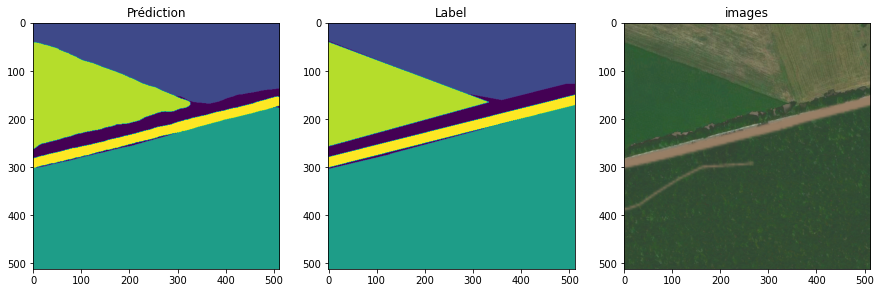

In [34]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
annotation = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [21]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
    label = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)
valid_imgs.shape,valid_labels.shape

((73, 512, 512, 3), (73, 512, 512, 3))

In [13]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [14]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [15]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

In [16]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [51]:
predictions = np.zeros(predictions.shape)

for idx_class in range(12):
    predictions[...,idx_class][label_pred == idx_class] = 1

IOU moyen et par classe

In [52]:
iou = []
for idx_classe in range(12):
    prediction = predictions[...,idx_classe]
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction)
    union = np.logical_or(target,prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.35317492115124594, 0.7466477967223444, 0.884407311553435, 0.8942928984088022, 0.6745634404607096, 0.7807258283345356, 0.5543499840674334, 0.7256830144847816, 0.7395164966558309, 0.6141386982938567, 0.8819176843511013, 0.6705537053690546]
mIou:  0.7099976483210942


matrice de confusion par classe

In [53]:
conf_mat = np.zeros((12,12))

for idx_pred_class in range(12):
    for idx_target_class in range(12):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,predictions[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [54]:
classes = list(CLASSES)

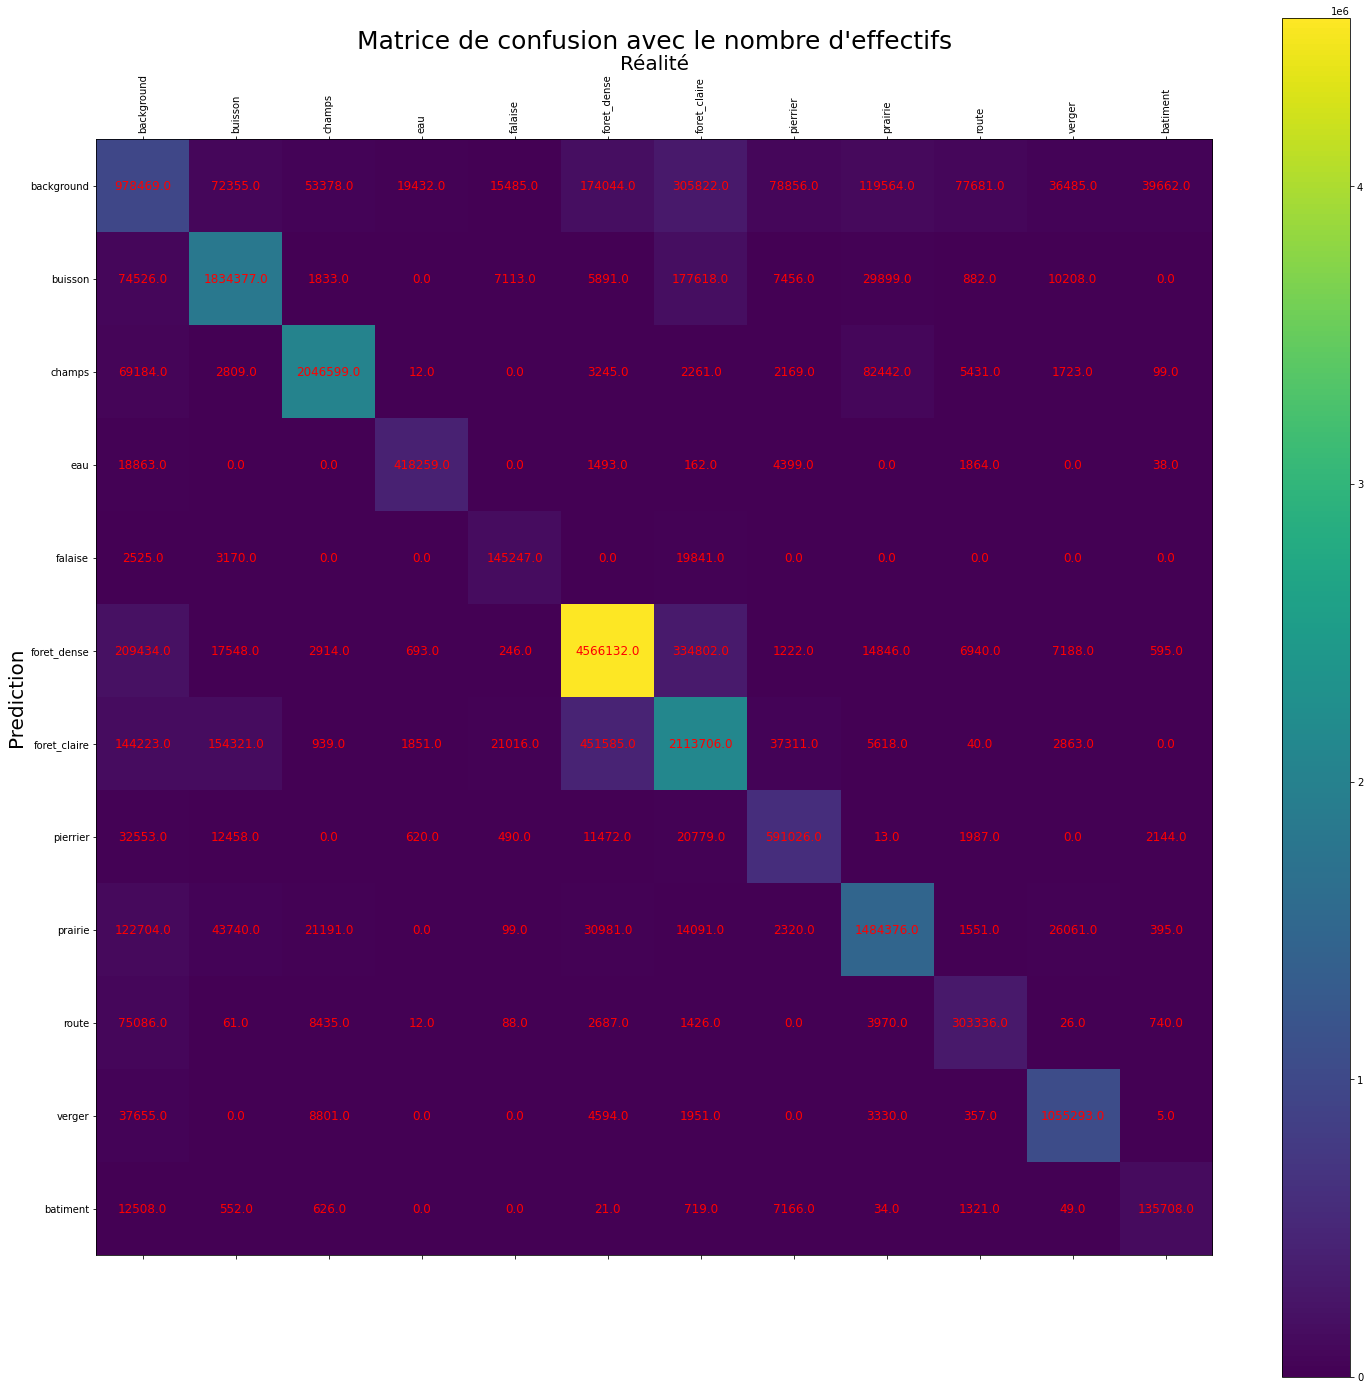

In [55]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()


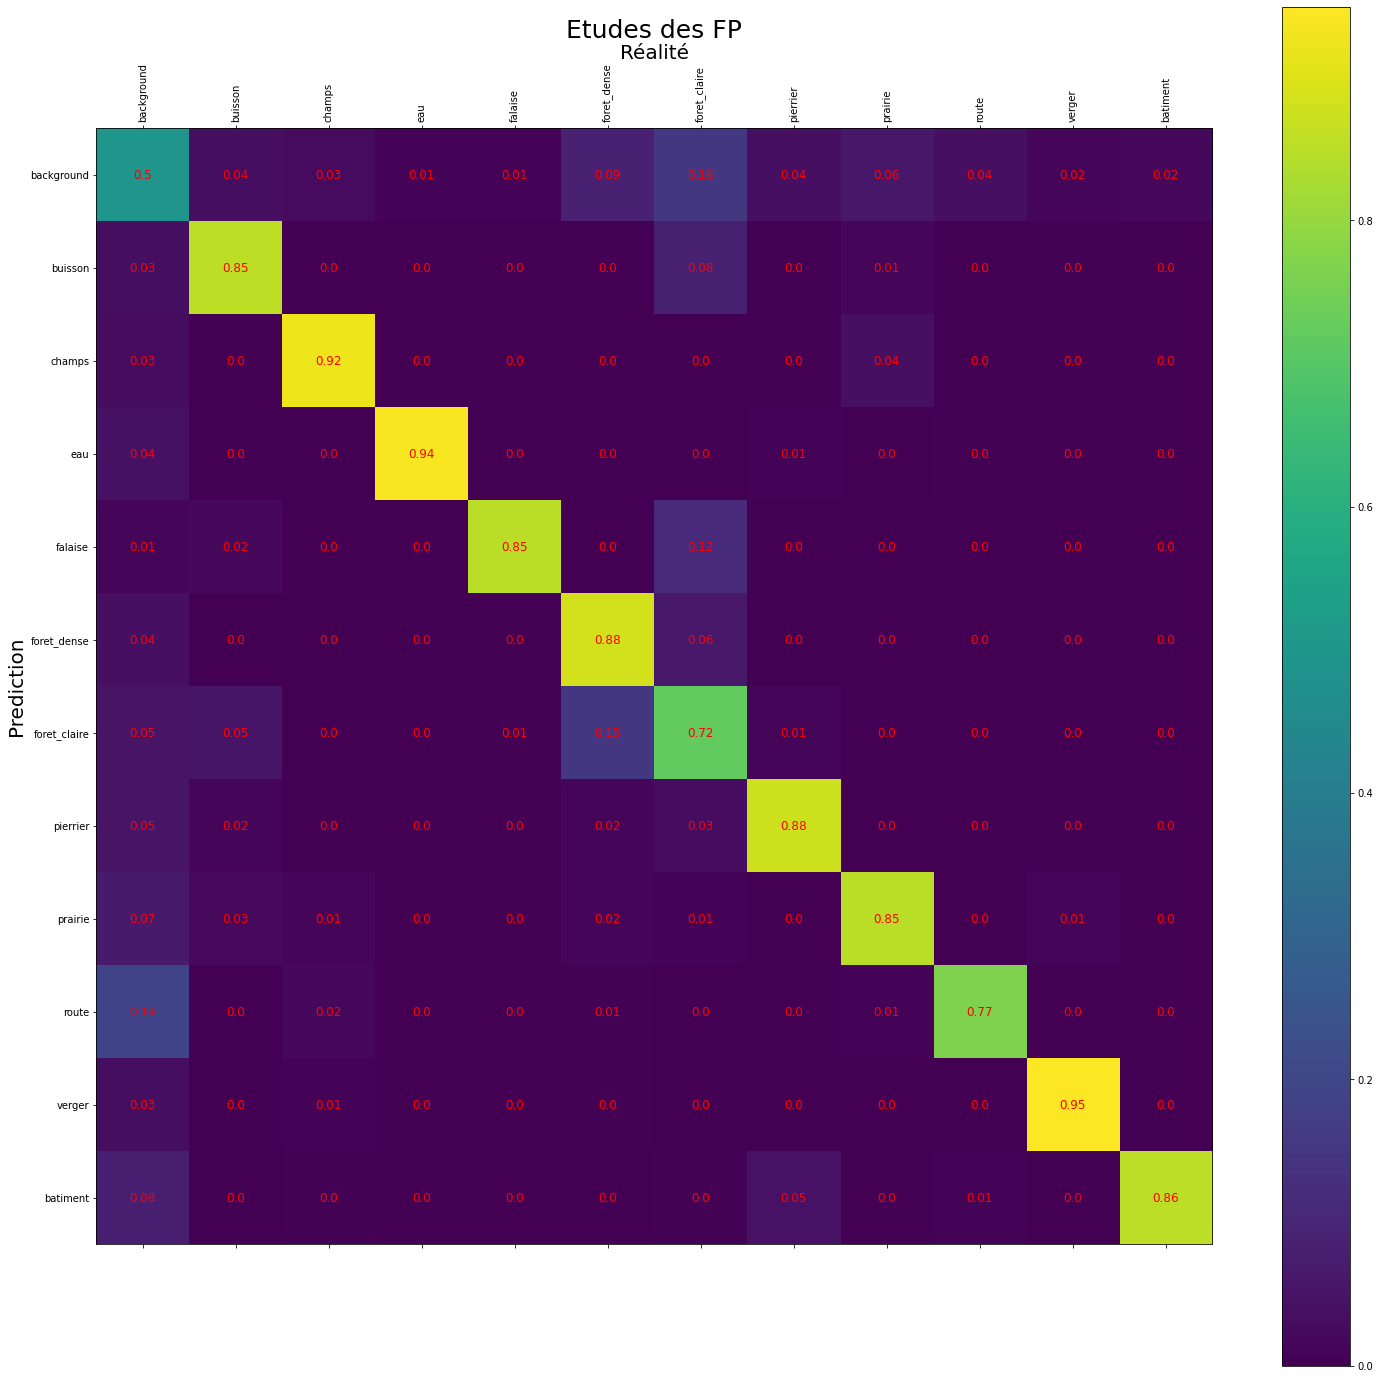

In [56]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

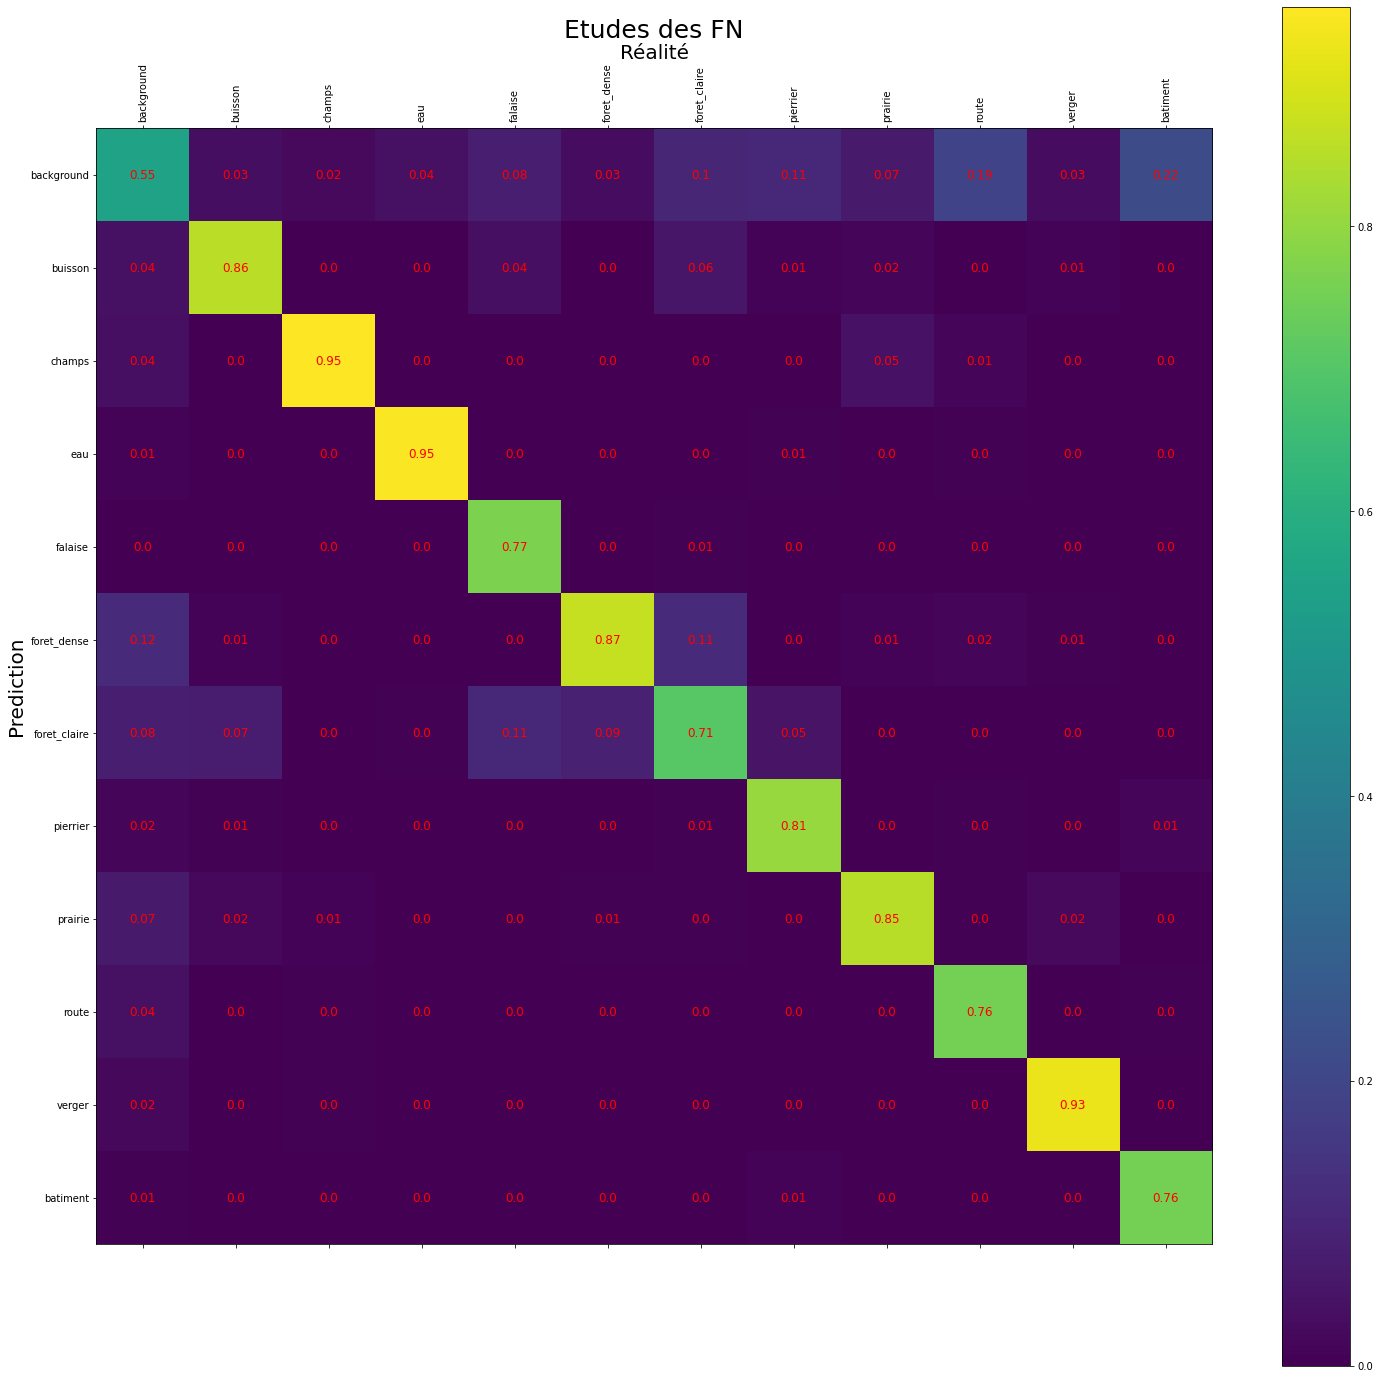

In [57]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()


In [58]:
dico = {}
for idx,classe in zip(range(12),classes):
    precision = conf_mat[idx,idx]/np.sum(conf_mat[idx,:])
    recall = conf_mat[idx,idx]/np.sum(conf_mat[:,idx])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classe] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'background': {'precision': 0.49637409682163397,
  'recall': 0.5504036045968735,
  'f1': 0.5219944822074798},
 'buisson': {'precision': 0.8532767886173757,
  'recall': 0.8566287053602074,
  'f1': 0.8549494616183747},
 'champs': {'precision': 0.923566341482346,
  'recall': 0.9542517517470844,
  'f1': 0.9386583315943119},
 'eau': {'precision': 0.9397431461451701,
  'recall': 0.9486934056736656,
  'f1': 0.9441970659975597},
 'falaise': {'precision': 0.850476921005018,
  'recall': 0.7653279517767567,
  'f1': 0.8056588650652999},
 'foret_dense': {'precision': 0.8844704952581665,
  'recall': 0.8693842230174529,
  'f1': 0.8768624747412432},
 'foret_claire': {'precision': 0.7205472830327738,
  'recall': 0.7061745074967142,
  'f1': 0.7132884996940093},
 'pierrier': {'precision': 0.877489451288858,
  'recall': 0.8074953034805479,
  'f1': 0.8410386014043731},
 'prairie': {'precision': 0.8494239514646277,
  'recall': 0.8510881306720058,
  'f1': 0.8502552267570093},
 'route': {'precision': 0.76625

In [59]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.8206582108631774
mean precision score is: 0.8304786328647179
mean recall score is: 0.8122879529549785


###  test sur jeu de synthese

#split train/val set randomly
data_root = "data/synthese2/"
split_dir = 'splits_synthese/'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  #select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  #select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
import re
valid_index = []
with open(osp.join(data_root, split_dir) + "val.txt", 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

In [ ]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
    label = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [ ]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
annotation = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [ ]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [ ]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

predictions = np.zeros(predictions.shape)

for idx_class in range(11):
    predictions[...,idx_class][label_pred == idx_class] = 1


In [ ]:
predictions.shape,valid_imgs.shape,valid_labels.shape

In [ ]:
classes_real = {0:"background",1:"buisson",2:"champs",3:"eau",
         4:"falaise",5:"foret_dense",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}


correspondance = {0:4,1:11,2:9,3:7,4:10,5:2,6:8,7:5,8:6,9:1,10:3,11:0}

In [ ]:
a = list(classes_syn.values())
a.append("background")

In [ ]:
iou = {}
for idx_classe in range(11):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,predictions[...,correspondance[idx_classe]])
    union = np.logical_or(target,predictions[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score

print(iou)  
print("mIou: ", np.mean(list(iou.values())))